# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from numpy.polynomial import Polynomial as P
%matplotlib inline
prev_x3_left = None
prev_x4_left = None
prev_x3_right = None
prev_x4_right = None


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


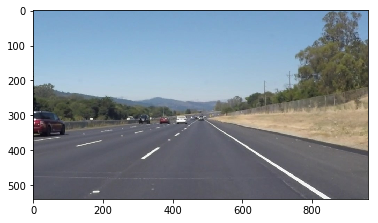

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting

print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [13]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2: #Rgb coloured image
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else: #Gray image 1 channel
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


            
def draw_lines(img, lines, color=[255, 0, 0], thickness=9):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope =[]
    point1_left = [[],[]]
    point2_left = [[],[]]
    point1_right = [[],[]]
    point2_right = [[],[]]
    a_list_left = []
    b_list_left = []
    a_list_right = []
    b_list_right = []
    num_of_points_left = 0
    num_of_points_right = 0
    global prev_x3_left, prev_x4_left, prev_x3_right, prev_x4_right

    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate slope
            #a, b = np.polyfit((x1,x2), (y1,y2), 1)
            #calculate b coefficient of y= ax + b line equation
            a = (y2-y1)/(x2-x1)
            #b = y1 - a*x1
            #filter out lines with horizontal slopes
            if 0.3 > a > -0.3:
                continue
            #separate left and right line by slope
            # a > 0: right line, a < 0: left line
            if a < 0:
                #filter out lines whose top endpoint go out of region of interest
                if x1 > 490:
                    continue
                point1_left[0].append(x1)
                point1_left[1].append(y1)
                point1_left[0].append(x2)
                point1_left[1].append(y2)
                a_list_left.append(a)
                #b_list_left.append(b)
                num_of_points_left = num_of_points_left + 1
                #cv2.circle(img,(x1,y1),8,[0,255,0],10)
                #cv2.circle(img,(x2,y2),8,[0,0,255],10)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            else:
                #filter out lines whose top endpoint go out of region of interest
                if x1 < 465:
                    continue
                point1_right[0].append(x1)
                point1_right[1].append(y1)
                point1_right[0].append(x2)
                point1_right[1].append(y2)
                a_list_right.append(a)
                #b_list_right.append(b)
                num_of_points_right = num_of_points_right + 1
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
   
    point1_left = np.array(point1_left)
    #point2_left = np.array(point2_left)
    a_list_left = np.array(a_list_left)
    b_list_left = np.array(b_list_left)
    x1_avg_left = np.mean(point1_left[0])
    y1_avg_left = np.mean(point1_left[1])
    a_avg_left = (np.mean(a_list_left))
    b_avg_left = y1_avg_left - a_avg_left*x1_avg_left
 
    point1_right = np.array(point1_right)
    #point2_right = np.array(point2_right)
    a_list_right = np.array(a_list_right)
    b_list_right = np.array(b_list_right)
    x1_avg_right = np.mean(point1_right[0])
    y1_avg_right = np.mean(point1_right[1])
    a_avg_right = (np.mean(a_list_right))
    b_avg_right = y1_avg_right - a_avg_right*x1_avg_right
    
    #find position of top and bottom points of the extrapolated points
    y3_left = 540 #y-coordinate = y-coordinate of region of interest
    x3_left = ((y3_left-b_avg_left)/a_avg_left)
    y4_left = 310 #y-coordinate = y-coordinate of region of interest
    x4_left = ((y4_left-b_avg_left)/a_avg_left)
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x2_avg_left, y2_avg_left), color, thickness)
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x4_left,y4_left), color, thickness)
   
    
    y3_right = 540
    x3_right = ((y3_right - b_avg_right)/a_avg_right)
    y4_right = 310
    x4_right = ((y4_right - b_avg_right)/a_avg_right)
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x2_avg_right, y2_avg_right), color, thickness)
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x4_right,y4_right), color, thickness)
    
    #weighted new x-coordinate of line with its old and current value to smooth the movement of lines drawn on the video
    if prev_x3_left is not None:
        x3_left = 0.7*prev_x3_left + 0.3*x3_left
        x4_left = 0.7*prev_x4_left + 0.3*x4_left
        x3_right = 0.7*prev_x3_right + 0.3*x3_right
        x4_right = 0.7*prev_x4_right + 0.3*x4_right
    prev_x3_left = x3_left
    prev_x4_left = x4_left
    prev_x3_right = x3_right
    prev_x4_right = x4_right
    
    cv2.line(img, (int(x4_left), int(y4_left)), (int(x3_left), int(y3_left)), color, thickness)
    cv2.line(img, (int(x4_right),int(y4_right)), (int(x3_right), int(y3_right)), color, thickness)
    print ("x3 = "+str(x3_left))
    print ('y3 ='+str(y3_left))
    print ('x4 =' + str(x4_left))
    print ('y4 =' +str(y4_left))
    print ('x1_list' + str(point1_left[0]))
    print ('y1_list' + str(point1_left[1]))
    print ('x2_list' + str(point2_left[0]))
    print ('y2_list' + str(point2_left[1]))
    print ('num_points_left' + str(num_of_points_left))
    print ('num_points_right' + str(num_of_points_right))
    print ('a_avg = ' + str(a_avg_left))
    print ('b_avg = ' + str(b_avg_left))
    print ('slope_left = ' + str(a_list_left))
    print ('slope_right ' + str(a_list_right))
    
def draw_lines_original(img, lines, color=[255, 0, 0], thickness=9):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope =[]
    point1_left = [[],[]]
    point2_left = [[],[]]
    point1_right = [[],[]]
    point2_right = [[],[]]
    a_list_left = []
    b_list_left = []
    a_list_right = []
    b_list_right = []
    num_of_points_left = 0
    num_of_points_right = 0

    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate slope
            #a, b = np.polyfit((x1,x2), (y1,y2), 1)
            #calculate b coefficient of y= ax + b line equation
            a = (y2-y1)/(x2-x1)
            #b = y1 - a*x1
            if 0.3 > a > -0.3:
                continue
            #separate left and right line by slope
            # a > 0: right line, a < 0: left line
            if a < 0:
                
                point1_left[0].append(x1)
                point1_left[1].append(y1)
                point1_left[0].append(x2)
                point1_left[1].append(y2)
                a_list_left.append(a)
                #b_list_left.append(b)
                num_of_points_left = num_of_points_left + 1
                #cv2.circle(img,(x1,y1),8,[0,255,0],10)
                #cv2.circle(img,(x2,y2),8,[0,0,255],10)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            else:
                
                point1_right[0].append(x1)
                point1_right[1].append(y1)
                point1_right[0].append(x2)
                point1_right[1].append(y2)
                a_list_right.append(a)
                #b_list_right.append(b)
                num_of_points_right = num_of_points_right + 1
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
   
    point1_left = np.array(point1_left)
    #point2_left = np.array(point2_left)
    a_list_left = np.array(a_list_left)
    b_list_left = np.array(b_list_left)
    x1_avg_left = int(np.mean(point1_left[0]))
    y1_avg_left = int(np.mean(point1_left[1]))
    a_avg_left = (np.mean(a_list_left))
    b_avg_left = y1_avg_left - a_avg_left*x1_avg_left
 
    point1_right = np.array(point1_right)
    #point2_right = np.array(point2_right)
    a_list_right = np.array(a_list_right)
    b_list_right = np.array(b_list_right)
    x1_avg_right = int(np.mean(point1_right[0]))
    y1_avg_right = int(np.mean(point1_right[1]))
    a_avg_right = (np.mean(a_list_right))
    b_avg_right = y1_avg_right - a_avg_right*x1_avg_right
    
    #find position of top and bottom points of the extrapolated points
    y3_left = 540 #y-coordinate = y-coordinate of region of interest
    x3_left = ((y3_left-b_avg_left)/a_avg_left)
    y4_left = 320 #y-coordinate = y-coordinate of region of interest
    x4_left = ((y4_left-b_avg_left)/a_avg_left)
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x2_avg_left, y2_avg_left), color, thickness)
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x4_left,y4_left), color, thickness)
    cv2.line(img, (int(x4_left), int(y4_left)), (int(x3_left), int(y3_left)), color, thickness)
    
    y3_right = 540
    x3_right = ((y3_right - b_avg_right)/a_avg_right)
    y4_right = 320
    x4_right = ((y4_right - b_avg_right)/a_avg_right)
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x2_avg_right, y2_avg_right), color, thickness)
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x4_right,y4_right), color, thickness)
    cv2.line(img, (int(x4_right),int(y4_right)), (int(x3_right), int(y3_right)), color, thickness)
    print ("x3 = "+str(x3_left))
    print ('y3 ='+str(y3_left))
    print ('x4 =' + str(x4_left))
    print ('y4 =' +str(y4_left))
    print ('x1_list' + str(point1_left[0]))
    print ('y1_list' + str(point1_left[1]))
    print ('x2_list' + str(point2_left[0]))
    print ('y2_list' + str(point2_left[1]))
    print ('num_points_left' + str(num_of_points_left))
    print ('num_points_right' + str(num_of_points_right))
    print ('a_avg = ' + str(a_avg_left))
    print ('b_avg = ' + str(b_avg_left))
    print ('slope_left = ' + str(a_list_left))
    print ('slope_right ' + str(a_list_right))
    
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    #slope = calculate_slope(lines)
    draw_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [14]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
x3 = 164.738552233
y3 =540
x4 =477.559278878
y4 =310
x1_list[154 472 175 352 292 439 264 388 175 287 397 440 174 266 268 327 308 353
 194 254 246 287]
y1_list[538 315 539 406 452 341 462 375 538 454 372 340 538 469 459 417 431 399
 509 467 474 445]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.725805806603
b_avg = 657.565791482
slope_left = [-0.70125786 -0.75141243 -0.75510204 -0.7016129  -0.75       -0.74418605
 -0.75       -0.71186441 -0.71111111 -0.7        -0.70731707]
slope_right [ 0.58536585  0.62264151  0.59090909  0.57142857  0.6         0.6
  0.61363636  0.57692308  0.59090909]


(540, 960, 3)

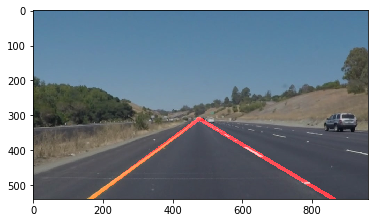

In [15]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#Gray scale image
gray = grayscale(image)
plt.imshow(gray, cmap='gray')
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray,kernel_size)
plt.imshow(blur_gray, cmap='gray')
# Define our parameters for Canny and apply
low_threshold = 30
high_threshold = 150
edges = canny(blur_gray,low_threshold,high_threshold)
plt.imshow(edges,cmap='Greys_r')
# This time we are defining a four sided polygon to mask
#xsize = imshape[1]
#ysize = imshape[0]
imshape = image.shape
ysize = imshape[0]
xsize = imshape[1]
top_mask_bound = 310
bottom_mask_bound = 540
vertices = np.array([[(40,ysize),(465, top_mask_bound), (490,top_mask_bound), (xsize -40,ysize)]], dtype=np.int32)
masked_edges = region_of_interest(edges,vertices)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15 # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20   # maximum gap in pixels between connectable line segments
#Run hoghline detection on edges image
line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)


#Draw the line on the colour image
line_colored_image = weighted_img(line_image,image)
plt.imshow(line_colored_image)
image.shape


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [17]:
def process_image(image):
    
    #Gray scale image
    gray = grayscale(image)
    plt.imshow(gray, cmap='gray')
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)
    plt.imshow(blur_gray, cmap='gray')
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 200
    edges = canny(blur_gray,low_threshold,high_threshold)
    plt.imshow(edges,cmap='Greys_r')
    # This time we are defining a four sided polygon to mask
    #xsize = imshape[1]
    #ysize = imshape[0]
    imshape = image.shape
    ysize = imshape[0]
    xsize = imshape[1]
    top_mask_bound = 310
    bottom_mask_bound = 540
    vertices = np.array([[(40,ysize),(465, top_mask_bound), (490,top_mask_bound), (xsize-40,ysize)]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/90 # angular resolution in radians of the Hough grid
    threshold = 10 #minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 10   # maximum gap in pixels between connectable line segments
    #Run hoghline detection on edges image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)


    #Draw the line on the colour image
    line_colored_image = weighted_img(line_image,image)
    plt.imshow(line_colored_image)
   
    return line_colored_image

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white8.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

x3 = 155.182725194
y3 =540
x4 =472.732439609
y4 =310
x1_list[165 423 277 347 253 444 105 224 320 407 351 416 195 283 450 469 125 227
 417 442 446 465 131 176 432 464 145 282]
y1_list[512 350 433 392 456 336 539 465 407 356 388 350 484 430 331 311 538 474
 348 333 330 310 522 494 343 312 525 439]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.69997317749
b_avg = 633.016492474
slope_left = [-0.62790698 -0.58571429 -0.62827225 -0.62184874 -0.5862069  -0.58461538
 -0.61363636 -1.05263158 -0.62745098 -0.6        -1.05263158 -0.62222222
 -0.96875    -0.62773723]
slope_right [ 0.72307692  0.72043011  0.67307692  0.66666667  0.72413793  0.70588235
  0.72727273  0.75        0.6728972 ]
[MoviePy] >>>> Building video yellow4.mp4
[MoviePy] Writing video yellow4.mp4


  0%|                                                                                                                                                                                                              | 0/682 [00:00<?, ?it/s]

x3 = 148.493646266
y3 =540
x4 =469.353652121
y4 =310
x1_list[165 423 277 347 253 444 105 224 320 407 351 416 195 283 450 469 125 227
 417 442 446 465 131 176 432 464 145 282]
y1_list[512 350 433 392 456 336 539 465 407 356 388 350 484 430 331 311 538 474
 348 333 330 310 522 494 343 312 525 439]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.69997317749
b_avg = 633.016492474
slope_left = [-0.62790698 -0.58571429 -0.62827225 -0.62184874 -0.5862069  -0.58461538
 -0.61363636 -1.05263158 -0.62745098 -0.6        -1.05263158 -0.62222222
 -0.96875    -0.62773723]
slope_right [ 0.72307692  0.72043011  0.67307692  0.66666667  0.72413793  0.70588235
  0.72727273  0.75        0.6728972 ]


  0%|▎                                                                                                                                                                                                     | 1/682 [00:00<01:58,  5.76it/s]

x3 = 140.117096864
y3 =540
x4 =471.147227997
y4 =310
x1_list[183 295 106 219 138 332 414 468 276 446 305 385 106 174 369 415 441 464
 125 164 266 373 126 214 381 406 411 444]
y1_list[492 423 539 469 530 408 352 313 442 335 417 370 538 496 378 351 338 318
 538 515 442 376 538 483 377 361 359 335]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.648324854736
b_avg = 618.169704396
slope_left = [-0.61607143 -0.61946903 -0.62886598 -0.72222222 -0.62941176 -0.5875
 -0.61764706 -0.58695652 -0.86956522 -0.58974359 -0.61682243 -0.625      -0.64
 -0.72727273]
slope_right [ 0.6744186   0.67619048  0.67032967  0.64285714  0.71052632  0.63333333
  0.65517241  0.66666667  0.67647059  0.7254902   0.70588235]


  0%|▌                                                                                                                                                                                                     | 2/682 [00:00<01:52,  6.04it/s]

x3 = 137.932054397
y3 =540
x4 =470.303412098
y4 =310
x1_list[205 285 106 158 270 341 288 461 127 248 116 201 362 406 349 437 271 360
 442 468 227 390 436 465 331 371 427 453 218 251 440 469 128 151 432 456]
y1_list[478 431 538 508 448 401 429 321 538 462 532 482 388 362 392 337 439 384
 338 313 474 372 342 310 408 383 348 329 480 460 334 310 538 524 344 326]
x2_list[]
y2_list[]
num_points_left18
num_points_right14
a_avg = -0.685542153094
b_avg = 631.063047212
slope_left = [-0.5875     -0.57692308 -0.66197183 -0.62427746 -0.62809917 -0.58823529
 -0.59090909 -0.625      -0.61797753 -0.96153846 -0.62576687 -1.10344828
 -0.625      -0.73076923 -0.60606061 -0.82758621 -0.60869565 -0.75      ]
slope_right [ 0.71428571  0.63157895  0.71153846  0.71428571  0.71428571  0.63636364
  0.725       0.62        0.65217391  0.72727273  0.65        0.72093023
  0.64705882  0.72131148]


  0%|▊                                                                                                                                                                                                     | 3/682 [00:00<01:47,  6.34it/s]

x3 = 141.004992789
y3 =540
x4 =467.210906812
y4 =310
x1_list[227 442 137 259 111 233 379 449 213 316 336 386 333 418 131 195 233 267
 451 469 286 392 440 465 201 238 444 464 424 456]
y1_list[468 334 534 457 539 463 380 333 485 420 407 374 403 350 538 498 464 442
 331 310 438 371 340 310 484 460 336 318 346 321]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.737605315301
b_avg = 649.294802112
slope_left = [-0.62325581 -0.63114754 -0.62295082 -0.67142857 -0.63106796 -0.66
 -0.62352941 -0.625      -0.64705882 -1.16666667 -0.63207547 -1.2
 -0.64864865 -0.9        -0.78125   ]
slope_right [ 0.71186441  0.66153846  0.66037736  0.71153846  0.72727273  0.65
  0.61904762  0.66666667  0.72340426  0.65        0.66666667]


  1%|█▏                                                                                                                                                                                                    | 4/682 [00:00<01:48,  6.25it/s]

x3 = 141.345860487
y3 =540
x4 =466.660854497
y4 =310
x1_list[174 435 114 196 358 450 155 253 264 354 134 191 330 386 447 465 115 329
 388 447 451 469 226 284 385 443 135 162 181 231 386 409]
y1_list[502 339 538 487 394 332 524 462 455 395 538 502 412 375 330 310 538 405
 375 335 331 310 478 441 372 333 538 521 508 475 371 355]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.711554008404
b_avg = 641.141153747
slope_left = [-0.62452107 -0.62195122 -0.67391304 -0.63265306 -0.66666667 -0.63157895
 -0.66071429 -1.11111111 -0.62149533 -0.6779661  -1.16666667 -0.63793103
 -0.67241379 -0.62962963 -0.66       -0.69565217]
slope_right [ 0.68181818  0.6         0.65217391  0.65789474  0.62857143  0.71428571
  0.68181818  0.68181818  0.68        0.61904762  0.67567568]


  1%|█▍                                                                                                                                                                                                    | 5/682 [00:00<01:50,  6.12it/s]

x3 = 145.876383943
y3 =540
x4 =464.637070775
y4 =310
x1_list[117 439 118 415 229 287 301 366 136 205 363 446 451 469 206 234 441 465
 276 358 180 203 444 470 437 461 210 257]
y1_list[538 337 539 353 478 441 432 389 538 495 392 336 332 312 493 476 339 310
 447 395 510 496 337 310 338 316 491 461]
x2_list[]
y2_list[]
num_points_left14
num_points_right3
a_avg = -0.757907021317
b_avg = 658.572738554
slope_left = [-0.6242236  -0.62626263 -0.63793103 -0.66153846 -0.62318841 -0.6746988
 -1.11111111 -0.60714286 -1.20833333 -0.63414634 -0.60869565 -1.03846154
 -0.91666667 -0.63829787]
slope_right [ 0.70833333  0.72727273  0.66666667]


  1%|█▋                                                                                                                                                                                                    | 6/682 [00:00<01:52,  6.01it/s]

x3 = 143.887317769
y3 =540
x4 =468.473359101
y4 =310
x1_list[120 403 119 429 295 448 138 208 183 241 234 308 445 465 375 399 431 459
 416 439 224 247 359 445 268 320 331 384 236 256]
y1_list[538 361 538 344 437 334 538 494 509 472 475 428 332 310 385 369 347 324
 351 337 482 468 395 337 454 419 407 374 474 462]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.680114129327
b_avg = 634.703283159
slope_left = [-0.6254417  -0.62580645 -0.67320261 -0.62857143 -0.63793103 -0.63513514
 -1.1        -0.66666667 -0.82142857 -0.60869565 -0.60869565 -0.6744186
 -0.67307692 -0.62264151 -0.6       ]
slope_right [ 0.66666667  0.66666667  0.70833333  0.66666667  0.7037037 ]


  1%|██                                                                                                                                                                                                    | 7/682 [00:01<02:03,  5.47it/s]

x3 = 143.633228459
y3 =540
x4 =469.715070311
y4 =310
x1_list[120 398 122 408 223 338 140 283 333 441 287 447 399 433 415 457 442 462
 448 469]
y1_list[538 364 536 357 484 407 539 443 412 339 442 334 362 340 351 324 332 319
 333 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.697874728272
b_avg = 639.824247762
slope_left = [-0.62589928 -0.62587413 -0.66956522 -0.67132867 -0.67592593 -0.675
 -0.64705882 -0.64285714 -0.65       -1.0952381 ]
slope_right [ 0.63157895  0.65714286  0.66666667  0.66666667  0.62162162  0.73076923]


  1%|██▎                                                                                                                                                                                                   | 8/682 [00:01<02:09,  5.19it/s]

x3 = 147.258397844
y3 =540
x4 =468.16025165
y4 =310
x1_list[120 393 398 446 141 238 178 320 409 429 313 439 143 403 451 468 437 459
 395 434 245 415]
y1_list[538 367 367 334 538 473 514 419 356 341 425 340 523 360 330 310 337 315
 364 339 470 356]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.74478195634
b_avg = 655.975306043
slope_left = [-0.62637363 -0.6875     -0.67010309 -0.66901408 -0.75       -0.67460317
 -0.62692308 -1.17647059 -1.         -0.64102564 -0.67058824]
slope_right [ 0.61363636  0.66666667  0.65        0.61363636  0.675     ]


  1%|██▌                                                                                                                                                                                                   | 9/682 [00:01<02:09,  5.22it/s]

x3 = 145.242993401
y3 =540
x4 =470.675178336
y4 =310
x1_list[121 367 142 275 362 382 304 327 381 450 338 461 226 441 140 178 425 450
 445 468 278 335 387 421 180 205 290 322 352 373]
y1_list[538 384 538 449 393 378 431 415 380 330 402 319 483 338 538 513 345 324
 335 310 447 411 370 348 512 497 432 411 398 391]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.6845177842
b_avg = 636.202391585
slope_left = [-0.62601626 -0.66917293 -0.75       -0.69565217 -0.72463768 -0.67479675
 -0.6744186  -0.65789474 -0.84       -1.08695652 -0.63157895 -0.64705882
 -0.6        -0.65625    -0.33333333]
slope_right [ 0.67346939  0.62264151  0.63333333  0.65909091  0.67567568  0.63333333
  0.38095238]


  1%|██▉                                                                                                                                                                                                  | 10/682 [00:01<02:10,  5.15it/s]

x3 = 146.605460882
y3 =540
x4 =469.359653097
y4 =310
x1_list[124 352 144 338 206 378 212 433 395 431 437 466 143 256 392 418 353 397
 432 461 389 409 123 199 413 444 440 468]
y1_list[537 394 538 408 485 377 493 344 364 341 341 313 538 462 371 354 392 364
 340 312 368 356 539 491 353 329 339 310]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.726685536556
b_avg = 648.846267299
slope_left = [-0.62719298 -0.67010309 -0.62790698 -0.67420814 -0.63888889 -0.96551724
 -0.67256637 -0.65384615 -0.63636364 -0.96551724 -0.6        -0.63157895
 -0.77419355 -1.03571429]
slope_right [ 0.72727273  0.61538462  0.625       0.625       0.7027027   0.67307692]


  2%|███▏                                                                                                                                                                                                 | 11/682 [00:01<02:10,  5.15it/s]

x3 = 145.705874312
y3 =540
x4 =466.651071091
y4 =310
x1_list[144 438 332 437 211 420 384 444 163 219 242 286 223 265 305 459 269 328
 124 178 201 227 442 467 124 145 436 461 144 245]
y1_list[539 340 407 336 494 353 376 335 514 477 464 435 476 448 424 320 447 408
 539 503 490 472 336 310 538 524 340 312 538 470]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.726183836298
b_avg = 644.284965249
slope_left = [-0.67687075 -0.67619048 -0.67464115 -0.68333333 -0.66071429 -0.65909091
 -0.66666667 -0.67532468 -0.66101695 -0.66666667 -0.69230769 -1.04
 -0.66666667 -1.12       -0.67326733]
slope_right [ 0.62025316  0.67567568  0.625       0.65        0.68      ]


  2%|███▍                                                                                                                                                                                                 | 12/682 [00:02<02:14,  4.99it/s]

x3 = 146.303709372
y3 =540
x4 =465.658109259
y4 =310
x1_list[146 427 178 348 318 376 439 467 175 368 126 175 426 460 384 423 146 183
 358 392 428 459 190 223 405 429 237 299 380 436]
y1_list[538 348 504 397 415 378 339 310 519 389 539 506 344 313 371 346 526 501
 389 367 347 313 498 476 357 342 468 427 379 341]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.72867237622
b_avg = 647.623931978
slope_left = [-0.67615658 -0.62941176 -0.63793103 -1.03571429 -0.67357513 -0.67346939
 -0.91176471 -0.64102564 -0.67567568 -0.64705882 -1.09677419 -0.66666667
 -0.625      -0.66129032 -0.67857143]
slope_right [ 0.62        0.67741935  0.68        0.671875    0.64285714  0.625
  0.62686567  0.65384615]


  2%|███▊                                                                                                                                                                                                 | 13/682 [00:02<02:10,  5.14it/s]

x3 = 147.266875875
y3 =540
x4 =464.994926334
y4 =310
x1_list[148 363 278 434 127 256 147 415 365 438 314 428 251 328 439 467 206 246
 438 459 227 274 209 241 162 210 435 458]
y1_list[538 393 443 338 538 457 538 357 390 340 420 343 460 409 339 310 500 473
 339 313 475 444 486 465 517 485 336 321]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.732639855435
b_avg = 649.540109042
slope_left = [-0.6744186  -0.67307692 -0.62790698 -0.67537313 -0.68493151 -0.6754386
 -0.66233766 -1.03571429 -0.675      -1.23809524 -0.65957447 -0.65625
 -0.66666667 -0.65217391]
slope_right [ 0.67479675  0.62121212  0.62626263  0.66666667  0.625       0.72727273
  0.65        0.66666667]


  2%|████                                                                                                                                                                                                 | 14/682 [00:02<02:09,  5.17it/s]

x3 = 150.424753461
y3 =540
x4 =463.097642088
y4 =310
x1_list[149 363 370 443 262 434 130 160 142 216 150 294 204 272 302 421 440 459
 434 464 347 426 444 466 169 244 435 461 254 274 372 404]
y1_list[538 393 388 335 454 338 538 518 531 482 539 441 491 446 428 348 333 313
 343 314 403 349 334 310 514 464 337 312 459 445 385 363]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.764430678858
b_avg = 660.621912922
slope_left = [-0.67757009 -0.7260274  -0.6744186  -0.66666667 -0.66216216 -0.68055556
 -0.66176471 -0.67226891 -1.05263158 -0.96666667 -0.6835443  -1.09090909
 -0.66666667 -0.96153846 -0.7        -0.6875    ]
slope_right [ 0.62237762  0.62068966  0.65909091  0.67241379  0.65909091  0.57142857
  0.73333333  0.67045455  0.66666667]


  2%|████▎                                                                                                                                                                                                | 15/682 [00:02<02:05,  5.32it/s]

x3 = 150.822372113
y3 =540
x4 =464.027034092
y4 =310
x1_list[239 430 151 333 132 202 376 442 297 373 431 458 198 291 443 467 411 453
 398 434 322 410 189 213 134 154 237 293]
y1_list[470 341 538 415 539 492 384 336 438 386 339 320 496 434 335 310 355 320
 369 343 422 359 502 485 537 523 481 441]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.731446385866
b_avg = 650.997098016
slope_left = [-0.67539267 -0.67582418 -0.67142857 -0.72727273 -0.68421053 -0.7037037
 -0.66666667 -1.04166667 -0.83333333 -0.72222222 -0.71590909 -0.70833333
 -0.7        -0.71428571]
slope_right [ 0.62280702  0.68181818  0.61290323  0.61682243  0.63235294  0.75        0.7
  0.66666667  0.6         0.64        0.57142857]


  2%|████▌                                                                                                                                                                                                | 16/682 [00:02<02:03,  5.41it/s]

x3 = 152.011942122
y3 =540
x4 =465.269208656
y4 =310
x1_list[269 422 151 321 218 427 434 461 132 210 373 439 153 240 325 410 189 269
 444 466 297 374 424 452 438 458 395 431]
y1_list[450 347 538 423 484 343 336 317 538 489 386 338 538 479 420 359 502 449
 334 310 440 384 344 326 334 315 371 345]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.73393321941
b_avg = 653.603765613
slope_left = [-0.67320261 -0.67647059 -0.67464115 -0.7037037  -0.62820513 -0.72727273
 -0.67816092 -0.71764706 -0.6625     -1.09090909 -0.72727273 -0.64285714
 -0.95       -0.72222222]
slope_right [ 0.625       0.68253968  0.66666667  0.66666667  0.68181818  0.72727273
  0.66666667  0.70833333  0.63636364  0.62295082  0.61904762  0.66666667]


  2%|████▉                                                                                                                                                                                                | 17/682 [00:03<01:59,  5.55it/s]

x3 = 152.747212022
y3 =540
x4 =467.492025645
y4 =310
x1_list[177 426 394 449 155 271 202 302 325 391 136 223 280 337 397 444 417 459
 427 458 343 390 173 207 318 341]
y1_list[512 344 372 329 538 459 505 437 419 374 538 480 451 412 371 334 351 313
 343 315 406 374 526 505 424 409]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.722780048002
b_avg = 651.642660201
slope_left = [-0.6746988  -0.78181818 -0.68103448 -0.68       -0.68181818 -0.66666667
 -0.68421053 -0.78723404 -0.9047619  -0.90322581 -0.68085106 -0.61764706
 -0.65217391]
slope_right [ 0.60714286  0.66666667  0.61538462  0.66666667]


  3%|█████▏                                                                                                                                                                                               | 18/682 [00:03<02:02,  5.41it/s]

x3 = 153.914635816
y3 =540
x4 =466.768483431
y4 =310
x1_list[154 424 259 395 135 170 369 433 203 317 136 215 181 204 412 450 432 465
 154 181 366 387 156 231 435 457 236 351 332 376]
y1_list[527 345 467 369 538 515 389 343 506 424 538 485 520 505 354 322 343 311
 538 521 391 375 539 485 336 314 483 400 415 383]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.745684125548
b_avg = 656.802935865
slope_left = [-0.67407407 -0.72058824 -0.65714286 -0.71875    -0.71929825 -0.67088608
 -0.65217391 -0.84210526 -0.96969697 -0.62962963 -0.76190476 -0.72       -1.
 -0.72173913 -0.72727273]
slope_right [ 0.60606061  0.71428571  0.68        0.60714286]


  3%|█████▍                                                                                                                                                                                               | 19/682 [00:03<02:03,  5.38it/s]

x3 = 157.448445769
y3 =540
x4 =464.693891264
y4 =310
x1_list[136 424 321 406 193 336 428 455 154 188 178 414 428 454 441 461 398 440
 136 159 411 435 425 457 194 270 265 362]
y1_list[539 344 422 361 513 410 346 320 538 516 511 352 341 317 335 315 368 335
 538 522 359 340 343 314 512 457 462 392]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.781889604066
b_avg = 669.554417875
slope_left = [-0.67708333 -0.71764706 -0.72027972 -0.96296296 -0.64705882 -0.67372881
 -0.92307692 -1.         -0.78571429 -0.69565217 -0.79166667 -0.90625
 -0.72368421 -0.72164948]
slope_right [ 0.61111111  0.66666667  0.6875      0.61538462]


  3%|█████▊                                                                                                                                                                                               | 20/682 [00:03<02:04,  5.32it/s]

x3 = 156.853606709
y3 =540
x4 =465.111450203
y4 =310
x1_list[155 268 134 329 176 316 155 195 321 346 344 435 319 349 297 322 203 316
 334 356 391 411 417 437 336 374 436 461 341 369 391 420 412 444 311 332
 137 355 270 290]
y1_list[539 457 538 407 524 423 538 509 421 402 405 339 415 394 438 419 493 417
 412 395 366 353 347 332 404 377 338 314 407 386 372 351 352 325 428 412
 537 390 457 442]
x2_list[]
y2_list[]
num_points_left20
num_points_right5
a_avg = -0.740454323253
b_avg = 655.115211848
slope_left = [-0.72566372 -0.67179487 -0.72142857 -0.725      -0.76       -0.72527473
 -0.7        -0.76       -0.67256637 -0.77272727 -0.65       -0.75
 -0.71052632 -0.96       -0.75       -0.72413793 -0.84375    -0.76190476
 -0.67431193 -0.75      ]
slope_right [ 0.62790698  0.65789474  0.67567568  0.60869565  0.6097561 ]


  3%|██████                                                                                                                                                                                               | 21/682 [00:03<02:03,  5.33it/s]

x3 = 156.972055567
y3 =540
x4 =464.400204886
y4 =310
x1_list[134 423 196 314 299 398 396 433 230 414 133 286 421 450 153 197 355 383
 364 401 423 448 268 340 432 453 215 269 161 215]
y1_list[538 343 509 424 436 365 368 339 474 350 538 435 344 318 538 508 397 376
 391 363 348 325 458 406 336 316 494 457 532 495]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.752883388932
b_avg = 658.389735577
slope_left = [-0.67474048 -0.72033898 -0.71717172 -0.78378378 -0.67391304 -0.67320261
 -0.89655172 -0.68181818 -0.75       -0.75675676 -0.92       -0.72222222
 -0.95238095 -0.68518519 -0.68518519]
slope_right [ 0.62745098  0.61702128  0.62        0.62162162]


  3%|██████▎                                                                                                                                                                                              | 22/682 [00:03<01:51,  5.91it/s]

x3 = 155.536520807
y3 =540
x4 =464.562930092
y4 =310
x1_list[133 422 218 310 132 253 299 380 344 428 162 222 433 463 427 452 152 174
 279 336 368 398 167 187 314 369 423 444 177 274]
y1_list[539 344 493 427 538 457 436 378 405 344 531 490 340 311 340 317 538 524
 450 409 382 361 528 515 418 381 342 324 522 452]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.735398308778
b_avg = 651.918018074
slope_left = [-0.67474048 -0.7173913  -0.66942149 -0.71604938 -0.72619048 -0.68333333
 -0.96666667 -0.92       -0.63636364 -0.71929825 -0.7        -0.65
 -0.67272727 -0.85714286 -0.72164948]
slope_right [ 0.62295082  0.62790698  0.59259259  0.62        0.61764706  0.6       ]


  3%|██████▋                                                                                                                                                                                              | 23/682 [00:04<01:54,  5.77it/s]

x3 = 155.748555056
y3 =540
x4 =464.003091993
y4 =310
x1_list[227 418 166 258 237 354 132 255 292 405 409 431 348 406 428 461 427 453
 152 218 442 463 138 311 415 450 153 181 289 381 233 256 376 410]
y1_list[476 347 528 465 478 399 539 456 433 357 359 340 401 361 344 312 340 316
 538 493 332 311 535 419 349 318 538 519 442 379 481 466 381 358]
x2_list[]
y2_list[]
num_points_left17
num_points_right6
a_avg = -0.750521690578
b_avg = 657.263986885
slope_left = [-0.67539267 -0.68478261 -0.67521368 -0.67479675 -0.67256637 -0.86363636
 -0.68965517 -0.96969697 -0.92307692 -0.68181818 -1.         -0.67052023
 -0.88571429 -0.67857143 -0.68478261 -0.65217391 -0.67647059]
slope_right [ 0.62337662  0.67142857  0.67391304  0.65625     0.61904762  0.61643836]


  4%|██████▉                                                                                                                                                                                              | 24/682 [00:04<01:56,  5.65it/s]

x3 = 156.161760391
y3 =540
x4 =462.703714195
y4 =310
x1_list[134 277 199 415 299 430 232 313 173 254 437 463 258 402 429 453 134 195
 154 188 424 455 413 435]
y1_list[539 443 496 350 438 343 485 427 526 468 337 312 457 360 339 316 538 497
 538 515 343 315 355 338]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.760215160277
b_avg = 659.449495944
slope_left = [-0.67132867 -0.67592593 -0.72519084 -0.71604938 -0.71604938 -0.96153846
 -0.67361111 -0.95833333 -0.67213115 -0.67647059 -0.90322581 -0.77272727]
slope_right [ 0.67213115  0.66666667  0.6125      0.61797753  0.7         0.65517241
  0.7027027 ]


  4%|███████▏                                                                                                                                                                                             | 25/682 [00:04<01:57,  5.61it/s]

x3 = 159.677244658
y3 =540
x4 =460.314190977
y4 =310
x1_list[211 402 137 275 250 371 290 425 160 242 193 285 137 171 423 457 440 465
 437 453 416 455 157 205 362 406]
y1_list[490 361 539 446 474 387 446 348 537 478 514 448 538 515 345 314 335 310
 337 317 350 315 539 504 395 363]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.801788768384
b_avg = 674.604331537
slope_left = [-0.67539267 -0.67391304 -0.71900826 -0.72592593 -0.7195122  -0.7173913
 -0.67647059 -0.91176471 -1.         -1.25       -0.8974359  -0.72916667
 -0.72727273]
slope_right [ 0.62068966  0.62184874  0.61016949  0.59090909  0.65714286  0.6
  0.62365591  0.66      ]


  4%|███████▌                                                                                                                                                                                             | 26/682 [00:04<02:04,  5.26it/s]

x3 = 160.71617756
y3 =540
x4 =462.16575054
y4 =310
x1_list[139 389 138 402 159 257 362 440 414 439 228 386 403 453 415 444 381 404
 321 345 352 374 159 225]
y1_list[539 370 538 360 539 468 395 334 351 330 490 376 359 317 355 329 381 364
 424 406 402 385 537 492]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.758210841918
b_avg = 663.694785407
slope_left = [-0.676      -0.67424242 -0.7244898  -0.78205128 -0.84       -0.72151899
 -0.84       -0.89655172 -0.73913043 -0.75       -0.77272727 -0.68181818]
slope_right [ 0.62601626  0.61904762  0.62809917  0.61904762  0.6119403   0.57142857
  0.61016949  0.62686567  0.75        0.61842105]


  4%|███████▊                                                                                                                                                                                             | 27/682 [00:04<02:08,  5.11it/s]

x3 = 160.925215086
y3 =540
x4 =462.680875211
y4 =310
x1_list[139 391 219 417 400 428 274 402 159 242 272 399 194 292 411 453 429 461
 168 337 411 455]
y1_list[538 368 497 353 365 344 458 365 539 479 448 362 502 436 353 316 343 312
 533 411 352 315]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.760406333928
b_avg = 662.739444244
slope_left = [-0.67460317 -0.72727273 -0.75       -0.7265625  -0.72289157 -0.67716535
 -0.67346939 -0.88095238 -0.96875    -0.72189349 -0.84090909]
slope_right [ 0.62601626  0.61616162  0.61403509  0.62962963  0.62162162  0.6
  0.63636364  0.61904762  0.66666667  0.61538462]


  4%|████████                                                                                                                                                                                             | 28/682 [00:05<02:03,  5.29it/s]

x3 = 162.865533857
y3 =540
x4 =461.516057583
y4 =310
x1_list[139 385 161 419 140 351 260 392 294 394 417 461 402 453 425 444 160 202
 352 372]
y1_list[538 372 539 351 539 396 468 372 433 365 352 313 359 316 346 323 538 508
 401 386]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.789278968561
b_avg = 672.119730439
slope_left = [-0.67479675 -0.72868217 -0.67772512 -0.72727273 -0.68       -0.88636364
 -0.84313725 -1.21052632 -0.71428571 -0.75      ]
slope_right [ 0.6         0.61797753  0.58108108  0.69565217  0.58227848  0.6
  0.57142857  0.65        0.6       ]


  4%|████████▍                                                                                                                                                                                            | 29/682 [00:05<02:03,  5.29it/s]

x3 = 162.075927327
y3 =540
x4 =462.866488839
y4 =310
x1_list[141 364 162 398 389 412 390 422 281 380 328 395 366 414 434 461 161 304
 162 379 396 453 406 445]
y1_list[538 387 539 367 367 351 372 348 453 381 410 364 390 355 338 312 538 435
 523 376 363 316 356 323]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.752164968662
b_avg = 660.5220346
slope_left = [-0.67713004 -0.72881356 -0.69565217 -0.75       -0.72727273 -0.68656716
 -0.72916667 -0.96296296 -0.72027972 -0.67741935 -0.8245614  -0.84615385]
slope_right [ 0.63414634  0.57142857  0.55172414  0.62222222  0.625       0.60465116
  0.69565217  0.59259259]


  4%|████████▋                                                                                                                                                                                            | 30/682 [00:05<02:03,  5.29it/s]

x3 = 161.144892779
y3 =540
x4 =464.119928858
y4 =310
x1_list[198 384 141 344 202 376 162 274 346 388 385 458 395 453 411 443 391 411
 162 387 378 407 402 446]
y1_list[513 378 538 401 496 378 538 457 398 369 377 316 364 316 352 325 371 357
 539 375 375 355 364 327]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.746578374342
b_avg = 658.685414813
slope_left = [-0.72580645 -0.67487685 -0.67816092 -0.72321429 -0.69047619 -0.83561644
 -0.82758621 -0.84375    -0.7        -0.72888889 -0.68965517 -0.84090909]
slope_right [ 0.5625      0.66666667  0.58064516  0.68965517]


  5%|████████▉                                                                                                                                                                                            | 31/682 [00:05<02:04,  5.22it/s]

x3 = 162.402570488
y3 =540
x4 =463.434376542
y4 =310
x1_list[163 388 142 353 429 461 331 380 205 370 143 291 406 461 389 414 327 350
 362 387 163 250 422 456]
y1_list[539 375 538 395 342 313 409 375 509 389 538 438 361 312 374 348 412 397
 387 370 538 475 348 317]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.775722966851
b_avg = 668.255825933
slope_left = [-0.72888889 -0.67772512 -0.90625    -0.69387755 -0.72727273 -0.67567568
 -0.89090909 -1.04       -0.65217391 -0.68       -0.72413793 -0.91176471]
slope_right [ 0.55555556  0.65625     0.57142857  0.56756757]


  5%|█████████▏                                                                                                                                                                                           | 32/682 [00:05<02:07,  5.11it/s]

x3 = 162.047278897
y3 =540
x4 =463.586871591
y4 =310
x1_list[164 365 144 340 391 455 163 382 420 448 280 362 343 388 143 234 404 430
 193 343 371 414 368 401 391 414 432 459]
y1_list[539 392 537 404 372 318 538 379 344 319 444 388 400 369 539 477 357 334
 518 409 386 354 382 359 365 349 339 313]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.759766898813
b_avg = 662.48830137
slope_left = [-0.73134328 -0.67857143 -0.84375    -0.7260274  -0.89285714 -0.68292683
 -0.68888889 -0.68131868 -0.88461538 -0.72666667 -0.74418605 -0.6969697
 -0.69565217 -0.96296296]
slope_right [ 0.57142857  0.65714286  0.64        0.57142857]


  5%|█████████▌                                                                                                                                                                                           | 33/682 [00:06<02:04,  5.23it/s]

x3 = 161.565292732
y3 =540
x4 =462.665881695
y4 =310
x1_list[165 343 267 421 379 460 219 282 340 367 166 214 194 250 391 453 165 357
 418 446 145 179 369 398 293 406 264 285]
y1_list[539 409 455 343 381 313 488 443 411 389 524 490 505 465 372 320 538 398
 345 320 538 514 389 365 437 355 457 441]
x2_list[]
y2_list[]
num_points_left14
num_points_right3
a_avg = -0.766471862927
b_avg = 662.973250294
slope_left = [-0.73033708 -0.72727273 -0.83950617 -0.71428571 -0.81481481 -0.70833333
 -0.71428571 -0.83870968 -0.72916667 -0.89285714 -0.70588235 -0.82758621
 -0.72566372 -0.76190476]
slope_right [ 0.57142857  0.62222222  0.62222222]


  5%|█████████▊                                                                                                                                                                                           | 34/682 [00:06<02:00,  5.37it/s]

x3 = 160.409177849
y3 =540
x4 =463.148633327
y4 =310
x1_list[166 319 260 413 212 264 387 455 165 345 146 204 370 460 406 441 180 239
 334 388 247 267 329 353 293 402 146 175 166 202]
y1_list[538 427 460 349 493 456 375 318 538 407 539 497 388 313 355 324 515 473
 414 374 469 454 418 401 437 358 538 517 539 513]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.750252450132
b_avg = 658.323496649
slope_left = [-0.7254902  -0.7254902  -0.71153846 -0.83823529 -0.72777778 -0.72413793
 -0.83333333 -0.88571429 -0.71186441 -0.74074074 -0.75       -0.70833333
 -0.72477064 -0.72413793 -0.72222222]
slope_right [ 0.57627119  0.62264151  0.61818182  0.58333333]


  5%|██████████                                                                                                                                                                                           | 35/682 [00:06<02:00,  5.38it/s]

x3 = 158.997985959
y3 =540
x4 =464.759964095
y4 =310
x1_list[166 300 246 410 146 207 308 427 407 428 389 420 424 451 145 243 282 305
 290 399 212 238 419 440 227 267 261 323 241 261 332 394]
y1_list[539 441 470 351 539 497 435 342 352 336 366 343 343 321 538 472 453 437
 439 360 492 475 347 331 495 464 469 423 473 458 415 369]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.735259961427
b_avg = 654.483802936
slope_left = [-0.73134328 -0.72560976 -0.68852459 -0.78151261 -0.76190476 -0.74193548
 -0.81481481 -0.67346939 -0.69565217 -0.72477064 -0.65384615 -0.76190476
 -0.775      -0.74193548 -0.75       -0.74193548]
slope_right [ 0.56944444  0.61538462  0.58536585  0.57142857]


  5%|██████████▍                                                                                                                                                                                          | 36/682 [00:06<02:03,  5.24it/s]

x3 = 159.217322916
y3 =540
x4 =464.800386548
y4 =310
x1_list[246 407 260 443 200 361 147 202 216 258 326 423 175 238 190 233 146 173
 171 211 167 195 257 329 238 304]
y1_list[470 353 471 328 502 386 539 499 503 471 421 345 519 474 522 489 538 519
 536 505 539 517 473 417 487 436]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.753689153266
b_avg = 660.386097026
slope_left = [-0.72670807 -0.78142077 -0.72049689 -0.72727273 -0.76190476 -0.78350515
 -0.71428571 -0.76744186 -0.7037037  -0.775      -0.78571429 -0.77777778
 -0.77272727]
slope_right [ 0.58        0.61728395  0.57303371  0.62195122  0.5952381 ]


  5%|██████████▋                                                                                                                                                                                          | 37/682 [00:06<02:06,  5.11it/s]

x3 = 159.746370253
y3 =540
x4 =463.835428032
y4 =310
x1_list[311 420 183 341 374 413 167 274 248 317 254 400 147 195 167 249 417 455
 405 446 310 439 167 245]
y1_list[432 347 514 400 378 346 538 460 478 427 464 358 538 504 525 466 349 315
 354 320 432 331 539 482]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.76512864556
b_avg = 663.171032208
slope_left = [-0.77981651 -0.72151899 -0.82051282 -0.72897196 -0.73913043 -0.7260274
 -0.70833333 -0.7195122  -0.89473684 -0.82926829 -0.78294574 -0.73076923]
slope_right [ 0.58035714  0.62135922  0.58139535  0.59322034]


  6%|██████████▉                                                                                                                                                                                          | 38/682 [00:07<02:06,  5.08it/s]

x3 = 159.08519415
y3 =540
x4 =464.012078009
y4 =310
x1_list[154 312 222 409 260 443 221 305 147 231 330 385 335 418 168 219 146 194
 303 398 244 330 181 252]
y1_list[534 420 486 350 470 327 499 434 539 478 409 369 413 348 538 499 538 504
 428 359 482 415 529 474]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.749474199747
b_avg = 658.074001572
slope_left = [-0.72151899 -0.72727273 -0.78142077 -0.77380952 -0.72619048 -0.72727273
 -0.78313253 -0.76470588 -0.70833333 -0.72631579 -0.77906977 -0.77464789]
slope_right [ 0.61940299  0.58064516  0.62222222  0.58333333  0.6         0.575     ]


  6%|███████████▎                                                                                                                                                                                         | 39/682 [00:07<01:58,  5.45it/s]

x3 = 159.214454484
y3 =540
x4 =462.430814626
y4 =310
x1_list[186 325 347 442 274 448 314 429 373 428 341 375 165 225 233 317 211 231
 183 204 300 324 222 245 149 170 330 357 165 218]
y1_list[510 410 396 322 458 322 428 338 377 334 400 374 539 495 489 424 505 489
 512 496 429 411 497 478 536 520 408 387 538 499]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.768651997062
b_avg = 662.612339565
slope_left = [-0.71942446 -0.77894737 -0.7816092  -0.7826087  -0.78181818 -0.76470588
 -0.73333333 -0.77380952 -0.8        -0.76190476 -0.75       -0.82608696
 -0.76190476 -0.77777778 -0.73584906]
slope_right [ 0.57798165  0.62162162  0.5785124   0.6         0.62416107  0.6         0.625
  0.61666667]


  6%|███████████▌                                                                                                                                                                                         | 40/682 [00:07<01:53,  5.66it/s]

x3 = 159.594395834
y3 =540
x4 =461.187395468
y4 =310
x1_list[166 230 145 271 280 363 289 395 215 298 356 407 403 453 259 413 144 168
 336 358 388 410 221 329 319 340 145 217 256 310]
y1_list[539 489 539 448 453 389 437 360 502 438 396 354 359 317 458 346 538 521
 411 393 371 352 485 407 424 407 538 486 471 429]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.772317045146
b_avg = 663.942154303
slope_left = [-0.78125    -0.72222222 -0.77108434 -0.72641509 -0.77108434 -0.82352941
 -0.84       -0.72727273 -0.70833333 -0.81818182 -0.86363636 -0.72222222
 -0.80952381 -0.72222222 -0.77777778]
slope_right [ 0.62608696  0.576       0.61666667  0.58928571  0.59090909  0.58333333
  0.56521739  0.578125    0.62608696]


  6%|███████████▊                                                                                                                                                                                         | 41/682 [00:07<01:51,  5.73it/s]

x3 = 157.585395323
y3 =540
x4 =462.578818963
y4 =310
x1_list[183 307 420 444 235 418 398 454 365 422 238 343 164 270 278 395 149 225
 144 184 356 392 329 352 165 204 217 243 393 433 206 232 341 388]
y1_list[524 433 339 321 475 342 363 316 389 342 483 406 538 461 445 360 534 482
 538 511 396 366 415 399 539 510 486 469 360 330 494 477 406 371]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.734993948935
b_avg = 652.378904491
slope_left = [-0.73387097 -0.75       -0.72677596 -0.83928571 -0.8245614  -0.73333333
 -0.72641509 -0.72649573 -0.68421053 -0.675      -0.83333333 -0.69565217
 -0.74358974 -0.65384615 -0.75       -0.65384615 -0.74468085]
slope_right [ 0.61971831  0.57692308  0.55555556  0.575       0.61971831  0.6         0.55      ]


  6%|████████████▏                                                                                                                                                                                        | 42/682 [00:07<01:49,  5.84it/s]

x3 = 156.010709924
y3 =540
x4 =462.257258593
y4 =310
x1_list[216 312 245 419 304 446 193 309 193 268 286 403 143 211 164 272 142 172
 422 450 287 341 371 393 174 231]
y1_list[488 419 468 341 435 324 516 431 504 450 439 354 539 490 538 459 538 517
 342 320 446 406 384 365 517 476]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.743926069076
b_avg = 653.327051957
slope_left = [-0.71875    -0.72988506 -0.78169014 -0.73275862 -0.72       -0.72649573
 -0.72058824 -0.73148148 -0.7        -0.78571429 -0.74074074 -0.86363636
 -0.71929825]
slope_right [ 0.5625      0.56666667  0.41666667  0.59090909]


  6%|████████████▍                                                                                                                                                                                        | 43/682 [00:07<01:47,  5.95it/s]

x3 = 155.045133253
y3 =540
x4 =461.73414824
y4 =310
x1_list[169 250 258 408 283 452 430 457 164 275 315 443 377 428 143 196 245 273
 261 284 234 259 348 369 262 287 221 246 245 272 143 167]
y1_list[521 463 459 350 451 319 336 314 538 457 427 327 372 334 539 501 468 447
 466 450 476 457 395 378 456 437 485 466 478 459 538 521]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.747429242153
b_avg = 654.201299222
slope_left = [-0.71604938 -0.72666667 -0.78106509 -0.81481481 -0.72972973 -0.78125
 -0.74509804 -0.71698113 -0.75       -0.69565217 -0.76       -0.80952381
 -0.76       -0.76       -0.7037037  -0.70833333]
slope_right [ 0.58064516  0.56756757  0.66666667  0.56666667]


  6%|████████████▋                                                                                                                                                                                        | 44/682 [00:08<01:42,  6.20it/s]

x3 = 154.492450136
y3 =540
x4 =463.477175868
y4 =310
x1_list[159 244 279 452 242 418 165 280 327 427 161 250 348 381 166 239 146 166
 319 348 265 341]
y1_list[528 470 455 320 471 343 538 454 419 341 528 464 396 371 538 485 537 524
 417 395 464 408]
x2_list[]
y2_list[]
num_points_left11
num_points_right4
a_avg = -0.731688576838
b_avg = 652.096779817
slope_left = [-0.68235294 -0.78034682 -0.72727273 -0.73043478 -0.78       -0.71910112
 -0.75757576 -0.7260274  -0.65       -0.75862069 -0.73684211]
slope_right [ 0.575       0.62857143  0.63157895  0.575     ]


  7%|████████████▉                                                                                                                                                                                        | 45/682 [00:08<01:46,  5.98it/s]

x3 = 154.029579062
y3 =540
x4 =463.830459103
y4 =310
x1_list[353 446 316 449 165 284 272 403 225 377 165 201 277 361 212 237 417 441
 243 327 145 190 165 229 196 220]
y1_list[392 320 427 323 538 451 450 355 483 373 523 500 456 391 492 473 343 325
 480 418 538 506 539 492 503 485]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.737876591131
b_avg = 652.857890028
slope_left = [-0.77419355 -0.78195489 -0.73109244 -0.72519084 -0.72368421 -0.63888889
 -0.77380952 -0.76       -0.75       -0.73809524 -0.71111111 -0.734375
 -0.75      ]
slope_right [ 0.61363636  0.57142857  0.58695652  0.6       ]


  7%|█████████████▎                                                                                                                                                                                       | 46/682 [00:08<01:45,  6.04it/s]

x3 = 153.810050607
y3 =540
x4 =464.830968929
y4 =310
x1_list[371 448 166 307 266 327 226 299 145 201 183 271 166 228 304 453 379 444
 258 353 342 376 308 344 324 362 313 356]
y1_list[379 319 537 434 453 411 481 431 538 500 511 451 538 493 436 320 379 328
 469 399 400 374 423 398 413 384 428 395]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.732792889568
b_avg = 652.335550683
slope_left = [-0.77922078 -0.73049645 -0.68852459 -0.68493151 -0.67857143 -0.68181818
 -0.72580645 -0.77852349 -0.78461538 -0.73684211 -0.76470588 -0.69444444
 -0.76315789 -0.76744186]
slope_right [ 0.57142857  0.60784314  0.58333333  0.62        0.59375   ]


  7%|█████████████▌                                                                                                                                                                                       | 47/682 [00:08<01:46,  5.97it/s]

x3 = 154.752587752
y3 =540
x4 =463.167927586
y4 =310
x1_list[359 448 278 452 382 446 166 235 191 293 310 447 199 228 153 178 274 304
 239 272 230 255 320 354 349 396 306 344 170 191 186 211 286 352 264 290
 219 239]
y1_list[388 319 456 320 371 321 539 488 519 444 432 325 502 480 534 515 449 426
 474 449 480 461 416 390 395 359 426 397 522 506 511 492 449 398 456 436
 499 485]
x2_list[]
y2_list[]
num_points_left19
num_points_right4
a_avg = -0.76074387822
b_avg = 659.400152285
slope_left = [-0.7752809  -0.7816092  -0.78125    -0.73913043 -0.73529412 -0.7810219
 -0.75862069 -0.76       -0.76666667 -0.75757576 -0.76       -0.76470588
 -0.76595745 -0.76315789 -0.76190476 -0.76       -0.77272727 -0.76923077
 -0.7       ]
slope_right [ 0.57575758  0.61666667  0.56716418  0.66      ]


  7%|█████████████▊                                                                                                                                                                                       | 48/682 [00:08<01:48,  5.86it/s]

x3 = 154.870959732
y3 =540
x4 =463.584311051
y4 =310
x1_list[146 227 221 422 286 455 165 278 166 241 361 449 209 296 222 246 415 435
 208 233 272 348 247 275]
y1_list[539 480 486 340 449 317 538 455 538 483 392 323 505 441 485 467 344 330
 495 476 458 402 467 446]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.743353342968
b_avg = 655.329160795
slope_left = [-0.72839506 -0.72636816 -0.78106509 -0.73451327 -0.73333333 -0.78409091
 -0.73563218 -0.75       -0.7        -0.76       -0.73684211 -0.75      ]
slope_right [ 0.62337662  0.58695652  0.58461538  0.57142857  0.65909091]


  7%|██████████████▏                                                                                                                                                                                      | 49/682 [00:08<01:50,  5.75it/s]

x3 = 155.875808991
y3 =540
x4 =462.958707132
y4 =310
x1_list[165 209 145 274 206 436 288 456 256 349 338 452 192 257 239 265 279 410
 164 208]
y1_list[539 505 539 446 496 329 447 316 471 399 409 320 519 469 484 463 444 349
 525 493]
x2_list[]
y2_list[]
num_points_left10
num_points_right4
a_avg = -0.758378831323
b_avg = 659.991045472
slope_left = [-0.77272727 -0.72093023 -0.72608696 -0.7797619  -0.77419355 -0.78070175
 -0.76923077 -0.80769231 -0.72519084 -0.72727273]
slope_right [ 0.62105263  0.57647059  0.62105263  0.58333333]


  7%|██████████████▍                                                                                                                                                                                      | 50/682 [00:09<01:52,  5.64it/s]

x3 = 156.049680067
y3 =540
x4 =463.103060679
y4 =310
x1_list[324 357 144 240 165 226 245 435 180 327 243 330 338 453 311 410 176 289
 144 189 164 241 435 457 287 332]
y1_list[418 395 539 470 539 492 468 330 514 408 479 415 409 319 421 349 529 446
 538 506 538 482 335 314 446 413]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.749223479425
b_avg = 657.220043611
slope_left = [-0.6969697  -0.71875    -0.7704918  -0.72631579 -0.72108844 -0.73563218
 -0.7826087  -0.72727273 -0.73451327 -0.71111111 -0.72727273 -0.95454545
 -0.73333333]
slope_right [ 0.57798165  0.625       0.62        0.57480315  0.62809917  0.58333333
  0.5862069 ]


  7%|██████████████▋                                                                                                                                                                                      | 51/682 [00:09<01:52,  5.59it/s]

x3 = 155.098335394
y3 =540
x4 =463.915178221
y4 =310
x1_list[169 243 231 439 411 441 247 353 144 226 343 452 307 413 204 316 237 257
 269 335 164 245 437 458 146 182 388 447 324 399 205 233]
y1_list[536 479 478 327 347 325 476 398 539 480 405 320 424 347 497 416 484 470
 461 410 538 479 327 314 537 511 371 325 419 361 496 475]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.734984925851
b_avg = 652.363415886
slope_left = [-0.77027027 -0.72596154 -0.73333333 -0.73584906 -0.7195122  -0.77981651
 -0.72641509 -0.72321429 -0.7        -0.77272727 -0.72839506 -0.61904762
 -0.72222222 -0.77966102 -0.77333333 -0.75      ]
slope_right [ 0.58139535  0.62111801  0.58024691  0.62162162  0.54545455  0.6
  0.57931034]


  8%|███████████████                                                                                                                                                                                      | 52/682 [00:09<01:56,  5.42it/s]

x3 = 155.101348187
y3 =540
x4 =463.4440735
y4 =310
x1_list[284 437 321 422 163 278 160 259 196 292 424 455 205 314 164 223 408 461
 285 387 143 215 270 299 309 423 280 300 421 459 142 165]
y1_list[440 329 422 344 538 454 527 456 502 433 344 318 507 427 538 495 356 312
 447 372 539 487 450 428 423 340 451 437 346 314 538 522]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.748609089733
b_avg = 656.115541694
slope_left = [-0.7254902  -0.77227723 -0.73043478 -0.71717172 -0.71875    -0.83870968
 -0.73394495 -0.72881356 -0.83018868 -0.73529412 -0.72222222 -0.75862069
 -0.72807018 -0.7        -0.84210526 -0.69565217]
slope_right [ 0.61940299  0.58041958  0.6         0.62068966  0.59090909  0.66666667
  0.61333333  0.61904762  0.63636364  0.57777778  0.62121212  0.6       ]


  8%|███████████████▎                                                                                                                                                                                     | 53/682 [00:09<02:01,  5.19it/s]

x3 = 154.85991373
y3 =540
x4 =464.326944293
y4 =310
x1_list[183 305 164 324 162 253 378 451 352 380 297 439 310 339 163 239 151 177
 322 344 365 391 248 330 394 415 383 404 321 369 298 321 418 452]
y1_list[509 426 537 420 524 462 379 322 399 376 431 328 429 409 539 483 532 515
 420 405 389 368 464 408 362 345 375 358 413 380 438 422 349 320]
x2_list[]
y2_list[]
num_points_left17
num_points_right11
a_avg = -0.736965933636
b_avg = 653.711313308
slope_left = [-0.68032787 -0.73125    -0.68131868 -0.78082192 -0.82142857 -0.72535211
 -0.68965517 -0.73684211 -0.65384615 -0.68181818 -0.80769231 -0.68292683
 -0.80952381 -0.80952381 -0.6875     -0.69565217 -0.85294118]
slope_right [ 0.57692308  0.62244898  0.59090909  0.68181818  0.72727273  0.6         0.6
  0.61111111  0.57692308  0.62162162  0.58333333]


  8%|███████████████▌                                                                                                                                                                                     | 54/682 [00:09<02:04,  5.05it/s]

x3 = 154.769881416
y3 =540
x4 =464.115286401
y4 =310
x1_list[262 441 162 337 181 244 397 448 164 315 223 301 148 212 338 416 142 179
 362 417 306 353 403 424 422 453 163 186 305 433]
y1_list[456 326 538 410 512 467 365 325 537 427 483 427 535 489 409 349 539 512
 385 345 432 397 360 343 345 319 538 522 426 333]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.744188184783
b_avg = 655.021581479
slope_left = [-0.72625698 -0.73142857 -0.71428571 -0.78431373 -0.72847682 -0.71794872
 -0.71875    -0.76923077 -0.72972973 -0.72727273 -0.74468085 -0.80952381
 -0.83870968 -0.69565217 -0.7265625 ]
slope_right [ 0.56603774  0.63265306  0.63265306  0.65217391  0.55555556  0.62962963
  0.63265306  0.64        0.56      ]


  8%|███████████████▉                                                                                                                                                                                     | 55/682 [00:10<01:58,  5.30it/s]

x3 = 154.575428436
y3 =540
x4 =463.300366676
y4 =310
x1_list[273 441 161 334 410 463 142 205 265 347 162 290 241 355 203 255 359 424
 426 458 414 448 184 226 333 380 357 434 142 197]
y1_list[448 326 538 412 355 311 538 495 462 402 538 445 470 388 496 459 393 343
 343 316 347 319 509 479 412 376 388 332 539 499]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.748509857217
b_avg = 655.361615266
slope_left = [-0.72619048 -0.7283237  -0.83018868 -0.68253968 -0.73170732 -0.7265625
 -0.71929825 -0.71153846 -0.76923077 -0.84375    -0.82352941 -0.71428571
 -0.76595745 -0.72727273 -0.72727273]
slope_right [ 0.67857143  0.60714286  0.6         0.63636364]


  8%|████████████████▏                                                                                                                                                                                    | 56/682 [00:10<01:57,  5.33it/s]

x3 = 153.353968274
y3 =540
x4 =462.782772232
y4 =310
x1_list[248 373 407 449 161 313 160 223 287 396 415 461 186 260 162 283 299 431
 363 439 141 194 242 266 141 165 244 334 221 245]
y1_list[465 375 352 319 538 427 526 481 445 365 351 312 508 455 538 450 429 334
 388 332 539 501 469 451 538 521 477 411 484 466]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.739380667745
b_avg = 651.279670061
slope_left = [-0.72       -0.78571429 -0.73026316 -0.71428571 -0.73394495 -0.84782609
 -0.71621622 -0.72727273 -0.71969697 -0.73684211 -0.71698113 -0.75
 -0.70833333 -0.73333333 -0.75      ]
slope_right [ 0.55555556  0.6875      0.57142857  0.66666667]


  8%|████████████████▍                                                                                                                                                                                    | 57/682 [00:10<01:56,  5.35it/s]

x3 = 153.47150225
y3 =540
x4 =462.683173024
y4 =310
x1_list[305 444 379 409 162 299 243 377 214 324 413 463 155 225 142 196 420 458
 184 266 302 404 284 309 298 327 162 248]
y1_list[425 324 377 356 538 438 478 380 489 410 353 311 530 480 539 500 348 316
 510 451 434 359 440 421 430 408 539 476]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.745047796837
b_avg = 654.547930964
slope_left = [-0.72661871 -0.7        -0.72992701 -0.73134328 -0.71818182 -0.84
 -0.71428571 -0.72222222 -0.84210526 -0.7195122  -0.73529412 -0.76
 -0.75862069 -0.73255814]
slope_right [ 0.625       0.66666667  0.62162162  0.66666667]


  9%|████████████████▊                                                                                                                                                                                    | 58/682 [00:10<01:56,  5.37it/s]

x3 = 153.099193159
y3 =540
x4 =463.294426054
y4 =310
x1_list[270 336 301 447 208 284 353 430 347 380 143 259 432 461 162 263 141 216
 223 364 398 428 282 302 334 429 291 339 429 450 245 306]
y1_list[459 408 427 321 491 439 391 335 400 377 536 457 338 312 538 464 538 487
 492 389 362 341 440 425 410 340 434 399 339 323 477 430]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.736023055361
b_avg = 652.045137082
slope_left = [-0.77272727 -0.7260274  -0.68421053 -0.72727273 -0.6969697  -0.68103448
 -0.89655172 -0.73267327 -0.68       -0.73049645 -0.7        -0.75
 -0.73684211 -0.72916667 -0.76190476 -0.7704918 ]
slope_right [ 0.6         0.61363636  0.61363636  0.62222222]


  9%|█████████████████                                                                                                                                                                                    | 59/682 [00:10<01:55,  5.41it/s]

x3 = 151.125747272
y3 =540
x4 =464.3732123
y4 =310
x1_list[140 228 360 394 199 422 394 427 282 349 408 431 235 320 160 251 307 442
 373 421 220 287 413 445 325 372 140 182 161 304]
y1_list[538 478 386 360 509 346 365 342 440 392 350 334 473 412 539 472 429 330
 375 342 483 435 351 327 410 376 539 510 537 433]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.717921384098
b_avg = 645.190587982
slope_left = [-0.68181818 -0.76470588 -0.7309417  -0.6969697  -0.71641791 -0.69565217
 -0.71764706 -0.73626374 -0.73333333 -0.6875     -0.71641791 -0.75
 -0.72340426 -0.69047619 -0.72727273]
slope_right [ 0.62264151  0.61538462  0.62962963  0.61818182  0.63636364  0.60869565]


  9%|█████████████████▎                                                                                                                                                                                   | 60/682 [00:10<01:57,  5.28it/s]

x3 = 149.996395562
y3 =540
x4 =464.150553345
y4 =310
x1_list[211 426 251 370 143 231 439 461 213 234 159 375 160 216 382 408 373 442
 140 184 355 434 440 461 189 259 242 287 275 315 304 379]
y1_list[500 343 460 379 537 474 333 313 488 472 538 381 539 498 369 352 381 330
 539 507 389 332 326 312 505 455 468 436 445 416 425 371]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.727227255828
b_avg = 647.165111324
slope_left = [-0.73023256 -0.68067227 -0.71590909 -0.90909091 -0.76190476 -0.72685185
 -0.73214286 -0.65384615 -0.73913043 -0.72727273 -0.72151899 -0.66666667
 -0.71428571 -0.71111111 -0.725      -0.72      ]
slope_right [ 0.59259259  0.57142857  0.61290323  0.575       0.6         0.57692308]


  9%|█████████████████▌                                                                                                                                                                                   | 61/682 [00:11<02:04,  4.99it/s]

x3 = 146.318035563
y3 =540
x4 =465.384693632
y4 =310
x1_list[158 423 200 359 169 439 368 423 341 407 162 187 425 449 164 316 405 428
 423 457 138 163 438 458]
y1_list[538 345 494 386 529 332 378 340 397 352 522 503 342 324 519 416 352 336
 339 317 539 520 327 316]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.69585388738
b_avg = 635.843571263
slope_left = [-0.72830189 -0.67924528 -0.72962963 -0.69090909 -0.68181818 -0.76       -0.75
 -0.67763158 -0.69565217 -0.64705882 -0.76       -0.55      ]
slope_right [ 0.57647059  0.61538462  0.62025316  0.5862069   0.62318841  0.6       ]


  9%|█████████████████▉                                                                                                                                                                                   | 62/682 [00:11<01:59,  5.18it/s]

x3 = 144.424999305
y3 =540
x4 =465.898121214
y4 =310
x1_list[156 439 316 404 156 421 205 364 143 195 423 452 439 459 135 282 376 424
 414 444]
y1_list[538 332 414 354 539 346 490 382 534 497 343 321 326 313 538 439 372 339
 350 328]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.703174241826
b_avg = 638.449959271
slope_left = [-0.72791519 -0.68181818 -0.72830189 -0.67924528 -0.71153846 -0.75862069
 -0.65       -0.67346939 -0.6875     -0.73333333]
slope_right [ 0.6185567   0.61842105  0.62025316  0.60869565  0.625       0.61702128
  0.61904762  0.60869565]


  9%|██████████████████▏                                                                                                                                                                                  | 63/682 [00:11<01:57,  5.28it/s]

x3 = 143.42986267
y3 =540
x4 =466.307735751
y4 =310
x1_list[156 438 156 420 309 407 167 360 432 453 135 269 398 428 434 461 406 449
 355 415]
y1_list[538 333 539 347 419 352 516 385 336 320 539 448 357 336 330 312 356 324
 387 346]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.705184831398
b_avg = 639.507134585
slope_left = [-0.72695035 -0.72727273 -0.68367347 -0.67875648 -0.76190476 -0.67910448
 -0.7        -0.66666667 -0.74418605 -0.68333333]
slope_right [ 0.62096774  0.57692308  0.62204724  0.57894737  0.59259259  0.64516129
  0.57575758]


  9%|██████████████████▍                                                                                                                                                                                  | 64/682 [00:11<01:57,  5.27it/s]

x3 = 144.438091247
y3 =540
x4 =466.058326376
y4 =310
x1_list[155 240 138 352 156 434 337 413 435 463 157 440 407 433 136 309 334 364]
y1_list[538 477 536 391 539 337 400 348 336 311 538 332 351 333 538 421 403 382]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.721714110131
b_avg = 645.940865004
slope_left = [-0.71764706 -0.67757009 -0.72661871 -0.68421053 -0.89285714 -0.72791519
 -0.69230769 -0.67630058 -0.7       ]
slope_right [ 0.62585034  0.58095238  0.58490566  0.62585034  0.57142857  0.61904762
  0.6         0.61290323  0.6         0.56        0.66666667  0.57692308]


 10%|██████████████████▊                                                                                                                                                                                  | 65/682 [00:11<01:56,  5.31it/s]

x3 = 145.831894254
y3 =540
x4 =465.205303776
y4 =310
x1_list[136 315 156 435 354 438 418 454 156 282 190 416 268 362 136 266 324 412
 439 461]
y1_list[538 417 539 336 390 329 343 316 538 447 515 351 448 384 539 451 409 349
 333 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.732179041228
b_avg = 649.15625433
slope_left = [-0.67597765 -0.72759857 -0.72619048 -0.75       -0.72222222 -0.72566372
 -0.68085106 -0.67692308 -0.68181818 -0.95454545]
slope_right [ 0.62068966  0.62931034  0.57894737  0.65        0.57142857  0.59090909
  0.58181818  0.55        0.65        0.58333333]


 10%|███████████████████                                                                                                                                                                                  | 66/682 [00:12<01:55,  5.34it/s]

x3 = 144.446932414
y3 =540
x4 =467.417381996
y4 =310
x1_list[158 440 156 373 282 401 392 425 137 296 170 433 435 461 157 204 385 405]
y1_list[538 333 525 378 439 358 363 340 538 431 530 339 331 313 538 504 368 355]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.69410170436
b_avg = 638.017818439
slope_left = [-0.72695035 -0.67741935 -0.68067227 -0.6969697  -0.67295597 -0.72623574
 -0.69230769 -0.72340426 -0.65      ]
slope_right [ 0.60869565  0.60869565  0.57971014  0.65789474  0.59090909  0.65625
  0.64285714  0.58333333  0.65217391  0.53846154  0.68181818  0.45      ]


 10%|███████████████████▎                                                                                                                                                                                 | 67/682 [00:12<02:17,  4.48it/s]

x3 = 143.673270483
y3 =540
x4 =467.142801125
y4 =310
x1_list[177 379 158 433 158 439 311 412 138 158 406 433 435 463 169 210 420 451
 385 416 150 170 139 161 219 253 440 461]
y1_list[511 374 539 339 538 334 419 350 538 524 353 334 331 312 518 489 347 324
 368 347 531 516 539 522 484 460 327 313]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.708490060719
b_avg = 640.512109956
slope_left = [-0.67821782 -0.72727273 -0.72597865 -0.68316832 -0.7        -0.7037037
 -0.67857143 -0.70731707 -0.74193548 -0.67741935 -0.75       -0.77272727
 -0.70588235 -0.66666667]
slope_right [ 0.66666667  0.56        0.62068966  0.59259259  0.66666667  0.65
  0.33333333]


 10%|███████████████████▋                                                                                                                                                                                 | 68/682 [00:12<02:03,  4.96it/s]

x3 = 146.033129433
y3 =540
x4 =465.022992908
y4 =310
x1_list[158 445 345 440 327 451 219 282 138 186 178 230 251 307 446 466 309 350
 255 416 158 340 213 233 169 189 438 465 435 460]
y1_list[539 330 398 329 410 320 484 439 539 505 512 475 462 422 329 310 422 393
 469 352 538 406 488 473 518 503 329 310 337 316]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.745452802515
b_avg = 652.965520353
slope_left = [-0.728223   -0.72631579 -0.72580645 -0.71428571 -0.70833333 -0.71153846
 -0.71428571 -0.95       -0.70731707 -0.72670807 -0.72527473 -0.75       -0.75
 -0.7037037  -0.84      ]
slope_right [ 0.57692308  0.625       0.7         0.61290323  0.60714286  0.66666667]


 10%|███████████████████▉                                                                                                                                                                                 | 69/682 [00:12<02:00,  5.09it/s]

x3 = 148.208676218
y3 =540
x4 =464.523929537
y4 =310
x1_list[138 320 183 432 158 353 202 398 436 466 356 414 418 447 138 213 369 400]
y1_list[538 415 521 340 538 397 494 361 337 310 389 349 346 322 539 488 387 363]
x2_list[]
y2_list[]
num_points_left9
num_points_right4
a_avg = -0.741757231744
b_avg = 653.700221701
slope_left = [-0.67582418 -0.72690763 -0.72307692 -0.67857143 -0.9        -0.68965517
 -0.82758621 -0.68       -0.77419355]
slope_right [ 0.625       0.56410256  0.67647059  0.60869565]


 10%|████████████████████▏                                                                                                                                                                                | 70/682 [00:12<01:57,  5.20it/s]

x3 = 147.865059629
y3 =540
x4 =466.100792614
y4 =310
x1_list[158 318 139 378 158 446 380 419 291 408 413 440 157 201 429 461 438 465
 424 457 363 389 207 399]
y1_list[538 422 537 375 539 329 372 345 443 358 348 329 538 506 336 314 329 310
 346 318 384 367 490 360]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.712699068633
b_avg = 644.811868094
slope_left = [-0.725      -0.67782427 -0.72916667 -0.69230769 -0.72649573 -0.7037037
 -0.72727273 -0.6875     -0.7037037  -0.84848485 -0.65384615 -0.67708333]
slope_right [ 0.61904762  0.61538462  0.57692308  0.61363636  0.6         0.65384615]


 10%|████████████████████▌                                                                                                                                                                                | 71/682 [00:13<01:58,  5.15it/s]

x3 = 147.166366296
y3 =540
x4 =467.993702035
y4 =310
x1_list[157 446 137 388 273 423 373 418 157 223 424 463 394 423 158 286 137 354]
y1_list[539 329 538 368 456 347 377 346 538 490 340 313 362 342 538 445 539 392]
x2_list[]
y2_list[]
num_points_left9
num_points_right5
a_avg = -0.70363415974
b_avg = 642.404158665
slope_left = [-0.7266436  -0.67729084 -0.72666667 -0.68888889 -0.72727273 -0.69230769
 -0.68965517 -0.7265625  -0.67741935]
slope_right [ 0.67391304  0.60869565  0.60784314  0.74074074  0.66666667]


 11%|████████████████████▊                                                                                                                                                                                | 72/682 [00:13<01:57,  5.18it/s]

x3 = 150.960614475
y3 =540
x4 =466.022772472
y4 =310
x1_list[213 436 137 344 157 288 137 384 424 444 373 418 394 426 445 465 438 455
 362 388 156 184 275 399]
y1_list[499 337 539 399 539 444 538 371 340 326 377 346 362 340 330 310 335 315
 385 368 538 518 455 365]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.762573991534
b_avg = 661.869893295
slope_left = [-0.7264574  -0.6763285  -0.72519084 -0.67611336 -0.7        -0.68888889
 -0.6875     -1.         -1.17647059 -0.65384615 -0.71428571 -0.72580645]
slope_right [ 0.66666667  0.64516129  0.58974359  0.57377049  0.625       0.625       0.55      ]


 11%|█████████████████████                                                                                                                                                                                | 73/682 [00:13<01:56,  5.21it/s]

x3 = 151.211165859
y3 =540
x4 =465.187471907
y4 =310
x1_list[392 453 256 398 340 446 289 309 182 246 270 290 308 454 157 201 138 177
 176 217 261 281 227 268 191 232 189 439 414 446 438 459]
y1_list[369 324 469 366 402 325 437 422 520 476 450 435 424 318 538 508 539 511
 513 484 456 441 479 450 503 474 516 335 354 328 336 317]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.738498721647
b_avg = 652.100993731
slope_left = [-0.73770492 -0.72535211 -0.72641509 -0.75       -0.6875     -0.75
 -0.7260274  -0.68181818 -0.71794872 -0.70731707 -0.75       -0.70731707
 -0.70731707 -0.724      -0.8125     -0.9047619 ]
slope_right [ 0.61428571  0.61403509  0.625       0.61428571  0.61764706  0.74193548]


 11%|█████████████████████▍                                                                                                                                                                               | 74/682 [00:13<01:54,  5.30it/s]

x3 = 152.331550594
y3 =540
x4 =465.112307185
y4 =310
x1_list[138 376 138 336 158 286 200 438 300 394 427 447 355 413 418 441 435 457
 367 428 158 202]
y1_list[538 377 539 405 539 446 509 336 428 364 338 324 390 350 345 329 338 314
 389 342 538 506]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.741956686629
b_avg = 654.963058756
slope_left = [-0.67647059 -0.67676768 -0.7265625  -0.72689076 -0.68085106 -0.7
 -0.68965517 -0.69565217 -1.09090909 -0.7704918  -0.72727273]
slope_right [ 0.57608696  0.66666667  0.65853659  0.66666667  0.65625     0.58333333
  0.66666667  0.68        0.58823529  0.58490566]


 11%|█████████████████████▋                                                                                                                                                                               | 75/682 [00:13<01:57,  5.15it/s]

x3 = 150.817342476
y3 =540
x4 =467.25698581
y4 =310
x1_list[209 436 138 372 165 450 354 415 158 205 410 443 388 424 426 450 319 381
 292 344]
y1_list[503 338 538 380 534 327 391 349 538 504 351 328 367 342 339 322 424 379
 435 398]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.707742294477
b_avg = 644.239250713
slope_left = [-0.72687225 -0.67521368 -0.72631579 -0.68852459 -0.72340426 -0.6969697
 -0.69444444 -0.70833333 -0.72580645 -0.71153846]
slope_right [ 0.62105263  0.66666667  0.66666667  0.6122449   0.7826087   0.74193548
  0.55        0.69230769  0.66666667  0.71428571  0.60714286]


 11%|█████████████████████▉                                                                                                                                                                               | 76/682 [00:14<01:55,  5.23it/s]

x3 = 149.866013662
y3 =540
x4 =468.374822685
y4 =310
x1_list[159 441 138 362 354 449 159 328 427 454 240 386 140 269 282 334 426 446]
y1_list[539 334 538 387 392 323 538 416 343 323 481 375 538 451 442 405 339 325]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.711332442473
b_avg = 645.025565094
slope_left = [-0.72695035 -0.67410714 -0.72631579 -0.72189349 -0.74074074 -0.7260274
 -0.6744186  -0.71153846 -0.7       ]
slope_right [ 0.62676056  0.62105263  0.61728395  0.61702128  0.62820513  0.61538462
  0.72727273  0.68181818  0.62068966  0.61538462]


 11%|██████████████████████▏                                                                                                                                                                              | 77/682 [00:14<01:56,  5.18it/s]

x3 = 150.506010079
y3 =540
x4 =467.386719256
y4 =310
x1_list[138 351 165 443 158 255 348 446 330 454 440 467 305 346 139 246 400 429]
y1_list[538 394 534 332 538 468 396 325 408 318 334 310 425 396 539 466 363 341]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.734632268611
b_avg = 651.663616337
slope_left = [-0.67605634 -0.72661871 -0.72164948 -0.7244898  -0.72580645 -0.88888889
 -0.70731707 -0.68224299 -0.75862069]
slope_right [ 0.62962963  0.59090909  0.61538462  0.625       0.70833333  0.65625
  0.76923077  0.609375    0.73529412  0.7037037   0.66666667  0.64      ]


 11%|██████████████████████▌                                                                                                                                                                              | 78/682 [00:14<01:52,  5.36it/s]

x3 = 149.038228721
y3 =540
x4 =468.181492138
y4 =310
x1_list[158 449 366 446 137 352 236 419 421 457 334 455 157 268 139 281 321 381
 273 335]
y1_list[539 327 383 325 538 393 483 350 347 320 405 317 538 458 538 442 413 372
 446 404]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.70895193719
b_avg = 643.232905948
slope_left = [-0.72852234 -0.725      -0.6744186  -0.72677596 -0.75       -0.72727273
 -0.72072072 -0.67605634 -0.68333333 -0.67741935]
slope_right [ 0.62135922  0.67346939  0.56        0.68181818  0.65957447  0.60869565
  0.69565217  0.65        0.66666667  0.43478261  0.68181818  0.62295082
  0.66666667  0.66666667  0.65      ]


 12%|██████████████████████▊                                                                                                                                                                              | 79/682 [00:14<01:51,  5.41it/s]

x3 = 148.466046595
y3 =540
x4 =467.365339755
y4 =310
x1_list[397 436 320 451 160 449 204 249 253 312 302 372 247 416 149 197 235 287
 199 230 366 447 157 215 439 468 137 163 157 296]
y1_list[364 337 415 320 537 327 494 462 461 419 427 377 475 352 531 497 473 436
 497 475 383 324 538 496 334 310 538 520 539 438]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.722520588327
b_avg = 646.305144144
slope_left = [-0.69230769 -0.72519084 -0.7266436  -0.71111111 -0.71186441 -0.71428571
 -0.72781065 -0.70833333 -0.71153846 -0.70967742 -0.72839506 -0.72413793
 -0.82758621 -0.69230769 -0.72661871]
slope_right [ 0.625       0.69230769  0.65853659  0.61666667  0.72        0.69230769
  0.68181818  0.5862069   0.66666667  0.66666667  0.65625     0.68181818]


 12%|███████████████████████                                                                                                                                                                              | 80/682 [00:14<01:54,  5.27it/s]

x3 = 149.166286035
y3 =540
x4 =467.768876312
y4 =310
x1_list[156 278 137 321 164 450 337 455 231 390 280 389 158 201 394 445 423 444]
y1_list[539 451 538 414 534 326 403 317 474 366 451 372 537 506 363 326 347 330]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.723474552096
b_avg = 649.100091278
slope_left = [-0.72131148 -0.67391304 -0.72727273 -0.72881356 -0.67924528 -0.72477064
 -0.72093023 -0.7254902  -0.80952381]
slope_right [ 0.60606061  0.66666667  0.65517241  0.68        0.6         0.65384615]


 12%|███████████████████████▍                                                                                                                                                                             | 81/682 [00:15<01:57,  5.11it/s]

x3 = 150.173331457
y3 =540
x4 =466.73973104
y4 =310
x1_list[135 376 156 273 234 446 313 411 406 445 136 298 436 467 429 457 432 466
 351 377 156 243]
y1_list[538 375 539 454 483 329 417 350 352 325 539 429 336 310 337 314 339 310
 397 379 538 475]
x2_list[]
y2_list[]
num_points_left11
num_points_right4
a_avg = -0.737616174963
b_avg = 652.503508648
slope_left = [-0.67634855 -0.72649573 -0.72641509 -0.68367347 -0.69230769 -0.67901235
 -0.83870968 -0.82142857 -0.85294118 -0.69230769 -0.72413793]
slope_right [ 0.66666667  0.61764706  0.62857143  0.66666667]


 12%|███████████████████████▋                                                                                                                                                                             | 82/682 [00:15<02:04,  4.81it/s]

x3 = 147.780779805
y3 =540
x4 =468.224099267
y4 =310
x1_list[198 454 134 396 349 422 154 203 244 445 135 313 406 429 416 446 155 236]
y1_list[508 322 538 361 392 342 538 503 476 330 538 418 352 337 345 324 539 480]
x2_list[]
y2_list[]
num_points_left9
num_points_right4
a_avg = -0.698049630841
b_avg = 639.261372595
slope_left = [-0.7265625  -0.67557252 -0.68493151 -0.71428571 -0.72636816 -0.6741573
 -0.65217391 -0.7        -0.72839506]
slope_right [ 0.66666667  0.61904762  0.6097561   0.66666667]


 12%|███████████████████████▉                                                                                                                                                                             | 83/682 [00:15<01:59,  5.03it/s]

x3 = 146.024133453
y3 =540
x4 =468.570325347
y4 =310
x1_list[134 355 404 458 214 444 154 451 236 395 357 433 404 443 155 206 177 254]
y1_list[538 389 358 318 497 330 539 324 469 361 386 334 353 326 538 501 510 458]
x2_list[]
y2_list[]
num_points_left9
num_points_right5
a_avg = -0.702391104334
b_avg = 639.687062555
slope_left = [-0.67420814 -0.74074074 -0.72608696 -0.72390572 -0.67924528 -0.68421053
 -0.69230769 -0.7254902  -0.67532468]
slope_right [ 0.63043478  0.66666667  0.60869565  0.68181818  0.62068966]


 12%|████████████████████████▎                                                                                                                                                                            | 84/682 [00:15<01:56,  5.15it/s]

x3 = 146.12984768
y3 =540
x4 =468.084008693
y4 =310
x1_list[167 456 210 409 134 365 155 318 397 442 427 465 305 442 367 433]
y1_list[530 320 486 351 538 382 538 420 358 327 343 311 431 332 379 334]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.71746583565
b_avg = 645.020148087
slope_left = [-0.7266436  -0.67839196 -0.67532468 -0.72392638 -0.68888889 -0.84210526
 -0.72262774 -0.68181818]
slope_right [ 0.66666667  0.61111111  0.66666667  0.62264151  0.74074074  0.66666667]


 12%|████████████████████████▌                                                                                                                                                                            | 85/682 [00:15<01:56,  5.14it/s]

x3 = 145.853840182
y3 =540
x4 =467.601897518
y4 =310
x1_list[176 419 133 388 282 455 361 440 154 274 407 443 443 467 132 409 440 463]
y1_list[523 347 538 366 447 321 383 329 538 451 351 326 325 310 538 351 334 313]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.715915090883
b_avg = 643.957903405
slope_left = [-0.72427984 -0.6745098  -0.7283237  -0.6835443  -0.725      -0.69444444
 -0.625      -0.67509025 -0.91304348]
slope_right [ 0.61403509  0.67241379  0.6119403   0.65        0.66666667  0.67741935
  0.67741935  0.65217391]


 13%|████████████████████████▊                                                                                                                                                                            | 86/682 [00:16<01:53,  5.25it/s]

x3 = 144.203103431
y3 =540
x4 =468.242485319
y4 =310
x1_list[131 425 153 299 260 418 357 448 235 382 414 434 152 255 131 260 400 420
 416 446]
y1_list[539 340 539 433 462 348 393 327 469 370 346 333 538 464 538 451 356 343
 350 327]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.698269311919
b_avg = 638.003064576
slope_left = [-0.67687075 -0.7260274  -0.72151899 -0.72527473 -0.67346939 -0.65
 -0.7184466  -0.6744186  -0.65       -0.76666667]
slope_right [ 0.58536585  0.67567568  0.58974359  0.66666667  0.5952381   0.63636364
  0.58333333  0.57692308]


 13%|█████████████████████████▏                                                                                                                                                                           | 87/682 [00:16<01:57,  5.07it/s]

x3 = 142.011394787
y3 =540
x4 =469.953453591
y4 =310
x1_list[130 291 183 425 275 418 341 454 221 346 398 429 150 211 193 218 129 190
 438 468 203 223 351 397 224 273]
y1_list[538 430 503 340 451 348 404 322 489 399 357 337 538 496 507 491 538 497
 329 310 500 487 391 358 486 451]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.682394768424
b_avg = 633.418074996
slope_left = [-0.67080745 -0.67355372 -0.72027972 -0.72566372 -0.72       -0.64516129
 -0.68852459 -0.64       -0.67213115 -0.63333333 -0.65       -0.7173913
 -0.71428571]
slope_right [ 0.66666667  0.6185567   0.61904762  0.67647059  0.66666667  0.71428571
  0.66666667  0.625       0.62365591]


 13%|█████████████████████████▍                                                                                                                                                                           | 88/682 [00:16<01:59,  4.98it/s]

x3 = 141.39620593
y3 =540
x4 =470.508293917
y4 =310
x1_list[129 440 212 393 224 360 306 456 129 186 188 298 154 185 414 447 378 454
 148 175 190 243]
y1_list[539 329 484 362 487 389 429 320 538 500 512 433 534 514 352 328 372 317
 538 521 510 472]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.693100607579
b_avg = 637.006891441
slope_left = [-0.67524116 -0.67403315 -0.72058824 -0.72666667 -0.66666667 -0.71818182
 -0.64516129 -0.72727273 -0.72368421 -0.62962963 -0.71698113]
slope_right [ 0.67        0.62204724  0.66129032  0.68571429  0.65217391  0.67857143
  0.624       0.64        0.66666667  0.7         0.61904762]


 13%|█████████████████████████▋                                                                                                                                                                           | 89/682 [00:16<01:58,  5.02it/s]

x3 = 142.976470631
y3 =540
x4 =469.047650198
y4 =310
x1_list[130 438 274 410 350 456 149 223 230 348 229 385 429 449 414 444 200 267
 135 158 445 466 392 437]
y1_list[539 331 452 354 398 321 538 488 483 398 473 368 336 322 353 331 503 455
 535 519 330 311 363 331]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.721058001694
b_avg = 645.753074055
slope_left = [-0.67532468 -0.72058824 -0.72641509 -0.67567568 -0.72033898 -0.67307692
 -0.7        -0.73333333 -0.71641791 -0.69565217 -0.9047619  -0.71111111]
slope_right [ 0.62048193  0.675       0.66666667  0.65714286  0.67368421  0.7
  0.61904762  0.6119403   0.66666667  0.66666667  0.67391304]


 13%|█████████████████████████▉                                                                                                                                                                           | 90/682 [00:16<01:55,  5.11it/s]

x3 = 141.926049375
y3 =540
x4 =471.741567682
y4 =310
x1_list[131 439 339 456 221 335 221 420 150 218 408 445 202 225 131 234 261 404
 213 236 445 466 152 187]
y1_list[539 331 407 322 490 408 479 345 538 492 358 331 502 487 538 469 462 359
 494 479 325 313 538 514]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.679363259642
b_avg = 634.754235777
slope_left = [-0.67532468 -0.72649573 -0.71929825 -0.67336683 -0.67647059 -0.72972973
 -0.65217391 -0.66990291 -0.72027972 -0.65217391 -0.57142857 -0.68571429]
slope_right [ 0.62096774  0.66666667  0.62043796  0.6625      0.6         0.72222222
  0.7173913   0.65517241  0.67391304]


 13%|██████████████████████████▎                                                                                                                                                                          | 91/682 [00:17<01:53,  5.19it/s]

x3 = 144.334907922
y3 =540
x4 =470.956494665
y4 =310
x1_list[133 300 181 436 380 449 288 402 169 264 152 233 153 197 249 307 430 471
 442 466 431 460 301 365 364 443 304 362]
y1_list[538 426 507 335 379 329 444 362 526 461 538 483 538 508 470 430 344 310
 330 310 338 314 434 388 383 329 425 386]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.720621183526
b_avg = 648.061165999
slope_left = [-0.67065868 -0.6745098  -0.72463768 -0.71929825 -0.68421053 -0.67901235
 -0.68181818 -0.68965517 -0.82926829 -0.83333333 -0.82758621 -0.71875
 -0.6835443  -0.67241379]
slope_right [ 0.65        0.63461538  0.61616162  0.65        0.625       0.625
  0.59090909  0.65384615  0.64        0.57142857  0.47619048]


 13%|██████████████████████████▌                                                                                                                                                                          | 92/682 [00:17<01:55,  5.13it/s]

x3 = 146.868601377
y3 =540
x4 =470.389952259
y4 =310
x1_list[135 315 300 410 386 452 155 204 212 308 314 366 405 470 294 318 343 391
 198 224 422 464 444 471 181 214 217 241 140 164 315 335 195 311 351 417
 361 390]
y1_list[539 418 437 358 371 323 538 503 499 430 420 383 363 312 441 423 400 366
 509 489 351 318 328 310 521 496 495 477 535 518 426 411 499 421 401 353
 388 367]
x2_list[]
y2_list[]
num_points_left19
num_points_right13
a_avg = -0.72718657502
b_avg = 651.0999669
slope_left = [-0.67222222 -0.71818182 -0.72727273 -0.71428571 -0.71875    -0.71153846
 -0.78461538 -0.75       -0.70833333 -0.76923077 -0.78571429 -0.66666667
 -0.75757576 -0.75       -0.70833333 -0.75       -0.67241379 -0.72727273
 -0.72413793]
slope_right [ 0.61538462  0.65        0.65217391  0.63157895  0.66666667  0.66666667
  0.67741935  0.58333333  0.56        0.65        0.45        0.65217391
  0.6       ]


 14%|██████████████████████████▊                                                                                                                                                                          | 93/682 [00:17<02:21,  4.17it/s]

x3 = 150.171645668
y3 =540
x4 =469.657956426
y4 =310
x1_list[136 439 229 416 349 451 258 390 155 223 172 244 136 234 205 262 414 434
 444 466 253 332 429 469 365 389 333 353]
y1_list[539 334 477 351 403 329 467 372 538 492 526 477 538 472 503 464 352 337
 335 311 469 415 347 313 391 373 414 399]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.741765076182
b_avg = 657.10894229
slope_left = [-0.67656766 -0.67379679 -0.7254902  -0.71969697 -0.67647059 -0.68055556
 -0.67346939 -0.68421053 -0.75       -1.09090909 -0.6835443  -0.85       -0.75
 -0.75      ]
slope_right [ 0.65217391  0.67567568  0.65384615  0.64        0.64        0.8
  0.83333333  0.66666667]


 14%|███████████████████████████▏                                                                                                                                                                         | 94/682 [00:17<02:11,  4.48it/s]

x3 = 148.930284584
y3 =540
x4 =472.513553715
y4 =310
x1_list[136 437 245 378 136 209 156 222 213 425 285 461 373 453 443 468 181 254
 242 287 402 438]
y1_list[539 336 477 381 538 489 538 493 488 345 449 321 386 328 330 315 520 470
 478 446 366 340]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.690394549437
b_avg = 640.820922561
slope_left = [-0.6744186  -0.72180451 -0.67123288 -0.68181818 -0.6745283  -0.72727273
 -0.725      -0.6        -0.68493151 -0.71111111 -0.72222222]
slope_right [ 0.61290323  0.68421053  0.72        0.65517241  0.68        0.625
  0.65384615  0.61538462  0.66666667]


 14%|███████████████████████████▍                                                                                                                                                                         | 95/682 [00:17<02:02,  4.80it/s]

x3 = 148.607451143
y3 =540
x4 =473.281326832
y4 =310
x1_list[182 415 282 438 211 332 236 383 385 445 172 198 417 442 155 189 137 175
 258 280 156 179 180 205 422 471 173 207 366 386 205 242]
y1_list[509 352 441 335 501 414 484 378 378 334 527 510 349 332 527 503 539 512
 459 444 538 523 521 505 352 311 515 491 391 376 504 478]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.702893976382
b_avg = 643.925807663
slope_left = [-0.67381974 -0.67948718 -0.71900826 -0.72108844 -0.73333333 -0.65384615
 -0.68       -0.70588235 -0.71052632 -0.68181818 -0.65217391 -0.64
 -0.83673469 -0.70588235 -0.75       -0.7027027 ]
slope_right [ 0.66666667  0.61764706  0.65714286  0.66666667  0.66666667  0.66666667
  0.71428571]


 14%|███████████████████████████▋                                                                                                                                                                         | 96/682 [00:18<02:06,  4.62it/s]

x3 = 148.740675948
y3 =540
x4 =473.836403973
y4 =310
x1_list[137 433 222 376 354 453 221 274 155 226 296 404 157 208 387 442 362 382
 443 471 340 368 194 221 215 311]
y1_list[538 338 493 382 399 327 483 447 538 490 432 359 538 503 376 336 393 378
 329 310 409 388 501 482 497 428]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.705348272312
b_avg = 645.133241871
slope_left = [-0.67567568 -0.72077922 -0.72727273 -0.67924528 -0.67605634 -0.67592593
 -0.68627451 -0.72727273 -0.75       -0.67857143 -0.75       -0.7037037
 -0.71875   ]
slope_right [ 0.67647059  0.66666667  0.61538462  0.66666667  0.60465116  0.71794872
  0.67647059  0.72727273]


 14%|████████████████████████████                                                                                                                                                                         | 97/682 [00:18<01:58,  4.92it/s]

x3 = 148.500558824
y3 =540
x4 =473.381207142
y4 =310
x1_list[157 333 137 430 253 411 352 447 137 251 421 441 447 467 416 460 246 378
 156 218]
y1_list[539 412 538 340 471 357 400 331 539 462 345 331 325 311 355 319 464 375
 538 496]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.709047579775
b_avg = 644.896701408
slope_left = [-0.72159091 -0.67576792 -0.72151899 -0.72631579 -0.6754386  -0.7        -0.7
 -0.81818182 -0.67424242 -0.67741935]
slope_right [ 0.63043478  0.63414634  0.65853659  0.62962963  0.675       0.67857143
  0.65957447  0.63636364]


 14%|████████████████████████████▎                                                                                                                                                                        | 98/682 [00:18<01:54,  5.08it/s]

x3 = 147.785851685
y3 =540
x4 =473.191894719
y4 =310
x1_list[137 416 162 431 443 468 362 442 160 358 271 453 443 470 429 449 157 263
 139 201 411 437]
y1_list[538 350 521 339 333 314 393 335 537 394 458 326 328 310 339 325 539 462
 538 496 352 334]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.704156436977
b_avg = 642.890072282
slope_left = [-0.67383513 -0.67657993 -0.76       -0.725      -0.72222222 -0.72527473
 -0.66666667 -0.7        -0.72641509 -0.67741935 -0.69230769]
slope_right [ 0.67307692  0.61403509  0.66666667  0.66666667  0.65789474  0.63157895]


 15%|████████████████████████████▌                                                                                                                                                                        | 99/682 [00:18<02:15,  4.31it/s]

x3 = 149.69084516
y3 =540
x4 =471.867171383
y4 =310
x1_list[137 424 157 341 400 470 386 419 419 467 311 372 417 464 158 180 367 388
 416 466 138 190 214 264 201 267 267 293]
y1_list[538 344 539 406 366 312 376 351 347 310 428 386 354 317 538 521 389 373
 349 310 539 501 485 453 506 461 460 442]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.730993407835
b_avg = 652.672275595
slope_left = [-0.67595819 -0.72282609 -0.77142857 -0.75757576 -0.77083333 -0.68852459
 -0.78723404 -0.77272727 -0.76190476 -0.78       -0.73076923 -0.64
 -0.68181818 -0.69230769]
slope_right [ 0.61764706  0.65714286  0.67692308  0.6969697   0.58333333  0.66
  0.66666667  0.57692308  0.59574468  0.68      ]


 15%|████████████████████████████▋                                                                                                                                                                       | 100/682 [00:19<02:05,  4.62it/s]

x3 = 151.920243439
y3 =540
x4 =471.414383772
y4 =310
x1_list[136 428 237 384 396 470 156 223 212 235 433 465 375 405 413 469 157 317
 358 467 354 387]
y1_list[538 341 482 376 369 312 538 492 498 483 337 311 384 361 357 313 539 423
 390 311 399 374]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.73427133357
b_avg = 655.370307323
slope_left = [-0.67465753 -0.72108844 -0.77027027 -0.68656716 -0.65217391 -0.8125
 -0.76666667 -0.78571429 -0.725      -0.72477064 -0.75757576]
slope_right [ 0.675       0.64285714  0.61627907  0.65625     0.675       0.625
  0.72727273  0.67391304]


 15%|█████████████████████████████                                                                                                                                                                       | 101/682 [00:19<02:02,  4.76it/s]

x3 = 150.296406664
y3 =540
x4 =472.260594773
y4 =310
x1_list[135 425 325 453 156 318 440 468 135 306 444 467 257 371 436 470 374 447
 362 438 156 179 169 238]
y1_list[539 343 419 326 539 422 335 314 538 423 327 311 467 385 333 310 379 326
 393 338 537 522 528 481]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.701802279996
b_avg = 642.819265387
slope_left = [-0.67586207 -0.7265625  -0.72222222 -0.75       -0.67251462 -0.69565217
 -0.71929825 -0.67647059 -0.7260274  -0.72368421 -0.65217391 -0.68115942]
slope_right [ 0.61607143  0.66666667  0.62352941  0.63013699  0.62264151  0.62790698
  0.79310345  0.65        0.6         0.60714286]


 15%|█████████████████████████████▎                                                                                                                                                                      | 102/682 [00:19<01:57,  4.93it/s]

x3 = 148.795323382
y3 =540
x4 =472.963494546
y4 =310
x1_list[135 426 265 410 135 261 308 454 230 340 344 436 155 216 439 470 225 300]
y1_list[539 342 452 354 538 453 431 325 486 407 406 339 538 496 331 310 489 435]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.698428357622
b_avg = 641.476608691
slope_left = [-0.67697595 -0.67586207 -0.67460317 -0.7260274  -0.71818182 -0.72826087
 -0.68852459 -0.67741935 -0.72      ]
slope_right [ 0.62068966  0.66233766  0.67391304  0.625       0.66666667  0.78571429
  0.72727273  0.61643836  0.60869565]


 15%|█████████████████████████████▌                                                                                                                                                                      | 103/682 [00:19<01:52,  5.13it/s]

x3 = 147.801855875
y3 =540
x4 =473.614721511
y4 =310
x1_list[134 427 321 453 218 317 239 417 425 455 154 204 258 340 185 208 134 155
 440 470 139 235 168 195 222 274 398 418 340 360]
y1_list[539 341 422 326 494 423 469 349 346 324 538 504 466 407 516 501 538 523
 330 310 535 470 528 510 490 453 367 353 408 393]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.697708663326
b_avg = 641.505283231
slope_left = [-0.67576792 -0.72727273 -0.71717172 -0.6741573  -0.73333333 -0.68
 -0.7195122  -0.65217391 -0.71428571 -0.66666667 -0.67708333 -0.66666667
 -0.71153846 -0.7        -0.75      ]
slope_right [ 0.66666667  0.6744186   0.63414634  0.61940299  0.62790698  0.67368421
  0.57142857  0.58823529  0.67123288  0.62307692]


 15%|█████████████████████████████▉                                                                                                                                                                      | 104/682 [00:19<01:57,  4.91it/s]

x3 = 146.951915081
y3 =540
x4 =473.541889314
y4 =310
x1_list[208 424 289 464 133 260 205 293 154 230 434 464 153 199 288 405 133 332
 395 420 405 438 266 321]
y1_list[489 343 444 317 538 453 501 441 537 485 334 313 538 507 436 357 539 405
 369 350 362 337 460 420]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.700358524672
b_avg = 641.530078789
slope_left = [-0.67592593 -0.72571429 -0.66929134 -0.68181818 -0.68421053 -0.7
 -0.67391304 -0.67521368 -0.67336683 -0.76       -0.75757576 -0.72727273]
slope_right [ 0.61290323  0.67741935  0.60606061  0.65        0.66666667  0.71428571
  0.71428571  0.7037037   0.625       0.67741935  0.60714286  0.70833333
  0.59090909  0.64516129  0.69565217]


 15%|██████████████████████████████▏                                                                                                                                                                     | 105/682 [00:19<01:55,  4.98it/s]

x3 = 147.242479119
y3 =540
x4 =472.106852062
y4 =310
x1_list[154 424 268 394 132 200 174 272 384 441 405 469 153 203 273 408 442 465
 134 244 251 314 398 448 412 438]
y1_list[525 343 459 368 538 493 523 456 377 333 362 312 538 504 446 355 328 312
 538 464 470 425 367 328 352 331]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.716872756832
b_avg = 646.040149296
slope_left = [-0.67407407 -0.72222222 -0.66176471 -0.68367347 -0.77192982 -0.78125    -0.68
 -0.67407407 -0.69565217 -0.67272727 -0.71428571 -0.78       -0.80769231]
slope_right [ 0.625       0.62857143  0.625       0.68        0.63043478  0.58064516
  0.60869565  0.63636364  0.57692308  0.60714286  0.63636364  0.625
  0.34782609]


 16%|██████████████████████████████▍                                                                                                                                                                     | 106/682 [00:20<02:11,  4.38it/s]

x3 = 145.917892254
y3 =540
x4 =472.529420956
y4 =310
x1_list[246 412 133 313 234 366 316 462 419 445 159 253 438 465 153 212 132 198
 394 428 285 390 202 413]
y1_list[464 352 539 418 483 388 425 319 345 327 533 469 331 312 538 498 538 494
 370 345 447 371 493 351]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.695519169668
b_avg = 639.339048295
slope_left = [-0.6746988  -0.67222222 -0.71969697 -0.7260274  -0.69230769 -0.68085106
 -0.7037037  -0.6779661  -0.66666667 -0.73529412 -0.72380952 -0.67298578]
slope_right [ 0.61538462  0.62162162  0.60714286  0.66666667  0.61290323  0.62962963
  0.5862069   0.69565217]


 16%|██████████████████████████████▊                                                                                                                                                                     | 107/682 [00:20<02:02,  4.71it/s]

x3 = 145.613731997
y3 =540
x4 =472.311844128
y4 =310
x1_list[321 464 178 344 412 438 274 382 177 270 254 411 432 465 149 261 444 467
 172 260 369 431 171 196 135 158 275 300 156 179 258 282]
y1_list[422 318 509 398 351 333 455 377 523 456 459 353 336 313 528 453 327 311
 525 465 388 343 526 509 537 521 454 435 523 507 466 448]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.703578774567
b_avg = 641.951396149
slope_left = [-0.72727273 -0.6686747  -0.69230769 -0.72222222 -0.72043011 -0.67515924
 -0.6969697  -0.66964286 -0.69565217 -0.68181818 -0.72580645 -0.68
 -0.69565217 -0.76       -0.69565217 -0.75      ]
slope_right [ 0.64516129  0.64        0.60526316  0.57142857  0.54545455  0.62162162
  0.65      ]


 16%|███████████████████████████████                                                                                                                                                                     | 108/682 [00:20<01:57,  4.87it/s]

x3 = 145.896467499
y3 =540
x4 =472.777397469
y4 =310
x1_list[134 297 156 238 255 362 351 467 305 466 214 413 446 471 134 239 200 300
 156 267 367 444 369 404]
y1_list[539 430 538 479 469 392 395 311 434 317 486 352 327 310 538 468 508 436
 539 459 390 334 383 359]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.702703104992
b_avg = 642.985485321
slope_left = [-0.66871166 -0.7195122  -0.71962617 -0.72413793 -0.72670807 -0.67336683
 -0.68       -0.66666667 -0.72       -0.72072072 -0.72727273 -0.68571429]
slope_right [ 0.60526316  0.70833333  0.67857143  0.67567568  0.61904762  0.60714286
  0.69565217]


 16%|███████████████████████████████▎                                                                                                                                                                    | 109/682 [00:20<01:54,  5.00it/s]

x3 = 145.583930248
y3 =540
x4 =472.445410121
y4 =310
x1_list[168 335 368 467 280 470 223 333 156 207 328 369 145 175 135 164 352 447
 165 238 320 408 277 307 176 199]
y1_list[517 405 384 312 452 314 492 413 538 503 411 382 532 511 539 518 401 332
 531 481 416 356 445 424 511 495]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.703759706433
b_avg = 641.942884723
slope_left = [-0.67065868 -0.72727273 -0.72631579 -0.71818182 -0.68627451 -0.70731707
 -0.7        -0.72413793 -0.72631579 -0.68493151 -0.68181818 -0.7
 -0.69565217]
slope_right [ 0.66666667  0.6097561   0.71428571  0.61363636  0.65789474  0.73170732]


 16%|███████████████████████████████▌                                                                                                                                                                    | 110/682 [00:21<01:50,  5.17it/s]

x3 = 146.401785414
y3 =540
x4 =473.959946737
y4 =310
x1_list[265 390 354 467 323 462 155 238 155 349 226 407 180 252 135 224 156 195
 241 295 239 262 433 466 417 453]
y1_list[463 373 394 312 422 321 538 482 526 396 479 357 521 472 539 479 539 512
 478 441 480 465 342 317 353 326]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.698697912771
b_avg = 643.62396719
slope_left = [-0.72       -0.72566372 -0.72661871 -0.6746988  -0.67010309 -0.67403315
 -0.68055556 -0.6741573  -0.69230769 -0.68518519 -0.65217391 -0.75757576
 -0.75      ]
slope_right [ 0.67391304  0.64864865  0.61904762  0.57407407  0.6875      0.72727273
  0.57692308  0.5862069   0.61904762  0.7         0.66666667]


 16%|███████████████████████████████▉                                                                                                                                                                    | 111/682 [00:21<01:51,  5.11it/s]

x3 = 147.019072739
y3 =540
x4 =474.076903623
y4 =310
x1_list[198 403 400 439 214 324 405 470 326 461 167 252 136 340 137 202 430 471
 288 466 157 212 363 438]
y1_list[498 360 361 334 499 420 362 314 420 322 532 471 539 402 538 494 339 311
 447 318 539 499 388 334]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.705758760621
b_avg = 644.776529084
slope_left = [-0.67317073 -0.69230769 -0.71818182 -0.73846154 -0.72592593 -0.71764706
 -0.67156863 -0.67692308 -0.68292683 -0.7247191  -0.72727273 -0.72      ]
slope_right [ 0.61016949  0.66666667  0.68181818  0.625       0.68085106  0.675
  0.70833333  0.63636364  0.70833333]


 16%|████████████████████████████████▏                                                                                                                                                                   | 112/682 [00:21<02:18,  4.11it/s]

x3 = 146.751721546
y3 =540
x4 =474.411185691
y4 =310
x1_list[173 400 236 365 137 415 312 465 417 471 170 266 402 444 192 307 421 444
 142 162 446 471]
y1_list[515 362 484 391 539 351 430 319 348 311 530 461 359 330 515 432 350 334
 535 521 327 310]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.698953719275
b_avg = 642.136640659
slope_left = [-0.67400881 -0.72093023 -0.67625899 -0.7254902  -0.68518519 -0.71875
 -0.69047619 -0.72173913 -0.69565217 -0.7        -0.68      ]
slope_right [ 0.61842105  0.62162162  0.67605634  0.675       0.7173913   0.65217391
  0.72222222  0.74193548]


 17%|████████████████████████████████▍                                                                                                                                                                   | 113/682 [00:21<02:07,  4.48it/s]

x3 = 146.02803363
y3 =540
x4 =474.933994537
y4 =310
x1_list[137 401 295 466 199 328 137 216 158 204 172 273 424 471 417 437 406 429
 392 412 429 449 446 471 373 403]
y1_list[539 361 442 318 510 417 538 485 538 505 529 456 343 311 348 335 356 341
 366 353 344 330 327 310 381 358]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.693158473592
b_avg = 640.050097934
slope_left = [-0.67424242 -0.7251462  -0.72093023 -0.67088608 -0.7173913  -0.72277228
 -0.68085106 -0.65       -0.65217391 -0.65       -0.7        -0.68
 -0.76666667]
slope_right [ 0.625       0.67816092  0.69565217  0.66666667  0.66666667  0.65789474
  0.67213115  0.60714286]


 17%|████████████████████████████████▊                                                                                                                                                                   | 114/682 [00:21<02:07,  4.47it/s]

x3 = 147.895943541
y3 =540
x4 =473.368146756
y4 =310
x1_list[281 470 137 252 363 471 196 311 329 374 158 184 169 194 233 274 308 333
 321 445 183 211 137 269 368 389 219 259]
y1_list[452 315 538 461 388 310 512 429 411 379 539 519 531 512 475 446 425 407
 424 334 521 500 539 450 384 368 495 466]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.724500491871
b_avg = 650.308387689
slope_left = [-0.72486772 -0.66956522 -0.72222222 -0.72173913 -0.71111111 -0.76923077
 -0.76       -0.70731707 -0.72       -0.72580645 -0.75       -0.67424242
 -0.76190476 -0.725     ]
slope_right [ 0.61607143  0.67073171  0.66666667  0.61403509  0.67391304  0.67346939
  0.70731707  0.71428571  0.77419355  0.71875     0.47619048  0.61797753]


 17%|█████████████████████████████████                                                                                                                                                                   | 115/682 [00:22<02:01,  4.66it/s]

x3 = 146.618334689
y3 =540
x4 =474.74718692
y4 =310
x1_list[137 395 233 365 172 293 407 471 310 442 138 303 386 409 263 379 284 470
 157 198 137 207 406 426]
y1_list[539 365 486 391 529 442 355 311 432 336 538 427 370 355 455 377 450 315
 538 510 538 491 356 343]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.687947783106
b_avg = 638.814925899
slope_left = [-0.6744186  -0.71969697 -0.71900826 -0.6875     -0.72727273 -0.67272727
 -0.65217391 -0.67241379 -0.72580645 -0.68292683 -0.67142857 -0.65      ]
slope_right [ 0.62162162  0.6097561   0.63114754  0.625       0.62295082  0.67647059
  0.62264151  0.6         0.79310345  0.57142857  0.6         0.72      ]


 17%|█████████████████████████████████▎                                                                                                                                                                  | 116/682 [00:22<01:57,  4.80it/s]

x3 = 148.035623657
y3 =540
x4 =474.186316917
y4 =310
x1_list[154 409 291 470 157 244 377 465 136 223 181 270 418 471 394 414 363 397
 207 296 442 471 285 306 417 437 317 338]
y1_list[527 355 445 315 539 476 382 318 538 480 522 458 347 311 365 350 388 362
 504 440 330 310 449 433 348 335 426 410]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.715318730066
b_avg = 648.25821879
slope_left = [-0.6745098  -0.72625698 -0.72413793 -0.72727273 -0.66666667 -0.71910112
 -0.67924528 -0.75       -0.76470588 -0.71910112 -0.68965517 -0.76190476
 -0.65       -0.76190476]
slope_right [ 0.66666667  0.66666667  0.58823529  0.65853659  0.74418605  0.57777778
  0.67346939  0.58461538  0.65        0.70833333  0.57575758  0.68085106]


 17%|█████████████████████████████████▌                                                                                                                                                                  | 117/682 [00:22<01:55,  4.87it/s]

x3 = 147.147651065
y3 =540
x4 =474.331533256
y4 =310
x1_list[212 385 247 470 137 409 377 440 188 269 158 236 425 471 308 465 137 164
 421 441 152 179 210 321]
y1_list[489 372 476 314 539 355 376 333 517 459 538 482 342 311 433 319 538 519
 345 332 528 509 502 422]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.697826847489
b_avg = 641.237728857
slope_left = [-0.67630058 -0.7264574  -0.67647059 -0.68253968 -0.71604938 -0.71794872
 -0.67391304 -0.72611465 -0.7037037  -0.65       -0.7037037  -0.72072072]
slope_right [ 0.67857143  0.61111111  0.62162162  0.68        0.66666667  0.63636364
  0.65625     0.625       0.7         0.65        0.61538462  0.66153846]


 17%|█████████████████████████████████▉                                                                                                                                                                  | 118/682 [00:22<02:14,  4.19it/s]

x3 = 146.836110283
y3 =540
x4 =475.21694274
y4 =310
x1_list[137 389 260 470 205 341 364 437 175 275 435 471 304 443 421 441 163 183
 150 180]
y1_list[539 369 467 315 506 408 385 335 527 455 335 310 436 335 345 332 534 521
 530 509]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.694499559004
b_avg = 641.472762321
slope_left = [-0.67460317 -0.72380952 -0.72058824 -0.68493151 -0.72       -0.69444444
 -0.72661871 -0.65       -0.65       -0.7       ]
slope_right [ 0.6         0.6         0.66666667  0.65384615  0.66666667  0.61904762
  0.66666667  0.62962963  0.56756757  0.6       ]


 17%|██████████████████████████████████▏                                                                                                                                                                 | 119/682 [00:23<02:05,  4.48it/s]

x3 = 148.122638555
y3 =540
x4 =474.619387326
y4 =310
x1_list[156 359 262 470 138 402 159 299 400 471 160 251 394 414 277 302 404 472]
y1_list[527 390 466 315 538 360 539 438 361 310 538 472 365 350 455 436 357 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.714062728232
b_avg = 647.912399804
slope_left = [-0.67487685 -0.72596154 -0.67424242 -0.72142857 -0.71830986 -0.72527473
 -0.75       -0.76       -0.67647059]
slope_right [ 0.68421053  0.75        0.66666667  0.55882353  0.7826087   0.66666667]


 18%|██████████████████████████████████▍                                                                                                                                                                 | 120/682 [00:23<02:00,  4.66it/s]

x3 = 148.496923403
y3 =540
x4 =475.206760961
y4 =310
x1_list[139 392 233 471 186 318 159 223 397 471 341 415 168 193 185 339 434 471
 303 467]
y1_list[538 367 487 314 520 425 538 492 362 312 401 351 533 514 508 404 336 311
 437 318]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.702918851251
b_avg = 644.995167857
slope_left = [-0.67588933 -0.72689076 -0.71969697 -0.71875    -0.67567568 -0.67567568
 -0.76       -0.67532468 -0.67567568 -0.72560976]
slope_right [ 0.62162162  0.675       0.70967742  0.68        0.68181818  0.675       0.65
  0.65        0.66666667]


 18%|██████████████████████████████████▊                                                                                                                                                                 | 121/682 [00:23<01:57,  4.76it/s]

x3 = 147.55395376
y3 =540
x4 =475.883161802
y4 =310
x1_list[140 381 160 289 253 469 331 431 403 471 437 471 428 465 141 329 226 433]
y1_list[538 375 539 446 473 316 408 340 358 312 334 311 345 320 538 411 492 342]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.692546342259
b_avg = 640.664167214
slope_left = [-0.67634855 -0.72093023 -0.72685185 -0.68       -0.67647059 -0.67647059
 -0.67567568 -0.67553191 -0.72463768]
slope_right [ 0.62790698  0.68421053  0.61904762  0.62790698  0.66666667  0.7
  0.63414634  0.61904762  0.625     ]


 18%|███████████████████████████████████                                                                                                                                                                 | 122/682 [00:23<01:54,  4.90it/s]

x3 = 148.191048395
y3 =540
x4 =473.605232882
y4 =310
x1_list[162 471 226 471 292 366 365 450 155 196 394 471 161 250 249 290 201 238
 140 168 182 202 420 471 276 300 339 402]
y1_list[539 314 493 315 437 384 386 325 529 500 366 310 538 474 466 437 498 472
 539 519 511 496 348 311 448 430 404 359]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.721880110832
b_avg = 648.049284314
slope_left = [-0.72815534 -0.72653061 -0.71621622 -0.71764706 -0.70731707 -0.72727273
 -0.71910112 -0.70731707 -0.7027027  -0.71428571 -0.75       -0.7254902
 -0.75       -0.71428571]
slope_right [ 0.61538462  0.66666667  0.63265306  0.6122449   0.66666667  0.62162162
  0.69565217]


 18%|███████████████████████████████████▎                                                                                                                                                                | 123/682 [00:23<01:49,  5.09it/s]

x3 = 147.971892117
y3 =540
x4 =475.658255149
y4 =310
x1_list[224 471 289 411 164 267 330 472 141 302 423 471 161 202 313 349 357 389
 142 168]
y1_list[495 316 438 355 537 463 409 313 539 430 345 312 538 509 429 404 397 375
 537 520]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.69071534701
b_avg = 641.853249401
slope_left = [-0.72469636 -0.68032787 -0.7184466  -0.67605634 -0.67701863 -0.6875
 -0.70731707 -0.69444444 -0.6875     -0.65384615]
slope_right [ 0.66037736  0.625       0.62711864  0.65217391  0.6969697   0.66666667
  0.67857143  0.63636364  0.65217391  0.66666667]


 18%|███████████████████████████████████▋                                                                                                                                                                | 124/682 [00:24<01:59,  4.65it/s]

x3 = 146.689681615
y3 =540
x4 =475.499581942
y4 =310
x1_list[181 471 314 436 163 453 230 301 167 201 184 226 434 471 287 307 142 162
 206 247 249 319 430 458 407 430 452 472 335 365]
y1_list[526 316 420 337 538 328 480 429 522 498 511 481 337 312 440 425 538 524
 496 467 467 417 340 322 356 341 325 313 407 386]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.693959411756
b_avg = 639.720480389
slope_left = [-0.72413793 -0.68032787 -0.72413793 -0.71830986 -0.70588235 -0.71428571
 -0.67567568 -0.75       -0.7        -0.70731707 -0.71428571 -0.64285714
 -0.65217391 -0.6        -0.7       ]
slope_right [ 0.61111111  0.66666667  0.61333333  0.60784314  0.66666667  0.66666667
  0.67647059  0.75      ]


 18%|███████████████████████████████████▉                                                                                                                                                                | 125/682 [00:24<02:02,  4.53it/s]

x3 = 146.070726941
y3 =540
x4 =476.185574341
y4 =310
x1_list[163 449 247 424 143 261 164 480 361 472 226 372 433 468 143 224]
y1_list[538 331 466 346 538 458 539 310 388 313 481 382 338 314 539 484]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.69035955879
b_avg = 639.844286295
slope_left = [-0.72377622 -0.6779661  -0.6779661  -0.72468354 -0.67567568 -0.67808219
 -0.68571429 -0.67901235]
slope_right [ 0.65789474  0.62222222  0.64705882  0.62365591  0.66666667  0.70833333
  0.62162162  0.7         0.53448276  0.54545455  0.66666667]


 18%|████████████████████████████████████▏                                                                                                                                                               | 126/682 [00:24<01:58,  4.67it/s]

x3 = 146.846658492
y3 =540
x4 =475.719667979
y4 =310
x1_list[164 479 389 471 164 398 205 426 154 217 143 188 331 480 187 235 298 434]
y1_list[539 310 369 313 538 368 495 345 532 487 539 507 418 310 509 475 431 339]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.705574741795
b_avg = 644.888741125
slope_left = [-0.72698413 -0.68292683 -0.72649573 -0.67873303 -0.71428571 -0.71111111
 -0.72483221 -0.70833333 -0.67647059]
slope_right [ 0.62608696  0.67073171  0.61666667  0.66666667  0.67241379  0.67346939
  0.62318841  0.71111111  0.66666667  0.73529412  0.64516129  0.6
  0.61764706]


 19%|████████████████████████████████████▍                                                                                                                                                               | 127/682 [00:24<01:54,  4.84it/s]

x3 = 147.053512013
y3 =540
x4 =477.281034507
y4 =310
x1_list[286 480 160 417 164 288 333 478 426 471 143 177 327 363 168 194 165 448]
y1_list[451 311 526 352 538 448 408 310 344 313 538 516 420 395 521 504 538 333]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.689886749202
b_avg = 641.783248868
slope_left = [-0.72164948 -0.6770428  -0.72580645 -0.67586207 -0.68888889 -0.64705882
 -0.69444444 -0.65384615 -0.72438163]
slope_right [ 0.625       0.60714286  0.61428571  0.60714286  0.5890411   0.62765957
  0.58823529  0.57142857  0.59259259  0.55        0.70588235  0.58333333
  0.62809917]


 19%|████████████████████████████████████▊                                                                                                                                                               | 128/682 [00:24<02:00,  4.59it/s]

x3 = 147.610201824
y3 =540
x4 =478.161643964
y4 =310
x1_list[164 446 157 417 164 451 409 471 142 350 390 421 307 480 163 246 143 187]
y1_list[538 334 528 352 539 331 356 314 538 398 369 349 436 311 538 478 539 509]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.694219630791
b_avg = 643.375651467
slope_left = [-0.72340426 -0.67692308 -0.72473868 -0.67741935 -0.67307692 -0.64516129
 -0.72254335 -0.72289157 -0.68181818]
slope_right [ 0.61538462  0.671875    0.66666667  0.66666667  0.68181818  0.56
  0.66666667  0.54545455  0.55        0.60526316  0.66666667  0.67567568
  0.66666667  0.5890411   0.6875    ]


 19%|█████████████████████████████████████                                                                                                                                                               | 129/682 [00:25<01:54,  4.82it/s]

x3 = 146.825894785
y3 =540
x4 =478.407503882
y4 =310
x1_list[243 432 218 479 164 446 203 248 163 270 420 456 175 227 143 195 434 480
 251 288 269 297 441 478 294 328]
y1_list[469 341 500 311 539 334 498 466 538 461 348 325 517 480 539 502 338 311
 465 439 453 433 333 310 436 412]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.688652997499
b_avg = 639.851823303
slope_left = [-0.67724868 -0.72413793 -0.72695035 -0.71111111 -0.71962617 -0.63888889
 -0.71153846 -0.71153846 -0.58695652 -0.7027027  -0.71428571 -0.62162162
 -0.70588235]
slope_right [ 0.61538462  0.625       0.671875    0.65714286  0.62921348  0.63636364
  0.63461538  0.67857143  0.60869565  0.60526316  0.61904762  0.61538462
  0.62222222  0.59459459  0.59090909]


 19%|█████████████████████████████████████▎                                                                                                                                                              | 130/682 [00:25<02:02,  4.51it/s]

x3 = 147.107585992
y3 =540
x4 =478.585337073
y4 =310
x1_list[143 394 235 479 164 445 355 478 419 470 217 421]
y1_list[538 368 488 311 539 335 393 310 349 314 487 349]
x2_list[]
y2_list[]
num_points_left6
num_points_right14
a_avg = -0.694370194402
b_avg = 642.603518365
slope_left = [-0.67729084 -0.72540984 -0.72597865 -0.67479675 -0.68627451 -0.67647059]
slope_right [ 0.56521739  0.61538462  0.65384615  0.71428571  0.6097561   0.58139535
  0.62068966  0.63636364  0.60869565  0.5862069   0.6         0.6         0.6
  0.59090909]


 19%|█████████████████████████████████████▋                                                                                                                                                              | 131/682 [00:25<01:56,  4.75it/s]

x3 = 148.251330678
y3 =540
x4 =478.723041549
y4 =310
x1_list[166 448 142 404 349 478 376 478 413 470 163 310 250 469 142 297]
y1_list[537 333 538 361 397 310 386 312 353 314 538 432 477 318 539 434]
x2_list[]
y2_list[]
num_points_left8
num_points_right7
a_avg = -0.700953911115
b_avg = 645.788012126
slope_left = [-0.72340426 -0.67557252 -0.6744186  -0.7254902  -0.68421053 -0.72108844
 -0.7260274  -0.67741935]
slope_right [ 0.66666667  0.67857143  0.6         0.66666667  0.58333333  0.62962963
  0.62068966]


 19%|█████████████████████████████████████▉                                                                                                                                                              | 132/682 [00:25<01:52,  4.88it/s]

x3 = 148.715991181
y3 =540
x4 =479.537461018
y4 =310
x1_list[198 449 142 388 463 484 400 470 163 251 380 408 355 389 447 470 184 209
 228 256 141 419]
y1_list[514 332 538 372 322 310 362 315 538 474 376 358 393 371 335 317 524 505
 492 471 538 350]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.693528170412
b_avg = 643.890657954
slope_left = [-0.7250996  -0.67479675 -0.57142857 -0.67142857 -0.72727273 -0.64285714
 -0.64705882 -0.7826087  -0.76       -0.75       -0.67625899]
slope_right [ 0.64285714  0.56862745  0.625       0.66666667  0.65        0.6         0.65      ]


 20%|██████████████████████████████████████▏                                                                                                                                                             | 133/682 [00:25<01:50,  4.96it/s]

x3 = 149.293536522
y3 =540
x4 =479.932554437
y4 =310
x1_list[185 479 142 414 409 470 142 390 163 263 303 478 164 345 402 425]
y1_list[524 311 538 354 356 315 539 371 538 466 439 312 538 407 361 346]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.696519498921
b_avg = 644.924492964
slope_left = [-0.7244898  -0.67647059 -0.67213115 -0.67741935 -0.72       -0.72571429
 -0.72375691 -0.65217391]
slope_right [ 0.62162162  0.67567568  0.58823529  0.72727273  0.57142857  0.64
  0.66666667  0.43478261  0.60869565]


 20%|██████████████████████████████████████▌                                                                                                                                                             | 134/682 [00:26<01:49,  5.01it/s]

x3 = 149.549009091
y3 =540
x4 =480.03750745
y4 =310
x1_list[166 441 143 324 195 418 379 460 339 478 416 476 227 281 279 475]
y1_list[537 338 538 416 502 351 377 322 413 312 351 310 492 455 456 314]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.69667986535
b_avg = 644.603076239
slope_left = [-0.72363636 -0.67403315 -0.67713004 -0.67901235 -0.72661871 -0.68333333
 -0.68518519 -0.7244898 ]
slope_right [ 0.60869565  0.57777778  0.66666667  0.56603774  0.66666667  0.62790698
  0.57142857  0.61904762]


 20%|██████████████████████████████████████▊                                                                                                                                                             | 135/682 [00:26<01:46,  5.12it/s]

x3 = 149.770317597
y3 =540
x4 =480.257748535
y4 =310
x1_list[223 478 143 373 164 363 375 477 250 417 419 452 405 425 189 407]
y1_list[497 312 538 383 538 394 380 311 465 352 349 327 364 350 521 363]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.695946991712
b_avg = 644.59157962
slope_left = [-0.7254902  -0.67391304 -0.72361809 -0.67647059 -0.67664671 -0.66666667
 -0.7        -0.72477064]
slope_right [ 0.62745098  0.61538462  0.57407407  0.62264151  0.60784314  0.625     ]


 20%|███████████████████████████████████████                                                                                                                                                             | 136/682 [00:26<01:55,  4.72it/s]

x3 = 146.235317748
y3 =540
x4 =481.742669462
y4 =310
x1_list[245 416 165 436 205 477 144 375 404 469 443 476 165 445 422 452 446 467
 210 395]
y1_list[469 353 538 342 511 313 538 382 360 316 339 315 539 336 348 329 320 312
 493 368]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.662403285152
b_avg = 631.403032018
slope_left = [-0.67836257 -0.72324723 -0.72794118 -0.67532468 -0.67692308 -0.72727273
 -0.725      -0.63333333 -0.38095238 -0.67567568]
slope_right [ 0.61904762  0.66666667  0.61538462  0.66666667  0.60784314  0.65
  0.62264151  0.6         0.60869565  0.66666667  0.60606061  0.7       ]


 20%|███████████████████████████████████████▎                                                                                                                                                            | 137/682 [00:26<01:55,  4.72it/s]

x3 = 148.260556462
y3 =540
x4 =480.685448345
y4 =310
x1_list[143 364 165 446 200 411 165 435 366 476 442 481 406 475 447 469]
y1_list[538 389 539 335 499 356 538 342 386 311 339 311 358 311 335 318]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.70718642871
b_avg = 648.189703221
slope_left = [-0.67420814 -0.72597865 -0.67772512 -0.72592593 -0.68181818 -0.71794872
 -0.68115942 -0.77272727]
slope_right [ 0.61333333  0.66666667  0.61111111  0.66666667  0.73684211  0.66666667
  0.67123288  0.6         0.56756757  0.58730159]


 20%|███████████████████████████████████████▋                                                                                                                                                            | 138/682 [00:26<01:47,  5.04it/s]

x3 = 149.234152708
y3 =540
x4 =480.536238801
y4 =310
x1_list[164 331 143 381 272 467 142 405 351 476 411 475 393 426 439 479 163 246
 363 393]
y1_list[538 417 538 377 461 320 538 360 396 311 354 311 372 349 341 312 538 478
 394 373]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.69976407564
b_avg = 646.018370171
slope_left = [-0.7245509  -0.67647059 -0.72307692 -0.67680608 -0.68       -0.671875
 -0.6969697  -0.725      -0.72289157 -0.7       ]
slope_right [ 0.62962963  0.67058824  0.61904762  0.56818182  0.65714286  0.61458333
  0.65217391  0.6         0.68        0.61904762  0.59090909]


 20%|███████████████████████████████████████▉                                                                                                                                                            | 139/682 [00:27<01:46,  5.10it/s]

x3 = 152.152814296
y3 =540
x4 =477.814541489
y4 =310
x1_list[163 439 141 401 165 312 234 468 403 440 142 370 434 460 382 408 416 439
 447 465]
y1_list[539 339 538 362 537 430 488 318 359 334 538 384 339 321 374 357 351 335
 335 315]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.735997904439
b_avg = 656.996453037
slope_left = [-0.72463768 -0.67692308 -0.72789116 -0.72649573 -0.67567568 -0.6754386
 -0.69230769 -0.65384615 -0.69565217 -1.11111111]
slope_right [ 0.67058824  0.69230769  0.61538462  0.53488372  0.62105263  0.66071429
  0.56451613  0.67567568  0.67857143  0.575       0.6         0.68333333
  0.67391304  0.60869565  0.70833333]


 21%|████████████████████████████████████████▏                                                                                                                                                           | 140/682 [00:27<01:49,  4.94it/s]

x3 = 150.968721366
y3 =540
x4 =478.130266623
y4 =310
x1_list[142 393 173 477 163 430 352 455 395 475 143 350 444 482]
y1_list[538 368 532 312 539 345 395 325 365 311 538 398 337 310]
x2_list[]
y2_list[]
num_points_left7
num_points_right15
a_avg = -0.69557618231
b_avg = 643.088450898
slope_left = [-0.67729084 -0.72368421 -0.72659176 -0.67961165 -0.675      -0.6763285
 -0.71052632]
slope_right [ 0.63157895  0.61864407  0.62162162  0.57142857  0.64        0.6
  0.61946903  0.625       0.61538462  0.62903226  0.55        0.60714286
  0.60526316  0.62295082  0.60869565]


 21%|████████████████████████████████████████▌                                                                                                                                                           | 141/682 [00:27<01:48,  4.99it/s]

x3 = 150.576125737
y3 =540
x4 =478.191353843
y4 =310
x1_list[143 359 164 429 164 443 361 478 290 406 442 479 398 468 428 482 143 208]
y1_list[538 392 538 346 539 337 389 310 438 359 339 310 363 316 348 311 539 495]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.699781926669
b_avg = 644.729411618
slope_left = [-0.67592593 -0.7245283  -0.72401434 -0.67521368 -0.68103448 -0.78378378
 -0.67142857 -0.68518519 -0.67692308]
slope_right [ 0.61445783  0.62376238  0.61728395  0.59090909  0.65        0.5
  0.51923077  0.625       0.55555556  0.58139535]


 21%|████████████████████████████████████████▊                                                                                                                                                           | 142/682 [00:27<01:51,  4.85it/s]

x3 = 147.713698264
y3 =540
x4 =479.55473016
y4 =310
x1_list[163 429 143 350 362 477 197 475 142 390 433 479 163 231 442 466 402 433]
y1_list[539 346 538 398 388 310 515 313 538 370 345 312 538 489 322 311 360 339]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.673102618827
b_avg = 634.930826472
slope_left = [-0.72556391 -0.6763285  -0.67826087 -0.72661871 -0.67741935 -0.7173913
 -0.72058824 -0.45833333 -0.67741935]
slope_right [ 0.56962025  0.57446809  0.61764706  0.62711864  0.63636364  0.66666667
  0.61666667  0.54166667  0.58928571  0.41666667  0.59375     0.60869565]


 21%|█████████████████████████████████████████                                                                                                                                                           | 143/682 [00:28<01:56,  4.64it/s]

x3 = 147.081486741
y3 =540
x4 =479.505872338
y4 =310
x1_list[164 429 142 364 183 476 424 454 376 474 431 479 434 475 366 392 290 343]
y1_list[538 346 538 388 525 313 346 326 378 312 346 312 339 312 385 368 439 401]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.689065191629
b_avg = 640.332251286
slope_left = [-0.7245283  -0.67567568 -0.72354949 -0.66666667 -0.67346939 -0.70833333
 -0.65853659 -0.65384615 -0.71698113]
slope_right [ 0.55882353  0.61764706  0.60714286  0.57142857  0.68181818  0.6         0.6
  0.66666667]


 21%|█████████████████████████████████████████▍                                                                                                                                                          | 144/682 [00:28<01:55,  4.67it/s]

x3 = 147.003843494
y3 =540
x4 =479.610211665
y4 =310
x1_list[146 360 165 434 326 477 144 311 429 482 382 428 184 388 427 448 275 393]
y1_list[536 391 538 343 413 311 538 425 348 310 374 343 525 377 345 331 448 368]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.69062641022
b_avg = 641.399617608
slope_left = [-0.67757009 -0.72490706 -0.67549669 -0.67664671 -0.71698113 -0.67391304
 -0.7254902  -0.66666667 -0.6779661 ]
slope_right [ 0.59259259  0.65714286  0.62068966  0.61290323  0.55        0.60869565
  0.57142857]


 21%|█████████████████████████████████████████▋                                                                                                                                                          | 145/682 [00:28<01:50,  4.85it/s]

x3 = 148.0972813
y3 =540
x4 =479.168133192
y4 =310
x1_list[164 428 164 476 142 361 318 477 433 479 386 432 163 245 146 180 282 394
 333 413]
y1_list[538 347 539 313 538 390 418 310 345 312 371 340 538 479 537 513 443 367
 415 357]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.702315851708
b_avg = 645.802925228
slope_left = [-0.72348485 -0.72435897 -0.67579909 -0.67924528 -0.7173913  -0.67391304
 -0.7195122  -0.70588235 -0.67857143 -0.725     ]
slope_right [ 0.61111111  0.68571429  0.60606061  0.59375     0.65        0.63333333
  0.61538462]


 21%|█████████████████████████████████████████▉                                                                                                                                                          | 146/682 [00:28<01:47,  4.99it/s]

x3 = 153.571893897
y3 =540
x4 =475.444041206
y4 =310
x1_list[191 437 428 450 343 413 142 308 162 414 312 361 412 435 442 472 382 424
 297 335 436 472 167 422 449 465 238 290]
y1_list[519 341 344 329 402 352 538 426 539 356 423 388 354 338 339 316 375 345
 433 406 338 312 536 351 333 310 474 437]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.765624133431
b_avg = 667.358504411
slope_left = [-0.72357724 -0.68181818 -0.71428571 -0.6746988  -0.72619048 -0.71428571
 -0.69565217 -0.76666667 -0.71428571 -0.71052632 -0.72222222 -0.7254902
 -1.4375     -0.71153846]
slope_right [ 0.56818182  0.68421053  0.57142857  0.40909091]


 22%|██████████████████████████████████████████▏                                                                                                                                                         | 147/682 [00:28<01:51,  4.79it/s]

x3 = 151.609945926
y3 =540
x4 =476.214461418
y4 =310
x1_list[163 426 142 289 285 475 415 472 162 382 365 471 433 481]
y1_list[539 348 539 439 440 312 357 316 524 375 385 313 345 311]
x2_list[]
y2_list[]
num_points_left7
num_points_right8
a_avg = -0.694905950008
b_avg = 642.173458428
slope_left = [-0.72623574 -0.68027211 -0.67368421 -0.71929825 -0.67727273 -0.67924528
 -0.70833333]
slope_right [ 0.61702128  0.625       0.56862745  0.51111111  0.61538462  0.61538462
  0.64        0.58333333]


 22%|██████████████████████████████████████████▌                                                                                                                                                         | 148/682 [00:29<01:45,  5.08it/s]

x3 = 147.60377048
y3 =540
x4 =478.066966176
y4 =310
x1_list[163 415 193 474 143 261 180 430 358 425 421 481 442 470 417 477 282 471]
y1_list[539 356 503 313 538 458 527 346 390 345 354 311 322 310 356 313 442 314]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.668345376857
b_avg = 632.402776983
slope_left = [-0.72619048 -0.67615658 -0.6779661  -0.724      -0.67164179 -0.71666667
 -0.42857143 -0.71666667 -0.67724868]
slope_right [ 0.61403509  0.66666667  0.65217391  0.60416667  0.67567568  0.66666667
  0.68181818  0.62        0.71428571]


 22%|██████████████████████████████████████████▊                                                                                                                                                         | 149/682 [00:29<01:45,  5.03it/s]

x3 = 149.341251015
y3 =540
x4 =476.920436146
y4 =310
x1_list[162 386 182 474 163 412 388 430 434 475 327 425 142 166 147 284 443 478]
y1_list[538 376 510 313 539 358 376 346 345 313 411 345 538 521 535 442 339 312]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.716846264328
b_avg = 649.960899572
slope_left = [-0.72321429 -0.67465753 -0.72690763 -0.71428571 -0.7804878  -0.67346939
 -0.70833333 -0.67883212 -0.77142857]
slope_right [ 0.625       0.61428571  0.58181818  0.52083333  0.61764706  0.52083333
  0.61764706  0.58139535  0.6         0.65909091]


 22%|███████████████████████████████████████████                                                                                                                                                         | 150/682 [00:29<01:44,  5.08it/s]

x3 = 146.855471398
y3 =540
x4 =479.371796739
y4 =310
x1_list[164 409 187 474 143 322 378 427 423 483 163 285 277 412 385 442 442 470]
y1_list[539 361 507 313 538 417 384 349 353 310 538 450 457 359 372 336 322 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.668534068029
b_avg = 634.300286202
slope_left = [-0.72653061 -0.67595819 -0.67597765 -0.71428571 -0.71666667 -0.72131148
 -0.72592593 -0.63157895 -0.42857143]
slope_right [ 0.57377049  0.63414634  0.62352941  0.57142857  0.57692308  0.57575758
  0.60606061  0.61290323  0.61904762  0.6         0.625       0.61904762
  0.61363636]


 22%|███████████████████████████████████████████▍                                                                                                                                                        | 151/682 [00:29<01:40,  5.30it/s]

x3 = 145.049063595
y3 =540
x4 =483.56065559
y4 =310
x1_list[403 452 372 460 142 475 344 450 199 263 303 342 265 301 170 222 327 416
 143 277 248 268 446 470 164 193 453 488 298 323 340 363 319 370]
y1_list[362 329 387 327 538 313 407 335 512 468 437 410 465 440 533 497 412 352
 539 448 477 464 321 310 538 518 327 310 441 425 410 395 425 390]
x2_list[]
y2_list[]
num_points_left17
num_points_right11
a_avg = -0.652481256036
b_avg = 631.891618326
slope_left = [-0.67346939 -0.68181818 -0.67567568 -0.67924528 -0.6875     -0.69230769
 -0.69444444 -0.69230769 -0.6741573  -0.67910448 -0.65       -0.45833333
 -0.68965517 -0.48571429 -0.64       -0.65217391 -0.68627451]
slope_right [ 0.62162162  0.62162162  0.62068966  0.61818182  0.56666667  0.62666667
  0.61666667  0.6         0.56521739  0.61538462  0.53333333]


 22%|███████████████████████████████████████████▋                                                                                                                                                        | 152/682 [00:29<01:38,  5.38it/s]

x3 = 146.813569074
y3 =540
x4 =481.947095453
y4 =310
x1_list[164 389 269 468 143 372 164 417 143 286 409 479 361 404 431 464]
y1_list[538 375 452 318 538 383 539 356 539 442 363 313 389 360 344 319]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.702823635844
b_avg = 646.077697439
slope_left = [-0.72444444 -0.67336683 -0.6768559  -0.72332016 -0.67832168 -0.71428571
 -0.6744186  -0.75757576]
slope_right [ 0.57352941  0.62676056  0.57647059  0.625       0.51515152  0.675
  0.62068966  0.6         0.53846154  0.56521739  0.625       0.57692308]


 22%|███████████████████████████████████████████▉                                                                                                                                                        | 153/682 [00:29<01:45,  5.01it/s]

x3 = 148.12410343
y3 =540
x4 =482.168804197
y4 =310
x1_list[166 411 165 386 170 471 145 269 410 480 290 413 424 482 444 467 385 410]
y1_list[539 361 538 378 520 317 538 454 363 313 438 355 354 312 334 320 380 362]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.69380739085
b_avg = 644.891200708
slope_left = [-0.72653061 -0.7239819  -0.6744186  -0.67741935 -0.71428571 -0.67479675
 -0.72413793 -0.60869565 -0.72      ]
slope_right [ 0.57522124  0.624       0.58333333  0.5625      0.52380952  0.57575758
  0.625       0.57407407  0.62601626  0.55172414  0.66666667  0.56
  0.55555556  0.62068966]


 23%|████████████████████████████████████████████▎                                                                                                                                                       | 154/682 [00:30<01:43,  5.12it/s]

x3 = 150.184531488
y3 =540
x4 =482.16575421
y4 =310
x1_list[229 471 168 405 146 259 413 485 167 386 377 422 424 453 399 425 147 341]
y1_list[481 317 538 366 538 462 362 310 538 379 387 355 355 334 367 349 537 406]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.703006089402
b_avg = 648.960458271
slope_left = [-0.67768595 -0.7257384  -0.67256637 -0.72222222 -0.7260274  -0.71111111
 -0.72413793 -0.69230769 -0.67525773]
slope_right [ 0.61538462  0.58064516  0.375       0.65        0.61904762  0.55555556
  0.52        0.60869565  0.61904762  0.58536585  0.58108108  0.63636364
  0.57894737  0.62337662]


 23%|████████████████████████████████████████████▌                                                                                                                                                       | 155/682 [00:30<01:43,  5.07it/s]

x3 = 146.498284956
y3 =540
x4 =483.887769735
y4 =310
x1_list[188 451 168 399 399 442 387 479 409 481 147 288 429 471 334 389 168 372
 448 472 448 469 424 453 252 415]
y1_list[510 332 539 371 368 339 381 315 366 314 538 443 329 314 410 373 538 390
 333 318 323 311 356 335 466 356]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.657126404736
b_avg = 630.61578812
slope_left = [-0.67680608 -0.72727273 -0.6744186  -0.7173913  -0.72222222 -0.67375887
 -0.35714286 -0.67272727 -0.7254902  -0.625      -0.57142857 -0.72413793
 -0.67484663]
slope_right [ 0.56        0.61904762  0.56        0.61702128  0.61538462  0.48717949
  0.625       0.59090909]


 23%|████████████████████████████████████████████▊                                                                                                                                                       | 156/682 [00:30<01:46,  4.95it/s]

x3 = 148.400709776
y3 =540
x4 =487.045562389
y4 =310
x1_list[148 448 423 471 355 449 277 325 316 377 209 264 168 206 149 191 252 303
 187 232 312 401 451 478 234 272 436 456 347 434 309 332]
y1_list[538 335 353 318 403 339 459 426 431 389 508 470 538 512 539 510 477 442
 524 493 426 366 332 319 490 464 347 333 409 350 436 421]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.673353271092
b_avg = 642.915112637
slope_left = [-0.67666667 -0.72916667 -0.68085106 -0.6875     -0.68852459 -0.69090909
 -0.68421053 -0.69047619 -0.68627451 -0.68888889 -0.6741573  -0.48148148
 -0.68421053 -0.7        -0.67816092 -0.65217391]
slope_right [ 0.5         0.60714286  0.52830189  0.56666667  0.59259259  0.625
  0.61904762]


 23%|█████████████████████████████████████████████                                                                                                                                                       | 157/682 [00:30<01:46,  4.93it/s]

x3 = 148.055302867
y3 =540
x4 =488.519364088
y4 =310
x1_list[150 311 202 411 170 372 258 450 449 489 450 489 406 461 356 414 455 488]
y1_list[538 429 516 365 538 392 464 334 338 311 333 310 370 330 397 360 329 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.66722968996
b_avg = 638.249140423
slope_left = [-0.67701863 -0.72248804 -0.72277228 -0.67708333 -0.675      -0.58974359
 -0.72727273 -0.63793103 -0.57575758]
slope_right [ 0.625       0.5625      0.47619048  0.55882353  0.56666667  0.61290323
  0.5625      0.56666667  0.34615385]


 23%|█████████████████████████████████████████████▍                                                                                                                                                      | 158/682 [00:30<01:46,  4.92it/s]

x3 = 151.66073192
y3 =540
x4 =488.031430872
y4 =310
x1_list[171 387 180 443 152 254 375 489 266 407 207 399 404 459 445 477 170 321]
y1_list[539 382 518 340 538 469 392 310 459 364 513 374 372 332 337 315 538 429]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.703752333316
b_avg = 652.65202855
slope_left = [-0.72685185 -0.67680608 -0.67647059 -0.71929825 -0.67375887 -0.72395833
 -0.72727273 -0.6875     -0.7218543 ]
slope_right [ 0.62162162  0.58181818  0.56603774  0.58536585  0.56410256  0.56521739
  0.62857143  0.48717949  0.57894737  0.60869565]


 23%|█████████████████████████████████████████████▋                                                                                                                                                      | 159/682 [00:31<01:40,  5.22it/s]

x3 = 151.832983781
y3 =540
x4 =489.126748679
y4 =310
x1_list[196 438 172 388 153 249 317 409 440 469 408 449 422 489 277 448 421 445
 172 340 396 416]
y1_list[508 344 539 382 538 473 434 368 341 321 370 340 333 311 452 336 360 342
 538 416 378 363]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.677571471607
b_avg = 643.150028468
slope_left = [-0.67768595 -0.72685185 -0.67708333 -0.7173913  -0.68965517 -0.73170732
 -0.32835821 -0.67836257 -0.75       -0.72619048 -0.75      ]
slope_right [ 0.53333333  0.64285714  0.48837209  0.54166667  0.65517241  0.57142857]


 23%|█████████████████████████████████████████████▉                                                                                                                                                      | 160/682 [00:31<01:40,  5.21it/s]

x3 = 150.431037435
y3 =540
x4 =489.807259912
y4 =310
x1_list[174 402 456 486 263 446 154 231 168 299 374 455 173 367 367 394 429 451
 448 468 386 416 214 379 433 465]
y1_list[538 373 333 312 462 338 538 486 528 439 394 335 538 397 393 374 349 334
 335 321 380 360 496 384 329 318]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.668147649512
b_avg = 638.324494045
slope_left = [-0.72368421 -0.7        -0.67759563 -0.67532468 -0.67938931 -0.72839506
 -0.72680412 -0.7037037  -0.68181818 -0.7        -0.66666667 -0.67878788
 -0.34375   ]
slope_right [ 0.61538462  0.57407407  0.56896552  0.52173913  0.56      ]


 24%|██████████████████████████████████████████████▎                                                                                                                                                     | 161/682 [00:31<01:38,  5.30it/s]

x3 = 153.995264532
y3 =540
x4 =488.811235956
y4 =310
x1_list[297 446 154 231 174 401 175 379 196 419 403 483 428 487 387 415 449 471
 400 423 436 468]
y1_list[439 338 538 486 538 374 537 389 509 358 374 312 356 310 385 364 334 319
 370 355 344 322]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.709492485218
b_avg = 655.158998407
slope_left = [-0.67785235 -0.67532468 -0.72246696 -0.7254902  -0.67713004 -0.775
 -0.77966102 -0.75       -0.68181818 -0.65217391 -0.6875    ]
slope_right [ 0.625       0.57575758  0.61538462  0.56097561  0.62068966  0.54545455
  0.65384615  0.56        0.62068966  0.45        0.65217391]


 24%|██████████████████████████████████████████████▌                                                                                                                                                     | 162/682 [00:31<01:38,  5.26it/s]

x3 = 158.435492397
y3 =540
x4 =486.198513593
y4 =310
x1_list[174 388 454 486 154 325 463 486 387 468 302 344 387 445 366 480 347 389
 155 230 321 342 377 401 446 467 203 323 406 439 175 387 334 370]
y1_list[538 383 334 312 538 422 327 311 380 321 436 409 385 343 394 312 407 377
 538 487 423 410 392 374 342 312 504 423 367 343 538 384 414 391]
x2_list[]
y2_list[]
num_points_left17
num_points_right6
a_avg = -0.738822568593
b_avg = 664.710312081
slope_left = [-0.72429907 -0.6875     -0.67836257 -0.69565217 -0.72839506 -0.64285714
 -0.72413793 -0.71929825 -0.71428571 -0.68       -0.61904762 -0.75
 -1.42857143 -0.675      -0.72727273 -0.72641509 -0.63888889]
slope_right [ 0.61538462  0.57142857  0.61842105  0.65        0.58928571  0.575     ]


 24%|██████████████████████████████████████████████▊                                                                                                                                                     | 163/682 [00:31<01:39,  5.22it/s]

x3 = 158.378910627
y3 =540
x4 =485.916494357
y4 =310
x1_list[174 398 186 410 403 486 286 429 430 472 386 437 155 185 428 471 369 397
 402 441 155 207 451 474 387 448 219 307 200 270]
y1_list[538 376 516 364 374 310 447 350 349 314 386 347 538 517 330 314 398 377
 368 341 539 502 332 316 385 340 505 441 508 458]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.70333904375
b_avg = 651.301213825
slope_left = [-0.72321429 -0.67857143 -0.77108434 -0.67832168 -0.83333333 -0.76470588
 -0.7        -0.37209302 -0.75       -0.69230769 -0.71153846 -0.69565217
 -0.73770492 -0.72727273 -0.71428571]
slope_right [ 0.62        0.6185567   0.57692308  0.57692308  0.58064516  0.57692308
  0.62162162  0.57692308]


 24%|███████████████████████████████████████████████▏                                                                                                                                                    | 164/682 [00:32<01:40,  5.13it/s]

x3 = 154.360420304
y3 =540
x4 =487.802343695
y4 =310
x1_list[175 454 249 417 176 447 156 217 457 486 209 257 453 475 429 471 335 422
 209 355 156 191 446 470 210 287 448 472]
y1_list[538 335 473 359 538 341 539 495 331 311 502 468 330 315 329 315 414 355
 501 402 538 513 324 311 512 456 334 318]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.662406689055
b_avg = 636.038333572
slope_left = [-0.72759857 -0.67857143 -0.72693727 -0.72131148 -0.68965517 -0.70833333
 -0.68181818 -0.33333333 -0.67816092 -0.67808219 -0.71428571 -0.54166667
 -0.72727273 -0.66666667]
slope_right [ 0.57777778  0.6125      0.57575758  0.61458333  0.53191489  0.6097561
  0.54761905  0.625     ]


 24%|███████████████████████████████████████████████▍                                                                                                                                                    | 165/682 [00:32<01:40,  5.14it/s]

x3 = 155.325544425
y3 =540
x4 =487.386849857
y4 =310
x1_list[174 452 189 400 252 428 389 431 155 195 429 449 455 482 181 222 453 486
 326 419 178 205 446 468 210 244 251 310]
y1_list[538 336 514 371 483 355 377 348 539 510 348 334 328 311 521 492 334 310
 420 357 536 517 335 320 501 477 473 431]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.699428583673
b_avg = 650.214208139
slope_left = [-0.72661871 -0.67772512 -0.72727273 -0.69047619 -0.725      -0.7
 -0.62962963 -0.70731707 -0.72727273 -0.67741935 -0.7037037  -0.68181818
 -0.70588235 -0.71186441]
slope_right [ 0.57236842  0.6119403   0.62264151  0.57142857  0.57142857  0.57446809
  0.54545455  0.61764706  0.55        0.58333333  0.62105263  0.47826087
  0.6097561   0.65      ]


 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 166/682 [00:32<01:39,  5.20it/s]

x3 = 155.900301726
y3 =540
x4 =486.782953591
y4 =310
x1_list[239 401 174 447 176 429 170 229 454 486 430 450 452 484 313 420 155 178
 407 436 440 463 201 254 224 269 167 187]
y1_list[480 370 539 340 538 354 529 487 333 311 347 333 330 311 429 356 538 522
 364 344 344 327 508 470 492 460 531 516]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.700936444544
b_avg = 650.216229318
slope_left = [-0.67901235 -0.72893773 -0.72727273 -0.71186441 -0.6875     -0.7        -0.59375
 -0.68224299 -0.69565217 -0.68965517 -0.73913043 -0.71698113 -0.71111111
 -0.75      ]
slope_right [ 0.56521739  0.61643836  0.59259259  0.57142857  0.6119403   0.56521739
  0.5         0.59090909  0.6         0.56        0.6         0.61904762]


 24%|███████████████████████████████████████████████▉                                                                                                                                                    | 167/682 [00:32<01:39,  5.19it/s]

x3 = 154.33888806
y3 =540
x4 =487.303872225
y4 =310
x1_list[176 437 292 411 224 386 425 445 166 309 176 411 433 474 391 427 441 487
 444 464 457 479 157 254 448 479 419 438]
y1_list[538 348 444 363 491 381 351 337 531 434 539 368 327 314 376 351 339 312
 341 326 326 313 538 472 333 314 362 341]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.680828371335
b_avg = 642.597832771
slope_left = [-0.72796935 -0.68067227 -0.67901235 -0.7        -0.67832168 -0.72765957
 -0.31707317 -0.69444444 -0.58695652 -0.75       -0.59090909 -0.68041237
 -0.61290323 -1.10526316]
slope_right [ 0.57333333  0.61764706  0.6097561   0.57692308  0.5625      0.57142857
  0.6         0.61904762  0.52        0.56521739  0.61904762]


 25%|████████████████████████████████████████████████▎                                                                                                                                                   | 168/682 [00:32<01:38,  5.19it/s]

x3 = 159.577303095
y3 =540
x4 =484.978595699
y4 =310
x1_list[267 395 178 418 158 255 186 314 373 418 381 446 439 471 401 427 416 436
 210 431 452 469 178 312 316 403]
y1_list[462 375 538 363 538 472 518 431 389 358 389 341 342 316 369 351 358 344
 514 353 331 311 539 441 428 369]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.747353364319
b_avg = 668.395510905
slope_left = [-0.6796875  -0.72916667 -0.68041237 -0.6796875  -0.68888889 -0.73846154
 -0.8125     -0.69230769 -0.7        -0.72850679 -1.17647059 -0.73134328
 -0.67816092]
slope_right [ 0.53333333  0.57692308  0.47916667  0.33333333  0.55555556  0.48      ]


 25%|████████████████████████████████████████████████▌                                                                                                                                                   | 169/682 [00:33<01:40,  5.13it/s]

x3 = 162.077412937
y3 =540
x4 =483.712037024
y4 =310
x1_list[178 390 212 423 326 446 229 303 425 475 373 442 176 253 158 201 348 439
 307 327 291 312 430 465 450 477 277 302]
y1_list[538 384 513 359 423 336 490 437 351 314 395 344 527 472 539 508 408 342
 436 421 447 431 352 326 336 316 457 438]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.73518663449
b_avg = 663.445924872
slope_left = [-0.72641509 -0.72985782 -0.725      -0.71621622 -0.74       -0.73913043
 -0.71428571 -0.72093023 -0.72527473 -0.75       -0.76190476 -0.74285714
 -0.74074074 -0.76      ]
slope_right [ 0.58064516  0.55555556  0.6         0.61290323  0.57142857  0.62068966
  0.61904762  0.56666667  0.64864865]


 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 170/682 [00:33<01:45,  4.86it/s]

x3 = 163.696349132
y3 =540
x4 =483.506892661
y4 =310
x1_list[180 395 179 306 315 443 159 257 422 475 361 434 426 455 337 424 287 307
 258 301 445 483 160 212 211 269 264 412]
y1_list[537 380 539 446 431 338 538 471 353 314 404 350 355 333 416 353 450 435
 470 439 340 312 538 501 503 461 475 367]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.728876011208
b_avg = 662.067684102
slope_left = [-0.73023256 -0.73228346 -0.7265625  -0.68367347 -0.73584906 -0.73972603
 -0.75862069 -0.72413793 -0.75       -0.72093023 -0.73684211 -0.71153846
 -0.72413793 -0.72972973]
slope_right [ 0.61111111  0.61538462  0.62745098  0.53846154  0.5         0.43478261
  0.48837209  0.56521739]


 25%|█████████████████████████████████████████████████▏                                                                                                                                                  | 171/682 [00:33<01:43,  4.93it/s]

x3 = 165.931929256
y3 =540
x4 =484.446492433
y4 =310
x1_list[325 483 395 476 185 270 364 402 181 219 266 354 284 326 161 230 250 289
 374 485 214 243 238 267 331 352 182 225 328 385 244 326 412 442 223 252
 297 336 386 424]
y1_list[433 310 373 314 522 461 397 368 538 509 464 404 461 432 539 489 486 459
 396 310 513 493 495 475 428 411 537 506 421 382 480 424 362 339 506 486
 453 423 381 352]
x2_list[]
y2_list[]
num_points_left20
num_points_right8
a_avg = -0.729023284438
b_avg = 664.771083311
slope_left = [-0.77848101 -0.72839506 -0.71764706 -0.76315789 -0.76315789 -0.68181818
 -0.69047619 -0.72463768 -0.69230769 -0.77477477 -0.68965517 -0.68965517
 -0.80952381 -0.72093023 -0.68421053 -0.68292683 -0.76666667 -0.68965517
 -0.76923077 -0.76315789]
slope_right [ 0.58064516  0.56818182  0.625       0.56862745  0.56521739  0.675
  0.65217391  0.58333333]


 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 172/682 [00:33<01:46,  4.78it/s]

x3 = 164.394275616
y3 =540
x4 =485.772123665
y4 =310
x1_list[209 373 161 240 272 443 181 259 322 424 376 434 253 331 432 464 162 206
 435 455 181 336 319 399 445 468 447 485 433 458 213 238 241 261 409 444]
y1_list[517 397 538 484 462 338 539 482 427 353 393 350 475 419 350 326 538 508
 343 329 538 425 436 377 335 319 338 310 327 319 502 484 483 468 368 342]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.70109372982
b_avg = 652.74037076
slope_left = [-0.73170732 -0.6835443  -0.7251462  -0.73076923 -0.7254902  -0.74137931
 -0.71794872 -0.75       -0.68181818 -0.7        -0.72903226 -0.7375
 -0.69565217 -0.73684211 -0.32       -0.72       -0.75       -0.74285714]
slope_right [ 0.625       0.56603774  0.58181818  0.61702128  0.48717949  0.57142857
  0.45454545  0.58333333]


 25%|█████████████████████████████████████████████████▋                                                                                                                                                  | 173/682 [00:33<01:41,  5.02it/s]

x3 = 166.85943997
y3 =540
x4 =485.01372577
y4 =310
x1_list[201 292 207 254 322 483 233 276 258 328 309 335 274 442 161 258 447 470
 162 199 309 419 181 204 358 436 443 472 205 234]
y1_list[510 448 520 484 435 310 501 468 483 429 445 424 460 338 538 472 334 314
 538 513 436 356 538 522 408 347 336 316 520 500]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.740424443446
b_avg = 667.80576651
slope_left = [-0.68131868 -0.76595745 -0.77639752 -0.76744186 -0.77142857 -0.80769231
 -0.72619048 -0.68041237 -0.86956522 -0.67567568 -0.72727273 -0.69565217
 -0.78205128 -0.68965517 -0.68965517]
slope_right [ 0.57377049  0.62295082  0.57142857  0.5         0.61403509  0.62962963
  0.66666667  0.62857143  0.6       ]


 26%|██████████████████████████████████████████████████                                                                                                                                                  | 174/682 [00:34<01:40,  5.04it/s]

x3 = 168.154629283
y3 =540
x4 =483.899051883
y4 =310
x1_list[317 480 202 338 380 468 182 301 183 259 183 203 343 390 164 192 329 363
 373 393 256 339 298 326 163 237 353 463]
y1_list[439 312 512 414 385 317 538 451 539 483 524 511 412 376 537 519 422 396
 390 374 485 421 444 423 539 486 412 326]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.741645025854
b_avg = 666.952376043
slope_left = [-0.7791411  -0.72058824 -0.77272727 -0.73109244 -0.73684211 -0.65
 -0.76595745 -0.64285714 -0.76470588 -0.8        -0.77108434 -0.75
 -0.71621622 -0.78181818]
slope_right [ 0.57894737  0.625       0.61428571  0.58974359  0.49230769  0.57894737
  0.54166667  0.52173913  0.62686567  0.5       ]


 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 175/682 [00:34<01:43,  4.90it/s]

x3 = 169.372762817
y3 =540
x4 =482.02662105
y4 =310
x1_list[326 484 340 442 202 295 260 480 439 470 165 206 211 245 225 427 192 258
 184 213 245 270 201 231 165 194]
y1_list[433 310 413 338 527 455 483 312 339 316 538 509 507 481 497 350 534 483
 526 504 482 463 514 491 539 518]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.753005782902
b_avg = 669.678946922
slope_left = [-0.77848101 -0.73529412 -0.77419355 -0.77727273 -0.74193548 -0.70731707
 -0.76470588 -0.72772277 -0.77272727 -0.75862069 -0.76       -0.76666667
 -0.72413793]
slope_right [ 0.609375    0.53333333  0.57627119  0.54385965  0.609375    0.59322034
  0.51219512  0.56756757  0.6         0.61904762  0.58064516  0.53846154
  0.53571429]


 26%|██████████████████████████████████████████████████▌                                                                                                                                                 | 176/682 [00:34<01:46,  4.77it/s]

x3 = 170.896188989
y3 =540
x4 =482.600407824
y4 =310
x1_list[229 405 168 436 280 484 188 304 443 477 188 267 167 246 243 467 168 417]
y1_list[495 367 538 343 469 310 539 449 336 313 538 477 538 481 497 322 539 358]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.743161956231
b_avg = 669.645234994
slope_left = [-0.72727273 -0.72761194 -0.77941176 -0.77586207 -0.67647059 -0.7721519
 -0.72151899 -0.78125    -0.72690763]
slope_right [ 0.58064516  0.61363636  0.575       0.61956522  0.47619048  0.62162162
  0.48        0.625     ]


 26%|██████████████████████████████████████████████████▊                                                                                                                                                 | 177/682 [00:34<01:45,  4.80it/s]

x3 = 173.731713925
y3 =540
x4 =482.678608409
y4 =310
x1_list[179 406 297 439 239 483 169 433 432 483 189 266 436 474 189 225 412 452]
y1_list[532 367 457 346 501 311 538 346 350 310 539 479 342 314 538 510 361 331]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.760297558573
b_avg = 677.118097546
slope_left = [-0.72687225 -0.78169014 -0.77868852 -0.72727273 -0.78431373 -0.77922078
 -0.73684211 -0.77777778 -0.75      ]
slope_right [ 0.61904762  0.57352941  0.62352941  0.52380952  0.52380952  0.56097561
  0.57142857  0.56521739  0.5         0.62162162  0.6         0.57142857
  0.64285714  0.54347826]


 26%|███████████████████████████████████████████████████▏                                                                                                                                                | 178/682 [00:34<01:42,  4.91it/s]

x3 = 174.605834089
y3 =540
x4 =482.721718789
y4 =310
x1_list[180 359 213 483 305 432 400 447 435 475 190 268 281 428 170 199 188 405]
y1_list[532 402 522 311 440 347 370 335 343 314 539 478 470 355 539 517 526 368]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.751199808479
b_avg = 672.696026559
slope_left = [-0.72625698 -0.78148148 -0.73228346 -0.74468085 -0.725      -0.78205128
 -0.78231293 -0.75862069 -0.7281106 ]
slope_right [ 0.58208955  0.57575758  0.57608696  0.47826087  0.5826087   0.52173913
  0.56521739  0.61904762  0.47826087  0.58333333  0.58        0.6
  0.57608696]


 26%|███████████████████████████████████████████████████▍                                                                                                                                                | 179/682 [00:35<01:43,  4.85it/s]

x3 = 174.502020174
y3 =540
x4 =483.784499183
y4 =310
x1_list[171 417 191 483 253 431 304 430 391 453 171 332 191 235 439 467 444 470]
y1_list[538 359 539 311 492 353 441 349 377 331 539 422 538 504 340 322 336 317]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.737168778395
b_avg = 668.458874826
slope_left = [-0.72764228 -0.78082192 -0.78089888 -0.73015873 -0.74193548 -0.72670807
 -0.77272727 -0.64285714 -0.73076923]
slope_right [ 0.57777778  0.58666667  0.59259259  0.53488372  0.44444444  0.58333333
  0.5         0.5         0.56410256  0.53846154  0.46875   ]


 26%|███████████████████████████████████████████████████▋                                                                                                                                                | 180/682 [00:35<01:42,  4.89it/s]

x3 = 174.895871187
y3 =540
x4 =483.402239958
y4 =310
x1_list[205 434 171 363 192 465 309 429 401 447 426 477 171 399 437 481 432 470]
y1_list[529 350 539 399 538 325 437 349 369 335 350 313 538 372 346 311 345 317]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.749929625098
b_avg = 671.84876971
slope_left = [-0.78165939 -0.72916667 -0.78021978 -0.73333333 -0.73913043 -0.7254902
 -0.72807018 -0.79545455 -0.73684211]
slope_right [ 0.5952381   0.56        0.53571429  0.44444444  0.57777778  0.575
  0.57692308  0.55172414  0.57142857  0.53333333  0.52380952  0.51851852
  0.57142857  0.59259259  0.42857143]


 27%|████████████████████████████████████████████████████                                                                                                                                                | 181/682 [00:35<01:42,  4.88it/s]

x3 = 170.178220804
y3 =540
x4 =483.810520043
y4 =310
x1_list[172 409 192 482 192 428 431 479 383 434 171 376 428 476 441 466 436 469
 171 293 440 468]
y1_list[537 364 538 311 539 354 350 312 382 344 538 389 348 313 324 310 341 317
 539 450 324 311]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.706403819164
b_avg = 652.438557202
slope_left = [-0.72995781 -0.78275862 -0.78389831 -0.79166667 -0.74509804 -0.72682927
 -0.72916667 -0.56       -0.72727273 -0.7295082  -0.46428571]
slope_right [ 0.61904762  0.48214286  0.52941176  0.57142857  0.53125     0.66666667
  0.5         0.56521739]


 27%|████████████████████████████████████████████████████▎                                                                                                                                               | 182/682 [00:35<01:44,  4.77it/s]

x3 = 172.829485148
y3 =540
x4 =482.340260766
y4 =310
x1_list[171 389 191 483 193 428 382 474 425 482 446 473 360 471 335 364 171 244]
y1_list[538 379 538 310 538 354 384 312 355 310 335 314 400 314 418 396 539 486]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.766937939856
b_avg = 677.293984786
slope_left = [-0.7293578  -0.78082192 -0.78297872 -0.7826087  -0.78947368 -0.77777778
 -0.77477477 -0.75862069 -0.7260274 ]
slope_right [ 0.51282051  0.67391304  0.55882353  0.47916667  0.60714286  0.57446809
  0.57692308  0.5625      0.53125     0.52941176]


 27%|████████████████████████████████████████████████████▌                                                                                                                                               | 183/682 [00:36<01:45,  4.73it/s]

x3 = 176.257121065
y3 =540
x4 =479.201314975
y4 =310
x1_list[193 461 226 412 410 477 179 222 430 475 460 486 397 417 198 233 172 204
 440 465 193 382 453 467 430 462 244 361 209 318]
y1_list[538 328 498 362 362 313 534 501 351 315 328 310 372 358 520 493 539 514
 325 310 539 391 334 311 346 322 485 400 512 432]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.799660193306
b_avg = 687.341339502
slope_left = [-0.78358209 -0.7311828  -0.73134328 -0.76744186 -0.8        -0.69230769
 -0.7        -0.77142857 -0.78125    -0.6        -0.78306878 -1.64285714
 -0.75       -0.72649573 -0.73394495]
slope_right [ 0.48275862  0.53488372  0.53333333  0.56862745  0.48387097  0.54166667
  0.52941176  0.58333333]


 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 184/682 [00:36<01:41,  4.93it/s]

x3 = 176.521222152
y3 =540
x4 =480.31103861
y4 =310
x1_list[173 350 194 425 250 410 360 482 380 431 422 477 174 225 194 352 341 419
 433 462]
y1_list[538 409 538 357 481 364 407 311 385 347 353 313 539 501 539 415 414 357
 344 322]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.752216744148
b_avg = 673.24576194
slope_left = [-0.72881356 -0.78354978 -0.73125    -0.78688525 -0.74509804 -0.72727273
 -0.74509804 -0.78481013 -0.73076923 -0.75862069]
slope_right [ 0.56666667  0.53846154  0.53571429  0.52830189  0.52631579  0.52380952
  0.52631579  0.53658537  0.5         0.60869565]


 27%|█████████████████████████████████████████████████████▏                                                                                                                                              | 185/682 [00:36<01:48,  4.60it/s]

x3 = 176.061648458
y3 =540
x4 =481.226994789
y4 =310
x1_list[194 415 173 308 179 387 311 416 280 481 380 431 423 475 173 332]
y1_list[538 365 539 440 533 381 436 359 470 313 385 347 352 314 538 422]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.745845359134
b_avg = 670.51496464
slope_left = [-0.78280543 -0.73333333 -0.73076923 -0.73333333 -0.78109453 -0.74509804
 -0.73076923 -0.72955975]
slope_right [ 0.58974359  0.57627119  0.53191489  0.57692308  0.47826087  0.475
  0.5862069   0.56862745  0.48484848  0.56410256  0.56521739]


 27%|█████████████████████████████████████████████████████▍                                                                                                                                              | 186/682 [00:36<01:42,  4.83it/s]

x3 = 176.458470757
y3 =540
x4 =482.802740339
y4 =310
x1_list[251 481 299 412 173 321 195 249 385 447 415 476 426 462 236 410 193 226
 175 379 413 434 421 465]
y1_list[493 313 445 362 538 430 536 496 381 335 358 314 354 327 505 369 538 514
 536 387 365 349 353 321]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.744107580705
b_avg = 671.993068892
slope_left = [-0.7826087  -0.73451327 -0.72972973 -0.74074074 -0.74193548 -0.72131148
 -0.75       -0.7816092  -0.72727273 -0.73039216 -0.76190476 -0.72727273]
slope_right [ 0.57142857  0.53333333  0.53061224  0.59259259  0.5         0.57352941
  0.47826087  0.53846154  0.52631579]


 27%|█████████████████████████████████████████████████████▋                                                                                                                                              | 187/682 [00:37<03:15,  2.53it/s]

x3 = 177.146440801
y3 =540
x4 =482.552135844
y4 =310
x1_list[249 376 348 480 194 389 417 474 300 409 174 230 224 329 370 421 174 208
 424 459 195 288 412 477 366 395 329 350]
y1_list[482 389 416 312 538 385 356 314 444 364 539 496 501 424 392 354 538 512
 350 324 538 465 365 314 402 380 431 415]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.7585359507
b_avg = 675.589593913
slope_left = [-0.73228346 -0.78787879 -0.78461538 -0.73684211 -0.73394495 -0.76785714
 -0.73333333 -0.74509804 -0.76470588 -0.74285714 -0.78494624 -0.78461538
 -0.75862069 -0.76190476]
slope_right [ 0.52688172  0.57471264  0.57954545  0.61904762  0.53571429  0.57142857
  0.47826087  0.55      ]


 28%|██████████████████████████████████████████████████████                                                                                                                                              | 188/682 [00:37<02:46,  2.96it/s]

x3 = 178.236028699
y3 =540
x4 =481.043454852
y4 =310
x1_list[238 416 420 459 236 298 194 332 322 437 370 475 174 215 279 332 217 274
 364 480 303 356]
y1_list[503 363 358 329 493 445 538 430 429 340 393 311 539 507 461 420 507 463
 403 312 443 402]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.775076769579
b_avg = 680.117138638
slope_left = [-0.78651685 -0.74358974 -0.77419355 -0.7826087  -0.77391304 -0.78095238
 -0.7804878  -0.77358491 -0.77192982 -0.78448276 -0.77358491]
slope_right [ 0.53043478  0.57657658  0.53164557  0.60714286  0.6097561   0.6
  0.57142857  0.57894737]


 28%|██████████████████████████████████████████████████████▎                                                                                                                                             | 189/682 [00:37<02:26,  3.37it/s]

x3 = 178.818809789
y3 =540
x4 =480.544949235
y4 =310
x1_list[193 412 185 338 309 459 343 474 370 457 313 365 178 199 196 221 410 461
 225 304 221 246 192 218]
y1_list[538 366 529 417 446 328 413 311 393 325 435 395 536 519 536 517 366 326
 514 452 504 485 524 506]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.768708517587
b_avg = 678.504849362
slope_left = [-0.78538813 -0.73202614 -0.78666667 -0.77862595 -0.7816092  -0.76923077
 -0.80952381 -0.76       -0.78431373 -0.78481013 -0.76       -0.69230769]
slope_right [ 0.58041958  0.52941176  0.53703704  0.57731959  0.53846154  0.6
  0.57692308  0.57575758  0.53125     0.60869565  0.57377049]


 28%|██████████████████████████████████████████████████████▌                                                                                                                                             | 190/682 [00:38<02:14,  3.65it/s]

x3 = 179.935345419
y3 =540
x4 =479.236179966
y4 =310
x1_list[343 465 194 338 411 454 295 365 236 409 428 471 174 240 245 301 209 270
 444 473 174 216 287 313 436 459 346 421 268 333 220 382]
y1_list[413 318 538 425 365 333 449 395 504 368 348 315 539 488 486 443 513 466
 340 314 538 506 455 434 346 328 417 358 469 419 517 390]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.783267259642
b_avg = 682.978071794
slope_left = [-0.77868852 -0.78472222 -0.74418605 -0.77142857 -0.78612717 -0.76744186
 -0.77272727 -0.76785714 -0.7704918  -0.89655172 -0.76190476 -0.80769231
 -0.7826087  -0.78666667 -0.76923077 -0.78395062]
slope_right [ 0.57246377  0.54545455  0.53284672  0.57823129  0.53333333  0.54545455
  0.52380952  0.54347826  0.60606061  0.53465347  0.53125     0.53191489]


 28%|██████████████████████████████████████████████████████▉                                                                                                                                             | 191/682 [00:38<02:04,  3.93it/s]

x3 = 178.983104985
y3 =540
x4 =479.821995282
y4 =310
x1_list[193 393 243 367 304 458 173 308 338 403 405 473 408 471 193 300 386 440
 310 392 423 465 173 259 391 476]
y1_list[538 381 486 395 450 329 538 439 415 367 364 314 367 317 539 455 379 339
 436 376 350 319 539 476 381 314]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.755516038083
b_avg = 673.545929549
slope_left = [-0.785      -0.73387097 -0.78571429 -0.73333333 -0.73846154 -0.73529412
 -0.79365079 -0.78504673 -0.74074074 -0.73170732 -0.73809524 -0.73255814
 -0.78823529]
slope_right [ 0.57943925  0.57142857  0.53278689  0.53225806  0.46153846  0.53846154
  0.57142857  0.59090909  0.57142857  0.57142857  0.53488372  0.57627119]


 28%|███████████████████████████████████████████████████████▏                                                                                                                                            | 192/682 [00:38<02:00,  4.07it/s]

x3 = 180.252498459
y3 =540
x4 =478.536549375
y4 =310
x1_list[193 397 173 243 195 319 370 478 347 468 192 361 301 348 370 457 445 474
 429 456 302 415 255 325]
y1_list[537 377 538 487 521 430 397 312 409 315 538 406 443 407 392 324 339 311
 351 330 451 362 478 424]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.786801550333
b_avg = 684.153386997
slope_left = [-0.78431373 -0.72857143 -0.73387097 -0.78703704 -0.7768595  -0.78106509
 -0.76595745 -0.7816092  -0.96551724 -0.77777778 -0.78761062 -0.77142857]
slope_right [ 0.58208955  0.57575758  0.55555556  0.58208955  0.53488372  0.56
  0.52830189  0.59090909  0.48888889  0.53846154  0.5         0.475
  0.59090909  0.57142857  0.55      ]


 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 193/682 [00:38<01:54,  4.26it/s]

x3 = 178.37541788
y3 =540
x4 =479.145022633
y4 =310
x1_list[191 385 228 352 172 285 305 455 408 472 283 376 393 474 370 410 400 462
 192 297 173 226 350 377]
y1_list[538 386 496 405 538 455 448 330 360 313 455 387 372 313 390 360 372 323
 539 456 538 499 405 386]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.75023837102
b_avg = 670.538147897
slope_left = [-0.78350515 -0.73387097 -0.73451327 -0.78666667 -0.734375   -0.7311828
 -0.72839506 -0.75       -0.79032258 -0.79047619 -0.73584906 -0.7037037 ]
slope_right [ 0.5862069   0.51724138  0.47222222  0.57894737  0.59090909  0.56666667
  0.52941176  0.54166667  0.57142857]


 28%|███████████████████████████████████████████████████████▊                                                                                                                                            | 194/682 [00:39<02:00,  4.04it/s]

x3 = 185.940365744
y3 =540
x4 =472.780406035
y4 =310
x1_list[250 391 180 304 392 477 191 348 328 434 351 468 171 252 294 345 381 402
 442 470 235 333 453 463 438 457]
y1_list[491 380 531 440 378 311 538 415 422 340 405 314 538 479 447 408 387 371
 340 313 490 418 331 311 343 321]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.904309424074
b_avg = 724.110083565
slope_left = [-0.78723404 -0.73387097 -0.78823529 -0.78343949 -0.77358491 -0.77777778
 -0.72839506 -0.76470588 -0.76190476 -0.96428571 -0.73469388 -2.
 -1.15789474]
slope_right [ 0.51428571  0.54166667  0.55555556  0.6         0.54545455  0.56521739
  0.53125   ]


 29%|████████████████████████████████████████████████████████                                                                                                                                            | 195/682 [00:39<01:50,  4.40it/s]

x3 = 180.980123017
y3 =540
x4 =475.454522909
y4 =310
x1_list[260 373 204 328 382 415 190 385 171 230 348 457 191 324 393 472 446 478
 375 444 414 434 358 378]
y1_list[471 388 513 422 381 354 538 385 538 495 413 327 538 434 371 313 331 312
 385 334 360 346 398 384]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.736499863923
b_avg = 664.767660423
slope_left = [-0.73451327 -0.73387097 -0.81818182 -0.78461538 -0.72881356 -0.78899083
 -0.78195489 -0.73417722 -0.59375    -0.73913043 -0.7        -0.7       ]
slope_right [ 0.57894737  0.53658537  0.52173913  0.5         0.47619048]


 29%|████████████████████████████████████████████████████████▎                                                                                                                                           | 196/682 [00:39<01:46,  4.56it/s]

x3 = 176.87203125
y3 =540
x4 =477.964327324
y4 =310
x1_list[213 348 190 376 380 476 373 449 387 472 369 390 191 335 420 452 272 370
 171 242 170 293 358 379 359 394 452 482 351 371]
y1_list[506 407 538 392 387 312 386 330 375 313 396 380 538 425 356 332 462 390
 538 486 538 448 405 389 397 371 326 313 403 389]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.726620081527
b_avg = 661.553718494
slope_left = [-0.73333333 -0.78494624 -0.78125    -0.73684211 -0.72941176 -0.76190476
 -0.78472222 -0.75       -0.73469388 -0.73239437 -0.73170732 -0.76190476
 -0.74285714 -0.43333333 -0.7       ]
slope_right [ 0.56521739  0.52083333  0.56818182  0.53191489]


 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 197/682 [00:39<01:39,  4.87it/s]

x3 = 175.788527139
y3 =540
x4 =478.736953376
y4 =310
x1_list[190 380 193 346 191 342 171 252 374 473 340 476 372 474 316 385 444 470
 401 449]
y1_list[538 389 521 409 538 420 538 479 386 314 420 313 394 314 430 379 333 315
 365 330]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.748504463788
b_avg = 669.68614603
slope_left = [-0.78421053 -0.73202614 -0.78145695 -0.72839506 -0.72727273 -0.78676471
 -0.78431373 -0.73913043 -0.69230769 -0.72916667]
slope_right [ 0.57407407  0.53125     0.63043478  0.51724138  0.56862745  0.62222222
  0.54545455]


 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 198/682 [00:39<01:37,  4.94it/s]

x3 = 174.869922073
y3 =540
x4 =479.718253905
y4 =310
x1_list[169 324 313 456 190 341 272 359 365 449 354 469 331 404 444 469 170 197
 303 332 371 426 268 300]
y1_list[538 425 441 329 538 420 462 398 392 330 408 318 418 364 333 317 538 519
 449 427 394 351 476 452]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.743659226263
b_avg = 668.449662971
slope_left = [-0.72903226 -0.78321678 -0.78145695 -0.73563218 -0.73809524 -0.7826087
 -0.73972603 -0.64       -0.7037037  -0.75862069 -0.78181818 -0.75      ]
slope_right [ 0.57142857  0.52941176  0.54166667  0.53658537  0.63636364  0.56923077]


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                          | 199/682 [00:39<01:34,  5.10it/s]

x3 = 175.43138291
y3 =540
x4 =477.083397337
y4 =310
x1_list[188 476 190 332 306 398 275 372 260 317 203 255 336 474 169 217 381 424
 415 468 249 269 368 414 237 258 195 216]
y1_list[538 313 538 427 438 367 461 386 472 428 514 474 422 314 539 502 381 348
 356 315 480 464 396 360 489 472 520 503]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.781797203655
b_avg = 678.175977788
slope_left = [-0.78125    -0.78169014 -0.77173913 -0.77319588 -0.77192982 -0.76923077
 -0.7826087  -0.77083333 -0.76744186 -0.77358491 -0.8        -0.7826087
 -0.80952381 -0.80952381]
slope_right [ 0.57692308  0.52941176  0.53731343  0.48        0.60869565  0.54545455
  0.52173913  0.6       ]


 29%|█████████████████████████████████████████████████████████▍                                                                                                                                          | 200/682 [00:40<01:37,  4.92it/s]

x3 = 175.558803604
y3 =540
x4 =476.634720387
y4 =310
x1_list[384 476 336 423 188 354 333 449 168 336 359 471 301 391 167 303 187 389
 432 461]
y1_list[384 313 421 353 538 408 415 330 537 414 395 313 439 373 538 439 538 380
 348 322]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.76735296427
b_avg = 674.943713859
slope_left = [-0.77173913 -0.7816092  -0.78313253 -0.73275862 -0.73214286 -0.73214286
 -0.73333333 -0.72794118 -0.78217822 -0.89655172]
slope_right [ 0.53333333  0.57731959  0.54285714  0.53846154  0.53846154  0.57894737
  0.53333333  0.57894737  0.53846154]


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                          | 201/682 [00:40<01:35,  5.03it/s]

x3 = 179.990109593
y3 =540
x4 =470.494558312
y4 =310
x1_list[186 476 274 362 187 323 232 293 413 471 193 249 327 415 371 414 167 211
 422 472 322 392 167 188 255 317 451 461 445 468]
y1_list[538 312 460 392 539 432 491 444 356 311 520 477 427 358 387 354 539 505
 350 311 424 370 538 522 474 426 332 312 337 316]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.86518958272
b_avg = 704.671380631
slope_left = [-0.77931034 -0.77272727 -0.78676471 -0.7704918  -0.77586207 -0.76785714
 -0.78409091 -0.76744186 -0.77272727 -0.78       -0.77142857 -0.76190476
 -0.77419355 -2.         -0.91304348]
slope_right [ 0.57657658  0.576       0.56451613  0.57692308  0.51851852  0.58823529
  0.59375     0.56521739  0.57777778  0.56756757  0.51724138  0.56      ]


 30%|██████████████████████████████████████████████████████████                                                                                                                                          | 202/682 [00:40<01:33,  5.12it/s]

x3 = 178.35858857
y3 =540
x4 =471.498457699
y4 =310
x1_list[186 356 167 245 251 397 316 471 187 305 427 472 324 411 439 469 387 414
 254 284 440 468 299 447 227 257 310 339 239 261 270 320 369 397 166 238]
y1_list[538 405 538 481 475 368 426 313 539 446 351 314 429 361 337 310 381 359
 473 452 340 316 439 331 493 472 440 418 484 469 472 433 395 372 538 486]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.768487512222
b_avg = 674.14080644
slope_left = [-0.78235294 -0.73076923 -0.73287671 -0.72903226 -0.78813559 -0.82222222
 -0.7816092  -0.9        -0.81481481 -0.7        -0.85714286 -0.72972973
 -0.7        -0.75862069 -0.68181818 -0.78       -0.82142857 -0.72222222]
slope_right [ 0.575       0.57792208  0.57692308  0.53846154  0.55        0.5862069
  0.61904762  0.54545455  0.57142857  0.55555556  0.54385965]


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 203/682 [00:40<01:33,  5.12it/s]

x3 = 175.173851635
y3 =540
x4 =474.744602785
y4 =310
x1_list[186 436 228 436 166 308 438 469 425 452 426 473 187 223 357 396 331 367
 426 454 393 429 215 247 169 191 290 349 180 205 311 341 243 272 374 423]
y1_list[538 343 492 340 538 434 337 314 353 332 346 314 538 511 396 369 415 390
 351 330 370 345 516 492 536 521 458 409 528 511 430 409 494 472 390 354]
x2_list[]
y2_list[]
num_points_left18
num_points_right12
a_avg = -0.731142540402
b_avg = 662.643896039
slope_left = [-0.78       -0.73076923 -0.73239437 -0.74193548 -0.77777778 -0.68085106
 -0.75       -0.69230769 -0.69444444 -0.75       -0.69444444 -0.75
 -0.68181818 -0.83050847 -0.68       -0.7        -0.75862069 -0.73469388]
slope_right [ 0.52380952  0.57317073  0.57936508  0.57142857  0.56521739  0.59375
  0.57142857  0.52380952  0.3         0.59259259  0.62857143  0.56521739]


 30%|██████████████████████████████████████████████████████████▋                                                                                                                                         | 204/682 [00:40<01:36,  4.94it/s]

x3 = 176.155008599
y3 =540
x4 =474.735733631
y4 =310
x1_list[187 316 229 447 167 261 275 403 419 468 365 398 396 417 400 429 280 463
 431 467 311 406 439 470 228 258 270 298 324 356]
y1_list[538 437 491 332 538 469 468 368 358 317 399 372 375 358 373 349 453 320
 349 319 430 361 337 311 492 471 472 451 430 406]
x2_list[]
y2_list[]
num_points_left15
num_points_right15
a_avg = -0.776317158185
b_avg = 678.529429976
slope_left = [-0.78294574 -0.7293578  -0.73404255 -0.78125    -0.83673469 -0.81818182
 -0.80952381 -0.82758621 -0.72677596 -0.83333333 -0.72631579 -0.83870968
 -0.7        -0.75       -0.75      ]
slope_right [ 0.58333333  0.57954545  0.56        0.53191489  0.54166667  0.44
  0.46428571  0.57142857  0.61904762  0.53846154  0.46428571  0.56410256
  0.58490566  0.6         0.56410256]


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                         | 205/682 [00:41<01:33,  5.08it/s]

x3 = 175.776246483
y3 =540
x4 =474.671950939
y4 =310
x1_list[186 416 226 470 166 259 394 453 437 469 233 398 187 210 179 429 166 215]
y1_list[538 359 493 315 538 470 377 331 340 311 501 372 538 521 528 346 539 503]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.767611708121
b_avg = 674.249506262
slope_left = [-0.77826087 -0.7295082  -0.7311828  -0.77966102 -0.90625    -0.78181818
 -0.73913043 -0.728      -0.73469388]
slope_right [ 0.55555556  0.53571429  0.56666667  0.57575758  0.52941176  0.52      ]


 30%|███████████████████████████████████████████████████████████▏                                                                                                                                        | 206/682 [00:41<01:43,  4.62it/s]

x3 = 176.330670523
y3 =540
x4 =473.826881823
y4 =310
x1_list[179 470 186 409 414 471 186 346 303 442 424 470 173 193 436 472 407 434
 166 186 249 373 393 416]
y1_list[527 315 538 364 362 315 537 412 437 336 348 314 533 517 345 315 367 345
 538 522 475 385 378 359]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.78169945789
b_avg = 678.848839824
slope_left = [-0.72852234 -0.78026906 -0.8245614  -0.78125    -0.72661871 -0.73913043
 -0.8        -0.83333333 -0.81481481 -0.8        -0.72580645 -0.82608696]
slope_right [ 0.53658537  0.5625      0.6         0.58064516  0.55172414  0.5         0.44      ]


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                        | 207/682 [00:41<01:37,  4.87it/s]

x3 = 176.046393218
y3 =540
x4 =474.821110781
y4 =310
x1_list[163 470 183 394 314 458 164 475 383 456 184 321]
y1_list[538 314 539 375 438 326 538 312 385 328 538 431]
x2_list[]
y2_list[]
num_points_left6
num_points_right12
a_avg = -0.762200429156
b_avg = 673.677058467
slope_left = [-0.72964169 -0.77725118 -0.77777778 -0.7266881  -0.78082192 -0.7810219 ]
slope_right [ 0.52631579  0.58536585  0.55555556  0.52459016  0.62857143  0.5
  0.68181818  0.65217391  0.55        0.56521739  0.58823529  0.625     ]


 30%|███████████████████████████████████████████████████████████▊                                                                                                                                        | 208/682 [00:41<01:35,  4.96it/s]

x3 = 177.09964241
y3 =540
x4 =474.677851248
y4 =310
x1_list[251 445 183 349 162 389 452 475 378 447 352 421 330 377 424 452 256 277
 303 342 437 459 423 443 185 259]
y1_list[474 333 538 409 538 373 330 312 386 336 407 356 424 389 352 331 480 464
 445 416 343 317 348 334 536 478]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.780226072146
b_avg = 680.095227495
slope_left = [-0.72680412 -0.77710843 -0.72687225 -0.7826087  -0.72463768 -0.73913043
 -0.74468085 -0.75       -0.76190476 -0.74358974 -1.18181818 -0.7
 -0.78378378]
slope_right [ 0.58139535  0.575       0.57142857  0.55        0.71428571]


 31%|████████████████████████████████████████████████████████████                                                                                                                                        | 209/682 [00:41<01:35,  4.96it/s]

x3 = 179.990384832
y3 =540
x4 =471.614274905
y4 =310
x1_list[220 372 161 389 401 452 287 402 255 416 408 470 181 289 160 261 396 425
 427 457 446 460 371 392 213 438 180 202]
y1_list[509 391 538 373 366 326 458 369 471 354 366 314 539 455 538 465 375 351
 351 326 336 315 395 377 501 338 538 522]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.828141010358
b_avg = 694.643284633
slope_left = [-0.77631579 -0.72368421 -0.78431373 -0.77391304 -0.72670807 -0.83870968
 -0.77777778 -0.72277228 -0.82758621 -0.83333333 -1.5        -0.85714286
 -0.72444444 -0.72727273]
slope_right [ 0.52631579  0.51923077  0.57446809  0.53125     0.56521739  0.48148148
  0.57692308  0.58064516]


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                       | 210/682 [00:42<01:34,  4.98it/s]

x3 = 176.838201301
y3 =540
x4 =473.053572042
y4 =310
x1_list[160 470 225 372 397 453 322 475 161 237 263 442 179 235 160 341 180 286]
y1_list[539 314 505 391 374 330 431 312 537 482 465 335 538 497 538 407 539 457]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.749359397982
b_avg = 667.003758577
slope_left = [-0.72580645 -0.7755102  -0.78571429 -0.77777778 -0.72368421 -0.72625698
 -0.73214286 -0.72375691 -0.77358491]
slope_right [ 0.57627119  0.53488372  0.57142857  0.48387097  0.58333333  0.65217391
  0.59259259]


 31%|████████████████████████████████████████████████████████████▋                                                                                                                                       | 211/682 [00:42<01:34,  4.99it/s]

x3 = 177.351216297
y3 =540
x4 =471.888557694
y4 =310
x1_list[159 369 202 317 335 445 251 368 327 429 377 457 179 242 441 459 416 442
 159 238 435 458 400 451 311 335 332 357]
y1_list[539 387 522 433 413 333 485 394 427 348 389 326 539 490 340 316 353 335
 538 481 339 323 372 332 430 412 415 396]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.791406183316
b_avg = 681.30419009
slope_left = [-0.72380952 -0.77391304 -0.72727273 -0.77777778 -0.7745098  -0.7875
 -0.77777778 -1.33333333 -0.69230769 -0.72151899 -0.69565217 -0.78431373
 -0.75       -0.76      ]
slope_right [ 0.54        0.61764706  0.47826087  0.6         0.5         0.52173913
  0.57746479  0.61111111]


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                       | 212/682 [00:42<01:34,  4.98it/s]

x3 = 174.394963819
y3 =540
x4 =473.005671877
y4 =310
x1_list[383 455 211 317 249 300 338 414 278 335 417 447 224 244 347 370 158 201
 294 316 433 456 178 230 179 216 361 384 212 235 238 258 221 286 171 222
 444 466 322 345 361 382 443 460 363 437 298 403]
y1_list[379 323 515 433 473 438 417 361 452 413 357 336 491 478 403 388 538 509
 452 434 341 327 538 500 538 511 393 378 500 485 481 468 506 458 529 494
 338 315 421 406 401 384 338 315 398 344 439 363]
x2_list[]
y2_list[]
num_points_left24
num_points_right5
a_avg = -0.74647397274
b_avg = 665.032181893
slope_left = [-0.77777778 -0.77358491 -0.68627451 -0.73684211 -0.68421053 -0.7        -0.65
 -0.65217391 -0.6744186  -0.81818182 -0.60869565 -0.73076923 -0.72972973
 -0.65217391 -0.65217391 -0.65       -0.73846154 -0.68627451 -1.04545455
 -0.65217391 -0.80952381 -1.35294118 -0.72972973 -0.72380952]
slope_right [ 0.56976744  0.61111111  0.60714286  0.6         0.54545455]


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                      | 213/682 [00:42<01:32,  5.07it/s]

x3 = 174.00245585
y3 =540
x4 =473.236874661
y4 =310
x1_list[211 287 365 456 259 384 159 264 373 411 293 329 178 258 396 422 392 451
 370 390 284 355 242 267 353 374 180 200 437 459 345 367 356 404 274 299
 260 295 432 455 158 188 406 427]
y1_list[513 457 398 327 467 377 538 462 386 357 451 427 538 479 370 349 378 332
 394 378 459 404 479 460 407 390 537 523 338 323 413 395 398 363 456 437
 476 450 343 323 538 518 367 346]
x2_list[]
y2_list[]
num_points_left22
num_points_right6
a_avg = -0.764908031171
b_avg = 672.395333429
slope_left = [-0.73684211 -0.78021978 -0.72       -0.72380952 -0.76315789 -0.66666667
 -0.7375     -0.80769231 -0.77966102 -0.8        -0.77464789 -0.76
 -0.80952381 -0.7        -0.68181818 -0.81818182 -0.72916667 -0.76
 -0.74285714 -0.86956522 -0.66666667 -1.        ]
slope_right [ 0.57798165  0.609375    0.625       0.57142857  0.5         0.60606061]


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                      | 214/682 [00:42<01:31,  5.12it/s]

x3 = 173.462856326
y3 =540
x4 =473.016704673
y4 =310
x1_list[178 231 268 378 220 345 330 445 328 415 158 266 275 369 416 469 226 305
 211 269 427 453 157 215 433 456 377 399 185 212]
y1_list[538 497 460 381 494 404 416 332 424 360 538 460 464 395 359 315 501 443
 513 470 351 329 538 496 342 320 389 371 532 513]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.76590284725
b_avg = 671.891373657
slope_left = [-0.77358491 -0.71818182 -0.72       -0.73043478 -0.73563218 -0.72222222
 -0.73404255 -0.83018868 -0.73417722 -0.74137931 -0.84615385 -0.72413793
 -0.95652174 -0.81818182 -0.7037037 ]
slope_right [ 0.61538462  0.57364341  0.61666667  0.54545455  0.57333333  0.5625
  0.61538462  0.61764706  0.58064516]


 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                      | 215/682 [00:43<01:29,  5.19it/s]

x3 = 170.84491658
y3 =540
x4 =473.834443619
y4 =310
x1_list[413 467 296 378 444 464 283 399 418 457 217 290 182 280 176 250 334 401
 369 396 237 324 155 219 394 416 285 332 254 315 410 430 318 339 358 381
 205 235 385 420 155 180]
y1_list[356 314 438 382 331 315 457 372 357 325 494 444 533 461 538 484 411 365
 393 374 492 428 539 493 375 357 446 414 468 426 358 342 432 415 401 385
 504 481 381 355 538 520]
x2_list[]
y2_list[]
num_points_left21
num_points_right13
a_avg = -0.739535308538
b_avg = 661.82837738
slope_left = [-0.77777778 -0.68292683 -0.8        -0.73275862 -0.82051282 -0.68493151
 -0.73469388 -0.72972973 -0.68656716 -0.7037037  -0.73563218 -0.71875
 -0.81818182 -0.68085106 -0.68852459 -0.8        -0.80952381 -0.69565217
 -0.76666667 -0.74285714 -0.72      ]
slope_right [ 0.57342657  0.62264151  0.61956522  0.38235294  0.72222222  0.57142857
  0.65        0.56818182  0.57407407  0.59375     0.60869565  0.59090909
  0.60869565]


 32%|██████████████████████████████████████████████████████████████                                                                                                                                      | 216/682 [00:43<01:31,  5.09it/s]

x3 = 169.021767971
y3 =540
x4 =474.008065755
y4 =310
x1_list[230 318 351 473 203 277 155 275 214 339 330 443 295 360 154 179 378 451
 398 467 184 204 324 348 155 206 448 468 201 226 269 331 420 447 347 368]
y1_list[498 430 407 312 518 461 539 452 497 407 415 333 449 399 538 520 387 330
 365 314 531 517 419 401 538 501 327 313 518 501 458 413 355 334 410 393]
x2_list[]
y2_list[]
num_points_left18
num_points_right13
a_avg = -0.742785063401
b_avg = 662.38702701
slope_left = [-0.77272727 -0.77868852 -0.77027027 -0.725      -0.72       -0.72566372
 -0.76923077 -0.72       -0.78082192 -0.73913043 -0.7        -0.75
 -0.7254902  -0.7        -0.68       -0.72580645 -0.77777778 -0.80952381]
slope_right [ 0.58333333  0.62244898  0.5754717   0.54166667  0.46153846  0.56521739
  0.37837838  0.57377049  0.48888889  0.61111111  0.52        0.66666667
  0.61111111]


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 217/682 [00:43<01:34,  4.92it/s]

x3 = 167.543596393
y3 =540
x4 =474.762213266
y4 =310
x1_list[179 262 308 458 154 283 276 392 229 332 417 457 334 409 251 331 396 450
 334 440 154 221 193 272 174 207 445 468]
y1_list[536 472 430 321 539 446 461 376 486 412 357 324 418 363 481 422 371 331
 412 335 538 490 524 466 538 514 329 313]
x2_list[]
y2_list[]
num_points_left14
num_points_right15
a_avg = -0.736171118174
b_avg = 660.801653179
slope_left = [-0.77108434 -0.72666667 -0.72093023 -0.73275862 -0.7184466  -0.825
 -0.73333333 -0.7375     -0.74074074 -0.72641509 -0.71641791 -0.73417722
 -0.72727273 -0.69565217]
slope_right [ 0.62264151  0.56521739  0.57377049  0.62962963  0.53571429  0.58333333
  0.59090909  0.62264151  0.56521739  0.625       0.59090909  0.59259259
  0.72413793  0.56        0.60869565]


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                     | 218/682 [00:43<01:33,  4.99it/s]

x3 = 166.886285614
y3 =540
x4 =473.564506776
y4 =310
x1_list[261 387 220 362 293 381 391 427 154 236 175 258 154 276 441 469 383 419
 265 289 427 456 174 233 365 385 422 463 435 455 291 314 248 272 376 419
 392 459 153 178]
y1_list[472 380 503 399 439 379 375 350 538 479 537 476 539 451 339 311 376 351
 460 442 345 319 538 495 389 376 353 319 339 321 441 426 472 454 387 355
 369 320 538 520]
x2_list[]
y2_list[]
num_points_left20
num_points_right8
a_avg = -0.753068020796
b_avg = 664.521725441
slope_left = [-0.73015873 -0.73239437 -0.68181818 -0.69444444 -0.7195122  -0.73493976
 -0.72131148 -1.         -0.69444444 -0.75       -0.89655172 -0.72881356
 -0.65       -0.82926829 -0.9        -0.65217391 -0.75       -0.74418605
 -0.73134328 -0.72      ]
slope_right [ 0.53333333  0.61538462  0.57894737  0.53333333  0.6         0.59090909
  0.66666667  0.51724138]


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                     | 219/682 [00:43<01:35,  4.84it/s]

x3 = 168.740527199
y3 =540
x4 =471.265910315
y4 =310
x1_list[205 373 196 303 319 440 250 382 173 307 379 461 152 204 363 439 446 468
 387 444 291 317 174 218 440 458 352 418 445 468 265 291 320 344 218 288]
y1_list[514 391 507 434 423 335 480 384 538 440 379 319 538 503 397 341 335 313
 378 336 441 424 538 506 340 315 400 352 335 311 459 442 422 404 493 443]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.785424092382
b_avg = 675.931062789
slope_left = [-0.73214286 -0.68224299 -0.72727273 -0.72727273 -0.73134328 -0.73170732
 -0.67307692 -0.73684211 -1.         -0.73684211 -0.65384615 -0.72727273
 -1.38888889 -0.72727273 -1.04347826 -0.65384615 -0.75       -0.71428571]
slope_right [ 0.56097561  0.55882353  0.52777778  0.57575758  0.51724138  0.52941176
  0.56410256  0.65      ]


 32%|███████████████████████████████████████████████████████████████▏                                                                                                                                    | 220/682 [00:44<01:32,  5.01it/s]

x3 = 168.332970069
y3 =540
x4 =469.634211968
y4 =310
x1_list[292 467 172 293 172 385 174 244 334 440 230 293 380 445 354 441 256 309
 151 212 446 475 171 351 151 179 442 458]
y1_list[441 314 538 450 537 382 523 473 412 335 484 439 383 335 403 339 466 428
 539 495 333 312 538 407 538 518 337 315]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.770661487098
b_avg = 668.99486368
slope_left = [-0.72571429 -0.72727273 -0.72769953 -0.71428571 -0.72641509 -0.71428571
 -0.73846154 -0.73563218 -0.71698113 -0.72131148 -0.72413793 -0.72777778
 -0.71428571 -1.375     ]
slope_right [ 0.58333333  0.65625     0.58974359  0.58823529  0.6         0.5625
  0.65217391  0.60869565]


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 221/682 [00:44<01:30,  5.12it/s]

x3 = 165.449856714
y3 =540
x4 =470.981277979
y4 =310
x1_list[284 462 172 320 172 369 317 441 374 444 181 238 262 332 240 296 296 387
 150 177 169 193 448 472 224 244 427 452 446 469 358 422]
y1_list[447 318 538 430 537 393 424 334 387 336 518 477 462 412 477 437 446 379
 538 519 526 508 331 313 488 473 348 329 328 312 400 353]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.729228466632
b_avg = 655.745032543
slope_left = [-0.7247191  -0.72972973 -0.73096447 -0.72580645 -0.72857143 -0.71929825
 -0.71428571 -0.71428571 -0.73626374 -0.7037037  -0.75       -0.75       -0.75
 -0.76       -0.69565217 -0.734375  ]
slope_right [ 0.57777778  0.61904762  0.56862745  0.58695652  0.63333333  0.57692308
  0.61363636  0.53846154]


 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                    | 222/682 [00:44<01:30,  5.10it/s]

x3 = 165.358537351
y3 =540
x4 =471.161020719
y4 =310
x1_list[365 392 287 444 171 340 254 379 284 367 323 440 173 281 425 465 154 224
 228 302 410 431 390 411 219 243 212 233 454 487 440 459 444 468 342 417
 151 195]
y1_list[396 374 445 331 538 415 468 378 455 394 420 335 538 459 351 318 537 487
 486 433 362 345 377 360 492 474 497 481 322 310 340 314 330 318 412 357
 539 507]
x2_list[]
y2_list[]
num_points_left19
num_points_right10
a_avg = -0.750567098459
b_avg = 663.952747864
slope_left = [-0.81481481 -0.72611465 -0.72781065 -0.72       -0.73493976 -0.72649573
 -0.73148148 -0.825      -0.71428571 -0.71621622 -0.80952381 -0.80952381
 -0.75       -0.76190476 -0.36363636 -1.36842105 -0.5        -0.73333333
 -0.72727273]
slope_right [ 0.52941176  0.5625      0.625       0.60784314  0.53125     0.55882353
  0.5625      0.54545455  0.52173913  0.64      ]


 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 223/682 [00:44<01:31,  5.00it/s]

x3 = 166.3193428
y3 =540
x4 =469.822366029
y4 =310
x1_list[223 333 171 351 377 416 361 415 151 203 302 359 172 265 271 357 403 439
 424 461 330 398 193 241 438 466 354 374 437 460 382 423 151 178 254 310]
y1_list[488 413 538 407 385 358 391 354 539 502 433 394 539 471 465 402 361 336
 352 313 421 371 510 476 342 313 396 383 342 313 376 348 538 519 468 428]
x2_list[]
y2_list[]
num_points_left18
num_points_right9
a_avg = -0.771455822658
b_avg = 670.037536326
slope_left = [-0.68181818 -0.72777778 -0.69230769 -0.68518519 -0.71153846 -0.68421053
 -0.7311828  -0.73255814 -0.69444444 -1.05405405 -0.73529412 -0.70833333
 -1.03571429 -0.65       -1.26086957 -0.68292683 -0.7037037  -0.71428571]
slope_right [ 0.61666667  0.57692308  0.56923077  0.52173913  0.66666667  0.55882353
  0.56666667  0.55        0.6       ]


 33%|████████████████████████████████████████████████████████████████▍                                                                                                                                   | 224/682 [00:44<01:28,  5.19it/s]

x3 = 165.107502372
y3 =540
x4 =471.336709655
y4 =310
x1_list[211 311 273 349 173 314 342 400 393 475 426 465 152 239 153 192 174 270
 353 379 296 322 322 355 398 433 444 474 257 306 429 456 367 392]
y1_list[497 429 464 408 538 435 405 365 375 311 346 314 538 479 539 512 538 468
 405 384 438 421 429 402 365 341 335 311 465 432 343 320 387 370]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.735787378854
b_avg = 659.403483652
slope_left = [-0.68       -0.73684211 -0.73049645 -0.68965517 -0.7804878  -0.82051282
 -0.67816092 -0.69230769 -0.72916667 -0.80769231 -0.65384615 -0.81818182
 -0.68571429 -0.8        -0.67346939 -0.85185185 -0.68      ]
slope_right [ 0.57692308  0.60606061  0.61333333  0.575       0.62666667  0.6
  0.61538462]


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                   | 225/682 [00:45<01:25,  5.35it/s]

x3 = 165.899914909
y3 =540
x4 =471.105513906
y4 =310
x1_list[154 245 261 470 334 439 172 326 294 444 230 258 352 446 174 240 447 460
 277 361 379 437 452 475 257 357 153 202 450 479]
y1_list[537 475 464 312 418 341 538 426 441 332 484 466 404 335 538 490 334 313
 461 399 380 338 329 312 466 394 538 505 326 312]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.759534185795
b_avg = 667.411007087
slope_left = [-0.68131868 -0.72727273 -0.73333333 -0.72727273 -0.72666667 -0.64285714
 -0.73404255 -0.72727273 -1.61538462 -0.73809524 -0.72413793 -0.73913043
 -0.72       -0.67346939 -0.48275862]
slope_right [ 0.61956522  0.57575758  0.57142857  0.55172414  0.57142857  0.58
  0.57142857  0.53125     0.62365591  0.55      ]


 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                   | 226/682 [00:45<01:26,  5.24it/s]

x3 = 164.431868891
y3 =540
x4 =471.757209589
y4 =310
x1_list[247 383 402 468 173 250 172 301 335 444 317 436 245 328 171 248 152 186
 448 476 412 448 280 426 227 247 175 196 237 265 354 409]
y1_list[473 375 363 312 538 482 538 444 416 336 430 343 484 423 526 471 538 514
 331 310 359 332 450 344 487 472 523 507 480 459 397 357]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.736538781853
b_avg = 658.587478484
slope_left = [-0.72058824 -0.77272727 -0.72727273 -0.72868217 -0.73394495 -0.73109244
 -0.73493976 -0.71428571 -0.70588235 -0.75       -0.75       -0.7260274
 -0.75       -0.76190476 -0.75       -0.72727273]
slope_right [ 0.61983471  0.56        0.57575758  0.61702128  0.61904762  0.61403509
  0.61643836  0.54545455  0.59259259  0.61788618  0.60869565  0.61538462]


 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                  | 227/682 [00:45<01:27,  5.18it/s]

x3 = 162.838751869
y3 =540
x4 =473.282239381
y4 =310
x1_list[412 470 172 279 218 347 303 438 152 207 266 361 332 471 183 253 368 438
 404 447 262 292 336 356 220 240 151 175 325 444 246 269 258 342]
y1_list[354 311 538 460 493 400 440 341 539 499 468 398 412 312 517 467 387 336
 365 333 471 450 409 394 502 488 538 521 423 336 483 467 465 404]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.723909749506
b_avg = 655.18958987
slope_left = [-0.74137931 -0.72897196 -0.72093023 -0.73333333 -0.72727273 -0.73684211
 -0.71942446 -0.71428571 -0.72857143 -0.74418605 -0.7        -0.75       -0.7
 -0.70833333 -0.73109244 -0.69565217 -0.72619048]
slope_right [ 0.57692308  0.62676056  0.57692308  0.61458333  0.58181818  0.55
  0.45454545  0.55555556  0.66666667  0.55        0.52173913  0.62264151
  0.61290323]


 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                  | 228/682 [00:45<01:25,  5.29it/s]

x3 = 164.670804772
y3 =540
x4 =470.64427136
y4 =310
x1_list[312 446 230 344 167 292 343 445 252 325 171 271 330 471 444 476 154 175
 282 435 455 475 172 230 171 195 446 460 200 319 376 438]
y1_list[432 334 484 402 528 438 404 330 478 424 538 465 413 311 334 310 537 521
 455 343 325 310 539 496 525 507 333 313 505 419 381 336]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.77822744874
b_avg = 671.478099279
slope_left = [-0.73134328 -0.71929825 -0.72       -0.7254902  -0.73972603 -0.73
 -0.72340426 -0.75       -0.76190476 -0.73202614 -0.75       -0.74137931
 -0.75       -1.42857143 -0.72268908 -0.72580645]
slope_right [ 0.61946903  0.57798165  0.57377049  0.56521739  0.6         0.62105263
  0.48275862  0.52380952  0.62222222]


 34%|█████████████████████████████████████████████████████████████████▊                                                                                                                                  | 229/682 [00:45<01:29,  5.04it/s]

x3 = 164.148525791
y3 =540
x4 =470.486649026
y4 =310
x1_list[275 439 151 281 188 320 272 353 248 361 318 470 170 272 171 225 355 442
 443 470 151 197 171 246 410 458]
y1_list[459 339 539 445 513 418 453 395 480 397 421 311 538 463 539 499 395 332
 336 310 538 505 538 483 360 323]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.74872475391
b_avg = 661.989630441
slope_left = [-0.73170732 -0.72307692 -0.71969697 -0.71604938 -0.73451327 -0.72368421
 -0.73529412 -0.74074074 -0.72413793 -0.96296296 -0.7173913  -0.73333333
 -0.77083333]
slope_right [ 0.56790123  0.56        0.63380282  0.60869565  0.55        0.55555556
  0.64        0.5         0.55        0.6         0.58024691  0.31818182
  0.62857143]


 34%|██████████████████████████████████████████████████████████████████                                                                                                                                  | 230/682 [00:46<01:31,  4.92it/s]

x3 = 160.728224184
y3 =540
x4 =472.030947175
y4 =310
x1_list[360 384 248 444 173 283 168 261 149 251 269 321 317 370 409 442 445 471
 436 476 211 433 369 443 169 200 443 470 438 459 314 335]
y1_list[391 373 478 335 522 443 538 470 539 465 454 417 421 383 355 332 328 310
 340 310 506 344 385 331 539 516 330 314 334 321 423 407]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.712323971654
b_avg = 648.805720416
slope_left = [-0.75       -0.72959184 -0.71818182 -0.7311828  -0.7254902  -0.71153846
 -0.71698113 -0.6969697  -0.69230769 -0.75       -0.72972973 -0.72972973
 -0.74193548 -0.59259259 -0.61904762 -0.76190476]
slope_right [ 0.56666667  0.60714286  0.54166667  0.55        0.66666667  0.55
  0.59090909  0.4       ]


 34%|██████████████████████████████████████████████████████████████████▍                                                                                                                                 | 231/682 [00:46<01:30,  4.99it/s]

x3 = 160.140969456
y3 =540
x4 =470.635734506
y4 =310
x1_list[183 442 228 374 201 322 314 402 167 431 393 435 147 171 148 174 440 477
 438 474 383 403 159 184 189 209 452 474 439 459 307 410]
y1_list[526 337 481 382 500 418 422 362 538 346 367 338 538 521 539 519 337 310
 334 310 374 361 531 512 510 495 327 311 339 314 435 360]
x2_list[]
y2_list[]
num_points_left16
num_points_right5
a_avg = -0.745278346096
b_avg = 658.328370982
slope_left = [-0.72972973 -0.67808219 -0.67768595 -0.68181818 -0.72727273 -0.69047619
 -0.70833333 -0.76923077 -0.72972973 -0.66666667 -0.65       -0.76       -0.75
 -0.72727273 -1.25       -0.72815534]
slope_right [ 0.61290323  0.55882353  0.48214286  0.5625      0.61290323]


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 232/682 [00:46<01:26,  5.18it/s]

x3 = 156.806175946
y3 =540
x4 =472.214537399
y4 =310
x1_list[166 445 319 410 147 207 167 434 193 245 263 315 215 264 454 476 334 401
 440 471 278 327 356 386 439 474 147 182]
y1_list[538 335 419 357 539 496 538 344 507 470 459 422 492 457 326 311 410 362
 333 312 449 414 395 374 334 311 538 513]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.703636288912
b_avg = 644.859391686
slope_left = [-0.72759857 -0.68131868 -0.71666667 -0.72659176 -0.71153846 -0.71153846
 -0.71428571 -0.68181818 -0.71641791 -0.67741935 -0.71428571 -0.7
 -0.65714286 -0.71428571]
slope_right [ 0.58823529  0.62857143  0.53846154  0.60526316  0.61764706  0.4
  0.56097561  0.59090909]


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                 | 233/682 [00:46<01:24,  5.31it/s]

x3 = 161.221436212
y3 =540
x4 =470.436180988
y4 =310
x1_list[147 306 167 441 322 403 357 441 170 313 437 471 221 330 148 247 449 461
 310 452 455 475 444 476 343 445 443 469]
y1_list[538 430 538 339 419 361 395 334 537 433 336 313 487 413 538 471 332 312
 434 330 326 311 335 311 405 331 331 313]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.78028796502
b_avg = 673.837886757
slope_left = [-0.67924528 -0.72627737 -0.71604938 -0.72619048 -0.72727273 -0.67647059
 -0.67889908 -0.67676768 -1.66666667 -0.73239437 -0.75       -0.75
 -0.7254902  -0.69230769]
slope_right [ 0.55813953  0.6097561   0.54166667  0.57777778  0.63157895  0.58
  0.57446809  0.52        0.63636364]


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                | 234/682 [00:46<01:31,  4.92it/s]

x3 = 154.218084867
y3 =540
x4 =474.825770866
y4 =310
x1_list[167 432 146 348 167 443 286 408 454 476 392 418 400 439 448 476 163 200
 147 170 428 451 446 467]
y1_list[539 346 538 401 538 337 442 359 327 312 369 352 363 336 327 311 528 502
 538 522 343 330 329 317]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.662459157145
b_avg = 631.337835984
slope_left = [-0.72830189 -0.67821782 -0.72826087 -0.68032787 -0.68181818 -0.65384615
 -0.69230769 -0.57142857 -0.7027027  -0.69565217 -0.56521739 -0.57142857]
slope_right [ 0.6         0.55        0.58490566  0.58823529  0.56521739]


 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                | 235/682 [00:47<01:29,  5.01it/s]

x3 = 157.201259301
y3 =540
x4 =472.674544831
y4 =310
x1_list[166 439 232 385 146 335 366 426 446 476 166 424 423 459 419 443 438 467
 148 182 324 411 436 458]
y1_list[538 339 478 374 537 409 386 345 332 310 539 351 354 314 349 336 334 314
 537 513 415 356 341 316]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.757842805377
b_avg = 664.408990347
slope_left = [-0.72893773 -0.67973856 -0.67724868 -0.68333333 -0.73333333 -0.72868217
 -1.11111111 -0.54166667 -0.68965517 -0.70588235 -0.67816092 -1.13636364]
slope_right [ 0.58536585  0.625       0.57142857  0.54054054  0.62068966  0.55        0.6
  0.55      ]


 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 236/682 [00:47<01:27,  5.08it/s]

x3 = 154.593295078
y3 =540
x4 =473.488829132
y4 =310
x1_list[193 364 165 439 340 422 145 198 425 453 454 476 258 423 442 472 386 431
 179 202 289 342 219 289 145 170]
y1_list[504 388 538 339 403 347 539 501 348 327 325 310 471 351 330 311 371 340
 515 499 440 402 498 447 538 520]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.703620444045
b_avg = 644.493296727
slope_left = [-0.67836257 -0.72627737 -0.68292683 -0.71698113 -0.75       -0.68181818
 -0.72727273 -0.63333333 -0.68888889 -0.69565217 -0.71698113 -0.72857143
 -0.72      ]
slope_right [ 0.62318841  0.59016393  0.59259259  0.58        0.484375    0.61971831
  0.48275862  0.56      ]


 35%|████████████████████████████████████████████████████████████████████                                                                                                                                | 237/682 [00:47<01:30,  4.91it/s]

x3 = 152.829686039
y3 =540
x4 =474.423474778
y4 =310
x1_list[143 325 164 438 188 374 346 422 434 455 164 427 163 267 450 476 144 233
 437 463 389 427]
y1_list[538 415 538 339 507 381 399 347 341 325 539 348 538 463 328 310 538 478
 334 316 369 343]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.701455363004
b_avg = 644.316652521
slope_left = [-0.67582418 -0.72627737 -0.67741935 -0.68421053 -0.76190476 -0.72623574
 -0.72115385 -0.69230769 -0.6741573  -0.69230769 -0.68421053]
slope_right [ 0.625       0.57692308  0.58181818  0.56666667  0.55        0.63333333
  0.57142857  0.62295082]


 35%|████████████████████████████████████████████████████████████████████▍                                                                                                                               | 238/682 [00:47<01:27,  5.05it/s]

x3 = 148.784066789
y3 =540
x4 =477.512186438
y4 =310
x1_list[142 348 163 438 305 418 355 448 215 423 425 445 370 427 438 459 453 480
 162 207 143 290 285 330]
y1_list[538 399 539 339 427 350 399 331 502 351 343 329 382 343 333 321 321 311
 538 506 539 439 450 417]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.665943024466
b_avg = 632.795356953
slope_left = [-0.67475728 -0.72727273 -0.68141593 -0.7311828  -0.72596154 -0.7
 -0.68421053 -0.57142857 -0.37037037 -0.71111111 -0.68027211 -0.73333333]
slope_right [ 0.62162162  0.61904762  0.57333333  0.55        0.62921348  0.57746479
  0.58333333  0.58227848  0.65        0.63043478]


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                               | 239/682 [00:47<01:24,  5.21it/s]

x3 = 148.49092527
y3 =540
x4 =477.680574893
y4 =310
x1_list[164 439 143 340 297 416 434 471 432 476 418 441 378 432 146 260 444 469
 452 473 163 195 191 245]
y1_list[539 339 538 405 433 352 337 312 343 311 349 333 377 340 537 460 329 312
 327 311 538 516 518 481]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.69640718378
b_avg = 642.933806744
slope_left = [-0.72727273 -0.6751269  -0.68067227 -0.67567568 -0.72727273 -0.69565217
 -0.68518519 -0.6754386  -0.68       -0.76190476 -0.6875     -0.68518519]
slope_right [ 0.62037037  0.62162162  0.61016949  0.61333333  0.57142857  0.51851852
  0.63636364  0.62931034]


 35%|████████████████████████████████████████████████████████████████████▉                                                                                                                               | 240/682 [00:48<01:26,  5.12it/s]

x3 = 151.77454594
y3 =540
x4 =473.929102638
y4 =310
x1_list[164 453 166 434 268 411 186 249 418 441 365 425 442 477 145 172 145 197
 218 270 295 358 436 457 445 469 263 304 446 459]
y1_list[538 328 538 343 453 356 511 466 349 333 386 345 331 312 538 519 539 502
 489 452 436 391 340 324 328 312 458 429 333 313]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.752274797526
b_avg = 659.939930991
slope_left = [-0.7266436  -0.72761194 -0.67832168 -0.71428571 -0.69565217 -0.68333333
 -0.54285714 -0.7037037  -0.71153846 -0.71153846 -0.71428571 -0.76190476
 -0.66666667 -0.70731707 -1.53846154]
slope_right [ 0.624       0.58333333  0.624       0.57142857  0.57446809  0.57142857
  0.52173913  0.54545455  0.62686567  0.60526316  0.57692308  0.54545455
  0.59375   ]


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                              | 241/682 [00:48<01:25,  5.15it/s]

x3 = 150.605076879
y3 =540
x4 =475.148360193
y4 =310
x1_list[164 400 165 446 454 476 417 443 395 415 144 282 316 423 437 471 165 381
 389 456]
y1_list[524 364 539 334 326 311 350 332 366 353 538 445 420 347 335 312 538 381
 377 325]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.696722721957
b_avg = 643.028789212
slope_left = [-0.6779661  -0.72953737 -0.68181818 -0.69230769 -0.65       -0.67391304
 -0.68224299 -0.67647059 -0.72685185 -0.7761194 ]
slope_right [ 0.61797753  0.58333333  0.58333333  0.54166667  0.59090909  0.52777778
  0.52380952  0.47619048  0.58333333  0.55555556  0.62222222  0.63636364]


 35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                              | 242/682 [00:48<01:24,  5.21it/s]

x3 = 149.937263427
y3 =540
x4 =475.848964417
y4 =310
x1_list[143 400 164 451 336 424 163 212 414 440 285 412 447 469 143 273 445 471
 422 458 239 429]
y1_list[538 364 539 330 406 346 538 503 352 334 441 355 327 312 539 451 329 312
 351 323 485 347]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.698865792787
b_avg = 643.697029859
slope_left = [-0.6770428  -0.728223   -0.68181818 -0.71428571 -0.69230769 -0.67716535
 -0.68181818 -0.67692308 -0.65384615 -0.77777778 -0.72631579]
slope_right [ 0.625       0.57446809  0.59259259  0.625       0.625       0.54545455
  0.53846154  0.48275862  0.57142857  0.56      ]


 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                              | 243/682 [00:48<01:29,  4.88it/s]

x3 = 141.630864291
y3 =540
x4 =479.439623555
y4 =310
x1_list[208 429 143 406 165 451 397 427 281 411 417 444 143 279 437 467 453 473
 443 472 431 458]
y1_list[508 348 538 360 538 330 365 344 444 356 350 331 539 447 335 317 323 316
 322 312 344 324]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.629156946108
b_avg = 616.913975054
slope_left = [-0.7239819  -0.67680608 -0.72727273 -0.7        -0.67692308 -0.7037037
 -0.67647059 -0.6        -0.35       -0.34482759 -0.74074074]
slope_right [ 0.51612903  0.625       0.57142857  0.5862069   0.58333333  0.55555556]


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                              | 244/682 [00:48<01:29,  4.88it/s]

x3 = 145.295881459
y3 =540
x4 =478.719930823
y4 =310
x1_list[165 453 144 401 297 427 399 425 454 476 444 469 433 471 145 278 165 289
 261 416 442 461 456 482 175 434]
y1_list[539 329 538 364 444 350 364 346 327 313 330 313 339 313 538 448 538 448
 458 353 338 313 321 313 532 344]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.711648945331
b_avg = 649.485473874
slope_left = [-0.72916667 -0.6770428  -0.72307692 -0.69230769 -0.63636364 -0.68
 -0.68421053 -0.67669173 -0.72580645 -0.67741935 -1.31578947 -0.30769231
 -0.72586873]
slope_right [ 0.52941176  0.60714286  0.61290323  0.59090909  0.57692308]


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                             | 245/682 [00:49<01:33,  4.69it/s]

x3 = 151.544264582
y3 =540
x4 =476.249770901
y4 =310
x1_list[401 455 169 429 181 404 166 351 397 427 146 395 425 474 456 476 363 407
 444 469 145 211 443 460]
y1_list[368 328 537 348 513 362 538 404 366 345 537 369 345 312 326 313 397 365
 331 314 539 494 338 314]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.755678498728
b_avg = 665.536202831
slope_left = [-0.74074074 -0.72692308 -0.67713004 -0.72432432 -0.7        -0.6746988
 -0.67346939 -0.65       -0.72727273 -0.68       -0.68181818 -1.41176471]
slope_right [ 0.52777778  0.56        0.62222222  0.625       0.61538462  0.6875
  0.53846154  0.62068966  0.52380952  0.59259259]


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                             | 246/682 [00:49<01:27,  4.96it/s]

x3 = 152.062785612
y3 =540
x4 =477.386428741
y4 =310
x1_list[165 338 144 394 246 441 187 416 425 474 419 439 321 341]
y1_list[538 413 538 369 481 339 508 353 345 312 354 340 426 411]
x2_list[]
y2_list[]
num_points_left7
num_points_right4
a_avg = -0.703867680537
b_avg = 647.883677325
slope_left = [-0.72254335 -0.676      -0.72820513 -0.6768559  -0.67346939 -0.7        -0.75      ]
slope_right [ 0.52173913  0.61538462  0.61904762  0.57692308]


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                             | 247/682 [00:49<01:25,  5.07it/s]

x3 = 150.469498098
y3 =540
x4 =478.822197192
y4 =310
x1_list[205 410 421 448 208 441 165 252 401 440 144 387 427 471 443 463 165 370
 374 398]
y1_list[496 357 352 333 508 339 538 475 362 335 538 374 343 313 324 314 539 390
 389 371]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.68570645654
b_avg = 640.628675442
slope_left = [-0.67804878 -0.7037037  -0.72532189 -0.72413793 -0.69230769 -0.67489712
 -0.68181818 -0.5        -0.72682927 -0.75      ]
slope_right [ 0.58        0.56818182  0.51851852  0.48333333  0.54545455  0.51851852
  0.57142857]


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                            | 248/682 [00:49<01:22,  5.25it/s]

x3 = 151.038926639
y3 =540
x4 =478.747741319
y4 =310
x1_list[143 396 165 453 284 415 398 437 418 457 143 381 420 446 379 418 444 469
 165 296 164 211]
y1_list[538 367 539 329 453 358 364 337 354 325 539 378 348 330 378 351 330 313
 538 443 538 504]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.705075030744
b_avg = 647.430585484
slope_left = [-0.67588933 -0.72916667 -0.72519084 -0.69230769 -0.74358974 -0.67647059
 -0.69230769 -0.69230769 -0.68       -0.72519084 -0.72340426]
slope_right [ 0.61538462  0.56666667  0.58        0.58490566  0.59090909  0.65
  0.56603774  0.57142857  0.61538462]


 37%|███████████████████████████████████████████████████████████████████████▌                                                                                                                            | 249/682 [00:49<01:22,  5.26it/s]

x3 = 151.352301109
y3 =540
x4 =476.82271592
y4 =310
x1_list[165 445 355 470 318 467 164 300 284 412 193 234 224 262 266 307 143 182
 152 197 290 338 442 475 342 469]
y1_list[539 335 396 313 421 313 538 440 453 360 505 476 484 457 456 427 539 511
 533 501 440 406 336 312 405 313]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.718194562283
b_avg = 649.225548607
slope_left = [-0.72857143 -0.72173913 -0.72483221 -0.72058824 -0.7265625  -0.70731707
 -0.71052632 -0.70731707 -0.71794872 -0.71111111 -0.70833333 -0.72727273
 -0.72440945]
slope_right [ 0.57971014  0.58333333  0.6         0.57746479  0.58064516  0.58974359]


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 250/682 [00:50<01:19,  5.43it/s]

x3 = 154.094246852
y3 =540
x4 =476.532176092
y4 =310
x1_list[143 373 280 309 165 288 361 472 293 323 364 406 318 351 393 435 346 413
 438 469 397 471 430 474 408 440 365 389 183 244 244 277]
y1_list[538 383 456 434 538 449 398 312 447 424 388 359 429 404 367 338 409 357
 334 313 371 313 346 312 356 334 388 370 524 482 481 458]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.729320290646
b_avg = 657.050159789
slope_left = [-0.67391304 -0.75862069 -0.72357724 -0.77477477 -0.76666667 -0.69047619
 -0.75757576 -0.69047619 -0.7761194  -0.67741935 -0.78378378 -0.77272727
 -0.6875     -0.75       -0.68852459 -0.6969697 ]
slope_right [ 0.62025316  0.57471264  0.57575758  0.62337662  0.55        0.52380952
  0.57647059  0.625     ]


 37%|████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 251/682 [00:50<01:22,  5.24it/s]

x3 = 153.136215864
y3 =540
x4 =477.450423959
y4 =310
x1_list[145 360 166 404 166 440 292 386 402 475 417 471 395 434 369 408 254 371
 436 460]
y1_list[538 393 539 366 538 339 438 374 366 313 350 313 366 339 385 358 476 391
 336 320]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.699742815727
b_avg = 645.591757842
slope_left = [-0.6744186  -0.72689076 -0.72627737 -0.68085106 -0.7260274  -0.68518519
 -0.69230769 -0.69230769 -0.72649573 -0.66666667]
slope_right [ 0.62244898  0.57142857  0.61702128  0.62068966  0.56521739  0.575     ]


 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 252/682 [00:50<01:21,  5.25it/s]

x3 = 151.996868292
y3 =540
x4 =477.878490461
y4 =310
x1_list[167 416 145 357 181 379 335 393 403 423 417 473 388 408 428 471 442 463
 382 402 420 449 377 397 145 295 406 432]
y1_list[538 357 538 395 529 385 409 369 360 347 356 313 371 358 342 313 333 314
 381 367 348 332 379 366 539 438 363 344]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.697944870457
b_avg = 644.229963698
slope_left = [-0.72690763 -0.6745283  -0.72727273 -0.68965517 -0.65       -0.76785714
 -0.65       -0.6744186  -0.9047619  -0.7        -0.55172414 -0.65
 -0.67333333 -0.73076923]
slope_right [ 0.62307692  0.57553957  0.55882353  0.57142857  0.61627907  0.57246377
  0.61666667  0.58139535]


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 253/682 [00:50<01:24,  5.08it/s]

x3 = 151.461523104
y3 =540
x4 =478.856053919
y4 =310
x1_list[146 339 168 395 239 364 388 418 352 403 434 469 394 417 401 470 148 272
 419 441 168 362 372 392 400 425]
y1_list[538 408 538 373 475 390 377 356 397 362 338 314 367 352 367 317 538 454
 349 334 539 398 389 375 368 350]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.695022263563
b_avg = 644.400951374
slope_left = [-0.67357513 -0.72687225 -0.68       -0.7        -0.68627451 -0.68571429
 -0.65217391 -0.72463768 -0.67741935 -0.68181818 -0.72680412 -0.7        -0.72      ]
slope_right [ 0.61764706  0.57647059  0.62580645  0.61764706  0.625       0.57758621
  0.6         0.60526316  0.5         0.5862069   0.6         0.63636364]


 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 254/682 [00:50<01:23,  5.14it/s]

x3 = 153.642159308
y3 =540
x4 =477.571155509
y4 =310
x1_list[169 375 148 264 365 452 283 469 394 475 375 434 246 298 368 391 338 361
 169 334 274 294 319 460 200 234 225 247]
y1_list[538 388 539 460 394 330 447 312 372 313 382 339 472 435 392 376 416 397
 539 419 453 438 422 320 503 479 486 470]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.728210480994
b_avg = 655.589075721
slope_left = [-0.72815534 -0.68103448 -0.73563218 -0.72580645 -0.72839506 -0.72881356
 -0.71153846 -0.69565217 -0.82608696 -0.72727273 -0.75       -0.72340426
 -0.70588235 -0.72727273]
slope_right [ 0.57446809  0.62244898  0.5785124   0.6         0.62307692  0.59090909
  0.57142857  0.58333333]


 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 255/682 [00:50<01:22,  5.19it/s]

x3 = 153.711577832
y3 =540
x4 =477.613971201
y4 =310
x1_list[169 345 264 400 338 469 165 224 339 452 379 466 172 315 276 389 149 182
 197 256 437 474 242 262 268 288 447 474]
y1_list[538 410 460 362 408 313 528 486 413 330 383 319 537 433 460 377 539 515
 506 464 335 313 475 460 457 442 328 312]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.710226570724
b_avg = 649.285086859
slope_left = [-0.72727273 -0.72058824 -0.72519084 -0.71186441 -0.73451327 -0.73563218
 -0.72727273 -0.73451327 -0.72727273 -0.71186441 -0.59459459 -0.75       -0.75
 -0.59259259]
slope_right [ 0.58064516  0.62666667  0.57831325  0.6         0.61333333  0.6
  0.63636364  0.57142857  0.61904762  0.575       0.52173913  0.57142857
  0.5       ]


 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 256/682 [00:51<01:22,  5.16it/s]

x3 = 155.324555182
y3 =540
x4 =477.848030417
y4 =310
x1_list[150 278 171 294 362 453 285 469 171 335 329 431 413 475 248 336 351 460
 321 344 276 381]
y1_list[538 451 539 449 396 329 446 313 538 418 421 346 358 313 471 408 399 320
 427 411 452 376]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.720312177951
b_avg = 654.593145496
slope_left = [-0.6796875  -0.73170732 -0.73626374 -0.72282609 -0.73170732 -0.73529412
 -0.72580645 -0.71590909 -0.72477064 -0.69565217 -0.72380952]
slope_right [ 0.6         0.625       0.57142857  0.51724138  0.60869565  0.71428571
  0.58333333  0.61904762  0.56521739]


 38%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 257/682 [00:51<01:27,  4.87it/s]

x3 = 154.933584425
y3 =540
x4 =479.814025886
y4 =310
x1_list[251 468 322 435 338 465 193 328 195 295 172 282 306 336 378 454 151 210
 176 240 325 348 454 487 171 295 152 178]
y1_list[470 313 426 343 408 316 522 423 509 437 538 458 438 417 384 328 539 497
 522 476 424 408 322 310 538 448 538 519]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.696167987135
b_avg = 647.224711852
slope_left = [-0.7235023  -0.73451327 -0.72440945 -0.73333333 -0.72       -0.72727273
 -0.7        -0.73684211 -0.71186441 -0.71875    -0.69565217 -0.36363636
 -0.72580645 -0.73076923]
slope_right [ 0.5862069   0.66666667  0.57142857  0.625       0.57142857]


 38%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 258/682 [00:51<01:25,  4.94it/s]

x3 = 157.301666648
y3 =540
x4 =477.070277286
y4 =310
x1_list[268 352 331 469 294 468 185 317 365 421 173 278 175 203 172 248 419 474
 313 387 400 473 152 190 291 320 317 337 151 177 277 298 231 296]
y1_list[468 403 413 313 439 313 516 421 395 352 537 460 523 502 539 483 355 312
 434 377 369 312 539 511 441 419 422 407 538 520 451 435 494 446]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.747138932038
b_avg = 661.654534214
slope_left = [-0.77380952 -0.72463768 -0.72413793 -0.71969697 -0.76785714 -0.73333333
 -0.75       -0.73684211 -0.78181818 -0.77027027 -0.78082192 -0.73684211
 -0.75862069 -0.75       -0.69230769 -0.76190476 -0.73846154]
slope_right [ 0.61702128  0.56756757  0.55172414  0.62068966  0.65517241  0.63636364
  0.5625      0.45454545]


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 259/682 [00:51<01:24,  5.02it/s]

x3 = 152.504943385
y3 =540
x4 =480.150513888
y4 =310
x1_list[401 440 213 326 246 325 172 250 313 451 152 239 268 362 294 373 344 398
 364 454 379 427 179 264 443 472 151 177 445 468 452 479 231 251 442 472
 261 290]
y1_list[363 333 507 424 471 417 538 481 432 331 539 476 466 397 437 383 402 365
 394 328 377 344 520 459 331 313 538 520 322 312 324 313 494 480 324 312
 462 440]
x2_list[]
y2_list[]
num_points_left19
num_points_right9
a_avg = -0.664691581827
b_avg = 633.929288384
slope_left = [-0.76923077 -0.73451327 -0.6835443  -0.73076923 -0.73188406 -0.72413793
 -0.73404255 -0.6835443  -0.68518519 -0.73333333 -0.6875     -0.71764706
 -0.62068966 -0.69230769 -0.43478261 -0.40740741 -0.7        -0.4
 -0.75862069]
slope_right [ 0.61111111  0.525       0.52542373  0.51428571  0.52777778  0.61111111
  0.56521739  0.53846154  0.43478261]


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 260/682 [00:51<01:21,  5.17it/s]

x3 = 155.972913613
y3 =540
x4 =476.891779418
y4 =310
x1_list[303 368 367 396 171 250 175 285 241 301 229 314 350 407 389 410 333 468
 150 176 306 331 409 457 172 255 161 190 292 313 319 348]
y1_list[441 391 387 365 539 481 522 443 487 441 484 423 406 362 377 360 411 313
 538 520 430 411 362 325 537 476 532 510 449 432 421 399]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.753546859454
b_avg = 663.630548053
slope_left = [-0.76923077 -0.75862069 -0.73417722 -0.71818182 -0.76666667 -0.71764706
 -0.77192982 -0.80952381 -0.72592593 -0.69230769 -0.76       -0.77083333
 -0.73493976 -0.75862069 -0.80952381 -0.75862069]
slope_right [ 0.56818182  0.61538462  0.57446809  0.53061224  0.66666667  0.66666667
  0.66666667  0.54761905  0.66666667  0.48571429  0.625     ]


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                         | 261/682 [00:52<01:20,  5.20it/s]

x3 = 155.992531839
y3 =540
x4 =477.872378188
y4 =310
x1_list[252 340 269 330 152 211 376 427 338 454 312 391 172 257 166 251 404 445
 224 359 434 459 151 178 328 429 210 266 216 236 352 412 423 450 171 274]
y1_list[467 407 467 420 538 496 380 345 414 329 425 371 538 476 529 468 360 332
 499 400 338 322 538 519 422 348 498 458 505 491 397 356 351 331 538 463]
x2_list[]
y2_list[]
num_points_left18
num_points_right9
a_avg = -0.709609050639
b_avg = 650.72619539
slope_left = [-0.68181818 -0.7704918  -0.71186441 -0.68627451 -0.73275862 -0.6835443
 -0.72941176 -0.71764706 -0.68292683 -0.73333333 -0.64       -0.7037037
 -0.73267327 -0.71428571 -0.7        -0.68333333 -0.74074074 -0.72815534]
slope_right [ 0.63265306  0.53333333  0.57692308  0.484375    0.51515152  0.66666667
  0.54166667  0.66666667  0.57692308]


 38%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 262/682 [00:52<01:20,  5.21it/s]

x3 = 156.5722671
y3 =540
x4 =477.031786347
y4 =310
x1_list[277 387 348 472 203 356 340 456 171 277 198 272 300 452 237 340 151 220
 432 466 381 450 151 190]
y1_list[451 372 401 311 514 402 412 327 538 461 506 453 442 331 479 405 539 489
 344 319 378 328 538 510]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.725219358549
b_avg = 654.530254658
slope_left = [-0.71818182 -0.72580645 -0.73202614 -0.73275862 -0.72641509 -0.71621622
 -0.73026316 -0.7184466  -0.72463768 -0.73529412 -0.72463768 -0.71794872]
slope_right [ 0.64864865  0.578125    0.5         0.57777778  0.53571429  0.66666667
  0.54166667]


 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 263/682 [00:52<01:23,  5.00it/s]

x3 = 156.147418402
y3 =540
x4 =477.213002767
y4 =310
x1_list[169 376 390 426 333 472 221 302 353 392 156 219 260 345 185 238 149 190
 393 473 442 474 318 344 170 200 441 463 348 379 348 377 305 330 396 432
 333 362 254 275]
y1_list[538 387 375 350 411 310 489 431 402 375 534 489 462 401 514 476 539 509
 369 311 338 311 428 410 539 516 325 313 399 379 406 386 429 413 372 344
 417 397 477 460]
x2_list[]
y2_list[]
num_points_left20
num_points_right10
a_avg = -0.713223108634
b_avg = 650.660919371
slope_left = [-0.7294686  -0.69444444 -0.72661871 -0.71604938 -0.69230769 -0.71428571
 -0.71764706 -0.71698113 -0.73170732 -0.725      -0.84375    -0.69230769
 -0.76666667 -0.54545455 -0.64516129 -0.68965517 -0.64       -0.77777778
 -0.68965517 -0.80952381]
slope_right [ 0.625       0.58441558  0.62857143  0.48        0.51428571  0.57534247
  0.55172414  0.52631579  0.5         0.53846154]


 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 264/682 [00:52<01:24,  4.93it/s]

x3 = 156.264277614
y3 =540
x4 =475.782287315
y4 =310
x1_list[232 425 252 346 298 389 340 456 162 229 168 246 418 474 394 441 148 170
 424 452 168 326 224 319 376 399 147 243 446 470 434 457]
y1_list[491 350 465 401 433 371 411 326 529 481 539 482 349 311 366 334 539 522
 344 325 538 423 485 420 379 364 538 473 335 310 343 325]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.728062367826
b_avg = 653.96866182
slope_left = [-0.73056995 -0.68085106 -0.68131868 -0.73275862 -0.71641791 -0.73076923
 -0.67857143 -0.68085106 -0.77272727 -0.67857143 -0.7278481  -0.68421053
 -0.65217391 -0.67708333 -1.04166667 -0.7826087 ]
slope_right [ 0.57894737  0.57894737  0.6         0.61797753  0.53061224  0.55555556
  0.53333333  0.57575758  0.58536585  0.61904762  0.62352941  0.58064516]


 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 265/682 [00:52<01:22,  5.03it/s]

x3 = 155.984867665
y3 =540
x4 =474.439642222
y4 =310
x1_list[167 424 431 454 403 445 339 471 385 471 148 230 218 285 280 343 168 277
 192 253 147 174 270 294 434 460 261 451 323 380 160 180 284 308]
y1_list[538 351 344 328 365 336 406 310 374 312 539 480 490 442 447 402 539 459
 508 464 538 519 454 436 343 322 469 331 417 376 530 515 444 426]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.727908239955
b_avg = 653.068105939
slope_left = [-0.72762646 -0.69565217 -0.69047619 -0.72727273 -0.72093023 -0.7195122
 -0.71641791 -0.71428571 -0.73394495 -0.72131148 -0.7037037  -0.75
 -0.80769231 -0.72631579 -0.71929825 -0.75       -0.75      ]
slope_right [ 0.62608696  0.5862069   0.57647059  0.62608696  0.48484848  0.57843137
  0.575       0.58823529  0.5         0.6         0.61818182  0.56521739
  0.47619048]


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 266/682 [00:53<01:22,  5.06it/s]

x3 = 154.80840147
y3 =540
x4 =474.634274697
y4 =310
x1_list[168 451 352 470 169 360 177 240 323 397 274 337 235 309 291 454 148 211
 209 269 444 464 385 461 424 459 148 175]
y1_list[538 332 398 313 538 399 519 474 418 365 452 407 479 426 448 329 539 494
 497 454 325 313 375 320 350 324 538 519]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.712018965517
b_avg = 648.2719633
slope_left = [-0.72791519 -0.72033898 -0.72774869 -0.71428571 -0.71621622 -0.71428571
 -0.71621622 -0.73006135 -0.71428571 -0.71666667 -0.6        -0.72368421
 -0.74285714 -0.7037037 ]
slope_right [ 0.58095238  0.58108108  0.61538462  0.62328767  0.625       0.52941176
  0.48076923  0.49019608  0.55        0.58064516  0.62790698  0.53191489
  0.625     ]


 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 267/682 [00:53<01:21,  5.09it/s]

x3 = 153.967029096
y3 =540
x4 =475.035212964
y4 =310
x1_list[168 455 168 418 353 457 295 414 202 269 395 473 148 197 228 288 160 220
 420 473 247 306 306 343 148 173 334 397]
y1_list[538 329 539 357 403 327 436 355 502 454 367 314 539 504 484 441 531 488
 349 313 471 429 430 404 538 520 411 366]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.709949052895
b_avg = 647.914972937
slope_left = [-0.728223   -0.728      -0.73076923 -0.68067227 -0.71641791 -0.67948718
 -0.71428571 -0.71666667 -0.71666667 -0.67924528 -0.71186441 -0.7027027
 -0.72       -0.71428571]
slope_right [ 0.62711864  0.5785124   0.57657658  0.62025316  0.46153846  0.61904762
  0.56862745  0.5         0.57692308  0.48        0.4516129   0.57692308
  0.5952381 ]


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                       | 268/682 [00:53<01:21,  5.07it/s]

x3 = 150.358359176
y3 =540
x4 =478.898245919
y4 =310
x1_list[225 384 169 393 169 453 393 476 149 196 188 212 428 449 354 417 435 457
 455 479 204 224 223 264 324 405]
y1_list[485 377 539 376 538 331 369 313 539 505 512 494 348 335 396 353 339 327
 323 314 501 486 488 459 417 362]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.664790108483
b_avg = 634.359064416
slope_left = [-0.67924528 -0.72767857 -0.72887324 -0.6746988  -0.72340426 -0.75
 -0.61904762 -0.68253968 -0.54545455 -0.375      -0.75       -0.70731707
 -0.67901235]
slope_right [ 0.57471264  0.625       0.56521739  0.61702128  0.48148148  0.60869565
  0.56        0.57303371  0.61904762  0.48214286  0.5       ]


 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 269/682 [00:53<01:24,  4.91it/s]

x3 = 152.842287247
y3 =540
x4 =478.647326313
y4 =310
x1_list[170 416 170 335 348 474 392 460 431 453 329 396 377 454 171 351 149 226
 327 438 302 343]
y1_list[538 359 523 411 402 311 375 325 348 331 415 367 382 326 538 407 538 486
 423 342 433 404]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.720046696503
b_avg = 654.226853824
slope_left = [-0.72764228 -0.67878788 -0.72222222 -0.73529412 -0.77272727 -0.71641791
 -0.72727273 -0.72777778 -0.67532468 -0.72972973 -0.70731707]
slope_right [ 0.56862745  0.59259259  0.58064516  0.59259259  0.6         0.53125
  0.53333333  0.62962963  0.57575758  0.59090909  0.61538462]


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 270/682 [00:53<01:24,  4.88it/s]

x3 = 155.305129622
y3 =540
x4 =476.690642957
y4 =310
x1_list[169 456 237 406 253 320 191 239 360 470 288 358 216 268 149 193 328 431
 188 208 238 284 170 197 443 472 399 426 172 452]
y1_list[538 329 490 367 468 420 510 476 394 314 444 394 493 456 539 507 416 342
 512 497 478 445 538 519 340 314 372 350 537 333]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.739375606605
b_avg = 659.077744097
slope_left = [-0.728223   -0.72781065 -0.71641791 -0.70833333 -0.72727273 -0.71428571
 -0.71153846 -0.72727273 -0.7184466  -0.75       -0.7173913  -0.7037037
 -0.89655172 -0.81481481 -0.72857143]
slope_right [ 0.61290323  0.52272727  0.51428571  0.52777778  0.575       0.55      ]


 40%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 271/682 [00:54<01:23,  4.90it/s]

x3 = 159.757649502
y3 =540
x4 =474.308596628
y4 =310
x1_list[171 406 276 392 151 297 170 235 364 412 413 461 329 456 194 285 398 461
 451 473 384 415 287 307 253 403 447 461 316 400 151 180 191 214]
y1_list[538 367 451 372 537 438 538 491 390 357 355 322 422 329 522 456 366 323
 334 311 381 360 444 431 478 369 337 315 423 366 539 518 511 495]
x2_list[]
y2_list[]
num_points_left17
num_points_right4
a_avg = -0.770251865669
b_avg = 671.055938322
slope_left = [-0.72765957 -0.68103448 -0.67808219 -0.72307692 -0.6875     -0.6875
 -0.73228346 -0.72527473 -0.68253968 -1.04545455 -0.67741935 -0.65
 -0.72666667 -1.57142857 -0.67857143 -0.72413793 -0.69565217]
slope_right [ 0.60606061  0.54166667  0.62857143  0.53846154]


 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 272/682 [00:54<01:23,  4.91it/s]

x3 = 157.287203794
y3 =540
x4 =476.675003734
y4 =310
x1_list[151 275 172 404 448 472 415 454 277 390 403 475 365 410 285 456 412 461
 264 290 241 267 175 235 276 339]
y1_list[538 454 538 369 331 313 359 332 451 374 363 314 390 359 455 330 356 323
 460 443 476 459 523 480 453 408]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.6955495327
b_avg = 645.391633929
slope_left = [-0.67741935 -0.72844828 -0.75       -0.69230769 -0.68141593 -0.68055556
 -0.68888889 -0.73099415 -0.67346939 -0.65384615 -0.65384615 -0.71666667
 -0.71428571]
slope_right [ 0.56818182  0.55813953  0.41860465  0.60526316  0.6097561   0.45833333
  0.61538462]


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 273/682 [00:54<01:20,  5.11it/s]

x3 = 162.213413215
y3 =540
x4 =474.030730151
y4 =310
x1_list[173 283 172 404 234 353 153 272 274 390 319 455 392 472 408 471 379 399
 173 214 153 189 407 473 449 461]
y1_list[538 458 538 369 481 400 537 456 453 374 430 331 371 317 359 316 380 367
 539 509 539 513 365 317 336 315]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.781906396099
b_avg = 675.823319521
slope_left = [-0.72727273 -0.72844828 -0.68067227 -0.68067227 -0.68103448 -0.72794118
 -0.675      -0.68253968 -0.65       -0.73170732 -0.72222222 -0.72727273
 -1.75      ]
slope_right [ 0.5625      0.57142857  0.58064516  0.56603774  0.61363636  0.47826087
  0.45      ]


 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 274/682 [00:54<01:21,  5.02it/s]

x3 = 161.349052807
y3 =540
x4 =475.908666609
y4 =310
x1_list[172 400 152 225 329 474 419 476 203 313 288 455 317 377 457 477 289 337
 190 256 362 453]
y1_list[538 372 538 489 417 312 353 312 503 428 453 331 425 382 328 313 444 410
 526 478 394 328]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.716603980484
b_avg = 654.178097235
slope_left = [-0.72807018 -0.67123288 -0.72413793 -0.71929825 -0.68181818 -0.73053892
 -0.71666667 -0.75       -0.70833333 -0.72727273 -0.72527473]
slope_right [ 0.57377049  0.5862069   0.56603774  0.57627119  0.4893617   0.56666667
  0.56756757  0.56521739  0.47619048  0.6       ]


 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                     | 275/682 [00:54<01:20,  5.03it/s]

x3 = 160.254471264
y3 =540
x4 =477.289165301
y4 =310
x1_list[171 398 163 279 209 452 344 461 232 342 173 277 393 458 343 426 152 198
 283 346]
y1_list[538 373 530 451 510 333 406 321 482 407 538 462 375 327 406 346 538 507
 448 403]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.712493679276
b_avg = 652.360572179
slope_left = [-0.72687225 -0.68103448 -0.72839506 -0.72649573 -0.68181818 -0.73076923
 -0.73846154 -0.72289157 -0.67391304 -0.71428571]
slope_right [ 0.57894737  0.57534247  0.575       0.55        0.58823529  0.57142857
  0.48      ]


 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 276/682 [00:55<01:19,  5.13it/s]

x3 = 159.738963033
y3 =540
x4 =477.014029565
y4 =310
x1_list[337 471 229 451 171 381 158 221 290 422 219 282 252 312 193 257 455 477
 364 454 151 188 417 467 287 311 397 426 171 238]
y1_list[410 313 495 333 538 385 534 489 443 348 492 447 469 426 510 464 328 312
 396 330 538 512 353 317 445 427 371 350 539 490]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.723643786545
b_avg = 654.723671302
slope_left = [-0.7238806  -0.72972973 -0.72857143 -0.71428571 -0.71969697 -0.71428571
 -0.71666667 -0.71875    -0.72727273 -0.73333333 -0.7027027  -0.72       -0.75
 -0.72413793 -0.73134328]
slope_right [ 0.62068966  0.56989247  0.57303371  0.6122449   0.62195122]


 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 277/682 [00:55<01:17,  5.23it/s]

x3 = 161.448971993
y3 =540
x4 =475.611131287
y4 =310
x1_list[171 370 351 476 199 330 150 274 319 453 315 418 170 390 388 429 433 464
 263 323]
y1_list[538 393 400 310 504 415 538 454 429 331 425 351 538 378 378 348 347 313
 460 419]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.749432934065
b_avg = 663.985429858
slope_left = [-0.72864322 -0.72       -0.67938931 -0.67741935 -0.73134328 -0.7184466
 -0.72727273 -0.73170732 -1.09677419 -0.68333333]
slope_right [ 0.61818182  0.61538462  0.57142857  0.52380952  0.65        0.57391304
  0.61702128  0.54166667]


 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 278/682 [00:55<01:15,  5.33it/s]

x3 = 160.308930492
y3 =540
x4 =476.865234551
y4 =310
x1_list[151 269 171 380 302 454 448 472 374 459 208 296 317 387 400 427 276 301
 388 447 296 316 232 342 382 415]
y1_list[538 458 538 386 442 331 330 312 383 325 512 448 423 375 369 350 453 434
 372 332 439 424 482 407 383 359]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.71396943504
b_avg = 652.5564487
slope_left = [-0.6779661  -0.72727273 -0.73026316 -0.75       -0.68235294 -0.72727273
 -0.68571429 -0.7037037  -0.76       -0.6779661  -0.75       -0.68181818
 -0.72727273]
slope_right [ 0.62758621  0.57419355  0.58        0.61842105  0.5483871   0.62295082
  0.45238095  0.5         0.58064516  0.45833333  0.62376238  0.56      ]


 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 279/682 [00:55<01:17,  5.23it/s]

x3 = 160.832881925
y3 =540
x4 =475.228424582
y4 =310
x1_list[232 451 172 366 360 475 196 266 261 335 290 411 155 207 377 428 251 276
 152 185 440 472 330 423 193 217 242 302]
y1_list[494 334 538 397 395 312 509 459 464 411 444 357 537 500 387 350 471 452
 539 515 343 312 416 349 511 493 477 434]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.743485372536
b_avg = 660.485845661
slope_left = [-0.73059361 -0.72680412 -0.72173913 -0.71428571 -0.71621622 -0.71900826
 -0.71153846 -0.7254902  -0.76       -0.72727273 -0.96875    -0.72043011
 -0.75       -0.71666667]
slope_right [ 0.6171875   0.57553957  0.60869565  0.62        0.61290323  0.59090909
  0.54545455  0.57142857  0.62162162  0.55        0.54545455  0.48275862
  0.625       0.55      ]


 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 280/682 [00:55<01:22,  4.86it/s]

x3 = 160.550351821
y3 =540
x4 =476.149622556
y4 =310
x1_list[208 449 173 361 322 425 246 320 154 209 217 298 174 247 275 397 408 459
 340 452 200 224 194 215 214 235 431 455]
y1_list[512 336 538 401 422 348 475 422 539 499 495 437 539 485 455 367 361 324
 415 333 507 489 511 495 497 481 344 330]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.722343728715
b_avg = 655.496344135
slope_left = [-0.73029046 -0.7287234  -0.7184466  -0.71621622 -0.72727273 -0.71604938
 -0.73972603 -0.72131148 -0.7254902  -0.73214286 -0.75       -0.76190476
 -0.76190476 -0.58333333]
slope_right [ 0.61956522  0.56862745  0.55        0.41025641  0.59375     0.5625
  0.56521739  0.60869565  0.52        0.61428571  0.57894737  0.575
  0.58823529  0.6097561 ]


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 281/682 [00:56<01:19,  5.04it/s]

x3 = 158.151069768
y3 =540
x4 =479.366833861
y4 =310
x1_list[323 450 173 362 292 406 163 237 232 313 174 321 412 440 442 469 154 195
 360 422 405 432 447 477 199 280]
y1_list[428 335 538 400 443 361 533 480 485 427 538 431 357 339 336 321 539 509
 400 355 362 345 332 314 508 450]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.687961744245
b_avg = 644.950452524
slope_left = [-0.73228346 -0.73015873 -0.71929825 -0.71621622 -0.71604938 -0.72789116
 -0.64285714 -0.55555556 -0.73170732 -0.72580645 -0.62962963 -0.6
 -0.71604938]
slope_right [ 0.51851852  0.5625      0.52777778  0.60869565  0.58064516  0.58333333
  0.58064516  0.58139535  0.6         0.51282051  0.6097561 ]


 41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 282/682 [00:56<01:21,  4.92it/s]

x3 = 159.35115822
y3 =540
x4 =479.190792453
y4 =310
x1_list[398 445 254 379 293 407 412 471 314 451 174 316 165 246 207 281 220 373
 155 202 384 422 355 417 155 179 421 444]
y1_list[374 340 470 380 443 361 359 313 435 335 539 435 532 474 503 450 504 393
 539 505 378 351 404 359 538 521 353 336]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.726402962659
b_avg = 657.787231649
slope_left = [-0.72340426 -0.72       -0.71929825 -0.77966102 -0.72992701 -0.73239437
 -0.71604938 -0.71621622 -0.7254902  -0.72340426 -0.71052632 -0.72580645
 -0.70833333 -0.73913043]
slope_right [ 0.51515152  0.62962963  0.57407407  0.48333333  0.53125     0.6
  0.60714286  0.55555556]


 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 283/682 [00:56<01:20,  4.94it/s]

x3 = 160.749829098
y3 =540
x4 =479.312865099
y4 =310
x1_list[270 402 174 325 331 451 156 248 211 275 378 458 156 209 409 446 267 295
 312 341 175 253 338 365 253 278 295 318 425 445]
y1_list[459 364 538 428 422 334 539 473 500 454 382 324 538 500 361 334 461 440
 436 416 539 482 417 399 471 452 449 433 355 338]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.728806835609
b_avg = 659.53408303
slope_left = [-0.71969697 -0.72847682 -0.73333333 -0.7173913  -0.71875    -0.725
 -0.71698113 -0.72972973 -0.75       -0.68965517 -0.73076923 -0.66666667
 -0.76       -0.69565217 -0.85      ]
slope_right [ 0.55882353  0.52631579  0.5         0.57692308  0.53846154  0.54545455
  0.6       ]


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 284/682 [00:56<01:17,  5.15it/s]

x3 = 160.021951888
y3 =540
x4 =479.460550018
y4 =310
x1_list[415 471 218 297 173 326 316 450 174 262 325 429 345 408 299 342 154 214
 347 441 288 370 187 242 155 199 269 323]
y1_list[356 312 493 439 538 426 432 334 538 474 417 346 410 364 436 407 539 496
 401 337 453 393 516 476 538 506 457 420]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.715437576711
b_avg = 653.270632495
slope_left = [-0.78571429 -0.6835443  -0.73202614 -0.73134328 -0.72727273 -0.68269231
 -0.73015873 -0.6744186  -0.71666667 -0.68085106 -0.73170732 -0.72727273
 -0.72727273 -0.68518519]
slope_right [ 0.56410256  0.52380952  0.52380952  0.57692308  0.56410256  0.59090909
  0.52941176  0.36363636  0.58333333]


 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 285/682 [00:56<01:15,  5.28it/s]

x3 = 160.033128058
y3 =540
x4 =478.924543051
y4 =310
x1_list[206 275 311 449 154 258 326 440 300 385 253 282 283 310 195 240 301 329
 273 325 154 204 443 472 414 442 367 387 237 261]
y1_list[515 462 435 334 539 464 414 337 434 376 469 447 456 437 523 488 434 415
 465 425 538 502 333 313 356 334 393 380 480 462]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.724147947393
b_avg = 655.906545334
slope_left = [-0.76811594 -0.73188406 -0.72115385 -0.6754386  -0.68235294 -0.75862069
 -0.7037037  -0.77777778 -0.67857143 -0.76923077 -0.72       -0.68965517
 -0.78571429 -0.65       -0.75      ]
slope_right [ 0.62790698  0.57627119  0.53333333  0.59375     0.47826087  0.54285714
  0.53061224  0.58333333  0.47058824  0.61538462  0.60606061]


 42%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 286/682 [00:57<01:13,  5.36it/s]

x3 = 159.529886404
y3 =540
x4 =478.767631823
y4 =310
x1_list[159 317 306 452 264 443 320 458 186 295 173 270 298 417 419 442 153 175
 272 315 167 195 174 199 306 341 261 286]
y1_list[535 421 438 331 470 339 419 325 528 448 538 467 435 354 351 335 539 522
 454 425 529 508 539 520 430 405 462 445]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.71864703192
b_avg = 653.801822085
slope_left = [-0.72151899 -0.73287671 -0.73184358 -0.68115942 -0.73394495 -0.73195876
 -0.68067227 -0.69565217 -0.77272727 -0.6744186  -0.75       -0.76
 -0.71428571 -0.68      ]
slope_right [ 0.55        0.61111111  0.53846154  0.66666667  0.53030303  0.52380952
  0.52777778  0.48        0.61290323]


 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 287/682 [00:57<01:13,  5.36it/s]

x3 = 158.283389366
y3 =540
x4 =480.404965602
y4 =310
x1_list[175 326 251 444 218 350 277 448 174 274 397 423 155 245 330 379 358 399
 417 453 175 229 387 440 155 176 454 474]
y1_list[525 416 481 340 495 400 461 336 538 465 368 351 539 474 415 380 396 367
 354 331 539 499 376 338 538 523 323 312]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.699405929577
b_avg = 648.670123764
slope_left = [-0.7218543  -0.73056995 -0.71969697 -0.73099415 -0.73       -0.65384615
 -0.72222222 -0.71428571 -0.70731707 -0.63888889 -0.74074074 -0.71698113
 -0.71428571 -0.55      ]
slope_right [ 0.61538462  0.57142857  0.578125    0.6122449   0.68181818  0.5
  0.61403509  0.58208955  0.66666667  0.65      ]


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 288/682 [00:57<01:14,  5.29it/s]

x3 = 160.114903198
y3 =540
x4 =479.36995844
y4 =310
x1_list[246 447 276 419 303 434 193 320 177 225 182 211 241 317 421 454 210 243
 157 177 171 202 414 456 192 215 437 457 337 362 224 250]
y1_list[485 338 452 355 433 344 525 432 538 503 521 499 477 425 352 331 501 476
 538 523 529 505 365 329 526 510 341 323 417 401 491 471]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.735843397794
b_avg = 660.964144916
slope_left = [-0.73134328 -0.67832168 -0.67938931 -0.73228346 -0.72916667 -0.75862069
 -0.68421053 -0.63636364 -0.75757576 -0.75       -0.77419355 -0.85714286
 -0.69565217 -0.9        -0.64       -0.76923077]
slope_right [ 0.57142857  0.62025316  0.58928571  0.6119403   0.52173913  0.66666667
  0.54545455]


 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 289/682 [00:57<01:15,  5.18it/s]

x3 = 162.032861278
y3 =540
x4 =480.296645931
y4 =310
x1_list[281 418 385 436 157 260 192 316 176 279 413 446 331 378 263 400 428 469
 365 425 349 391 302 332 383 403 158 224 178 202]
y1_list[449 356 383 348 538 464 526 435 538 463 363 339 424 388 462 369 348 314
 391 350 411 379 444 423 386 371 537 489 538 520]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.727961396143
b_avg = 661.211466614
slope_left = [-0.67883212 -0.68627451 -0.7184466  -0.73387097 -0.72815534 -0.72727273
 -0.76595745 -0.67883212 -0.82926829 -0.68333333 -0.76190476 -0.7        -0.75
 -0.72727273 -0.75      ]
slope_right [ 0.61764706  0.57272727  0.51515152  0.60465116  0.6119403   0.6
  0.58333333  0.51515152  0.56666667]


 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 290/682 [00:57<01:15,  5.19it/s]

x3 = 166.224870371
y3 =540
x4 =476.543692334
y4 =310
x1_list[256 411 278 442 175 284 156 264 402 435 156 220 456 476 266 286 443 458
 225 292 155 180 444 464 192 243 380 406 446 475 355 395 219 274 407 453
 273 307]
y1_list[466 361 462 342 538 459 539 461 366 343 538 492 328 314 471 457 336 315
 490 442 538 520 340 311 527 490 381 364 332 313 405 376 506 466 370 332
 456 432]
x2_list[]
y2_list[]
num_points_left19
num_points_right11
a_avg = -0.788263576011
b_avg = 678.739296257
slope_left = [-0.67741935 -0.73170732 -0.72477064 -0.72222222 -0.6969697  -0.71875    -0.7
 -0.7        -1.4        -0.71641791 -0.72       -1.45       -0.7254902
 -0.65384615 -0.65517241 -0.725      -0.72727273 -0.82608696 -0.70588235]
slope_right [ 0.57342657  0.57142857  0.61458333  0.62121212  0.57142857  0.57446809
  0.48717949  0.62857143  0.47619048  0.60869565  0.61111111]


 43%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 291/682 [00:58<01:15,  5.17it/s]

x3 = 164.059573574
y3 =540
x4 =478.832078051
y4 =310
x1_list[216 335 257 435 256 399 180 257 455 477 337 422 401 434 195 264 153 180
 427 450 176 226 425 456 197 218 176 246 330 392]
y1_list[494 413 477 347 466 369 534 478 328 313 410 352 366 343 509 462 537 521
 347 334 539 502 354 322 508 494 538 487 423 378]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.707334439245
b_avg = 652.47127882
slope_left = [-0.68067227 -0.73033708 -0.67832168 -0.72727273 -0.68181818 -0.68235294
 -0.6969697  -0.68115942 -0.59259259 -0.56521739 -0.74       -1.03225806
 -0.66666667 -0.72857143 -0.72580645]
slope_right [ 0.57446809  0.59090909  0.625       0.578125    0.5625      0.61538462
  0.6         0.57142857  0.6         0.57692308  0.55      ]


 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 292/682 [00:58<01:15,  5.15it/s]

x3 = 168.291126964
y3 =540
x4 =475.593884382
y4 =310
x1_list[288 391 352 372 284 336 219 323 156 222 290 351 373 420 325 409 422 454
 428 463 445 474 175 222 439 469 224 251 251 278 342 385 183 206 409 430
 219 242 255 293 437 459]
y1_list[444 374 406 393 458 418 492 421 536 491 454 407 392 356 418 361 356 329
 347 315 336 311 538 504 338 311 501 482 481 462 415 382 517 501 366 344
 505 489 479 450 343 313]
x2_list[]
y2_list[]
num_points_left21
num_points_right11
a_avg = -0.793449973557
b_avg = 681.364817398
slope_left = [-0.67961165 -0.65       -0.76923077 -0.68269231 -0.68181818 -0.7704918
 -0.76595745 -0.67857143 -0.84375    -0.91428571 -0.86206897 -0.72340426
 -0.9        -0.7037037  -0.7037037  -0.76744186 -0.69565217 -1.04761905
 -0.69565217 -0.76315789 -1.36363636]
slope_right [ 0.57009346  0.6185567   0.61111111  0.41025641  0.62068966  0.575
  0.63636364  0.56862745  0.60869565  0.55        0.59090909]


 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 293/682 [00:58<01:15,  5.18it/s]

x3 = 166.786696389
y3 =540
x4 =475.573831813
y4 =310
x1_list[173 338 241 430 182 307 298 399 386 425 408 435 174 295 441 469 157 190
 333 438 446 473 170 270 284 304]
y1_list[538 418 488 350 517 432 437 368 376 349 360 341 538 450 341 310 537 512
 420 343 330 311 526 458 447 434]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.736587657639
b_avg = 660.267350368
slope_left = [-0.72727273 -0.73015873 -0.68       -0.68316832 -0.69230769 -0.7037037
 -0.72727273 -1.10714286 -0.75757576 -0.73333333 -0.7037037  -0.68       -0.65      ]
slope_right [ 0.57627119  0.61904762  0.6         0.59183673  0.57894737  0.61702128
  0.60869565  0.5862069   0.57894737  0.63636364  0.58064516  0.60714286
  0.57692308  0.58823529]


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 294/682 [00:58<01:15,  5.14it/s]

x3 = 165.359500255
y3 =540
x4 =476.996644393
y4 =310
x1_list[292 430 291 395 175 294 244 338 196 393 154 285 400 430 441 468 369 438
 439 476 175 254 153 242 426 454 356 400]
y1_list[451 350 442 371 538 451 475 411 522 379 537 448 366 345 341 313 394 343
 336 311 539 481 538 478 347 329 397 367]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.722617892504
b_avg = 657.085326167
slope_left = [-0.73188406 -0.68269231 -0.73109244 -0.68085106 -0.72588832 -0.67938931
 -0.7        -1.03703704 -0.73913043 -0.67567568 -0.73417722 -0.6741573
 -0.64285714 -0.68181818]
slope_right [ 0.51612903  0.62068966  0.53125     0.63636364]


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 295/682 [00:58<01:15,  5.10it/s]

x3 = 166.880833789
y3 =540
x4 =474.36462413
y4 =310
x1_list[175 284 323 436 186 300 287 429 249 334 154 235 246 384 415 457 362 428
 176 239 155 184 308 360 437 463 428 472 233 312 441 465]
y1_list[538 458 421 339 517 435 454 350 473 412 539 481 485 384 360 325 394 346
 538 492 538 517 431 394 338 313 352 310 484 427 335 313]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.772349533481
b_avg = 671.632003696
slope_left = [-0.73394495 -0.72566372 -0.71929825 -0.73239437 -0.71764706 -0.71604938
 -0.73188406 -0.83333333 -0.72727273 -0.73015873 -0.72413793 -0.71153846
 -0.96153846 -0.95454545 -0.72151899 -0.91666667]
slope_right [ 0.62068966  0.66666667  0.58333333  0.5625      0.52777778  0.56756757
  0.625       0.62068966  0.61904762  0.61904762  0.53571429]


 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 296/682 [00:59<01:15,  5.08it/s]

x3 = 166.541634158
y3 =540
x4 =474.633602757
y4 =310
x1_list[384 470 344 413 235 363 174 263 295 342 403 457 275 381 419 456 254 282
 198 227 164 206 246 268 230 256 266 296 286 328 386 408 431 464 154 222
 395 418 189 221]
y1_list[378 311 413 360 480 393 538 473 449 413 369 324 452 380 357 326 478 459
 508 486 531 501 484 469 484 467 469 448 454 425 382 364 343 312 537 491
 369 353 528 503]
x2_list[]
y2_list[]
num_points_left20
num_points_right6
a_avg = -0.743107553375
b_avg = 663.170202076
slope_left = [-0.77906977 -0.76811594 -0.6796875  -0.73033708 -0.76595745 -0.83333333
 -0.67924528 -0.83783784 -0.67857143 -0.75862069 -0.71428571 -0.68181818
 -0.65384615 -0.7        -0.69047619 -0.81818182 -0.93939394 -0.67647059
 -0.69565217 -0.78125   ]
slope_right [ 0.63636364  0.52380952  0.5625      0.65        0.56756757  0.62162162]


 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 297/682 [00:59<01:22,  4.65it/s]

x3 = 167.260773238
y3 =540
x4 =473.440413316
y4 =310
x1_list[363 401 190 361 188 269 234 386 415 469 155 238 271 341 175 239 416 472
 431 467 438 464 337 357 344 391 316 344 275 295 333 378]
y1_list[393 364 526 401 515 457 493 382 360 315 538 478 457 407 538 491 359 312
 343 312 336 312 410 397 412 377 426 405 454 439 414 381]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.762302383384
b_avg = 668.782422767
slope_left = [-0.76315789 -0.73099415 -0.71604938 -0.73026316 -0.83333333 -0.72289157
 -0.71428571 -0.734375   -0.83928571 -0.86111111 -0.92307692 -0.65
 -0.74468085 -0.75       -0.75       -0.73333333]
slope_right [ 0.57777778  0.58974359  0.6         0.57777778  0.57575758  0.55
  0.59090909  0.57142857  0.59090909]


 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 298/682 [00:59<01:35,  4.04it/s]

x3 = 169.057883397
y3 =540
x4 =472.515780885
y4 =310
x1_list[175 379 307 435 182 304 175 286 155 255 296 422 340 424 362 431 395 439
 281 322 435 457 439 462 296 356]
y1_list[537 388 433 340 518 435 538 457 537 469 448 356 410 349 399 348 374 342
 450 421 344 324 341 312 440 397]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.774131449077
b_avg = 674.119156399
slope_left = [-0.73039216 -0.7265625  -0.68032787 -0.72972973 -0.68       -0.73015873
 -0.72619048 -0.73913043 -0.72727273 -0.70731707 -0.90909091 -1.26086957
 -0.71666667]
slope_right [ 0.6122449   0.56603774  0.52307692  0.61111111  0.525       0.5625
  0.59090909  0.60714286  0.61904762  0.57407407  0.6       ]


 44%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 299/682 [00:59<01:29,  4.30it/s]

x3 = 170.280764978
y3 =540
x4 =473.099571969
y4 =310
x1_list[410 456 175 336 154 294 413 467 340 362 379 402 218 331 296 369 329 353
 353 375 333 387 155 248 217 319 386 412 410 454 367 397 417 455]
y1_list[365 327 538 421 538 443 358 313 418 400 387 371 494 417 440 390 426 406
 410 390 414 377 538 475 507 432 383 362 360 323 390 369 360 328]
x2_list[]
y2_list[]
num_points_left17
num_points_right9
a_avg = -0.763288869586
b_avg = 672.151373711
slope_left = [-0.82608696 -0.72670807 -0.67857143 -0.83333333 -0.81818182 -0.69565217
 -0.68141593 -0.68493151 -0.83333333 -0.90909091 -0.68518519 -0.67741935
 -0.73529412 -0.80769231 -0.84090909 -0.7        -0.84210526]
slope_right [ 0.61666667  0.57575758  0.62        0.52380952  0.6         0.61538462
  0.57142857  0.55        0.57142857]


 44%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 300/682 [01:00<01:23,  4.56it/s]

x3 = 168.811063704
y3 =540
x4 =474.319561541
y4 =310
x1_list[390 457 174 363 203 316 378 415 271 353 328 386 155 179 420 470 157 279
 175 202 390 435 313 389 176 295 388 419 435 456]
y1_list[374 322 538 400 504 427 387 362 457 401 417 377 538 522 357 312 536 453
 538 519 378 345 436 380 538 451 374 353 340 319]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.737689147289
b_avg = 662.000330052
slope_left = [-0.7761194  -0.73015873 -0.68141593 -0.67567568 -0.68292683 -0.68965517
 -0.66666667 -0.9        -0.68032787 -0.7037037  -0.73333333 -0.73684211
 -0.73109244 -0.67741935 -1.        ]
slope_right [ 0.56962025  0.59375     0.62337662  0.57317073  0.64516129  0.61290323
  0.52631579  0.58064516  0.59090909]


 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 301/682 [01:00<01:18,  4.83it/s]

x3 = 169.985154154
y3 =540
x4 =472.148094757
y4 =310
x1_list[392 418 300 428 270 434 156 257 353 406 175 323 268 373 412 471 175 272
 236 295 439 462 155 193 447 467 172 239]
y1_list[376 358 438 345 459 340 537 468 406 367 538 430 469 392 364 311 539 468
 482 440 336 312 538 511 334 312 527 479]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.781365080459
b_avg = 674.96104797
slope_left = [-0.69230769 -0.7265625  -0.72560976 -0.68316832 -0.73584906 -0.72972973
 -0.73333333 -0.89830508 -0.73195876 -0.71186441 -1.04347826 -0.71052632
 -1.1        -0.71641791]
slope_right [ 0.61956522  0.57        0.62105263  0.57692308  0.61904762]


 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 302/682 [01:00<01:17,  4.92it/s]

x3 = 168.805451245
y3 =540
x4 =472.578268197
y4 =310
x1_list[204 292 251 437 175 316 284 430 203 337 181 259 371 449 445 470 175 243
 295 368 155 229 434 466 319 390 425 447 155 183 442 467]
y1_list[505 442 472 337 538 435 449 343 517 419 521 465 393 332 329 311 539 489
 449 395 539 486 338 316 432 377 352 332 538 518 333 312]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.747896471827
b_avg = 664.190311575
slope_left = [-0.71590909 -0.72580645 -0.73049645 -0.7260274  -0.73134328 -0.71794872
 -0.78205128 -0.72       -0.73529412 -0.73972603 -0.71621622 -0.6875
 -0.77464789 -0.90909091 -0.71428571 -0.84      ]
slope_right [ 0.55        0.57575758  0.62096774  0.62352941  0.57446809  0.55
  0.61904762  0.625       0.625       0.675       0.62962963  0.62857143]


 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 303/682 [01:00<01:17,  4.89it/s]

x3 = 168.322463803
y3 =540
x4 =471.858084952
y4 =310
x1_list[265 437 235 344 190 260 173 317 400 472 215 301 159 227 368 390 309 426
 308 365 350 426 153 175 173 244 424 455 434 457 443 465]
y1_list[461 336 492 412 513 463 538 433 370 310 496 434 535 486 394 376 430 345
 438 396 406 350 539 522 539 487 351 325 337 321 331 311]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.759120592304
b_avg = 666.921541758
slope_left = [-0.72674419 -0.73394495 -0.71428571 -0.72916667 -0.83333333 -0.72093023
 -0.72058824 -0.81818182 -0.72649573 -0.73684211 -0.73684211 -0.77272727
 -0.73239437 -0.83870968 -0.69565217 -0.90909091]
slope_right [ 0.57792208  0.62411348  0.625       0.56521739  0.58333333  0.58139535
  0.61904762  0.64285714  0.57142857  0.64285714  0.59183673]


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 304/682 [01:00<01:14,  5.04it/s]

x3 = 167.471207058
y3 =540
x4 =471.621505776
y4 =310
x1_list[282 428 356 385 232 364 173 299 213 333 196 284 443 464 386 450 334 354
 153 214 153 185 173 251 401 446 296 379 200 224 362 383 352 417]
y1_list[449 343 401 381 484 389 538 446 508 420 509 446 331 311 380 330 418 404
 539 495 538 515 539 482 364 327 448 384 506 488 398 381 399 352]
x2_list[]
y2_list[]
num_points_left17
num_points_right15
a_avg = -0.752655861441
b_avg = 664.553211063
slope_left = [-0.7260274  -0.68965517 -0.71969697 -0.73015873 -0.73333333 -0.71590909
 -0.95238095 -0.78125    -0.7        -0.72131148 -0.71875    -0.73076923
 -0.82222222 -0.77108434 -0.75       -0.80952381 -0.72307692]
slope_right [ 0.57731959  0.62037037  0.625       0.62162162  0.57627119  0.54545455
  0.6875      0.6         0.71428571  0.6         0.62385321  0.56521739
  0.60869565  0.56756757  0.58536585]


 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 305/682 [01:00<01:12,  5.23it/s]

x3 = 165.952687721
y3 =540
x4 =471.383493721
y4 =310
x1_list[232 364 171 312 170 251 302 408 369 420 332 421 161 218 391 438 172 251
 294 317 433 455 440 456 451 472 276 401 444 467 236 261 338 399 226 246]
y1_list[483 388 538 435 526 468 441 363 386 349 418 353 532 491 374 339 539 481
 447 431 337 325 336 315 324 310 452 362 328 312 480 461 408 364 487 472]
x2_list[]
y2_list[]
num_points_left18
num_points_right15
a_avg = -0.745739582493
b_avg = 661.115174778
slope_left = [-0.71969697 -0.73049645 -0.71604938 -0.73584906 -0.7254902  -0.73033708
 -0.71929825 -0.74468085 -0.73417722 -0.69565217 -0.54545455 -1.3125
 -0.66666667 -0.72       -0.69565217 -0.76       -0.72131148 -0.75      ]
slope_right [ 0.57894737  0.63636364  0.60869565  0.57142857  0.60869565  0.6
  0.62686567  0.56        0.6         0.60869565  0.62162162  0.58490566
  0.5952381   0.51851852  0.64      ]


 45%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 306/682 [01:01<01:11,  5.24it/s]

x3 = 166.033903493
y3 =540
x4 =470.803113791
y4 =310
x1_list[151 223 366 453 203 259 259 438 240 351 257 345 310 371 356 422 397 429
 230 251 172 229 415 465 174 205 170 241 226 300 347 395]
y1_list[538 489 394 326 516 473 464 334 477 397 476 408 436 389 395 347 371 346
 484 468 539 495 352 310 537 513 526 475 499 442 408 371]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.758511437417
b_avg = 666.082355346
slope_left = [-0.68055556 -0.7816092  -0.76785714 -0.72625698 -0.72072072 -0.77272727
 -0.7704918  -0.72727273 -0.78125    -0.76190476 -0.77192982 -0.84
 -0.77419355 -0.71830986 -0.77027027 -0.77083333]
slope_right [ 0.62962963  0.63333333  0.60714286  0.60714286  0.5862069   0.48571429]


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 307/682 [01:01<01:12,  5.19it/s]

x3 = 163.721015655
y3 =540
x4 =471.888909904
y4 =310
x1_list[279 406 169 297 337 425 151 223 276 379 208 329 171 232 413 442 373 431
 428 453 151 171 427 473 437 466 282 305 171 264 205 226 161 197 300 348]
y1_list[457 364 538 445 408 344 539 487 451 377 499 412 539 494 357 335 387 344
 345 326 538 523 341 310 333 313 455 439 538 470 501 485 531 505 442 407]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.727622085266
b_avg = 655.200240846
slope_left = [-0.73228346 -0.7265625  -0.72727273 -0.72222222 -0.7184466  -0.71900826
 -0.73770492 -0.75862069 -0.74137931 -0.76       -0.75       -0.67391304
 -0.68965517 -0.69565217 -0.7311828  -0.76190476 -0.72222222 -0.72916667]
slope_right [ 0.65517241  0.55172414  0.6         0.5625      0.61764706  0.5862069
  0.65384615]


 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 308/682 [01:01<01:10,  5.31it/s]

x3 = 162.589664859
y3 =540
x4 =471.403383985
y4 =310
x1_list[388 468 213 278 177 277 177 238 268 403 231 327 150 240 170 195 343 369
 408 456 366 421 305 422 149 172 426 454 302 323]
y1_list[372 310 507 457 520 448 534 487 465 366 482 413 539 474 538 519 402 385
 362 322 392 352 430 345 538 522 346 325 432 416]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.741168866989
b_avg = 658.549846382
slope_left = [-0.775      -0.76923077 -0.72       -0.7704918  -0.73333333 -0.71875
 -0.72222222 -0.76       -0.65384615 -0.83333333 -0.72727273 -0.72649573
 -0.69565217 -0.75       -0.76190476]
slope_right [ 0.5625      0.66666667  0.575       0.61764706  0.66666667  0.55        0.65      ]


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 309/682 [01:01<01:09,  5.33it/s]

x3 = 160.136011821
y3 =540
x4 =472.00097248
y4 =310
x1_list[211 393 393 456 246 353 168 275 270 415 283 386 351 402 179 271 404 436
 424 453 169 224 149 172 167 188 396 416 216 307]
y1_list[506 373 366 320 469 396 538 460 462 356 443 373 396 361 516 453 363 339
 347 325 538 498 539 521 526 510 364 350 490 428]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.721038114783
b_avg = 651.336087564
slope_left = [-0.73076923 -0.73015873 -0.68224299 -0.72897196 -0.73103448 -0.67961165
 -0.68627451 -0.68478261 -0.75       -0.75862069 -0.72727273 -0.7826087
 -0.76190476 -0.7        -0.68131868]
slope_right [ 0.5625      0.56521739  0.61904762  0.64        0.59259259  0.60714286]


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 310/682 [01:01<01:08,  5.45it/s]

x3 = 158.360114771
y3 =540
x4 =472.12169088
y4 =310
x1_list[166 390 166 282 228 347 338 422 335 392 167 262 271 373 146 226 434 456
 237 411]
y1_list[538 375 524 445 481 400 412 350 407 368 538 469 451 382 538 484 335 315
 486 359]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.722845343178
b_avg = 651.474574044
slope_left = [-0.72767857 -0.68103448 -0.68067227 -0.73809524 -0.68421053 -0.72631579
 -0.67647059 -0.675      -0.90909091 -0.72988506]
slope_right [ 0.625       0.66666667  0.58823529  0.625       0.54285714  0.57142857
  0.67391304]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 311/682 [01:02<01:07,  5.51it/s]

x3 = 159.201198823
y3 =540
x4 =470.220280714
y4 =310
x1_list[166 348 194 337 167 411 145 269 424 444 344 425 438 460 384 431 445 466
 146 192 325 395]
y1_list[539 406 504 407 537 359 538 454 347 333 402 343 333 313 378 343 332 310
 538 507 414 366]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.755039241759
b_avg = 661.684939199
slope_left = [-0.73076923 -0.67832168 -0.7295082  -0.67741935 -0.7        -0.72839506
 -0.90909091 -0.74468085 -1.04761905 -0.67391304 -0.68571429]
slope_right [ 0.62068966  0.58461538  0.6         0.55        0.57777778  0.61666667]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 312/682 [01:02<01:05,  5.63it/s]

x3 = 156.520263429
y3 =540
x4 =471.085562633
y4 =310
x1_list[151 337 165 412 166 398 274 384 323 399 145 231 415 452 419 455 384 431
 431 471 386 416 409 429 435 468 144 285]
y1_list[533 407 538 358 538 369 449 374 415 363 538 480 354 327 346 322 378 343
 337 310 371 350 354 340 340 310 538 443]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.71242763604
b_avg = 647.052758848
slope_left = [-0.67741935 -0.72874494 -0.72844828 -0.68181818 -0.68421053 -0.6744186
 -0.72972973 -0.66666667 -0.74468085 -0.675      -0.7        -0.7
 -0.90909091 -0.67375887]
slope_right [ 0.61971831  0.58823529  0.5862069   0.62295082  0.44230769  0.57142857
  0.57142857  0.48275862  0.56756757  0.6         0.59090909]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 313/682 [01:02<01:07,  5.47it/s]

x3 = 157.331561448
y3 =540
x4 =470.073955398
y4 =310
x1_list[384 466 144 206 165 410 144 330 303 382 372 434 415 453 328 455 442 468]
y1_list[374 310 539 497 538 360 538 412 429 375 387 341 354 326 413 321 335 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.745569658899
b_avg = 658.713023373
slope_left = [-0.7804878  -0.67741935 -0.72653061 -0.67741935 -0.6835443  -0.74193548
 -0.73684211 -0.72440945 -0.96153846]
slope_right [ 0.61956522  0.54545455  0.62365591  0.62264151  0.62686567  0.62903226
  0.60869565  0.54285714]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 314/682 [01:02<01:06,  5.50it/s]

x3 = 156.329832878
y3 =540
x4 =471.198659462
y4 =310
x1_list[166 397 304 455 145 285 165 411 329 456 403 450 225 291 426 453 145 248
 289 334 255 299]
y1_list[538 370 430 321 538 443 538 359 413 321 364 329 496 448 346 326 539 469
 440 408 464 432]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.719130908515
b_avg = 650.740742133
slope_left = [-0.72727273 -0.7218543  -0.67857143 -0.72764228 -0.72440945 -0.74468085
 -0.72727273 -0.74074074 -0.67961165 -0.71111111 -0.72727273]
slope_right [ 0.62184874  0.55        0.56521739  0.62105263  0.61333333  0.62222222
  0.62962963  0.61538462  0.54545455]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 315/682 [01:02<01:08,  5.36it/s]

x3 = 156.16667394
y3 =540
x4 =471.24395343
y4 =310
x1_list[166 395 416 445 305 470 211 285 248 300 155 200 350 422 299 319 180 243
 367 393 440 471 398 451]
y1_list[539 372 354 334 430 311 495 442 469 432 533 501 404 351 434 419 516 471
 386 368 337 311 368 329]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.728854498012
b_avg = 653.545304781
slope_left = [-0.72925764 -0.68965517 -0.72121212 -0.71621622 -0.71153846 -0.71111111
 -0.73611111 -0.75       -0.71428571 -0.69230769 -0.83870968 -0.73584906]
slope_right [ 0.62068966  0.58415842  0.58181818  0.57777778  0.54545455  0.44444444
  0.55        0.62857143  0.58333333  0.57142857  0.58139535  0.58108108]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 316/682 [01:03<01:10,  5.22it/s]

x3 = 152.922673321
y3 =540
x4 =473.683026722
y4 =310
x1_list[166 398 187 343 167 363 408 438 147 235 362 398 400 436 420 446 445 472
 332 360 348 371 431 472 324 350 147 198 393 419 378 402]
y1_list[538 369 510 404 539 396 360 339 538 478 389 364 361 336 351 333 328 310
 410 392 399 384 338 312 416 399 539 504 372 353 379 361]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.688579750847
b_avg = 640.087365639
slope_left = [-0.72844828 -0.67948718 -0.72959184 -0.7        -0.68181818 -0.69444444
 -0.69444444 -0.69230769 -0.66666667 -0.64285714 -0.65217391 -0.63414634
 -0.65384615 -0.68627451 -0.73076923 -0.75      ]
slope_right [ 0.57777778  0.6173913   0.57480315  0.62608696  0.52173913  0.54545455
  0.57534247  0.38461538  0.54166667  0.62962963  0.6         0.58064516]


 46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 317/682 [01:03<01:10,  5.17it/s]

x3 = 152.820393097
y3 =540
x4 =475.050997908
y4 =310
x1_list[152 326 338 421 167 390 415 445 321 472 343 420 293 345 321 395 151 174
 428 448 433 454 265 320 391 466 166 288]
y1_list[534 416 413 352 539 376 355 334 419 310 404 348 438 401 426 372 535 520
 345 331 337 324 468 428 368 313 538 450]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.706255476707
b_avg = 647.761688986
slope_left = [-0.67816092 -0.73493976 -0.7309417  -0.7        -0.7218543  -0.72727273
 -0.71153846 -0.72972973 -0.65217391 -0.7        -0.61904762 -0.72727273
 -0.73333333 -0.72131148]
slope_right [ 0.56        0.578125    0.63157895  0.57142857  0.625       0.68181818
  0.4         0.69565217  0.57142857  0.5         0.48        0.58333333
  0.61904762]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 318/682 [01:03<01:08,  5.29it/s]

x3 = 152.224083511
y3 =540
x4 =473.364317306
y4 =310
x1_list[146 316 167 383 311 454 390 451 147 248 167 324 350 394 426 453 354 387
 396 467  86 106 307 333 381 454 445 464]
y1_list[538 423 538 381 426 322 374 329 538 470 539 425 399 367 342 326 401 378
 364 312 539 528 428 411 382 325 333 312]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.721917333885
b_avg = 648.88873666
slope_left = [-0.67647059 -0.72685185 -0.72727273 -0.73770492 -0.67326733 -0.72611465
 -0.72727273 -0.59259259 -0.6969697  -0.73239437 -0.55       -0.65384615
 -0.78082192 -1.10526316]
slope_right [ 0.625       0.56410256  0.53333333  0.61538462  0.57142857  0.53846154
  0.62068966  0.55172414  0.58333333  0.57777778  0.47222222  0.54166667]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 319/682 [01:03<01:08,  5.30it/s]

x3 = 152.934159486
y3 =540
x4 =474.583546557
y4 =310
x1_list[167 307 270 386 146 262 386 415 275 469 322 470 398 450 148 207 266 327
 418 453 325 365 166 198 242 290 194 220 380 446]
y1_list[539 437 463 378 538 460 376 356 451 310 418 311 367 329 538 498 457 413
 352 326 422 393 538 516 473 439 518 500 381 333]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.712432921007
b_avg = 650.135720133
slope_left = [-0.72857143 -0.73275862 -0.67241379 -0.68965517 -0.72680412 -0.72297297
 -0.73076923 -0.6779661  -0.72131148 -0.74285714 -0.725      -0.6875
 -0.70833333 -0.69230769 -0.72727273]
slope_right [ 0.56521739  0.67857143  0.48333333  0.5625      0.55        0.6
  0.66666667  0.56      ]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 320/682 [01:03<01:07,  5.36it/s]

x3 = 153.447918526
y3 =540
x4 =474.520007967
y4 =310
x1_list[167 359 296 454 373 449 257 342 208 278 170 222 356 397 340 446 147 181
 387 452 352 375 187 282 330 363 234 298]
y1_list[538 398 436 322 386 330 463 402 497 447 523 486 399 369 405 328 538 514
 375 327 402 386 524 455 418 395 479 433]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.719368068364
b_avg = 651.247890389
slope_left = [-0.72916667 -0.72151899 -0.73684211 -0.71764706 -0.71428571 -0.71153846
 -0.73170732 -0.72641509 -0.70588235 -0.73846154 -0.69565217 -0.72631579
 -0.6969697  -0.71875   ]
slope_right [ 0.61764706  0.55263158  0.60526316  0.47619048  0.57575758]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 321/682 [01:03<01:07,  5.34it/s]

x3 = 153.224852662
y3 =540
x4 =475.294707396
y4 =310
x1_list[290 469 209 369 167 347 147 231 174 287 372 452 282 302 323 470 293 398
 171 194 232 306]
y1_list[440 310 507 390 538 407 538 481 519 442 386 327 444 431 417 311 445 368
 536 520 480 427]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.709005661603
b_avg = 648.268259795
slope_left = [-0.72625698 -0.73125    -0.72777778 -0.67857143 -0.68141593 -0.7375     -0.65
 -0.72108844 -0.73333333 -0.69565217 -0.71621622]
slope_right [ 0.55555556  0.6097561   0.56818182  0.5862069   0.61363636  0.57894737
  0.57142857]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 322/682 [01:04<01:07,  5.36it/s]

x3 = 152.638752666
y3 =540
x4 =474.111098235
y4 =310
x1_list[309 469 146 299 217 388 165 362 366 451 376 396 275 338 146 167 195 265
 290 423 160 199 400 444]
y1_list[426 310 537 433 500 375 538 395 390 328 383 369 449 404 539 523 505 455
 439 343 529 502 361 329]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.718574493754
b_avg = 648.699615906
slope_left = [-0.725      -0.67973856 -0.73099415 -0.72588832 -0.72941176 -0.7
 -0.71428571 -0.76190476 -0.71428571 -0.72180451 -0.69230769 -0.72727273]
slope_right [ 0.55555556  0.62        0.62        0.52941176  0.6097561   0.52
  0.57692308  0.59090909  0.57894737]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 323/682 [01:04<01:09,  5.16it/s]

x3 = 152.63957139
y3 =540
x4 =474.077285587
y4 =310
x1_list[165 387 166 354 393 438 260 334 146 214 325 454 221 277 413 467 282 418
 357 451 184 225 166 262]
y1_list[538 376 538 401 370 339 460 407 538 492 415 322 487 447 352 313 445 347
 397 328 512 483 539 469]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.71571512706
b_avg = 649.247817501
slope_left = [-0.72972973 -0.7287234  -0.68888889 -0.71621622 -0.67647059 -0.72093023
 -0.71428571 -0.72222222 -0.72058824 -0.73404255 -0.70731707 -0.72916667]
slope_right [ 0.57142857  0.61403509  0.54545455  0.62295082]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 324/682 [01:04<01:17,  4.61it/s]

x3 = 151.336490871
y3 =540
x4 =474.884949874
y4 =310
x1_list[247 341 165 448 344 450 166 357 388 472 146 203 188 240 357 414 166 335
 296 359 148 174 347 369 194 294 409 454]
y1_list[468 404 538 332 407 330 538 399 369 312 539 498 510 473 391 352 539 416
 434 391 537 518 398 384 505 437 354 323]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.700208628222
b_avg = 643.838117488
slope_left = [-0.68085106 -0.72791519 -0.72641509 -0.72774869 -0.67857143 -0.71929825
 -0.71153846 -0.68421053 -0.72781065 -0.68253968 -0.73076923 -0.63636364
 -0.68       -0.68888889]
slope_right [ 0.61428571  0.62162162  0.57142857  0.55        0.59090909  0.47826087
  0.57575758  0.52380952  0.57692308]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 325/682 [01:04<01:12,  4.90it/s]

x3 = 153.355733744
y3 =540
x4 =473.409573764
y4 =310
x1_list[166 345 287 408 146 257 331 451 389 470 252 315 145 253 431 458 210 294
 165 447 404 429 340 397]
y1_list[538 408 442 355 538 463 417 329 370 312 466 421 538 465 345 315 507 446
 538 333 358 342 403 364]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.737416478989
b_avg = 656.561432138
slope_left = [-0.72625698 -0.71900826 -0.67567568 -0.73333333 -0.71604938 -0.71428571
 -0.67592593 -1.11111111 -0.72619048 -0.72695035 -0.64       -0.68421053]
slope_right [ 0.62068966  0.57291667  0.62637363  0.56        0.58333333  0.63636364]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 326/682 [01:04<01:10,  5.03it/s]

x3 = 153.162509666
y3 =540
x4 =473.056908777
y4 =310
x1_list[166 446 290 393 368 468 167 328 154 210 196 266 231 305 344 424 274 353
 146 188 421 453]
y1_list[538 334 440 366 385 313 538 421 534 494 505 455 481 428 407 349 451 394
 539 509 348 325]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.719824404678
b_avg = 649.925575056
slope_left = [-0.72857143 -0.7184466  -0.72       -0.72670807 -0.71428571 -0.71428571
 -0.71621622 -0.725      -0.72151899 -0.71428571 -0.71875   ]
slope_right [ 0.6185567   0.576       0.57723577  0.61864407  0.43243243  0.575       0.6       ]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 327/682 [01:05<01:11,  4.99it/s]

x3 = 150.518310132
y3 =540
x4 =475.561550618
y4 =310
x1_list[165 395 280 362 382 443 372 468 194 257 149 212 415 453 174 262 322 352
 357 377 421 444 338 397 253 278 146 167 450 479 270 295 371 451 146 166
 240 264]
y1_list[539 371 445 389 379 337 382 313 506 461 537 492 352 325 533 469 423 402
 397 384 351 336 405 363 464 448 538 523 323 313 452 436 387 329 539 524
 474 456]
x2_list[]
y2_list[]
num_points_left19
num_points_right9
a_avg = -0.682376752315
b_avg = 638.500068288
slope_left = [-0.73043478 -0.68292683 -0.68852459 -0.71875    -0.71428571 -0.71428571
 -0.71052632 -0.72727273 -0.7        -0.65       -0.65217391 -0.71186441
 -0.64       -0.71428571 -0.34482759 -0.64       -0.725      -0.75       -0.75      ]
slope_right [ 0.62162162  0.58        0.57746479  0.62698413  0.625       0.38461538
  0.61538462  0.59090909  0.6       ]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 328/682 [01:05<01:10,  5.03it/s]

x3 = 150.102459713
y3 =540
x4 =474.791915403
y4 =310
x1_list[268 449 286 393 165 298 342 451 182 239 160 217 224 288 145 188 247 307
 301 418 445 469 304 332 388 431]
y1_list[463 331 440 367 539 442 401 327 514 473 529 488 485 439 539 508 469 426
 438 353 328 312 429 408 369 340]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.71017473367
b_avg = 645.909879275
slope_left = [-0.72928177 -0.68224299 -0.72932331 -0.67889908 -0.71929825 -0.71929825
 -0.71875    -0.72093023 -0.71666667 -0.72649573 -0.66666667 -0.75
 -0.6744186 ]
slope_right [ 0.62711864  0.57758621  0.57894737  0.61904762  0.54545455  0.62393162
  0.54545455  0.32258065]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 329/682 [01:05<01:09,  5.04it/s]

x3 = 151.504323043
y3 =540
x4 =473.283540017
y4 =310
x1_list[387 444 237 302 320 452 222 307 162 215 200 274 340 385 143 176 314 353
 255 319 175 227 430 457 366 423 260 310 445 471 181 201 227 247 289 330
 162 182 370 433 238 279]
y1_list[374 335 486 436 415 326 485 424 538 502 500 447 408 377 539 515 427 400
 462 416 517 480 344 314 389 350 469 430 327 312 526 511 492 478 438 409
 526 511 382 337 485 453]
x2_list[]
y2_list[]
num_points_left21
num_points_right12
a_avg = -0.730185016883
b_avg = 653.01463241
slope_left = [-0.68421053 -0.76923077 -0.67424242 -0.71764706 -0.67924528 -0.71621622
 -0.68888889 -0.72727273 -0.69230769 -0.71875    -0.71153846 -1.11111111
 -0.68421053 -0.78       -0.57692308 -0.75       -0.7        -0.70731707
 -0.75       -0.71428571 -0.7804878 ]
slope_right [ 0.57142857  0.625       0.35555556  0.60869565  0.59090909  0.61904762
  0.63636364  0.6         0.64        0.62195122  0.57692308  0.71428571]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 330/682 [01:05<01:12,  4.84it/s]

x3 = 152.818055087
y3 =540
x4 =468.181718496
y4 =310
x1_list[161 447 260 422 232 422 163 238 141 193 309 452 208 271 201 230 182 206
 434 453 229 326]
y1_list[538 330 455 345 486 348 538 483 539 502 421 324 493 448 498 476 511 493
 341 317 477 411]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.765661000494
b_avg = 659.353862866
slope_left = [-0.72727273 -0.67901235 -0.72631579 -0.73333333 -0.71153846 -0.67832168
 -0.71428571 -0.75862069 -0.75       -1.26315789 -0.68041237]
slope_right [ 0.60714286  0.66666667  0.57142857  0.55172414  0.54545455  0.5625
  0.61764706  0.54545455  0.60606061  0.52083333  0.6         0.54545455
  0.54545455  0.6         0.60869565]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 331/682 [01:05<01:11,  4.91it/s]

x3 = 154.268943065
y3 =540
x4 =466.262085828
y4 =310
x1_list[160 450 210 412 140 218 329 452 417 446 232 367 434 453 219 247 162 196
 284 451]
y1_list[538 327 489 352 538 485 407 324 353 331 485 387 341 317 483 465 538 513
 438 325]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.756259043354
b_avg = 659.227526661
slope_left = [-0.72758621 -0.67821782 -0.67948718 -0.67479675 -0.75862069 -0.72592593
 -1.26315789 -0.64285714 -0.73529412 -0.67664671]
slope_right [ 0.54545455  0.66666667  0.55882353  0.35714286  0.57142857  0.61904762
  0.65        0.58333333]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 332/682 [01:06<01:09,  5.02it/s]

x3 = 151.517517551
y3 =540
x4 =468.951863986
y4 =310
x1_list[283 452 160 449 139 381 159 358 387 445 421 464 210 429]
y1_list[439 325 539 329 538 374 538 394 375 333 345 316 489 341]
x2_list[]
y2_list[]
num_points_left7
num_points_right5
a_avg = -0.696694210706
b_avg = 641.088605437
slope_left = [-0.67455621 -0.7266436  -0.67768595 -0.72361809 -0.72413793 -0.6744186
 -0.67579909]
slope_right [ 0.52631579  0.61764706  0.66666667  0.64285714  0.65      ]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 333/682 [01:06<01:06,  5.25it/s]

x3 = 163.291269234
y3 =540
x4 =463.27945416
y4 =310
x1_list[138 436 159 390 276 427 266 472 371 448 160 317 439 454 432 451]
y1_list[538 337 539 372 455 346 451 312 387 331 538 424 339 316 344 319]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.887070267175
b_avg = 709.220501612
slope_left = [-0.67449664 -0.72294372 -0.7218543  -0.67475728 -0.72727273 -0.72611465
 -1.53333333 -1.31578947]
slope_right [ 0.58139535  0.625       0.475       0.56818182  0.56        0.55
  0.54166667  0.62962963]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 334/682 [01:06<01:08,  5.12it/s]

x3 = 168.265527918
y3 =540
x4 =461.597087106
y4 =310
x1_list[138 452 159 336 324 427 412 448 257 436 405 426 443 465 159 292 435 453
 138 437 346 369]
y1_list[538 326 539 411 421 347 359 331 459 338 364 348 336 310 538 442 343 316
 539 337 404 388]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.827935456729
b_avg = 688.922515357
slope_left = [-0.67515924 -0.72316384 -0.7184466  -0.77777778 -0.67597765 -0.76190476
 -1.18181818 -0.72180451 -1.5        -0.67558528 -0.69565217]
slope_right [ 0.40384615  0.65789474  0.56862745  0.60416667  0.58064516  0.65517241
  0.57692308  0.58823529  0.61290323  0.63636364]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 335/682 [01:06<01:06,  5.24it/s]

x3 = 166.170114185
y3 =540
x4 =462.826339409
y4 =310
x1_list[138 452 344 447 198 262 157 223 264 334 137 365 391 446 437 453 316 383
 260 283 250 272 158 179 181 237]
y1_list[539 327 407 333 509 465 538 493 462 414 538 385 374 334 342 316 426 378
 465 450 472 458 538 524 521 483]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.755550555314
b_avg = 661.855809695
slope_left = [-0.67515924 -0.7184466  -0.6875     -0.68181818 -0.68571429 -0.67105263
 -0.72727273 -1.625      -0.71641791 -0.65217391 -0.63636364 -0.66666667
 -0.67857143]
slope_right [ 0.57627119  0.43478261  0.61403509  0.62068966  0.43478261  0.57377049
  0.65217391]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 336/682 [01:06<01:08,  5.05it/s]

x3 = 161.943048276
y3 =540
x4 =466.815265532
y4 =310
x1_list[137 452 352 447 272 342 189 253 157 205 217 284 136 208 414 440 166 235
 320 354 429 466 268 291 310 436 344 396 422 443]
y1_list[539 326 401 332 456 408 515 471 538 505 495 449 538 490 358 339 531 484
 424 398 343 310 459 444 423 338 405 370 352 336]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.709782638677
b_avg = 647.943668799
slope_left = [-0.67619048 -0.72631579 -0.68571429 -0.6875     -0.6875     -0.68656716
 -0.66666667 -0.73076923 -0.68115942 -0.76470588 -0.89189189 -0.65217391
 -0.67460317 -0.67307692 -0.76190476]
slope_right [ 0.56578947  0.62318841  0.61971831  0.58064516  0.57894737  0.48780488
  0.58333333]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 337/682 [01:07<01:07,  5.10it/s]

x3 = 161.252468191
y3 =540
x4 =466.16494515
y4 =310
x1_list[136 452 263 450 347 435 136 264 234 304 187 251 299 359 176 232 368 440
 253 315 157 198 439 453]
y1_list[539 326 454 328 403 343 538 452 483 435 516 472 437 396 524 486 388 339
 469 427 538 510 339 317]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.754082497074
b_avg = 660.382570378
slope_left = [-0.67405063 -0.67379679 -0.68181818 -0.671875   -0.68571429 -0.6875
 -0.68333333 -0.67857143 -0.68055556 -0.67741935 -0.68292683 -1.57142857]
slope_right [ 0.58064516  0.62790698  0.57575758  0.58        0.54545455  0.65
  0.66666667]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 338/682 [01:07<01:04,  5.33it/s]

x3 = 159.558786632
y3 =540
x4 =467.234249147
y4 =310
x1_list[136 366 395 453 161 237 314 421 400 442 212 294 249 312 262 450 156 179
 428 454 322 396 136 156 416 437]
y1_list[539 384 366 324 534 482 426 353 366 337 498 442 472 429 455 328 538 523
 348 317 422 369 538 524 356 340]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.732198591703
b_avg = 653.935125942
slope_left = [-0.67391304 -0.72413793 -0.68421053 -0.68224299 -0.69047619 -0.68292683
 -0.68253968 -0.67553191 -0.65217391 -1.19230769 -0.71621622 -0.7
 -0.76190476]
slope_right [ 0.62162162  0.57627119  0.52631579  0.53731343  0.57692308  0.48717949
  0.64        0.61290323  0.51612903  0.55172414  0.55882353]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 339/682 [01:07<01:02,  5.45it/s]

x3 = 156.328682051
y3 =540
x4 =469.813667155
y4 =310
x1_list[225 452 136 326 194 276 333 431 332 423 294 357 247 323 156 231 405 434
 136 218 435 454 359 437 450 477]
y1_list[480 327 539 411 511 455 408 342 414 352 441 398 474 422 538 487 363 343
 538 483 342 318 395 342 321 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.703276729974
b_avg = 644.641790412
slope_left = [-0.67400881 -0.67368421 -0.68292683 -0.67346939 -0.68131868 -0.68253968
 -0.68421053 -0.68       -0.68965517 -0.67073171 -1.26315789 -0.67948718
 -0.40740741]
slope_right [ 0.57798165  0.62416107  0.57843137  0.62328767  0.62903226  0.575
  0.66666667  0.58333333  0.55      ]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 340/682 [01:07<01:04,  5.27it/s]

x3 = 161.801186109
y3 =540
x4 =467.010362197
y4 =310
x1_list[137 295 171 452 258 361 399 427 172 245 320 431 315 408 209 273 157 220
 429 450 429 455 442 465 379 400 389 414 426 454 240 277]
y1_list[538 432 516 327 468 394 369 348 527 477 417 342 428 361 501 457 538 495
 348 329 347 317 337 310 383 367 376 357 350 317 479 454]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.804480030218
b_avg = 680.438370292
slope_left = [-0.67088608 -0.67259786 -0.7184466  -0.75       -0.68493151 -0.67567568
 -0.72043011 -0.6875     -0.68253968 -0.9047619  -1.15384615 -1.17391304
 -0.76190476 -0.76       -1.17857143 -0.67567568]
slope_right [ 0.54545455  0.57758621  0.62295082  0.6         0.57692308  0.52380952
  0.6         0.52380952  0.625       0.58490566  0.63636364  0.48484848]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 341/682 [01:07<01:03,  5.41it/s]

x3 = 156.783291451
y3 =540
x4 =471.941281316
y4 =310
x1_list[247 451 136 343 278 369 136 263 156 225 240 313 333 428 315 403 177 253
 365 438 399 441 157 179]
y1_list[465 328 539 400 452 390 538 453 538 491 479 429 408 344 426 366 523 471
 391 341 367 338 538 523]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.679725496403
b_avg = 638.611088423
slope_left = [-0.67156863 -0.67149758 -0.68131868 -0.66929134 -0.68115942 -0.68493151
 -0.67368421 -0.68181818 -0.68421053 -0.68493151 -0.69047619 -0.68181818]
slope_right [ 0.57608696  0.62352941  0.57692308  0.7         0.66666667  0.7
  0.59090909  0.52        0.5         0.61290323]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 342/682 [01:08<01:02,  5.44it/s]

x3 = 161.522991378
y3 =540
x4 =467.863406789
y4 =310
x1_list[219 434 137 331 197 273 271 359 381 439 329 429 435 475 163 239 327 425
 136 221 427 450 251 313 157 205 450 470 440 454 442 473 441 451]
y1_list[484 339 539 408 509 457 457 397 380 340 416 348 337 310 533 481 412 346
 538 481 343 329 471 429 538 505 322 310 339 316 331 310 338 318]
x2_list[]
y2_list[]
num_points_left17
num_points_right12
a_avg = -0.804854110072
b_avg = 678.903566402
slope_left = [-0.6744186  -0.67525773 -0.68421053 -0.68181818 -0.68965517 -0.68       -0.675
 -0.68421053 -0.67346939 -0.67058824 -0.60869565 -0.67741935 -0.6875     -0.6
 -1.64285714 -0.67741935 -2.        ]
slope_right [ 0.625       0.57692308  0.6         0.47222222  0.54285714  0.52173913
  0.54285714  0.625       0.65384615  0.54166667  0.68571429  0.625     ]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 343/682 [01:08<01:01,  5.53it/s]

x3 = 162.796520174
y3 =540
x4 =464.97906559
y4 =310
x1_list[199 435 235 338 135 191 323 409 155 232 397 422 175 254 431 452 178 209
 428 451 309 422 417 445 190 322 241 307 376 404 429 454 157 184 436 454]
y1_list[497 338 484 410 538 501 422 360 538 486 370 351 524 470 346 326 511 489
 348 319 424 348 356 334 503 414 478 433 385 364 343 319 525 506 337 317]
x2_list[]
y2_list[]
num_points_left18
num_points_right6
a_avg = -0.786376273784
b_avg = 670.356090856
slope_left = [-0.67372881 -0.7184466  -0.66071429 -0.72093023 -0.67532468 -0.76
 -0.6835443  -0.95238095 -0.70967742 -1.26086957 -0.67256637 -0.78571429
 -0.67424242 -0.68181818 -0.75       -0.96       -0.7037037  -1.11111111]
slope_right [ 0.6         0.62068966  0.45454545  0.62962963  0.64        0.47826087]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 344/682 [01:08<01:01,  5.54it/s]

x3 = 161.039486622
y3 =540
x4 =466.644500982
y4 =310
x1_list[153 435 308 408 156 221 241 337 269 447 137 223 413 445 180 253 393 414
 433 454 217 271 372 396]
y1_list[528 338 433 361 538 494 480 411 451 331 538 480 359 334 521 471 373 357
 339 318 495 458 388 370]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.733439942011
b_avg = 655.105875028
slope_left = [-0.67375887 -0.72       -0.67692308 -0.71875    -0.6741573  -0.6744186
 -0.78125    -0.68493151 -0.76190476 -1.         -0.68518519 -0.75      ]
slope_right [ 0.60606061  0.52941176  0.47058824  0.51724138  0.57142857  0.61764706]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 345/682 [01:08<01:02,  5.41it/s]

x3 = 159.604099454
y3 =540
x4 =468.307429557
y4 =310
x1_list[178 448 316 440 157 207 189 287 138 278 233 324 273 417 364 437 172 244
 307 359 434 454]
y1_list[512 330 428 338 538 504 515 448 538 444 484 422 449 352 394 341 527 478
 433 396 344 322]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.728003070299
b_avg = 653.754019814
slope_left = [-0.67407407 -0.72580645 -0.68       -0.68367347 -0.67142857 -0.68131868
 -0.67361111 -0.7260274  -0.68055556 -0.71153846 -1.1       ]
slope_right [ 0.625       0.60606061  0.55555556  0.66666667  0.6         0.65789474
  0.59459459  0.55172414  0.6       ]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 346/682 [01:08<01:11,  4.72it/s]

x3 = 164.577005874
y3 =540
x4 =465.12254774
y4 =310
x1_list[242 427 138 433 231 325 348 439 161 262 138 247 286 356 340 385 157 222
 433 454 444 460 434 454 422 450 363 385]
y1_list[470 345 539 340 486 422 406 340 535 466 538 465 448 400 410 379 538 494
 344 316 335 315 339 317 352 329 395 378]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.817020446604
b_avg = 683.943033363
slope_left = [-0.67567568 -0.67457627 -0.68085106 -0.72527473 -0.68316832 -0.66972477
 -0.68571429 -0.68888889 -0.67692308 -1.33333333 -1.25       -1.1
 -0.82142857 -0.77272727]
slope_right [ 0.62222222  0.6         0.62222222  0.625       0.62790698]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 347/682 [01:09<01:06,  5.02it/s]

x3 = 162.221062221
y3 =540
x4 =466.296518688
y4 =310
x1_list[257 368 181 427 314 438 237 387 157 244 139 299 431 454 428 454 206 287
 433 454 158 204 380 431 138 210 451 472]
y1_list[470 390 511 345 430 340 474 373 538 479 538 431 342 320 344 317 504 449
 345 323 538 507 383 346 538 490 319 311]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.73644322366
b_avg = 655.418224952
slope_left = [-0.72072072 -0.67479675 -0.72580645 -0.67333333 -0.67816092 -0.66875
 -0.95652174 -1.03846154 -0.67901235 -1.04761905 -0.67391304 -0.7254902
 -0.66666667 -0.38095238]
slope_right [ 0.65517241  0.66        0.56666667  0.61818182  0.58139535  0.48484848
  0.6         0.5       ]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 348/682 [01:09<01:02,  5.36it/s]

x3 = 161.571184437
y3 =540
x4 =465.702952969
y4 =310
x1_list[139 447 273 398 184 263 310 438 213 412 159 212 429 460 376 434 139 232
 216 315 439 462 140 167]
y1_list[539 332 459 369 520 466 433 340 490 356 538 502 343 313 386 344 538 476
 499 428 339 312 537 519]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.755924566964
b_avg = 660.989357602
slope_left = [-0.67207792 -0.72       -0.6835443  -0.7265625  -0.67336683 -0.67924528
 -0.96774194 -0.72413793 -0.66666667 -0.71717172 -1.17391304 -0.66666667]
slope_right [ 0.68181818  0.57746479  0.48837209  0.62121212  0.62121212  0.41176471
  0.575       0.61666667  0.58064516  0.4       ]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 349/682 [01:09<01:01,  5.43it/s]

x3 = 165.789005695
y3 =540
x4 =462.963797992
y4 =310
x1_list[140 428 275 439 161 422 170 280 440 462 343 434 433 454 447 466 159 200
 202 222 224 356]
y1_list[539 344 458 339 525 349 532 453 338 312 410 344 340 317 331 310 538 510
 508 494 494 399]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.818674760793
b_avg = 683.784330136
slope_left = [-0.67708333 -0.72560976 -0.6743295  -0.71818182 -1.18181818 -0.72527473
 -1.0952381  -1.10526316 -0.68292683 -0.7        -0.71969697]
slope_right [ 0.62686567  0.57471264  0.6         0.57142857  0.62337662  0.60714286
  0.51851852  0.63043478]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 350/682 [01:09<01:02,  5.33it/s]

x3 = 165.725256215
y3 =540
x4 =462.834687641
y4 =310
x1_list[140 428 189 281 286 439 204 419 429 460 140 244 167 187 437 466 379 430
 180 262 437 459 263 374]
y1_list[539 344 518 452 450 339 496 351 343 313 538 468 532 519 340 310 384 347
 523 467 336 313 466 386]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.77452311226
b_avg = 668.24283185
slope_left = [-0.67708333 -0.7173913  -0.7254902  -0.6744186  -0.96774194 -0.67307692
 -0.65       -1.03448276 -0.7254902  -0.68292683 -1.04545455 -0.72072072]
slope_right [ 0.62921348  0.57377049  0.57971014  0.62337662  0.60606061  0.55555556
  0.63636364  0.625       0.57894737  0.62962963]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 351/682 [01:09<01:03,  5.19it/s]

x3 = 161.754940004
y3 =540
x4 =466.886092365
y4 =310
x1_list[139 425 239 375 432 454 159 205 332 434 158 240 227 247 235 317 409 445
 242 287 283 435 150 263]
y1_list[539 346 483 385 340 318 538 507 417 343 538 482 490 477 475 420 356 333
 479 448 452 342 531 455]
x2_list[]
y2_list[]
num_points_left12
num_points_right17
a_avg = -0.710208628854
b_avg = 648.300330874
slope_left = [-0.67482517 -0.72058824 -1.         -0.67391304 -0.7254902  -0.68292683
 -0.65       -0.67073171 -0.63888889 -0.68888889 -0.72368421 -0.67256637]
slope_right [ 0.62992126  0.58536585  0.58653846  0.45454545  0.58974359  0.47169811
  0.6         0.55        0.6         0.55555556  0.58333333  0.47826087
  0.67164179  0.578125    0.54166667  0.56        0.62745098]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 352/682 [01:09<01:02,  5.27it/s]

x3 = 158.426694851
y3 =540
x4 =469.642220585
y4 =310
x1_list[138 210 263 435 209 405 196 328 139 423 347 431 421 444 164 211 430 451
 417 441 229 373 188 208]
y1_list[538 490 466 341 492 360 513 418 539 347 406 345 347 333 534 502 341 319
 350 336 490 386 517 504]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.706795445297
b_avg = 646.486359799
slope_left = [-0.66666667 -0.72674419 -0.67346939 -0.71969697 -0.67605634 -0.72619048
 -0.60869565 -0.68085106 -1.04761905 -0.58333333 -0.72222222 -0.65      ]
slope_right [ 0.62698413  0.6173913   0.6122449   0.52380952  0.6         0.63461538
  0.52173913  0.55        0.61904762  0.61904762  0.62365591  0.66666667
  0.61538462]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 353/682 [01:10<01:01,  5.38it/s]

x3 = 157.89523465
y3 =540
x4 =469.226461337
y4 =310
x1_list[138 228 233 376 218 282 159 254 370 432 277 319 326 349 391 442 364 389
 350 381 428 451 285 337 179 322 255 283 351 372 416 452 433 454 430 451
 215 240]
y1_list[539 478 487 384 486 443 539 470 384 339 445 418 412 398 375 335 394 375
 397 375 341 325 439 406 525 422 460 442 403 387 357 324 338 318 346 326
 488 470]
x2_list[]
y2_list[]
num_points_left19
num_points_right13
a_avg = -0.738122970212
b_avg = 655.630772624
slope_left = [-0.67777778 -0.72027972 -0.671875   -0.72631579 -0.72580645 -0.64285714
 -0.60869565 -0.78431373 -0.76       -0.70967742 -0.69565217 -0.63461538
 -0.72027972 -0.64285714 -0.76190476 -0.91666667 -0.95238095 -0.95238095
 -0.72      ]
slope_right [ 0.61956522  0.63043478  0.59090909  0.6122449   0.625       0.63043478
  0.62903226  0.48        0.60869565  0.61904762  0.6         0.625
  0.63636364]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 354/682 [01:10<01:00,  5.42it/s]

x3 = 158.124775114
y3 =540
x4 =469.312263404
y4 =310
x1_list[138 362 276 402 230 377 159 299 421 455 382 447 310 397 433 459 403 430
 161 218 402 435 366 389 418 444 221 270]
y1_list[539 388 447 362 489 383 539 438 348 315 381 330 432 369 338 313 360 345
 537 496 367 341 386 370 349 332 484 449]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.739901711988
b_avg = 657.393079041
slope_left = [-0.67410714 -0.67460317 -0.72108844 -0.72142857 -0.97058824 -0.78461538
 -0.72413793 -0.96153846 -0.55555556 -0.71929825 -0.78787879 -0.69565217
 -0.65384615 -0.71428571]
slope_right [ 0.60869565  0.6122449   0.66666667  0.44444444  0.47368421  0.6
  0.33333333  0.48        0.68        0.58333333  0.61538462  0.65384615
  0.51851852]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 355/682 [01:10<01:01,  5.30it/s]

x3 = 158.567066077
y3 =540
x4 =468.009806357
y4 =310
x1_list[139 226 370 429 159 274 286 432 250 288 325 362 262 292 264 305 430 450
 337 424 433 461 139 265 301 338 426 450 280 346 199 260 161 240 410 447]
y1_list[539 480 384 341 539 456 449 343 464 437 414 388 466 443 455 426 340 319
 413 350 342 315 538 453 430 404 342 325 453 405 509 467 536 482 361 328]
x2_list[]
y2_list[]
num_points_left18
num_points_right5
a_avg = -0.753180562998
b_avg = 660.206923666
slope_left = [-0.67816092 -0.72881356 -0.72173913 -0.7260274  -0.71052632 -0.7027027
 -0.76666667 -0.70731707 -1.05       -0.72413793 -0.96428571 -0.67460317
 -0.7027027  -0.70833333 -0.72727273 -0.68852459 -0.6835443  -0.89189189]
slope_right [ 0.61538462  0.57142857  0.56666667  0.42857143  0.62068966]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 356/682 [01:10<01:08,  4.72it/s]

x3 = 155.345912342
y3 =540
x4 =470.902580391
y4 =310
x1_list[195 322 282 432 209 417 145 173 193 311 326 424 162 205 159 233 158 182
 332 365 248 341 354 377]
y1_list[500 415 452 343 492 351 533 516 515 430 421 350 522 493 538 485 538 521
 410 386 476 409 395 379]
x2_list[]
y2_list[]
num_points_left12
num_points_right3
a_avg = -0.697344784972
b_avg = 643.088400735
slope_left = [-0.66929134 -0.72666667 -0.67788462 -0.60714286 -0.72033898 -0.7244898
 -0.6744186  -0.71621622 -0.70833333 -0.72727273 -0.72043011 -0.69565217]
slope_right [ 0.57142857  0.625       0.55882353]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 357/682 [01:11<01:14,  4.39it/s]

x3 = 158.112463628
y3 =540
x4 =468.028948926
y4 =310
x1_list[156 360 318 424 158 256 211 303 263 407 288 434 145 247 388 411 435 450
 383 417 158 216 424 465 278 299]
y1_list[526 389 426 349 539 468 501 435 455 358 447 341 532 464 370 355 340 318
 380 355 538 496 344 310 454 438]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.775047360006
b_avg = 667.54780015
slope_left = [-0.67156863 -0.72641509 -0.7244898  -0.7173913  -0.67361111 -0.7260274
 -0.66666667 -0.65217391 -1.46666667 -0.73529412 -0.72413793 -0.82926829
 -0.76190476]
slope_right [ 0.61538462  0.57894737  0.65714286  0.44        0.54166667  0.61290323
  0.47619048  0.64285714]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 358/682 [01:11<01:10,  4.59it/s]

x3 = 155.720857184
y3 =540
x4 =468.228657667
y4 =310
x1_list[181 417 288 430 207 292 156 212 254 404 418 453 147 182 193 219 435 460
 328 419 165 206 139 167 284 347 209 235 203 223 183 203]
y1_list[509 350 447 344 502 444 538 500 461 360 349 318 532 507 512 495 340 315
 419 353 520 491 537 517 449 404 501 484 494 480 519 506]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.722012135252
b_avg = 648.403221223
slope_left = [-0.67372881 -0.72535211 -0.68235294 -0.67857143 -0.67333333 -0.88571429
 -0.71428571 -0.65384615 -1.         -0.72527473 -0.70731707 -0.71428571
 -0.71428571 -0.65384615 -0.7        -0.65      ]
slope_right [ 0.56        0.55555556  0.68292683  0.49206349  0.61904762  0.62222222
  0.65        0.57407407  0.47619048  0.675       0.39285714]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 359/682 [01:11<01:06,  4.84it/s]

x3 = 151.828415478
y3 =540
x4 =471.212275821
y4 =310
x1_list[135 335 253 363 155 181 205 408 289 424 183 271 340 413 425 447 431 466
 135 207 279 389 423 446 156 224]
y1_list[539 405 471 392 538 520 493 356 446 348 520 457 410 357 341 327 336 312
 538 490 444 370 343 329 539 490]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.685691116986
b_avg = 637.879699496
slope_left = [-0.67       -0.71818182 -0.69230769 -0.67487685 -0.72592593 -0.71590909
 -0.7260274  -0.63636364 -0.68571429 -0.66666667 -0.67272727 -0.60869565
 -0.72058824]
slope_right [ 0.67346939  0.48979592  0.57142857  0.59375     0.65        0.65714286
  0.57777778]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 360/682 [01:11<01:03,  5.11it/s]

x3 = 153.916507034
y3 =540
x4 =469.379222326
y4 =310
x1_list[136 325 228 331 199 408 357 390 175 260 136 209 395 449 418 453 268 376
 345 429 409 447 389 417 156 220]
y1_list[539 412 489 415 497 356 398 373 526 465 538 489 371 326 348 317 461 383
 400 339 360 328 375 352 539 493]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.750865020568
b_avg = 659.228896009
slope_left = [-0.67195767 -0.7184466  -0.67464115 -0.75757576 -0.71764706 -0.67123288
 -0.83333333 -0.88571429 -0.72222222 -0.72619048 -0.84210526 -0.82142857
 -0.71875   ]
slope_right [ 0.62903226  0.59459459  0.57575758  0.6         0.62857143  0.57142857
  0.625       0.58139535]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 361/682 [01:11<01:01,  5.19it/s]

x3 = 153.471301922
y3 =540
x4 =469.301949837
y4 =310
x1_list[163 399 168 278 238 432 314 409 393 413 137 311 429 465 137 164 201 309
 158 217]
y1_list[522 363 532 453 483 342 429 360 366 352 539 422 344 310 538 520 509 431
 538 496]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.726264207814
b_avg = 650.706261591
slope_left = [-0.67372881 -0.71818182 -0.72680412 -0.72631579 -0.7        -0.67241379
 -0.94444444 -0.66666667 -0.72222222 -0.71186441]
slope_right [ 0.58024691  0.59183673  0.63492063  0.62337662  0.57575758  0.54545455
  0.6       ]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 362/682 [01:11<01:00,  5.26it/s]

x3 = 154.029634413
y3 =540
x4 =469.526741452
y4 =310
x1_list[138 393 403 432 161 271 138 269 273 419 434 463 430 454 246 270 158 211
 350 395 318 370 380 401 179 239 274 337]
y1_list[539 367 363 341 537 458 538 450 458 352 335 311 337 316 477 459 538 502
 397 365 419 382 382 366 523 482 456 413]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.730811019611
b_avg = 653.518637096
slope_left = [-0.6745098  -0.75862069 -0.71818182 -0.67175573 -0.7260274  -0.82758621
 -0.875      -0.75       -0.67924528 -0.71111111 -0.71153846 -0.76190476
 -0.68333333 -0.68253968]
slope_right [ 0.62135922  0.60869565  0.60869565  0.66666667  0.67241379  0.65714286
  0.61956522  0.62      ]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 363/682 [01:12<01:02,  5.12it/s]

x3 = 156.398186358
y3 =540
x4 =467.215690814
y4 =310
x1_list[140 388 139 290 225 418 160 261 437 456 392 425 293 399 160 213 259 332
 404 453]
y1_list[539 371 538 437 493 353 539 466 337 316 368 341 445 368 538 500 459 410
 359 318]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.766926317837
b_avg = 664.184396429
slope_left = [-0.67741935 -0.66887417 -0.7253886  -0.72277228 -1.10526316 -0.81818182
 -0.72641509 -0.71698113 -0.67123288 -0.83673469]
slope_right [ 0.61764706  0.6173913   0.67164179  0.66666667  0.66037736  0.55        0.55
  0.58426966  0.66666667  0.58064516  0.66666667]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 364/682 [01:12<01:03,  5.00it/s]

x3 = 157.422142826
y3 =540
x4 =466.126905315
y4 =310
x1_list[140 380 161 252 219 406 292 392 277 390 414 452 427 450 394 414 428 451
 178 290 145 168 140 267]
y1_list[539 377 539 473 498 362 436 368 457 375 356 322 341 319 365 351 345 324
 527 446 535 519 538 453]
x2_list[]
y2_list[]
num_points_left12
num_points_right14
a_avg = -0.757139252256
b_avg = 660.999464655
slope_left = [-0.675      -0.72527473 -0.72727273 -0.68       -0.72566372 -0.89473684
 -0.95652174 -0.7        -0.91304348 -0.72321429 -0.69565217 -0.66929134]
slope_right [ 0.578125    0.62878788  0.5890411   0.52173913  0.52380952  0.625
  0.57142857  0.58333333  0.48571429  0.54545455  0.6         0.57894737
  0.60714286  0.59090909]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 365/682 [01:12<01:03,  5.03it/s]

x3 = 159.81565427
y3 =540
x4 =465.70291892
y4 =310
x1_list[177 414 141 377 349 397 231 392 416 437 383 406 403 423 428 450 442 461
 161 223 419 448 432 466 187 297 388 414]
y1_list[528 356 539 379 397 364 490 373 353 337 373 357 358 344 340 319 333 312
 539 494 352 326 335 310 508 434 369 351]
x2_list[]
y2_list[]
num_points_left14
num_points_right17
a_avg = -0.768426098539
b_avg = 667.098071905
slope_left = [-0.7257384  -0.6779661  -0.6875     -0.72670807 -0.76190476 -0.69565217
 -0.7        -0.95454545 -1.10526316 -0.72580645 -0.89655172 -0.73529412
 -0.67272727 -0.69230769]
slope_right [ 0.62820513  0.62318841  0.58974359  0.56521739  0.58208955  0.54166667
  0.5862069   0.41935484  0.46153846  0.54166667  0.56521739  0.59090909
  0.55        0.45        0.57142857  0.64        0.59090909]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 366/682 [01:12<01:03,  5.00it/s]

x3 = 157.68440655
y3 =540
x4 =468.792949436
y4 =310
x1_list[142 358 163 401 240 377 425 447 364 393 162 192 394 414 239 378 164 266
 431 451]
y1_list[539 393 539 366 472 379 341 328 387 367 538 517 365 351 485 384 538 464
 342 324]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.711432196345
b_avg = 648.64387444
slope_left = [-0.67592593 -0.72689076 -0.67883212 -0.59090909 -0.68965517 -0.7        -0.7
 -0.72661871 -0.7254902  -0.9       ]
slope_right [ 0.62962963  0.55555556  0.58333333  0.58536585  0.6         0.48717949
  0.56521739  0.55555556  0.36363636  0.53846154  0.58333333  0.65517241]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 367/682 [01:13<01:06,  4.77it/s]

x3 = 159.17683765
y3 =540
x4 =468.570654859
y4 =310
x1_list[164 406 144 367 228 367 377 415 373 406 404 424 358 390 420 466 442 468
 143 255 418 437 429 450 387 412 164 384]
y1_list[538 362 537 386 493 392 383 355 380 357 357 343 391 369 351 310 327 312
 539 463 351 331 344 325 375 356 539 379]
x2_list[]
y2_list[]
num_points_left14
num_points_right3
a_avg = -0.753128453121
b_avg = 662.503254272
slope_left = [-0.72727273 -0.67713004 -0.72661871 -0.73684211 -0.6969697  -0.7        -0.6875
 -0.89130435 -0.57692308 -0.67857143 -1.05263158 -0.9047619  -0.76
 -0.72727273]
slope_right [ 0.64        0.57142857  0.56666667]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 368/682 [01:13<01:03,  4.91it/s]

x3 = 160.620839532
y3 =540
x4 =467.747655449
y4 =310
x1_list[142 355 163 379 163 268 427 462 384 411 346 385 404 453 368 401 418 465
 349 383 292 315 273 335 143 222]
y1_list[538 394 539 382 538 462 345 314 380 356 399 372 358 317 383 360 352 310
 405 377 445 430 460 415 539 485]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.762000313303
b_avg = 664.960566447
slope_left = [-0.67605634 -0.72685185 -0.72380952 -0.88571429 -0.88888889 -0.69230769
 -0.83673469 -0.6969697  -0.89361702 -0.82352941 -0.65217391 -0.72580645
 -0.6835443 ]
slope_right [ 0.53333333  0.56666667  0.67741935  0.5625      0.55882353  0.48148148
  0.60714286]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 369/682 [01:13<01:03,  4.96it/s]

x3 = 162.802849576
y3 =540
x4 =466.150856195
y4 =310
x1_list[162 403 141 334 222 353 182 362 161 235 364 403 419 461 433 465 347 368
 380 401 377 417 358 378]
y1_list[539 363 539 408 496 401 510 388 538 485 385 358 351 313 339 310 405 388
 382 363 377 346 397 380]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.780903089847
b_avg = 671.109104504
slope_left = [-0.73029046 -0.67875648 -0.72519084 -0.67777778 -0.71621622 -0.69230769
 -0.9047619  -0.90625    -0.80952381 -0.9047619  -0.775      -0.85      ]
slope_right [ 0.57142857  0.56756757  0.56603774  0.56756757  0.65625     0.5
  0.66666667  0.58333333]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 370/682 [01:13<01:01,  5.07it/s]

x3 = 159.780219821
y3 =540
x4 =468.408878394
y4 =310
x1_list[163 365 297 425 421 466 163 271 142 301 407 462 230 336 142 319 368 394
 344 414 342 372 428 468 383 430 355 378]
y1_list[539 392 434 341 343 310 538 460 539 431 360 314 491 414 538 418 388 370
 401 350 408 388 338 311 377 342 398 382]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.716622125412
b_avg = 649.447846222
slope_left = [-0.72772277 -0.7265625  -0.73333333 -0.72222222 -0.67924528 -0.83636364
 -0.72641509 -0.6779661  -0.69230769 -0.72857143 -0.66666667 -0.675
 -0.74468085 -0.69565217]
slope_right [ 0.60465116  0.47826087  0.57777778  0.59259259  0.4893617   0.575       0.64      ]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 371/682 [01:13<00:59,  5.25it/s]

x3 = 158.97756123
y3 =540
x4 =468.501261185
y4 =310
x1_list[143 300 163 354 324 411 321 423 285 438 226 321 361 426 421 442 435 473
 142 304 163 378 441 462 432 449]
y1_list[538 432 539 400 421 357 417 343 442 331 494 425 393 345 348 332 332 310
 538 428 538 382 327 314 339 319]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.738097069954
b_avg = 655.95851224
slope_left = [-0.67515924 -0.72774869 -0.73563218 -0.7254902  -0.7254902  -0.72631579
 -0.73846154 -0.76190476 -0.57894737 -0.67901235 -0.7255814  -0.61904762
 -1.17647059]
slope_right [ 0.62962963  0.59459459  0.51162791  0.60526316  0.58333333  0.6
  0.51851852  0.54545455  0.54545455]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 372/682 [01:13<00:57,  5.39it/s]

x3 = 154.629966358
y3 =540
x4 =470.197794557
y4 =310
x1_list[325 412 142 312 163 363 304 368 393 423 397 440 370 410 427 448 416 463
 187 318 362 384 425 468 434 461 143 278 313 339 297 322 396 425]
y1_list[420 356 538 423 539 393 427 383 364 343 366 334 380 353 343 327 347 315
 522 427 386 372 340 311 333 313 538 447 421 404 432 416 367 346]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.697665683811
b_avg = 640.802629802
slope_left = [-0.73563218 -0.67647059 -0.73       -0.6875     -0.7        -0.74418605
 -0.675      -0.76190476 -0.68085106 -0.72519084 -0.63636364 -0.6744186
 -0.74074074 -0.67407407 -0.65384615 -0.64       -0.72413793]
slope_right [ 0.61290323  0.57777778  0.57352941  0.55        0.55        0.56521739
  0.62068966]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 373/682 [01:14<00:58,  5.25it/s]

x3 = 153.046290814
y3 =540
x4 =470.784736136
y4 =310
x1_list[142 300 336 406 419 439 417 464 323 433 163 328 265 396 291 438 435 465
 186 270 416 447 401 428 237 319 193 223 448 473 338 369 152 174]
y1_list[538 431 413 359 349 335 346 311 415 335 539 419 464 368 437 331 332 310
 523 462 353 327 364 342 475 416 505 484 320 310 410 387 532 518]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.712508385111
b_avg = 646.413873937
slope_left = [-0.67721519 -0.77142857 -0.7        -0.74468085 -0.72727273 -0.72727273
 -0.73282443 -0.72108844 -0.73333333 -0.72619048 -0.83870968 -0.81481481
 -0.7195122  -0.7        -0.4        -0.74193548 -0.63636364]
slope_right [ 0.61842105  0.62337662  0.62162162  0.625       0.5         0.62857143
  0.53125   ]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 374/682 [01:14<00:58,  5.25it/s]

x3 = 153.316579442
y3 =540
x4 =469.659426377
y4 =310
x1_list[143 258 280 371 164 352 154 288 357 451 384 448 349 370 387 423 436 458
 308 389 433 463 410 454 269 289 385 411 143 212]
y1_list[538 460 443 381 538 401 530 439 397 324 377 327 403 386 368 343 332 316
 425 367 334 311 353 317 461 446 371 352 539 492]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.734621378486
b_avg = 653.092943144
slope_left = [-0.67826087 -0.68131868 -0.7287234  -0.67910448 -0.77659574 -0.78125
 -0.80952381 -0.69444444 -0.72727273 -0.71604938 -0.76666667 -0.81818182
 -0.75       -0.73076923 -0.68115942]
slope_right [ 0.6185567   0.54285714  0.57575758  0.58536585  0.5         0.51612903
  0.6         0.66666667  0.66101695]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 375/682 [01:14<00:59,  5.16it/s]

x3 = 151.209947528
y3 =540
x4 =471.14643565
y4 =310
x1_list[163 350 180 302 327 400 366 419 144 250 374 416 384 449 407 430 311 340
 245 297 438 462 447 473 395 426 163 259 205 351 326 372]
y1_list[538 402 512 429 410 360 390 349 537 465 377 348 377 326 355 336 429 409
 467 432 330 314 322 310 368 345 539 469 507 401 411 380]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.70053253989
b_avg = 642.484038786
slope_left = [-0.72727273 -0.68032787 -0.68493151 -0.77358491 -0.67924528 -0.69047619
 -0.78461538 -0.82608696 -0.68965517 -0.67307692 -0.66666667 -0.46153846
 -0.74193548 -0.72916667 -0.7260274  -0.67391304]
slope_right [ 0.58928571  0.61904762  0.58024691  0.65957447  0.67741935  0.47619048
  0.625       0.45        0.57777778  0.36363636  0.62857143  0.57777778]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 376/682 [01:14<00:58,  5.19it/s]

x3 = 148.842237365
y3 =540
x4 =471.195732659
y4 =310
x1_list[244 369 140 242 160 413 329 411 338 443 388 424 429 467 199 320 428 448
 161 328 151 284]
y1_list[466 381 538 469 538 354 407 351 408 331 366 341 336 310 497 415 341 326
 539 417 530 440]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.701234095524
b_avg = 640.499173807
slope_left = [-0.68       -0.67647059 -0.72727273 -0.68292683 -0.73333333 -0.69444444
 -0.68421053 -0.67768595 -0.75       -0.73053892 -0.67669173]
slope_right [ 0.62318841  0.55        0.62264151  0.57142857  0.55        0.57894737
  0.57142857  0.59259259  0.61904762  0.61666667  0.6         0.66      ]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 377/682 [01:14<00:57,  5.26it/s]

x3 = 147.664385701
y3 =540
x4 =470.29521582
y4 =310
x1_list[398 456 138 309 159 438 190 364 160 375 282 395 359 404 377 446 139 194
 421 445 411 438]
y1_list[360 315 538 422 538 335 502 384 539 382 439 362 386 355 379 328 538 501
 346 328 349 330]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.711462083214
b_avg = 643.102285605
slope_left = [-0.77586207 -0.67836257 -0.72759857 -0.67816092 -0.73023256 -0.68141593
 -0.68888889 -0.73913043 -0.67272727 -0.75       -0.7037037 ]
slope_right [ 0.58333333  0.62616822  0.58490566  0.65        0.56521739  0.61904762
  0.57894737  0.58064516  0.62295082  0.6         0.55172414]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 378/682 [01:15<00:57,  5.32it/s]

x3 = 145.478199801
y3 =540
x4 =470.36395388
y4 =310
x1_list[159 438 221 374 289 401 137 287 159 402 411 437 386 425 423 463 382 405
 410 451 138 198]
y1_list[538 335 481 377 434 358 538 437 539 362 349 331 367 340 340 313 370 355
 355 323 539 498]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.696658853446
b_avg = 637.794949095
slope_left = [-0.72759857 -0.67973856 -0.67857143 -0.67333333 -0.72839506 -0.69230769
 -0.69230769 -0.675      -0.65217391 -0.7804878  -0.68333333]
slope_right [ 0.67391304  0.57692308  0.58490566  0.6         0.56        0.56521739
  0.52        0.71428571  0.5625      0.30769231  0.6         0.62318841]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 379/682 [01:15<01:09,  4.36it/s]

x3 = 144.825231375
y3 =540
x4 =470.304977053
y4 =310
x1_list[158 437 354 464 157 206 136 351 160 448 415 458 343 412 439 470 239 310
 300 330 324 358 419 451]
y1_list[539 336 391 312 538 503 538 393 537 327 346 314 397 350 329 311 470 419
 427 406 411 387 348 324]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.703652850857
b_avg = 640.83460638
slope_left = [-0.72759857 -0.71818182 -0.71428571 -0.6744186  -0.72916667 -0.74418605
 -0.68115942 -0.58064516 -0.71830986 -0.7        -0.70588235 -0.75      ]
slope_right [ 0.52083333  0.61702128  0.62222222  0.59259259  0.53703704  0.53333333
  0.60869565  0.64      ]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 380/682 [01:15<01:06,  4.52it/s]

x3 = 144.112543488
y3 =540
x4 =471.031526441
y4 =310
x1_list[159 449 137 391 171 438 258 410 393 432 423 467 413 450 138 252 413 436
 158 252]
y1_list[538 327 538 366 530 336 455 352 363 336 341 311 353 326 538 461 348 333
 538 470]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.696384726918
b_avg = 639.199729337
slope_left = [-0.72758621 -0.67716535 -0.72659176 -0.67763158 -0.69230769 -0.68181818
 -0.72972973 -0.6754386  -0.65217391 -0.72340426]
slope_right [ 0.59375     0.58333333  0.47368421  0.62068966  0.64        0.57692308
  0.58823529  0.55      ]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 381/682 [01:15<01:11,  4.21it/s]

x3 = 142.872099996
y3 =540
x4 =471.761505257
y4 =310
x1_list[159 448 172 405 268 440 137 386 158 291 231 268 399 438 432 464 369 419
 435 465]
y1_list[538 328 514 356 460 335 538 370 538 442 473 448 359 332 335 313 380 346
 333 314]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.689681938042
b_avg = 636.540113384
slope_left = [-0.7266436  -0.67811159 -0.72674419 -0.6746988  -0.72180451 -0.67567568
 -0.69230769 -0.6875     -0.68       -0.63333333]
slope_right [ 0.61904762  0.63636364  0.56756757  0.53488372  0.65625     0.53846154
  0.57692308  0.54166667  0.47619048]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 382/682 [01:16<01:14,  4.03it/s]

x3 = 143.803995727
y3 =540
x4 =471.904929629
y4 =310
x1_list[176 268 158 369 201 385 178 445 401 469 158 238 137 403 433 465 384 452]
y1_list[511 449 539 386 495 371 525 331 358 312 538 480 538 358 335 313 377 324]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.704956712548
b_avg = 642.908466432
slope_left = [-0.67391304 -0.72511848 -0.67391304 -0.72659176 -0.67647059 -0.725
 -0.67669173 -0.6875     -0.77941176]
slope_right [ 0.61904762  0.56818182  0.57777778  0.65        0.58139535  0.62962963]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 383/682 [01:16<01:07,  4.45it/s]

x3 = 144.187919719
y3 =540
x4 =472.136642544
y4 =310
x1_list[135 404 219 449 377 435 157 258 216 382 406 455 402 439 388 424]
y1_list[539 357 495 328 375 335 539 466 485 373 354 321 357 332 374 346]
x2_list[]
y2_list[]
num_points_left8
num_points_right7
a_avg = -0.702089496025
b_avg = 641.86177156
slope_left = [-0.67657993 -0.72608696 -0.68965517 -0.72277228 -0.6746988  -0.67346939
 -0.67567568 -0.77777778]
slope_right [ 0.58974359  0.57407407  0.62222222  0.54098361  0.625       0.53571429
  0.61538462]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 384/682 [01:16<01:06,  4.48it/s]

x3 = 139.013599461
y3 =540
x4 =474.816479753
y4 =310
x1_list[180 451 134 422 248 449 187 384 424 465 157 222 410 433 137 160 444 476
 393 419 450 473]
y1_list[522 326 539 344 474 328 504 371 341 313 538 491 351 336 536 520 326 310
 363 346 321 311]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.649480384582
b_avg = 622.445160513
slope_left = [-0.72324723 -0.67708333 -0.72636816 -0.6751269  -0.68292683 -0.72307692
 -0.65217391 -0.69565217 -0.5        -0.65384615 -0.43478261]
slope_right [ 0.61666667  0.61538462  0.5         0.60714286  0.625       0.61666667
  0.625     ]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 385/682 [01:16<01:03,  4.67it/s]

x3 = 139.105222046
y3 =540
x4 =474.485090058
y4 =310
x1_list[245 450 135 395 134 252 165 346 397 466 406 429 393 416 211 269 439 466
 156 238]
y1_list[476 327 539 363 538 459 533 402 360 313 354 339 363 348 488 449 330 311
 538 479]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.687813771502
b_avg = 635.825532389
slope_left = [-0.72682927 -0.67692308 -0.66949153 -0.72375691 -0.68115942 -0.65217391
 -0.65217391 -0.67241379 -0.7037037  -0.7195122 ]
slope_right [ 0.58823529  0.58108108  0.59090909  0.62162162  0.5862069   0.6097561
  0.66666667  0.61971831]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 386/682 [01:17<01:12,  4.08it/s]

x3 = 138.25216673
y3 =540
x4 =475.591344351
y4 =310
x1_list[176 382 219 451 134 416 156 291 411 466 317 449 392 420 444 475 137 160
 170 227]
y1_list[511 372 494 326 539 348 539 441 350 312 424 328 363 345 326 311 536 520
 527 488]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.672689873206
b_avg = 631.661868604
slope_left = [-0.67475728 -0.72413793 -0.67730496 -0.72592593 -0.69090909 -0.72727273
 -0.64285714 -0.48387097 -0.69565217 -0.68421053]
slope_right [ 0.57894737  0.66        0.66666667  0.57894737  0.61904762  0.66666667
  0.61666667  0.62068966  0.76923077  0.58024691  0.56      ]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 387/682 [01:17<01:06,  4.41it/s]

x3 = 138.382329123
y3 =540
x4 =475.386864492
y4 =310
x1_list[134 424 155 311 153 380 294 448 196 452 433 467 412 432 428 453 154 185
 382 416]
y1_list[538 342 539 426 526 373 440 328 510 324 334 311 349 336 338 323 538 516
 370 347]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.6840683677
b_avg = 634.870733945
slope_left = [-0.67586207 -0.72435897 -0.67400881 -0.72727273 -0.7265625  -0.67647059
 -0.65       -0.6        -0.70967742 -0.67647059]
slope_right [ 0.62184874  0.62105263  0.57377049  0.61290323  0.62264151  0.65517241
  0.61818182  0.58108108  0.6       ]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 388/682 [01:17<01:04,  4.52it/s]

x3 = 138.635526379
y3 =540
x4 =474.948702393
y4 =310
x1_list[133 430 322 446 212 406 254 377 383 467 154 255 133 255 441 467 436 467
 153 216 403 423 431 452]
y1_list[539 338 420 330 498 358 458 375 369 312 539 466 538 456 328 310 332 311
 538 495 361 346 337 325]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.687182542945
b_avg = 635.673896606
slope_left = [-0.67676768 -0.72580645 -0.72164948 -0.67479675 -0.67857143 -0.72277228
 -0.67213115 -0.69230769 -0.67741935 -0.68253968 -0.75       -0.57142857]
slope_right [ 0.625       0.57692308  0.58064516  0.5875      0.56578947  0.52857143
  0.5862069   0.55        0.62264151  0.58181818  0.62616822  0.6
  0.57142857]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 389/682 [01:17<01:03,  4.63it/s]

x3 = 142.959340615
y3 =540
x4 =471.113181316
y4 =310
x1_list[133 293 235 411 174 292 154 204 169 428 310 449 132 207 394 425 430 459
 446 466 416 439 155 224 325 385]
y1_list[538 431 482 355 525 440 538 502 515 340 429 328 538 488 362 342 343 313
 330 310 347 332 538 488 411 368]
x2_list[]
y2_list[]
num_points_left13
num_points_right19
a_avg = -0.744058711487
b_avg = 653.876876622
slope_left = [-0.66875    -0.72159091 -0.72033898 -0.72       -0.67567568 -0.72661871
 -0.66666667 -0.64516129 -1.03448276 -1.         -0.65217391 -0.72463768
 -0.71666667]
slope_right [ 0.61818182  0.66666667  0.66666667  0.60869565  0.57777778  0.66666667
  0.6         0.49315068  0.61111111  0.48        0.65        0.52173913
  0.67857143  0.66666667  0.59259259  0.62352941  0.65        0.66666667
  0.61904762]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 390/682 [01:17<01:03,  4.59it/s]

x3 = 141.810780794
y3 =540
x4 =474.043589578
y4 =310
x1_list[251 454 133 271 172 427 234 350 326 446 154 197 133 185 400 467 192 273
 249 365 446 470 169 189 208 232]
y1_list[471 324 539 446 513 341 483 399 418 331 538 509 538 503 359 311 512 454
 462 384 325 311 527 514 500 487]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.673005794113
b_avg = 633.635839841
slope_left = [-0.72413793 -0.67391304 -0.6745098  -0.72413793 -0.725      -0.6744186
 -0.67307692 -0.71641791 -0.71604938 -0.67241379 -0.58333333 -0.65
 -0.54166667]
slope_right [ 0.59259259  0.68181818  0.60869565  0.63636364  0.61643836  0.62686567
  0.61428571  0.55882353  0.625       0.56521739  0.72972973  0.7
  0.61904762  0.59090909  0.6       ]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 391/682 [01:18<01:00,  4.84it/s]

x3 = 143.442486682
y3 =540
x4 =471.686060583
y4 =310
x1_list[154 244 133 253 209 312 259 406 453 473 199 423 385 451 132 193 436 460
 381 409 402 424 267 291 170 372 444 466]
y1_list[539 474 538 458 500 426 465 359 324 310 495 344 375 327 538 497 334 313
 371 353 357 343 450 434 514 378 332 310]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.721149265464
b_avg = 646.189085412
slope_left = [-0.72222222 -0.66666667 -0.7184466  -0.72108844 -0.7        -0.67410714
 -0.72727273 -0.67213115 -0.875      -0.64285714 -0.63636364 -0.66666667
 -0.67326733 -1.        ]
slope_right [ 0.55882353  0.625       0.60714286  0.59090909  0.48148148  0.7
  0.59259259  0.62068966  0.58333333  0.46153846  0.5625      0.65      ]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 392/682 [01:18<01:07,  4.32it/s]

x3 = 143.163341894
y3 =540
x4 =472.369138941
y4 =310
x1_list[153 201 206 338 152 435 276 451 132 206 406 442 452 475 430 467 438 467
 296 316 166 258 246 385]
y1_list[538 504 502 407 526 335 453 326 538 489 360 334 324 310 337 314 331 311
 430 415 530 464 474 373]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.693918590792
b_avg = 638.891729026
slope_left = [-0.70833333 -0.71969697 -0.67491166 -0.72571429 -0.66216216 -0.72222222
 -0.60869565 -0.62162162 -0.68965517 -0.75       -0.7173913  -0.72661871]
slope_right [ 0.56756757  0.68181818  0.60714286  0.54166667  0.58064516  0.7
  0.68181818  0.6       ]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 393/682 [01:18<01:03,  4.57it/s]

x3 = 143.976524451
y3 =540
x4 =472.45476616
y4 =310
x1_list[158 431 257 397 395 450 132 471 152 243 195 261 153 206 392 417 228 259
 133 160 437 467 283 344 436 456]
y1_list[522 338 466 365 368 328 539 310 538 476 508 463 538 502 370 351 485 464
 537 519 332 312 446 404 338 321]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.703836124721
b_avg = 642.671355958
slope_left = [-0.67399267 -0.72142857 -0.72727273 -0.67551622 -0.68131868 -0.68181818
 -0.67924528 -0.76       -0.67741935 -0.66666667 -0.66666667 -0.68852459
 -0.85      ]
slope_right [ 0.56862745  0.60714286  0.54545455  0.59259259  0.71428571  0.56756757
  0.54285714  0.61904762  0.55        0.52173913]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 394/682 [01:18<01:00,  4.77it/s]

x3 = 144.742852272
y3 =540
x4 =471.766665832
y4 =310
x1_list[178 296 133 441 290 412 384 449 218 368 421 471 384 426 164 197 271 291
 151 198]
y1_list[522 437 539 331 443 355 376 329 494 385 344 310 371 341 532 507 447 432
 526 496]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.710687806773
b_avg = 644.13775985
slope_left = [-0.72033898 -0.67532468 -0.72131148 -0.72307692 -0.72666667 -0.68
 -0.71428571 -0.75757576 -0.75       -0.63829787]
slope_right [ 0.58333333  0.61904762  0.61111111  0.67647059  0.65714286  0.6097561
  0.62745098  0.6         0.6         0.61904762]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 395/682 [01:18<00:57,  4.99it/s]

x3 = 145.694025305
y3 =540
x4 =471.088323864
y4 =310
x1_list[133 442 272 386 132 205 152 217 347 433 375 451 196 262 154 180 250 270
 133 304 349 423 435 454 192 212 264 284]
y1_list[539 330 455 373 538 489 538 494 395 337 382 327 507 462 538 520 469 456
 538 423 400 347 340 318 510 497 459 446]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.715191704716
b_avg = 645.786457471
slope_left = [-0.6763754  -0.71929825 -0.67123288 -0.67692308 -0.6744186  -0.72368421
 -0.68181818 -0.69230769 -0.65       -0.67251462 -0.71621622 -1.15789474
 -0.65       -0.65      ]
slope_right [ 0.65853659  0.57142857  0.61290323  0.65909091  0.6         0.59459459
  0.65      ]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 396/682 [01:19<00:56,  5.09it/s]

x3 = 143.322096221
y3 =540
x4 =474.047234088
y4 =310
x1_list[181 473 131 203 337 434 291 361 186 274 352 422 153 228 132 350 250 310
 429 468 152 172 450 479 220 289 365 448]
y1_list[506 310 538 490 407 341 440 392 514 454 392 345 537 486 539 392 469 428
 344 312 538 525 322 310 490 443 389 329]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.670233937423
b_avg = 632.349922343
slope_left = [-0.67123288 -0.66666667 -0.68041237 -0.68571429 -0.68181818 -0.67142857
 -0.68       -0.67431193 -0.68333333 -0.82051282 -0.65       -0.4137931
 -0.68115942 -0.72289157]
slope_right [ 0.57377049  0.66037736  0.6         0.67307692  0.61403509  0.60606061
  0.55        0.61538462  0.47619048]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 397/682 [01:19<00:53,  5.29it/s]

x3 = 141.838029313
y3 =540
x4 =475.183592413
y4 =310
x1_list[143 365 179 304 152 235 314 414 360 439 369 409 131 210 285 338 341 361
 389 410 416 448 427 467 441 473 267 312 381 404 151 181 223 262]
y1_list[531 382 520 430 539 479 423 355 391 337 381 354 538 485 444 408 399 385
 366 353 352 330 340 315 330 310 457 426 372 357 538 517 489 461]
x2_list[]
y2_list[]
num_points_left17
num_points_right6
a_avg = -0.677546914067
b_avg = 633.755694166
slope_left = [-0.67117117 -0.72       -0.72289157 -0.68       -0.6835443  -0.675
 -0.67088608 -0.67924528 -0.7        -0.61904762 -0.6875     -0.625      -0.625
 -0.68888889 -0.65217391 -0.7        -0.71794872]
slope_right [ 0.61971831  0.64516129  0.52941176  0.66153846  0.61111111  0.65384615]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 398/682 [01:19<00:55,  5.14it/s]

x3 = 141.64892204
y3 =540
x4 =474.882674153
y4 =310
x1_list[170 352 202 328 323 433 152 242 454 475 342 431 130 180 432 465 394 441
 305 353 152 188 183 287 369 395 429 454 130 309 367 392 328 348]
y1_list[513 391 504 413 417 342 539 474 324 310 399 339 538 505 338 310 368 336
 431 397 538 512 517 442 380 363 339 325 539 419 388 371 408 394]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.690746987997
b_avg = 637.538773934
slope_left = [-0.67032967 -0.72222222 -0.68181818 -0.72222222 -0.66666667 -0.6741573
 -0.66       -0.84848485 -0.68085106 -0.70833333 -0.72222222 -0.72115385
 -0.65384615 -0.56       -0.67039106 -0.68       -0.7       ]
slope_right [ 0.66666667  0.67073171  0.61538462  0.62068966  0.61904762  0.66666667
  0.60869565]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 399/682 [01:19<00:55,  5.10it/s]

x3 = 142.297791114
y3 =540
x4 =474.180605131
y4 =310
x1_list[141 344 359 394 130 292 241 363 183 262 150 232 373 454 418 455 339 398
 410 446 377 397 151 191 329 352 400 428 299 339 273 337 280 310 423 443
 220 277 391 435]
y1_list[532 396 388 363 539 430 474 391 515 461 538 482 384 325 348 319 407 365
 358 332 376 361 538 511 407 391 359 341 435 406 444 401 448 425 343 330
 489 450 366 336]
x2_list[]
y2_list[]
num_points_left20
num_points_right9
a_avg = -0.699661006369
b_avg = 640.619521976
slope_left = [-0.66995074 -0.71428571 -0.67283951 -0.68032787 -0.6835443  -0.68292683
 -0.72839506 -0.78378378 -0.71186441 -0.72222222 -0.75       -0.675
 -0.69565217 -0.64285714 -0.725      -0.671875   -0.76666667 -0.65
 -0.68421053 -0.68181818]
slope_right [ 0.6728972   0.6173913   0.67142857  0.625       0.62162162  0.6
  0.66666667  0.71428571  0.61904762]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 400/682 [01:19<00:56,  4.96it/s]

x3 = 140.931841391
y3 =540
x4 =474.5616644
y4 =310
x1_list[252 399 308 443 228 294 289 432 209 343 149 231 430 457 132 298 129 225
 150 200 289 315 440 460 397 445 221 247 375 398 306 326]
y1_list[466 366 421 330 472 430 440 343 496 405 538 482 344 322 537 426 538 474
 538 504 433 415 331 318 366 333 488 471 377 362 422 408]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.681065421497
b_avg = 633.813101339
slope_left = [-0.68027211 -0.67407407 -0.63636364 -0.67832168 -0.67910448 -0.68292683
 -0.81481481 -0.6686747  -0.66666667 -0.68       -0.69230769 -0.65       -0.6875
 -0.65384615 -0.65217391 -0.7       ]
slope_right [ 0.67213115  0.62416107  0.625       0.65        0.69230769  0.63636364
  0.58333333  0.63636364  0.67241379  0.69230769]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 401/682 [01:20<00:57,  4.93it/s]

x3 = 140.255711079
y3 =540
x4 =474.058308712
y4 =310
x1_list[208 367 129 215 303 460 283 414 421 472 208 307 328 429 149 261 389 447
 150 206 193 223 289 309 415 456 129 181]
y1_list[497 389 539 481 425 319 445 356 345 310 487 421 409 341 538 462 372 332
 538 500 497 476 434 420 355 323 538 503]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.688198835502
b_avg = 635.438088819
slope_left = [-0.67924528 -0.6744186  -0.67515924 -0.67938931 -0.68627451 -0.66666667
 -0.67326733 -0.67857143 -0.68965517 -0.67857143 -0.7        -0.7
 -0.7804878  -0.67307692]
slope_right [ 0.67567568  0.62184874  0.61983471  0.65517241  0.6         0.66666667
  0.56756757  0.67088608]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 402/682 [01:20<00:56,  4.97it/s]

x3 = 137.19263363
y3 =540
x4 =476.931705756
y4 =310
x1_list[213 273 316 386 297 441 235 318 365 452 171 271 352 423 177 211 128 201
 439 477 432 455 148 179 269 300 295 321 449 475 278 357 446 476 371 425
 247 272]
y1_list[495 452 424 374 429 332 469 414 390 327 511 444 393 345 518 496 539 490
 332 311 337 324 538 518 455 435 437 420 324 310 441 388 327 310 385 348
 471 454]
x2_list[]
y2_list[]
num_points_left19
num_points_right14
a_avg = -0.650469328146
b_avg = 624.590578386
slope_left = [-0.71666667 -0.71428571 -0.67361111 -0.6626506  -0.72413793 -0.67
 -0.67605634 -0.64705882 -0.67123288 -0.55263158 -0.56521739 -0.64516129
 -0.64516129 -0.65384615 -0.53846154 -0.67088608 -0.56666667 -0.68518519
 -0.68      ]
slope_right [ 0.68        0.6         0.62195122  0.57142857  0.66666667  0.7
  0.61904762  0.71428571  0.67164179  0.71428571  0.59090909  0.59090909
  0.68181818  0.62121212]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 403/682 [01:20<00:58,  4.77it/s]

x3 = 136.761677963
y3 =540
x4 =476.610919732
y4 =310
x1_list[149 258 176 360 129 211 423 456 276 472 307 439 260 400 186 268 382 446
 149 178 250 303 451 471 156 255 128 183]
y1_list[538 464 519 394 537 485 350 324 443 311 423 334 461 366 500 448 377 333
 539 519 459 424 323 310 521 455 539 502]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.676259149309
b_avg = 631.806314667
slope_left = [-0.67889908 -0.67934783 -0.63414634 -0.78787879 -0.67346939 -0.67424242
 -0.67857143 -0.63414634 -0.6875     -0.68965517 -0.66037736 -0.65
 -0.66666667 -0.67272727]
slope_right [ 0.59259259  0.65217391  0.64        0.66666667  0.66666667  0.59259259
  0.76190476  0.56        0.42857143  0.625       0.63636364]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 404/682 [01:20<00:52,  5.26it/s]

x3 = 136.028176964
y3 =540
x4 =476.850986048
y4 =310
x1_list[148 334 167 281 234 316 350 476 319 429 128 161 436 464 149 247 336 362
 157 180 311 437 316 347 424 457 452 484 419 446 137 160 297 323 329 376
 179 204]
y1_list[538 412 512 440 469 417 401 310 415 341 538 516 336 311 538 472 409 392
 520 504 420 335 423 403 343 322 323 310 352 333 533 517 436 419 414 382
 506 488]
x2_list[]
y2_list[]
num_points_left19
num_points_right7
a_avg = -0.670369308434
b_avg = 630.041776286
slope_left = [-0.67741935 -0.63157895 -0.63414634 -0.72222222 -0.67272727 -0.66666667
 -0.89285714 -0.67346939 -0.65384615 -0.69565217 -0.67460317 -0.64516129
 -0.63636364 -0.40625    -0.7037037  -0.69565217 -0.65384615 -0.68085106
 -0.72      ]
slope_right [ 0.57894737  0.62068966  0.72        0.60714286  0.61538462  0.76923077
  0.45      ]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 405/682 [01:20<00:48,  5.66it/s]

x3 = 139.514638549
y3 =540
x4 =474.353517848
y4 =310
x1_list[148 317 220 363 280 440 357 456 221 326 165 239 150 256 433 459 128 180
 437 454 358 434 330 425 326 354 441 461]
y1_list[538 424 489 392 441 333 396 324 479 409 515 466 538 466 337 320 539 504
 340 318 394 342 408 344 416 398 331 318]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.716786952439
b_avg = 645.833389658
slope_left = [-0.67455621 -0.67832168 -0.675      -0.72727273 -0.66666667 -0.66216216
 -0.67924528 -0.65384615 -0.67307692 -1.29411765 -0.68421053 -0.67368421
 -0.64285714 -0.65      ]
slope_right [ 0.60606061  0.73333333  0.56756757  0.53846154  0.61290323  0.65714286
  0.73076923  0.68      ]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 406/682 [01:20<00:47,  5.86it/s]

x3 = 139.230651823
y3 =540
x4 =474.916571822
y4 =310
x1_list[245 444 149 329 354 380 130 203 306 435 202 307 289 364 383 453 150 261
 406 446 314 391 182 205 442 473 212 235 437 462]
y1_list[464 330 538 416 397 380 539 490 424 337 492 422 442 391 378 327 538 463
 362 333 426 371 505 489 330 310 485 469 334 318]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.6811538247
b_avg = 634.386134168
slope_left = [-0.67336683 -0.67777778 -0.65384615 -0.67123288 -0.6744186  -0.66666667
 -0.68       -0.72857143 -0.67567568 -0.725      -0.71428571 -0.69565217
 -0.64516129 -0.69565217 -0.64      ]
slope_right [ 0.60784314  0.6         0.66666667  0.73529412  0.66666667  0.60869565
  0.57692308  0.63333333]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 407/682 [01:21<00:44,  6.16it/s]

x3 = 139.756243948
y3 =540
x4 =474.831332858
y4 =310
x1_list[292 439 195 342 147 240 150 257 311 402 187 293 409 458 130 183 236 375
 404 446 434 457 361 437 449 473 285 359]
y1_list[433 334 507 407 528 466 538 466 427 365 502 431 360 322 538 503 470 377
 362 333 337 318 392 340 326 311 445 395]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.689345501526
b_avg = 637.185738731
slope_left = [-0.67346939 -0.68027211 -0.66666667 -0.6728972  -0.68131868 -0.66981132
 -0.7755102  -0.66037736 -0.66906475 -0.69047619 -0.82608696 -0.68421053
 -0.625      -0.67567568]
slope_right [ 0.63043478  0.725       0.57142857  0.69565217  0.61702128  0.53571429]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 408/682 [01:21<00:44,  6.13it/s]

x3 = 139.408238019
y3 =540
x4 =475.433035807
y4 =310
x1_list[364 412 168 317 324 457 151 274 132 204 151 246 194 291 278 438 378 451
 440 473 268 347 244 368 131 158 235 325]
y1_list[386 352 526 425 420 324 526 444 538 490 538 474 498 433 443 335 382 329
 332 311 457 403 465 382 538 520 480 419]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.679988960773
b_avg = 634.24390245
slope_left = [-0.70833333 -0.67785235 -0.72180451 -0.66666667 -0.66666667 -0.67368421
 -0.67010309 -0.675      -0.7260274  -0.63636364 -0.6835443  -0.66935484
 -0.66666667 -0.67777778]
slope_right [ 0.60714286  0.67924528  0.68        0.58333333  0.6097561   0.60606061
  0.62162162  0.575       0.59259259]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 409/682 [01:21<00:46,  5.82it/s]

x3 = 139.653905768
y3 =540
x4 =475.663066157
y4 =310
x1_list[229 444 249 330 168 276 132 207 151 253 318 456 305 425 372 452 281 370
 441 461 437 459]
y1_list[475 330 472 414 515 443 538 488 538 469 424 324 425 344 386 328 450 386
 331 318 334 320]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.684579486369
b_avg = 635.996616983
slope_left = [-0.6744186  -0.71604938 -0.66666667 -0.66666667 -0.67647059 -0.72463768
 -0.675      -0.725      -0.71910112 -0.65       -0.63636364]
slope_right [ 0.62318841  0.65517241  0.72093023  0.61290323  0.66666667  0.65384615
  0.65789474  0.71428571  0.61904762  0.6         0.71052632  0.6       ]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 410/682 [01:21<00:44,  6.09it/s]

x3 = 140.395061734
y3 =540
x4 =476.020172395
y4 =310
x1_list[280 440 256 348 329 476 166 292 131 225 441 474 197 236 131 182 396 420
 179 202 151 175 206 254 412 445 427 460 402 426 246 306 447 470 252 282
 319 343 369 402 345 371 337 361]
y1_list[441 333 467 401 416 310 516 432 539 476 331 310 506 481 538 504 369 351
 519 504 538 523 501 467 358 334 341 320 360 342 473 432 326 312 460 439
 423 405 388 364 398 381 410 392]
x2_list[]
y2_list[]
num_points_left22
num_points_right10
a_avg = -0.687123026956
b_avg = 637.65696556
slope_left = [-0.675      -0.7173913  -0.72108844 -0.66666667 -0.67021277 -0.63636364
 -0.64102564 -0.66666667 -0.75       -0.65217391 -0.625      -0.70833333
 -0.72727273 -0.63636364 -0.75       -0.68333333 -0.60869565 -0.7        -0.75
 -0.72727273 -0.65384615 -0.75      ]
slope_right [ 0.67088608  0.62650602  0.62318841  0.67307692  0.62        0.625
  0.61538462  0.69565217  0.66233766  0.61764706]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 411/682 [01:21<00:44,  6.11it/s]

x3 = 139.562338749
y3 =540
x4 =476.3513341
y4 =310
x1_list[175 333 351 396 304 400 150 264 378 451 140 170 260 442 191 291 151 227
 147 225 351 457 435 461 444 464 337 359 130 191 279 301 373 417 286 327]
y1_list[510 404 394 362 433 364 538 461 381 328 531 513 454 331 510 442 539 487
 528 476 400 323 335 318 328 315 403 388 539 498 449 435 379 349 444 416]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.677457431923
b_avg = 633.231230061
slope_left = [-0.67088608 -0.71111111 -0.71875    -0.6754386  -0.7260274  -0.6
 -0.67582418 -0.68       -0.68421053 -0.66666667 -0.72641509 -0.65384615
 -0.65       -0.68181818 -0.67213115 -0.63636364 -0.68181818 -0.68292683]
slope_right [ 0.67647059  0.62352941  0.62790698  0.67        0.62857143  0.61764706
  0.5         0.575       0.61538462  0.57142857  0.63636364]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 412/682 [01:21<00:43,  6.20it/s]

x3 = 139.523490727
y3 =540
x4 =476.686388035
y4 =310
x1_list[238 440 130 263 185 279 289 374 352 454 151 193 130 180 392 447 261 286
 437 464 150 184 178 206 346 370 442 464 235 286 362 418 269 295 254 274]
y1_list[468 332 539 450 514 450 443 382 399 325 539 510 538 505 371 331 461 445
 333 316 538 516 519 501 403 385 329 315 479 444 386 348 447 429 457 443]
x2_list[]
y2_list[]
num_points_left18
num_points_right9
a_avg = -0.680402242145
b_avg = 634.870420601
slope_left = [-0.67326733 -0.66917293 -0.68085106 -0.71764706 -0.7254902  -0.69047619
 -0.66       -0.72727273 -0.64       -0.62962963 -0.64705882 -0.64285714
 -0.75       -0.63636364 -0.68627451 -0.67857143 -0.69230769 -0.7       ]
slope_right [ 0.67424242  0.625       0.62376238  0.67647059  0.63636364  0.71428571
  0.55        0.68181818  0.62790698]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 413/682 [01:22<01:16,  3.53it/s]

x3 = 140.40393109
y3 =540
x4 =476.340720133
y4 =310
x1_list[186 447 348 457 270 373 132 250 172 254 319 427 388 450 236 296 147 174
 155 178 245 438 263 341 356 380]
y1_list[503 327 402 323 457 383 538 459 524 468 415 342 374 329 479 438 527 509
 536 521 464 334 460 407 396 378]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.690533361566
b_avg = 638.372203213
slope_left = [-0.6743295  -0.72477064 -0.7184466  -0.66949153 -0.68292683 -0.67592593
 -0.72580645 -0.68333333 -0.66666667 -0.65217391 -0.67357513 -0.67948718
 -0.75      ]
slope_right [ 0.62393162  0.6         0.66956522  0.6259542   0.67123288]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 414/682 [01:22<01:05,  4.10it/s]

x3 = 140.413673916
y3 =540
x4 =477.191662618
y4 =310
x1_list[265 440 183 249 306 409 152 252 182 276 364 455 135 304 231 303 132 188
 153 193 434 465 282 310 236 407 332 365]
y1_list[451 333 504 462 432 358 538 470 517 453 391 325 537 424 483 434 539 501
 538 511 336 316 447 429 470 355 413 389]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.678985254244
b_avg = 635.354249633
slope_left = [-0.67428571 -0.63636364 -0.7184466  -0.68       -0.68085106 -0.72527473
 -0.66863905 -0.68055556 -0.67857143 -0.675      -0.64516129 -0.64285714
 -0.67251462 -0.72727273]
slope_right [ 0.62765957  0.6744186   0.62765957  0.60869565  0.58974359  0.5
  0.60869565  0.67123288  0.65        0.57142857  0.66666667]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 415/682 [01:22<00:58,  4.55it/s]

x3 = 142.491624509
y3 =540
x4 =475.538719212
y4 =310
x1_list[251 438 186 362 137 270 326 408 152 258 240 334 153 224 409 434 421 454
 132 153 331 404 132 184 433 459 265 328 439 464 313 344 236 259]
y1_list[461 335 504 386 536 447 417 361 538 466 477 413 538 490 360 341 352 326
 538 524 408 359 539 504 338 317 461 416 339 317 427 405 480 465]
x2_list[]
y2_list[]
num_points_left17
num_points_right14
a_avg = -0.709128728946
b_avg = 644.483151653
slope_left = [-0.67379679 -0.67045455 -0.66917293 -0.68292683 -0.67924528 -0.68085106
 -0.67605634 -0.76       -0.78787879 -0.66666667 -0.67123288 -0.67307692
 -0.80769231 -0.71428571 -0.88       -0.70967742 -0.65217391]
slope_right [ 0.66666667  0.60714286  0.6         0.58333333  0.62222222  0.6         0.6
  0.6         0.625       0.70967742  0.59375     0.58139535  0.625
  0.56521739]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 416/682 [01:23<01:07,  3.95it/s]

x3 = 142.740174196
y3 =540
x4 =475.592731931
y4 =310
x1_list[226 444 179 337 133 220 386 448 275 367 339 456 323 406 154 210 175 272
 215 287 438 466 198 222 423 460 164 188 294 319]
y1_list[478 331 509 403 538 480 377 332 455 389 410 325 414 358 538 500 523 457
 495 446 334 316 496 479 346 317 519 502 440 424]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.691940259695
b_avg = 639.16896345
slope_left = [-0.67431193 -0.67088608 -0.66666667 -0.72580645 -0.7173913  -0.72649573
 -0.6746988  -0.67857143 -0.68041237 -0.68055556 -0.64285714 -0.70833333
 -0.78378378 -0.70833333 -0.64      ]
slope_right [ 0.61363636  0.6         0.58139535  0.54166667  0.68292683  0.54545455
  0.56        0.60714286  0.56521739  0.625     ]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 417/682 [01:23<01:01,  4.28it/s]

x3 = 142.482586294
y3 =540
x4 =477.298311998
y4 =310
x1_list[236 442 154 260 148 219 341 458 201 311 133 182 295 321 186 252 387 450
 308 331 232 255 155 186 329 353 401 425]
y1_list[472 333 538 466 528 483 409 324 505 430 538 507 440 423 503 461 377 331
 431 416 473 459 538 517 417 399 362 344]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.677673556531
b_avg = 636.149373142
slope_left = [-0.67475728 -0.67924528 -0.63380282 -0.72649573 -0.68181818 -0.63265306
 -0.65384615 -0.63636364 -0.73015873 -0.65217391 -0.60869565 -0.67741935
 -0.75       -0.75      ]
slope_right [ 0.61111111  0.67741935  0.72        0.64285714  0.58064516]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 418/682 [01:23<01:06,  3.95it/s]

x3 = 141.851793906
y3 =540
x4 =479.530030412
y4 =310
x1_list[211 444 324 403 264 349 155 239 135 242 333 425 413 476 134 154 244 270
 446 477 236 262 361 415 176 334 441 464 154 257 398 443 260 285]
y1_list[489 332 420 366 462 404 538 481 539 467 408 346 359 310 538 525 476 459
 329 311 482 465 394 357 512 406 333 319 538 468 368 337 465 449]
x2_list[]
y2_list[]
num_points_left17
num_points_right5
a_avg = -0.667910667954
b_avg = 633.761262834
slope_left = [-0.67381974 -0.6835443  -0.68235294 -0.67857143 -0.6728972  -0.67391304
 -0.77777778 -0.65       -0.65384615 -0.58064516 -0.65384615 -0.68518519
 -0.67088608 -0.60869565 -0.67961165 -0.68888889 -0.64      ]
slope_right [ 0.58333333  0.64        0.58139535  0.64285714  0.66666667]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 419/682 [01:23<01:01,  4.30it/s]

x3 = 142.972061496
y3 =540
x4 =479.635498548
y4 =310
x1_list[143 316 202 348 209 284 348 373 358 467 156 211 279 435 135 233 288 387
 238 337 436 465 404 427 432 468 159 220]
y1_list[534 418 495 397 502 448 405 386 398 319 539 499 444 339 539 473 447 376
 482 411 337 319 359 344 340 319 537 493]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.688013899967
b_avg = 640.165204854
slope_left = [-0.67052023 -0.67123288 -0.72       -0.76       -0.72477064 -0.72727273
 -0.67307692 -0.67346939 -0.71717172 -0.71717172 -0.62068966 -0.65217391
 -0.58333333 -0.72131148]
slope_right [ 0.60416667  0.72727273  0.625       0.69565217]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 420/682 [01:24<00:58,  4.52it/s]

x3 = 142.417064641
y3 =540
x4 =479.90822739
y4 =310
x1_list[168 253 189 444 296 428 334 479 135 161 136 309 265 346 438 468 201 300
 136 226 446 468 405 429]
y1_list[531 470 504 332 433 344 415 310 538 521 539 423 463 405 335 315 508 437
 538 478 330 319 365 347]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.677621503025
b_avg = 635.627350524
slope_left = [-0.71764706 -0.6745098  -0.67424242 -0.72413793 -0.65384615 -0.67052023
 -0.71604938 -0.66666667 -0.71717172 -0.66666667 -0.5        -0.75      ]
slope_right [ 0.58        0.61111111  0.61904762  0.5862069   0.61904762  0.6744186 ]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 421/682 [01:24<00:54,  4.75it/s]

x3 = 142.814916904
y3 =540
x4 =479.254352189
y4 =310
x1_list[392 454 343 477 182 261 192 443 304 400 134 162 271 350 155 214 278 407
 135 285 216 286 351 373 405 438 151 190]
y1_list[368 323 408 311 519 465 501 332 435 366 538 521 458 401 538 498 444 357
 539 438 495 447 396 381 364 340 527 501]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.688652847926
b_avg = 638.989190805
slope_left = [-0.72580645 -0.7238806  -0.6835443  -0.67330677 -0.71875    -0.60714286
 -0.72151899 -0.6779661  -0.6744186  -0.67333333 -0.68571429 -0.68181818
 -0.72727273 -0.66666667]
slope_right [ 0.62318841  0.57534247  0.60606061  0.6122449   0.58490566  0.57894737
  0.55        0.66037736]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 422/682 [01:24<00:54,  4.73it/s]

x3 = 143.831038051
y3 =540
x4 =477.18470422
y4 =310
x1_list[422 460 374 400 228 344 175 275 310 386 193 333 290 419 155 189 427 459
 407 464 154 226 134 168 155 193 207 233 387 412 249 425 134 157]
y1_list[347 317 384 367 486 407 523 455 429 377 500 406 436 349 525 501 348 323
 362 318 538 489 539 515 538 512 490 472 376 357 463 344 538 522]
x2_list[]
y2_list[]
num_points_left17
num_points_right5
a_avg = -0.705189345023
b_avg = 643.100083732
slope_left = [-0.78947368 -0.65384615 -0.68103448 -0.68       -0.68421053 -0.67142857
 -0.6744186  -0.70588235 -0.78125    -0.77192982 -0.68055556 -0.70588235
 -0.68421053 -0.69230769 -0.76       -0.67613636 -0.69565217]
slope_right [ 0.62068966  0.61904762  0.61904762  0.62068966  0.47826087]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 423/682 [01:24<00:55,  4.67it/s]

x3 = 143.389618279
y3 =540
x4 =478.061560563
y4 =310
x1_list[208 441 179 298 437 465 134 236 254 348 361 434 155 252 269 429 300 359
 405 440 353 403 157 177 192 265 133 190]
y1_list[490 333 520 439 339 318 539 470 468 404 393 343 537 471 450 342 436 396
 362 338 399 365 536 523 500 451 538 500]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.680981248017
b_avg = 636.944244503
slope_left = [-0.67381974 -0.68067227 -0.75       -0.67647059 -0.68085106 -0.68493151
 -0.68041237 -0.675      -0.6779661  -0.68571429 -0.68       -0.65
 -0.67123288 -0.66666667]
slope_right [ 0.62765957  0.62727273  0.61627907  0.65        0.62921348  0.7         0.6       ]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 424/682 [01:24<01:05,  3.97it/s]

x3 = 145.140327454
y3 =540
x4 =476.702273339
y4 =310
x1_list[374 461 250 360 296 421 368 470 191 216 207 440 134 270 155 188 221 306
 265 428 154 232 446 468 144 205]
y1_list[380 317 473 394 441 351 390 316 514 495 491 334 539 448 538 516 493 432
 453 343 538 485 333 315 532 491]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.709208294716
b_avg = 645.831831557
slope_left = [-0.72413793 -0.71818182 -0.72       -0.7254902  -0.76       -0.67381974
 -0.66911765 -0.66666667 -0.71764706 -0.67484663 -0.67948718 -0.81818182
 -0.67213115]
slope_right [ 0.62711864  0.62237762  0.61111111  0.61702128  0.62626263  0.56521739
  0.6         0.56666667  0.53333333  0.61904762  0.5625      0.6
  0.61904762  0.60714286]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 425/682 [01:25<01:09,  3.68it/s]

x3 = 147.69563299
y3 =540
x4 =475.580530226
y4 =310
x1_list[234 424 291 413 163 440 136 238 215 300 418 469 156 219 178 241 406 468
 428 460 377 401 255 338]
y1_list[474 346 445 357 521 334 538 470 498 437 355 316 538 495 522 479 363 315
 343 317 384 366 470 410]
x2_list[]
y2_list[]
num_points_left12
num_points_right16
a_avg = -0.720314168852
b_avg = 650.682043615
slope_left = [-0.67368421 -0.72131148 -0.67509025 -0.66666667 -0.71764706 -0.76470588
 -0.68253968 -0.68253968 -0.77419355 -0.8125     -0.75       -0.72289157]
slope_right [ 0.625       0.58571429  0.66071429  0.5875      0.62162162  0.60714286
  0.58333333  0.61818182  0.62711864  0.58823529  0.7         0.6
  0.58536585  0.625       0.56521739  0.61904762]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 426/682 [01:25<01:05,  3.94it/s]

x3 = 147.78777386
y3 =540
x4 =476.404036691
y4 =310
x1_list[263 423 136 259 287 468 234 344 406 457 379 449 157 185 236 270 183 211
 193 221 235 256 213 243 387 411 292 322 175 198]
y1_list[455 347 539 456 448 317 485 406 358 321 383 332 537 519 473 449 519 501
 512 494 484 468 488 467 377 359 435 414 525 510]
x2_list[]
y2_list[]
num_points_left15
num_points_right15
a_avg = -0.696288636889
b_avg = 643.052646437
slope_left = [-0.675      -0.67479675 -0.72375691 -0.71818182 -0.7254902  -0.72857143
 -0.64285714 -0.70588235 -0.64285714 -0.64285714 -0.76190476 -0.7        -0.75
 -0.7        -0.65217391]
slope_right [ 0.67272727  0.62857143  0.61627907  0.66666667  0.61538462  0.69565217
  0.67164179  0.66666667  0.53125     0.52777778  0.66666667  0.66666667
  0.70833333  0.625       0.61538462]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 427/682 [01:25<00:59,  4.30it/s]

x3 = 147.711085508
y3 =540
x4 =476.793869238
y4 =310
x1_list[136 364 429 462 384 457 335 477 276 412 230 344 342 379 156 227 379 452
 224 399 136 220 219 295 209 231]
y1_list[539 386 341 317 374 321 414 311 456 358 488 406 402 376 538 490 383 330
 481 363 538 482 494 442 501 487]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.696608025486
b_avg = 642.772076936
slope_left = [-0.67105263 -0.72727273 -0.7260274  -0.72535211 -0.72058824 -0.71929825
 -0.7027027  -0.67605634 -0.7260274  -0.67428571 -0.66666667 -0.68421053
 -0.63636364]
slope_right [ 0.6         0.58490566  0.69230769  0.59090909  0.65384615  0.62068966
  0.5625      0.61904762  0.58333333  0.56521739  0.66666667  0.66666667
  0.61538462]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 428/682 [01:25<01:04,  3.93it/s]

x3 = 146.818696749
y3 =540
x4 =477.818024929
y4 =310
x1_list[192 435 240 372 350 473 157 255 136 229 139 447 401 441 156 188 440 464
 449 473 305 468 266 299]
y1_list[502 338 481 386 403 314 537 470 538 476 537 329 367 338 539 517 333 319
 326 310 435 317 461 438]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.685602684461
b_avg = 639.231702987
slope_left = [-0.67489712 -0.71969697 -0.72357724 -0.68367347 -0.66666667 -0.67532468
 -0.725      -0.6875     -0.58333333 -0.66666667 -0.72392638 -0.6969697 ]
slope_right [ 0.66666667  0.57575758  0.58695652  0.59090909  0.47368421  0.5
  0.67857143]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 429/682 [01:26<00:59,  4.26it/s]

x3 = 147.166276471
y3 =540
x4 =476.555617936
y4 =310
x1_list[167 437 136 325 155 239 246 353 321 468 434 468 189 296 332 422 156 193
 390 466 447 467 135 159]
y1_list[518 336 538 411 538 481 476 399 423 317 337 315 516 439 408 347 538 513
 374 319 328 310 538 522]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.706317258383
b_avg = 644.518917887
slope_left = [-0.67407407 -0.67195767 -0.67857143 -0.71962617 -0.72108844 -0.64705882
 -0.71962617 -0.67777778 -0.67567568 -0.72368421 -0.9        -0.66666667]
slope_right [ 0.65        0.72727273  0.5862069   0.525       0.57894737  0.61290323
  0.65909091  0.70833333  0.65384615  0.62068966]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 430/682 [01:26<01:02,  4.04it/s]

x3 = 147.320605363
y3 =540
x4 =476.793944498
y4 =310
x1_list[136 439 342 473 237 358 155 220 264 420 435 473 195 256 135 159 156 189
 239 312 343 377 433 472]
y1_list[539 334 408 313 482 395 538 494 453 348 336 314 510 468 538 522 539 516
 479 429 407 381 343 311]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.697668774405
b_avg = 643.032217236
slope_left = [-0.67656766 -0.72519084 -0.71900826 -0.67692308 -0.67307692 -0.57894737
 -0.68852459 -0.66666667 -0.6969697  -0.68493151 -0.76470588 -0.82051282]
slope_right [ 0.63414634  0.62068966  0.45        0.61702128  0.7         0.61538462
  0.55555556  0.63636364]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 431/682 [01:26<01:01,  4.11it/s]

x3 = 147.490187081
y3 =540
x4 =475.927175037
y4 =310
x1_list[390 447 209 432 306 467 156 235 134 288 200 279 237 303 155 191 437 466
 388 467 298 318 430 462 321 410 135 317]
y1_list[367 328 489 339 433 316 537 483 538 435 506 452 480 435 539 514 340 310
 375 318 437 424 339 319 415 355 539 416]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.705480712043
b_avg = 644.33063434
slope_left = [-0.68421053 -0.67264574 -0.72670807 -0.6835443  -0.66883117 -0.6835443
 -0.68181818 -0.69444444 -1.03448276 -0.72151899 -0.65       -0.625
 -0.6741573  -0.67582418]
slope_right [ 0.66666667  0.7027027   0.72972973  0.73333333  0.63265306  0.53488372
  0.61538462  0.6       ]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 432/682 [01:26<00:56,  4.42it/s]

x3 = 146.914229289
y3 =540
x4 =476.67703716
y4 =310
x1_list[134 299 196 436 322 466 299 407 218 318 176 237 155 181 444 465 427 447
 388 450 134 222 179 199 295 414 258 369 176 264]
y1_list[539 428 498 336 422 318 438 360 495 423 523 481 539 521 333 319 341 328
 375 330 538 479 521 508 432 352 467 387 524 461]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.690988692171
b_avg = 640.587450408
slope_left = [-0.67272727 -0.675      -0.72222222 -0.72222222 -0.72       -0.68852459
 -0.69230769 -0.66666667 -0.65       -0.72580645 -0.67045455 -0.65
 -0.67226891 -0.72072072 -0.71590909]
slope_right [ 0.62295082  0.67241379  0.63265306  0.59375     0.65        0.63636364
  0.59090909  0.69047619]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 433/682 [01:27<00:56,  4.44it/s]

x3 = 145.597809584
y3 =540
x4 =476.24708162
y4 =310
x1_list[337 473 155 221 306 459 400 448 274 415 134 270 257 367 203 291 260 290
 224 433 133 154 439 463 392 450]
y1_list[411 313 539 491 433 322 360 327 446 351 538 447 467 388 505 442 455 434
 479 338 538 524 332 318 372 330]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.691276743031
b_avg = 638.525022174
slope_left = [-0.72058824 -0.72727273 -0.7254902  -0.6875     -0.67375887 -0.66911765
 -0.71818182 -0.71590909 -0.7        -0.67464115 -0.66666667 -0.58333333
 -0.72413793]
slope_right [ 0.66666667  0.61818182  0.625       0.47826087  0.65517241  0.53191489
  0.68421053  0.63636364]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 434/682 [01:27<00:59,  4.20it/s]

x3 = 144.02686474
y3 =540
x4 =475.664041137
y4 =310
x1_list[228 430 173 280 372 453 287 405 153 236 133 250 418 438 256 319 439 467
 202 225 436 461 225 255 132 171]
y1_list[476 340 524 451 386 327 446 361 538 482 538 460 347 334 467 422 333 310
 493 477 334 320 478 457 538 512]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.688741765408
b_avg = 636.672707995
slope_left = [-0.67326733 -0.68224299 -0.72839506 -0.72033898 -0.6746988  -0.66666667
 -0.65       -0.71428571 -0.82142857 -0.69565217 -0.56       -0.7
 -0.66666667]
slope_right [ 0.66197183  0.67058824  0.525       0.66666667  0.6875      0.6744186
  0.6         0.62222222  0.59375     0.72        0.76190476  0.625       0.68      ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 435/682 [01:27<00:54,  4.52it/s]

x3 = 145.293585676
y3 =540
x4 =473.782796046
y4 =310
x1_list[216 434 236 346 133 227 279 472 334 472 153 240 133 184 180 251 431 460
 440 466 377 460 312 367]
y1_list[484 337 482 403 539 476 452 312 413 313 538 479 538 504 521 470 338 320
 337 310 377 317 419 384]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.716189719547
b_avg = 646.174601572
slope_left = [-0.67431193 -0.71818182 -0.67021277 -0.7253886  -0.72463768 -0.67816092
 -0.66666667 -0.71830986 -0.62068966 -1.03846154 -0.72289157 -0.63636364]
slope_right [ 0.63235294  0.67924528  0.625       0.61111111  0.62        0.67692308
  0.6         0.60869565  0.6744186   0.63157895  0.61904762  0.61904762]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 436/682 [01:27<01:02,  3.92it/s]

x3 = 143.272324363
y3 =540
x4 =475.602492392
y4 =310
x1_list[175 442 333 472 254 379 194 284 236 427 132 173 437 467 384 472 152 244
 154 199 157 251 303 330 448 472]
y1_list[511 331 413 312 469 379 511 446 471 342 538 511 333 315 377 313 526 464
 538 507 535 471 432 415 325 311]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.673908936353
b_avg = 633.37415891
slope_left = [-0.6741573  -0.72661871 -0.72       -0.72222222 -0.67539267 -0.65853659
 -0.6        -0.72727273 -0.67391304 -0.68888889 -0.68085106 -0.62962963
 -0.58333333]
slope_right [ 0.67391304  0.62831858  0.61538462  0.59259259  0.625       0.57142857
  0.60526316  0.675       0.57142857  0.625     ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 437/682 [01:28<00:57,  4.27it/s]

x3 = 142.571919683
y3 =540
x4 =477.688239142
y4 =310
x1_list[133 310 354 464 372 461 251 333 217 299 174 429 153 235 282 358 306 377
 226 249 206 229 325 369 158 198 438 459]
y1_list[539 420 398 319 380 316 469 413 493 437 512 340 538 482 447 395 424 376
 487 472 501 486 417 387 535 508 333 321]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.673267932954
b_avg = 634.88879497
slope_left = [-0.67231638 -0.71818182 -0.71910112 -0.68292683 -0.68292683 -0.6745098
 -0.68292683 -0.68421053 -0.67605634 -0.65217391 -0.65217391 -0.68181818
 -0.675      -0.57142857]
slope_right [ 0.62589928  0.67460317  0.6119403   0.56666667  0.58333333  0.6
  0.58333333  0.61818182  0.59259259  0.66666667]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 438/682 [01:28<00:57,  4.22it/s]

x3 = 142.62336746
y3 =540
x4 =477.279804764
y4 =310
x1_list[171 447 325 474 170 252 220 311 132 273 152 201 340 379 378 452 250 329
 385 414 153 234 275 342]
y1_list[513 327 418 310 525 469 490 428 539 444 538 505 400 375 381 327 469 415
 371 349 537 482 444 399]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.689482793564
b_avg = 638.419126657
slope_left = [-0.67391304 -0.72483221 -0.68292683 -0.68131868 -0.67375887 -0.67346939
 -0.64102564 -0.72972973 -0.6835443  -0.75862069 -0.67901235 -0.67164179]
slope_right [ 0.67708333  0.62264151  0.48648649  0.58333333  0.66666667  0.6097561
  0.60869565  0.65217391  0.64        0.59090909  0.62295082]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 439/682 [01:28<00:56,  4.30it/s]

x3 = 142.842402288
y3 =540
x4 =474.810957765
y4 =310
x1_list[182 285 302 401 132 309 330 462 266 365 377 458 151 201 370 464 325 349
 134 164 417 450 288 318 263 325 428 455 162 189]
y1_list[518 444 426 359 539 420 414 319 459 388 375 317 538 504 386 318 410 393
 537 516 348 324 435 414 461 416 339 320 518 499]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.706178193828
b_avg = 641.233104095
slope_left = [-0.7184466  -0.67676768 -0.67231638 -0.71969697 -0.71717172 -0.71604938
 -0.68       -0.72340426 -0.70833333 -0.7        -0.72727273 -0.7
 -0.72580645 -0.7037037  -0.7037037 ]
slope_right [ 0.6         0.62162162  0.61904762  0.66666667  0.66666667  0.65517241
  0.63414634  0.52        0.54545455  0.7         0.60606061  0.66666667
  0.68181818]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 440/682 [01:28<00:52,  4.61it/s]

x3 = 138.466445927
y3 =540
x4 =472.89514801
y4 =310
x1_list[161 346 263 355 246 431 360 464 323 464 149 234 130 224 213 286 150 194
  69  89 426 464  69  95 235 302 412 438 384 409 196 219]
y1_list[518 394 460 394 462 337 392 317 418 316 538 480 538 475 493 443 538 508
 536 524 339 315 539 524 479 431 349 332 370 351 505 490]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.676134421825
b_avg = 626.718216002
slope_left = [-0.67027027 -0.7173913  -0.67567568 -0.72115385 -0.72340426 -0.68235294
 -0.67021277 -0.68493151 -0.68181818 -0.6        -0.63157895 -0.57692308
 -0.71641791 -0.65384615 -0.76       -0.65217391]
slope_right [ 0.61290323  0.56666667  0.66666667  0.63414634  0.65        0.60869565
  0.54545455  0.62068966  0.60869565  0.6       ]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 441/682 [01:28<00:49,  4.86it/s]

x3 = 138.106375128
y3 =540
x4 =473.216501338
y4 =310
x1_list[418 466 285 398 337 464 190 223 129 192 197 310 149 221 194 334 376 464
 282 308 314 335 331 351 157 254 206 231 238 312 399 425 316 339 426 459]
y1_list[345 312 436 360 408 316 497 477 538 496 504 427 538 489 496 402 381 317
 445 428 424 408 412 397 520 455 498 482 477 424 358 341 415 399 340 319]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.683100448087
b_avg = 633.766609511
slope_left = [-0.6875     -0.67256637 -0.72440945 -0.60606061 -0.66666667 -0.68141593
 -0.68055556 -0.67142857 -0.72727273 -0.65384615 -0.76190476 -0.75
 -0.67010309 -0.64       -0.71621622 -0.65384615 -0.69565217 -0.63636364]
slope_right [ 0.62962963  0.55882353  0.6         0.59090909  0.61538462  0.57142857
  0.58064516  0.61904762]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 442/682 [01:29<01:00,  3.97it/s]

x3 = 138.031965373
y3 =540
x4 =472.80912902
y4 =310
x1_list[365 464 161 235 147 274 313 347 350 464 234 331 270 308 138 166 288 325
 247 277 342 406 287 312 310 384 408 452 230 260 128 230 239 265 148 199]
y1_list[383 311 516 469 538 452 423 401 399 317 478 412 446 419 531 514 434 408
 461 440 404 358 443 424 419 369 358 326 472 451 539 471 475 458 539 504]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.688622236995
b_avg = 634.932320278
slope_left = [-0.72727273 -0.63513514 -0.67716535 -0.64705882 -0.71929825 -0.68041237
 -0.71052632 -0.60714286 -0.7027027  -0.7        -0.71875    -0.76
 -0.67567568 -0.72727273 -0.7        -0.66666667 -0.65384615 -0.68627451]
slope_right [ 0.6         0.68965517  0.625       0.6         0.58333333  0.64
  0.68181818]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 443/682 [01:29<01:00,  3.97it/s]

x3 = 137.145852302
y3 =540
x4 =473.41236066
y4 =310
x1_list[225 449 158 288 146 272 219 350 327 379 352 418 367 446 147 223 394 451
 274 381 128 203 127 174 298 421]
y1_list[475 324 519 432 538 453 488 399 408 373 396 351 385 331 539 487 366 327
 450 377 539 488 538 507 427 344]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.676985005208
b_avg = 631.445953256
slope_left = [-0.67410714 -0.66923077 -0.67460317 -0.67938931 -0.67307692 -0.68181818
 -0.6835443  -0.68421053 -0.68421053 -0.68224299 -0.68       -0.65957447
 -0.67479675]
slope_right [ 0.56410256  0.67741935  0.65714286  0.65909091  0.61538462  0.69230769
  0.6         0.64      ]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 444/682 [01:29<00:57,  4.12it/s]

x3 = 139.014111222
y3 =540
x4 =471.506317229
y4 =310
x1_list[369 464 148 264 309 402 129 209 308 381 428 462 213 251 406 433 274 344
 228 266 296 416 282 312 196 226 262 292 149 214 360 400 443 465 249 269
 182 205 266 289 397 423]
y1_list[379 314 538 459 428 361 539 485 421 372 344 318 484 457 360 339 452 402
 474 447 429 348 438 417 495 474 451 430 538 494 394 363 328 310 468 455
 504 488 456 441 366 346]
x2_list[]
y2_list[]
num_points_left21
num_points_right8
a_avg = -0.710566273838
b_avg = 641.876289841
slope_left = [-0.68421053 -0.68103448 -0.72043011 -0.675      -0.67123288 -0.76470588
 -0.71052632 -0.77777778 -0.71428571 -0.71052632 -0.675      -0.7        -0.7
 -0.7        -0.67692308 -0.775      -0.81818182 -0.65       -0.69565217
 -0.65217391 -0.76923077]
slope_right [ 0.56521739  0.67391304  0.61904762  0.52777778  0.6097561   0.66666667
  0.61538462  0.62962963]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 445/682 [01:29<00:52,  4.48it/s]

x3 = 138.752136746
y3 =540
x4 =473.190275507
y4 =310
x1_list[357 451 130 238 228 363 262 442 149 277 376 449 334 410 139 269 150 183
 416 455 449 470 247 281 316 372 150 215 201 332]
y1_list[388 324 539 466 483 391 452 331 538 451 380 330 410 358 533 446 539 516
 352 325 324 311 462 438 417 379 538 494 502 413]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.678508811706
b_avg = 633.729792782
slope_left = [-0.68085106 -0.67592593 -0.68148148 -0.67222222 -0.6796875  -0.68493151
 -0.68421053 -0.66923077 -0.6969697  -0.69230769 -0.61904762 -0.70588235
 -0.67857143 -0.67692308 -0.67938931]
slope_right [ 0.57407407  0.67391304  0.61538462  0.56097561  0.61702128  0.625
  0.57142857  0.62962963]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 446/682 [01:30<00:52,  4.54it/s]

x3 = 139.28074639
y3 =540
x4 =473.190869223
y4 =310
x1_list[241 447 130 225 305 426 175 309 381 463 150 177 447 470 149 174 236 260
 403 450 207 234 165 188 298 347 292 366 382 423 142 212]
y1_list[466 327 539 475 432 345 520 429 378 319 539 520 326 310 538 522 469 452
 363 329 488 469 527 512 436 401 433 383 372 343 531 484]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.691359034178
b_avg = 637.145740093
slope_left = [-0.67475728 -0.67368421 -0.71900826 -0.67910448 -0.7195122  -0.7037037
 -0.69565217 -0.64       -0.70833333 -0.72340426 -0.7037037  -0.65217391
 -0.71428571 -0.67567568 -0.70731707 -0.67142857]
slope_right [ 0.58695652  0.63636364  0.62295082  0.6         0.71428571  0.57142857
  0.5         0.58333333  0.6         0.71875   ]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 447/682 [01:30<00:50,  4.68it/s]

x3 = 138.237402875
y3 =540
x4 =473.421695154
y4 =310
x1_list[246 443 150 234 175 303 391 463 406 470 148 231 330 430 238 261 127 156
 204 330 258 304 127 190 311 331 199 225]
y1_list[462 329 524 468 519 432 370 318 353 310 538 482 413 341 467 451 538 519
 489 405 462 431 539 497 425 411 503 486]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.680156728999
b_avg = 632.367279837
slope_left = [-0.6751269  -0.66666667 -0.6796875  -0.72222222 -0.671875   -0.6746988
 -0.72       -0.69565217 -0.65517241 -0.66666667 -0.67391304 -0.66666667
 -0.7        -0.65384615]
slope_right [ 0.61428571  0.61290323  0.63333333  0.62745098  0.61111111  0.61818182
  0.62068966  0.62264151  0.60465116  0.62068966]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 448/682 [01:30<01:07,  3.48it/s]

x3 = 138.035592736
y3 =540
x4 =472.868186566
y4 =310
x1_list[147 275 225 446 127 203 199 451 190 306 319 426 396 455 148 175 277 338
 307 341 338 404 405 429 436 459 200 223 126 157]
y1_list[538 451 475 326 539 488 492 322 508 429 420 343 366 323 538 520 448 406
 421 398 405 360 359 341 336 320 491 475 538 518]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.688598088421
b_avg = 634.726791114
slope_left = [-0.6796875  -0.67420814 -0.67105263 -0.67460317 -0.68103448 -0.71962617
 -0.72881356 -0.66666667 -0.68852459 -0.67647059 -0.68181818 -0.75
 -0.69565217 -0.69565217 -0.64516129]
slope_right [ 0.62365591  0.66        0.65625     0.66666667  0.61538462  0.60714286
  0.6         0.66666667  0.66666667  0.6097561   0.68181818]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 449/682 [01:30<00:59,  3.93it/s]

x3 = 137.165963552
y3 =540
x4 =473.734841189
y4 =310
x1_list[156 459 192 444 147 246 127 147 373 464 234 310 286 314 131 165 312 357
 341 423 424 461 148 212 150 177 265 296 221 241]
y1_list[520 316 497 327 538 471 538 526 381 315 478 426 441 423 535 513 423 392
 402 346 345 318 538 495 524 505 456 435 487 474]
x2_list[]
y2_list[]
num_points_left15
num_points_right14
a_avg = -0.675238860167
b_avg = 631.249638239
slope_left = [-0.67326733 -0.67460317 -0.67676768 -0.6        -0.72527473 -0.68421053
 -0.64285714 -0.64705882 -0.68888889 -0.68292683 -0.72972973 -0.671875
 -0.7037037  -0.67741935 -0.65      ]
slope_right [ 0.66666667  0.61538462  0.61864407  0.65853659  0.66666667  0.56756757
  0.59375     0.59090909  0.55882353  0.71428571  0.61538462  0.68
  0.61904762  0.76      ]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 450/682 [01:31<00:54,  4.24it/s]

x3 = 137.646121007
y3 =540
x4 =472.864291505
y4 =310
x1_list[128 461 370 464 206 294 169 251 240 308 148 200 202 444 286 344 332 445
 129 150 147 173 433 457]
y1_list[539 315 383 315 497 437 523 467 473 427 538 503 490 327 441 401 408 331
 538 523 526 508 339 321]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.692632306467
b_avg = 636.114152923
slope_left = [-0.67267267 -0.72340426 -0.68181818 -0.68292683 -0.67647059 -0.67307692
 -0.67355372 -0.68965517 -0.68141593 -0.71428571 -0.69230769 -0.75      ]
slope_right [ 0.61445783  0.61682243  0.59574468  0.67105263  0.66101695  0.6
  0.68965517  0.62711864  0.62068966  0.60526316  0.59090909  0.69230769
  0.61290323]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 451/682 [01:31<00:50,  4.54it/s]

x3 = 137.606441676
y3 =540
x4 =473.639533588
y4 =310
x1_list[129 365 173 272 204 447 328 444 300 392 129 215 393 450 268 319 154 174
 420 459 361 388 198 270 171 259]
y1_list[539 380 522 451 489 325 411 332 431 368 538 480 366 327 454 419 534 521
 347 320 384 366 503 454 522 462]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.680605113742
b_avg = 633.592633991
slope_left = [-0.67372881 -0.71717172 -0.67489712 -0.68103448 -0.68478261 -0.6744186
 -0.68421053 -0.68627451 -0.65       -0.69230769 -0.66666667 -0.68055556
 -0.68181818]
slope_right [ 0.61607143  0.67391304  0.671875    0.66071429  0.66666667  0.61904762
  0.6         0.60526316  0.67088608  0.61702128  0.6         0.57894737
  0.6         0.65714286]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 452/682 [01:31<00:53,  4.32it/s]

x3 = 139.259170603
y3 =540
x4 =471.252201578
y4 =310
x1_list[127 344 177 360 364 410 238 352 200 314 424 462 369 464 338 401 354 388
 127 173 419 459 146 239 147 173 433 458 360 417 396 416]
y1_list[539 393 506 383 382 349 476 394 502 420 341 312 384 315 405 360 388 364
 538 507 349 320 538 475 539 521 335 316 390 349 360 345]
x2_list[]
y2_list[]
num_points_left16
num_points_right14
a_avg = -0.713031880669
b_avg = 642.045941285
slope_left = [-0.67281106 -0.67213115 -0.7173913  -0.71929825 -0.71929825 -0.76315789
 -0.72631579 -0.71428571 -0.70588235 -0.67391304 -0.725      -0.67741935
 -0.69230769 -0.76       -0.71929825 -0.75      ]
slope_right [ 0.575       0.66666667  0.66666667  0.59090909  0.58730159  0.525
  0.58974359  0.57575758  0.76666667  0.65625     0.60869565  0.47619048
  0.66666667  0.57692308]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 453/682 [01:31<01:01,  3.71it/s]

x3 = 138.340999449
y3 =540
x4 =471.320759472
y4 =310
x1_list[442 467 130 330 192 310 220 468 305 442 145 179 402 463 351 397 125 157
 182 207 397 423 294 320 146 193]
y1_list[327 310 536 402 507 422 477 310 426 333 538 516 359 317 390 359 538 517
 514 495 363 345 434 417 539 505]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.685989442712
b_avg = 633.430801774
slope_left = [-0.68       -0.67       -0.72033898 -0.6733871  -0.67883212 -0.64705882
 -0.68852459 -0.67391304 -0.65625    -0.76       -0.69230769 -0.65384615
 -0.72340426]
slope_right [ 0.58064516  0.68        0.66666667  0.53571429  0.45        0.66666667
  0.57142857  0.66666667  0.60869565]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 454/682 [01:32<01:00,  3.79it/s]

x3 = 136.764054959
y3 =540
x4 =472.143182185
y4 =310
x1_list[125 323 251 388 327 446 144 229 274 467 373 448 227 302 125 262 217 243
 269 439 145 198]
y1_list[539 406 463 370 405 325 538 480 440 310 379 328 480 429 538 446 487 470
 450 335 538 502]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.674531012599
b_avg = 629.769634563
slope_left = [-0.67171717 -0.67883212 -0.67226891 -0.68235294 -0.67357513 -0.68       -0.68
 -0.67153285 -0.65384615 -0.67647059 -0.67924528]
slope_right [ 0.61764706  0.65384615  0.525       0.59375     0.57575758  0.7037037
  0.60714286  0.62068966]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 455/682 [01:32<00:55,  4.12it/s]

x3 = 135.547042772
y3 =540
x4 =470.874938755
y4 =310
x1_list[329 449 217 391 151 306 150 251 350 447 304 468 124 153 393 453 146 176
 144 194 275 305 296 319 196 311]
y1_list[404 323 486 368 521 417 533 464 395 329 420 310 539 518 365 324 524 503
 538 504 439 418 425 409 501 423]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.686140412662
b_avg = 631.055874293
slope_left = [-0.675      -0.67816092 -0.67096774 -0.68316832 -0.68041237 -0.67073171
 -0.72413793 -0.68333333 -0.7        -0.68       -0.7        -0.69565217
 -0.67826087]
slope_right [ 0.67741935  0.62068966  0.57142857  0.52272727  0.60714286  0.61764706
  0.64516129  0.625     ]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 456/682 [01:32<01:03,  3.58it/s]

x3 = 132.580572571
y3 =540
x4 =472.413923518
y4 =310
x1_list[159 367 253 348 234 445 125 213 380 435 360 448 356 398 399 439 189 266
 144 228 124 169 285 360]
y1_list[527 386 453 393 475 332 538 479 370 335 389 329 386 359 357 332 496 445
 538 481 538 508 432 385]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.656493717664
b_avg = 622.494218527
slope_left = [-0.67788462 -0.63157895 -0.67772512 -0.67045455 -0.63636364 -0.68181818
 -0.64285714 -0.625      -0.66233766 -0.67857143 -0.66666667 -0.62666667]
slope_right [ 0.56818182  0.56410256  0.66666667  0.65789474  0.52173913  0.59259259]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 457/682 [01:32<00:57,  3.91it/s]

x3 = 132.879023026
y3 =540
x4 =472.918314897
y4 =310
x1_list[298 468 144 359 372 418 124 194 221 314 145 390 433 469 417 441 136 226
 404 449 306 388 352 377 221 283 424 448]
y1_list[427 313 538 393 382 353 538 494 475 417 537 371 342 314 348 332 530 473
 361 329 421 366 396 379 476 435 348 330]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.675437921736
b_avg = 630.221895583
slope_left = [-0.67058824 -0.6744186  -0.63043478 -0.62857143 -0.62365591 -0.67755102
 -0.77777778 -0.66666667 -0.63333333 -0.71111111 -0.67073171 -0.68
 -0.66129032 -0.75      ]
slope_right [ 0.66666667  0.59259259  0.59259259  0.56603774  0.60714286  0.57692308
  0.67391304  0.67391304  0.58333333]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 458/682 [01:33<00:54,  4.14it/s]

x3 = 133.150642387
y3 =540
x4 =473.215874363
y4 =310
x1_list[279 459 145 381 145 335 126 217 397 476 249 327 204 269 361 444 125 151
 437 463 164 245 330 405 357 446]
y1_list[440 319 538 378 539 410 539 478 367 310 459 407 488 445 386 330 538 521
 339 321 514 460 412 361 393 333]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.67622046843
b_avg = 630.467763766
slope_left = [-0.67222222 -0.6779661  -0.67894737 -0.67032967 -0.72151899 -0.66666667
 -0.66153846 -0.6746988  -0.65384615 -0.69230769 -0.66666667 -0.68
 -0.6741573 ]
slope_right [ 0.67924528  0.56818182  0.60714286  0.62711864  0.58        0.56603774
  0.66666667]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 459/682 [01:33<00:50,  4.38it/s]

x3 = 132.56857685
y3 =540
x4 =472.937591347
y4 =310
x1_list[402 440 143 321 264 427 158 387 240 363 123 189 199 249 145 222 324 422
 347 460 124 155 406 442 433 459]
y1_list[361 337 539 419 449 340 528 373 464 382 539 495 490 457 525 474 415 349
 394 318 538 517 355 331 341 321]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.67433287294
b_avg = 628.479502129
slope_left = [-0.63157895 -0.6741573  -0.66871166 -0.6768559  -0.66666667 -0.66666667
 -0.66       -0.66233766 -0.67346939 -0.67256637 -0.67741935 -0.66666667
 -0.76923077]
slope_right [ 0.67164179  0.61428571  0.53225806  0.62        0.61904762  0.57777778
  0.61904762]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 460/682 [01:33<00:51,  4.29it/s]

x3 = 131.363206183
y3 =540
x4 =474.246343942
y4 =310
x1_list[122 267 144 303 143 324 254 405 305 442 342 455 357 460 169 267 123 184]
y1_list[538 447 539 431 538 416 455 354 428 335 402 325 387 318 508 446 538 500]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.659499294531
b_avg = 624.779079228
slope_left = [-0.62758621 -0.67924528 -0.67403315 -0.66887417 -0.67883212 -0.68141593
 -0.66990291 -0.63265306 -0.62295082]
slope_right [ 0.625       0.67272727  0.66666667  0.6         0.62790698  0.58
  0.57692308  0.625       0.7         0.54545455]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 461/682 [01:33<00:48,  4.51it/s]

x3 = 131.278834651
y3 =540
x4 =473.983289102
y4 =310
x1_list[325 470 144 314 293 442 187 332 345 455 124 172 145 264 143 202 444 464
 301 331 168 237 266 350 124 144 379 433]
y1_list[408 311 538 423 436 335 499 402 400 325 539 507 539 458 527 488 332 318
 424 403 511 465 455 398 538 525 371 337]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.671949697366
b_avg = 628.080488555
slope_left = [-0.66896552 -0.67647059 -0.67785235 -0.66896552 -0.68181818 -0.66666667
 -0.68067227 -0.66101695 -0.7        -0.7        -0.66666667 -0.67857143
 -0.65       -0.62962963]
slope_right [ 0.625       0.66666667  0.65625     0.60526316  0.625       0.64285714
  0.61956522  0.67346939  0.62686567  0.65        0.60869565  0.66666667
  0.67924528]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 462/682 [01:34<00:49,  4.42it/s]

x3 = 132.880082484
y3 =540
x4 =474.681724402
y4 =310
x1_list[165 350 186 268 151 201 270 438 339 451 307 464 128 207 392 445 445 465
 258 281 203 231 269 337 214 385 127 155]
y1_list[515 391 513 454 537 501 453 339 405 329 421 315 539 486 365 329 332 318
 462 447 500 482 454 408 483 368 538 520]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.677077808861
b_avg = 632.499883631
slope_left = [-0.67027027 -0.7195122  -0.72       -0.67857143 -0.67857143 -0.67515924
 -0.67088608 -0.67924528 -0.7        -0.65217391 -0.64285714 -0.67647059
 -0.67251462 -0.64285714]
slope_right [ 0.62096774  0.66981132  0.65909091  0.65853659  0.56521739  0.67073171
  0.61864407  0.61290323  0.59090909  0.56521739]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 463/682 [01:34<00:54,  4.00it/s]

x3 = 134.363432847
y3 =540
x4 =475.626719767
y4 =310
x1_list[141 320 296 473 164 255 378 463 130 241 271 439 237 331 150 218 395 441
 197 367 333 445]
y1_list[532 412 429 310 528 466 379 321 539 464 453 339 477 413 538 492 364 333
 495 381 410 334]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.67645641198
b_avg = 633.232323368
slope_left = [-0.67039106 -0.67231638 -0.68131868 -0.68235294 -0.67567568 -0.67857143
 -0.68085106 -0.67647059 -0.67391304 -0.67058824 -0.67857143]
slope_right [ 0.60869565  0.67164179  0.61956522  0.66666667  0.625       0.65625
  0.58823529  0.59090909  0.61904762  0.65625     0.66666667  0.59375
  0.61363636  0.7       ]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 464/682 [01:34<00:53,  4.06it/s]

x3 = 135.724158092
y3 =540
x4 =475.964976107
y4 =310
x1_list[131 276 158 257 322 461 270 435 263 390 345 464 406 433 437 465 151 180
 249 343 371 441 179 230 231 254 136 159]
y1_list[538 441 534 463 412 319 454 342 451 366 402 321 357 339 339 320 539 517
 469 405 380 333 518 483 472 456 534 520]
x2_list[]
y2_list[]
num_points_left14
num_points_right16
a_avg = -0.680765301781
b_avg = 634.557744683
slope_left = [-0.66896552 -0.71717172 -0.66906475 -0.67878788 -0.66929134 -0.68067227
 -0.66666667 -0.67857143 -0.75862069 -0.68085106 -0.67142857 -0.68627451
 -0.69565217 -0.60869565]
slope_right [ 0.62637363  0.66666667  0.62790698  0.66037736  0.59090909  0.51724138
  0.60869565  0.7         0.59090909  0.55        0.61904762  0.6
  0.67647059  0.62857143  0.61538462  0.60784314]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 465/682 [01:34<00:49,  4.41it/s]

x3 = 136.362528382
y3 =540
x4 =477.394634375
y4 =310
x1_list[304 461 130 252 250 375 302 442 195 332 379 441 150 212 433 465 191 216
 294 314 151 172 239 269 209 283 360 444 139 186]
y1_list[424 319 539 457 460 376 432 337 506 413 375 333 538 496 342 320 509 493
 438 425 538 524 467 446 497 447 392 335 532 502]
x2_list[]
y2_list[]
num_points_left15
num_points_right16
a_avg = -0.670791656983
b_avg = 632.470011116
slope_left = [-0.66878981 -0.67213115 -0.672      -0.67857143 -0.67883212 -0.67741935
 -0.67741935 -0.6875     -0.64       -0.65       -0.66666667 -0.7
 -0.67567568 -0.67857143 -0.63829787]
slope_right [ 0.67567568  0.60869565  0.6         0.60465116  0.57142857  0.58333333
  0.625       0.61904762  0.58139535  0.6         0.61290323  0.625
  0.5862069   0.67567568  0.54545455  0.625     ]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 466/682 [01:35<00:56,  3.82it/s]

x3 = 136.780325988
y3 =540
x4 =477.427888201
y4 =310
x1_list[129 218 150 278 182 312 296 440 225 364 305 473 234 353 388 434 150 203
 434 466 345 445]
y1_list[539 479 537 450 504 417 436 338 476 383 423 310 479 398 369 338 538 502
 341 319 402 334]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.676967774489
b_avg = 633.255822414
slope_left = [-0.6741573  -0.6796875  -0.66923077 -0.68055556 -0.66906475 -0.67261905
 -0.68067227 -0.67391304 -0.67924528 -0.6875     -0.68      ]
slope_right [ 0.60714286  0.58        0.57894737  0.56666667  0.62068966]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 467/682 [01:35<00:50,  4.29it/s]

x3 = 136.680673204
y3 =540
x4 =477.143097061
y4 =310
x1_list[229 348 214 351 305 473 343 450 148 257 157 296 128 184 443 464 369 436
 435 460 127 147 190 299 149 217 408 428 444 465 438 472]
y1_list[482 401 483 391 423 310 403 330 538 464 520 427 538 501 334 321 381 336
 340 322 538 525 509 435 538 492 360 346 334 319 333 310]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.676410040862
b_avg = 632.294898744
slope_left = [-0.68067227 -0.67153285 -0.67261905 -0.68224299 -0.67889908 -0.66906475
 -0.66071429 -0.61904762 -0.67164179 -0.72       -0.65       -0.67889908
 -0.67647059 -0.7        -0.71428571 -0.67647059]
slope_right [ 0.57142857  0.60869565  0.62222222  0.60869565  0.67741935  0.57142857
  0.65625     0.6       ]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 468/682 [01:35<00:46,  4.61it/s]

x3 = 134.855408216
y3 =540
x4 =478.799464056
y4 =310
x1_list[179 313 334 462 280 439 129 239 243 354 178 302 332 440 376 435 129 153
 150 219 442 465 448 475 149 226 228 334 131 171]
y1_list[517 426 404 318 447 339 539 465 464 390 507 424 411 338 377 337 538 522
 538 491 335 319 319 310 538 486 483 411 537 510]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.65328314126
b_avg = 625.316463391
slope_left = [-0.67910448 -0.671875   -0.67924528 -0.67272727 -0.66666667 -0.66935484
 -0.67592593 -0.6779661  -0.66666667 -0.68115942 -0.69565217 -0.33333333
 -0.67532468 -0.67924528 -0.675     ]
slope_right [ 0.58536585  0.56363636  0.63157895  0.67647059  0.61702128  0.6       ]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 469/682 [01:35<00:52,  4.04it/s]

x3 = 135.603950015
y3 =540
x4 =478.790944914
y4 =310
x1_list[266 333 355 394 345 462 275 393 130 231 150 256 407 465 207 333 130 156
 372 464 308 357 242 267 395 431 222 242 438 461 151 198 152 188 239 264]
y1_list[459 411 396 371 398 319 444 365 539 471 538 466 362 320 488 404 538 520
 386 320 430 395 474 458 365 341 488 475 334 319 538 506 523 499 466 451]
x2_list[]
y2_list[]
num_points_left18
num_points_right9
a_avg = -0.673656054484
b_avg = 632.52702794
slope_left = [-0.71641791 -0.64102564 -0.67521368 -0.66949153 -0.67326733 -0.67924528
 -0.72413793 -0.66666667 -0.69230769 -0.7173913  -0.71428571 -0.64
 -0.66666667 -0.65       -0.65217391 -0.68085106 -0.66666667 -0.6       ]
slope_right [ 0.61111111  0.6         0.66666667  0.65217391  0.65714286  0.63636364
  0.5         0.61363636  0.66666667]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 470/682 [01:35<00:48,  4.33it/s]

x3 = 139.126868633
y3 =540
x4 =476.439522256
y4 =310
x1_list[249 363 276 347 246 317 152 245 164 216 362 433 382 463 191 265 341 393
 131 188 437 471 154 174 271 302 319 364 241 268 232 253 431 459 323 433
 407 465]
y1_list[462 386 453 402 474 423 525 463 530 493 388 340 380 322 512 459 408 371
 538 500 337 311 537 522 447 425 423 391 467 448 473 458 341 319 413 339
 363 321]
x2_list[]
y2_list[]
num_points_left19
num_points_right11
a_avg = -0.71074115256
b_avg = 644.72558519
slope_left = [-0.66666667 -0.71830986 -0.71830986 -0.66666667 -0.71153846 -0.67605634
 -0.71604938 -0.71621622 -0.71153846 -0.66666667 -0.76470588 -0.75
 -0.70967742 -0.71111111 -0.7037037  -0.71428571 -0.78571429 -0.67272727
 -0.72413793]
slope_right [ 0.57142857  0.67307692  0.66666667  0.62222222  0.63461538  0.57575758
  0.65909091  0.58064516  0.6         0.63636364  0.60869565]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 471/682 [01:36<00:47,  4.49it/s]

x3 = 136.84688413
y3 =540
x4 =479.01257278
y4 =310
x1_list[190 311 399 471 238 418 166 294 332 438 132 200 339 397 296 322 371 423
 165 256 437 467 438 465 152 245 321 381 152 181 272 298 301 346 131 161
 437 462]
y1_list[501 420 364 312 478 356 528 441 413 341 538 493 402 365 431 413 381 348
 517 456 325 316 340 322 538 475 414 376 539 519 447 429 436 404 538 518
 336 321]
x2_list[]
y2_list[]
num_points_left19
num_points_right10
a_avg = -0.650655934504
b_avg = 625.578771232
slope_left = [-0.66942149 -0.72222222 -0.67777778 -0.6796875  -0.67924528 -0.66176471
 -0.63793103 -0.69230769 -0.63461538 -0.67032967 -0.3        -0.66666667
 -0.67741935 -0.63333333 -0.68965517 -0.69230769 -0.71111111 -0.66666667
 -0.6       ]
slope_right [ 0.625       0.61111111  0.66666667  0.65957447  0.63157895  0.61111111
  0.62686567  0.62962963  0.67741935  0.53571429]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 472/682 [01:36<00:49,  4.21it/s]

x3 = 135.022268311
y3 =540
x4 =481.024625166
y4 =310
x1_list[168 287 237 421 457 479 133 256 301 375 394 448 364 414 169 290 153 231
 385 424 443 464 440 473 132 176 415 446 289 317 365 436]
y1_list[527 446 479 354 324 310 539 456 427 380 371 334 386 354 515 434 538 485
 372 347 336 323 334 313 538 509 352 335 435 418 391 343]
x2_list[]
y2_list[]
num_points_left16
num_points_right13
a_avg = -0.647970222763
b_avg = 624.731716932
slope_left = [-0.68067227 -0.67934783 -0.63636364 -0.67479675 -0.63513514 -0.68518519
 -0.64       -0.66942149 -0.67948718 -0.64102564 -0.61904762 -0.63636364
 -0.65909091 -0.5483871  -0.60714286 -0.67605634]
slope_right [ 0.67532468  0.57894737  0.57627119  0.66666667  0.58181818  0.5
  0.58536585  0.66666667  0.59090909  0.6         0.56521739  0.6
  0.62195122]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 473/682 [01:36<00:50,  4.18it/s]

x3 = 138.629744442
y3 =540
x4 =478.653191743
y4 =310
x1_list[133 253 328 358 309 372 214 281 274 327 175 203 172 272 407 445 380 480
 288 318 312 478 268 298 339 431 156 176 132 185 212 271 370 406 409 464
 257 280]
y1_list[539 458 411 390 431 386 497 449 455 417 524 503 513 446 359 330 382 310
 437 416 421 310 450 429 404 342 537 522 538 503 497 457 389 363 362 322
 457 441]
x2_list[]
y2_list[]
num_points_left19
num_points_right11
a_avg = -0.705364261969
b_avg = 643.721831766
slope_left = [-0.675      -0.7        -0.71428571 -0.71641791 -0.71698113 -0.75       -0.67
 -0.76315789 -0.72       -0.7        -0.6686747  -0.7        -0.67391304
 -0.75       -0.66037736 -0.6779661  -0.72222222 -0.72727273 -0.69565217]
slope_right [ 0.625       0.54        0.67346939  0.625       0.48571429  0.64285714
  0.62376238  0.625       0.65517241  0.61538462  0.67692308]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 474/682 [01:36<00:48,  4.29it/s]

x3 = 140.964945413
y3 =540
x4 =478.131884248
y4 =310
x1_list[256 319 244 367 165 239 224 287 307 436 222 303 315 371 373 480 133 245
 132 183 434 474 153 207 330 370 398 465 282 304]
y1_list[468 423 466 384 531 478 490 445 425 338 480 426 427 387 387 310 539 464
 538 504 338 313 539 500 417 388 370 322 450 434]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.695911589936
b_avg = 641.891023935
slope_left = [-0.71428571 -0.66666667 -0.71621622 -0.71428571 -0.6744186  -0.66666667
 -0.71428571 -0.71962617 -0.66964286 -0.66666667 -0.625      -0.72222222
 -0.725      -0.71641791 -0.72727273]
slope_right [ 0.62318841  0.66666667  0.59259259  0.67346939  0.61864407  0.57446809
  0.6         0.65789474  0.66666667  0.66666667  0.62195122  0.60714286
  0.69565217]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 475/682 [01:37<00:44,  4.62it/s]

x3 = 141.915116283
y3 =540
x4 =477.89325482
y4 =310
x1_list[283 443 153 272 419 477 176 279 359 459 133 209 305 424 303 374 259 285
 278 301 257 287 154 238 452 479 401 445 274 304 133 172 233 256 329 396]
y1_list[441 333 538 457 349 310 511 442 397 325 539 488 427 347 436 385 465 448
 444 428 458 437 538 481 331 310 368 336 454 435 538 512 474 458 418 370]
x2_list[]
y2_list[]
num_points_left18
num_points_right12
a_avg = -0.690267262148
b_avg = 639.489726414
slope_left = [-0.675      -0.68067227 -0.67241379 -0.66990291 -0.72       -0.67105263
 -0.67226891 -0.71830986 -0.65384615 -0.69565217 -0.7        -0.67857143
 -0.77777778 -0.72727273 -0.63333333 -0.66666667 -0.69565217 -0.71641791]
slope_right [ 0.62686567  0.6746988   0.67010309  0.52380952  0.66666667  0.68        0.6
  0.62222222  0.65        0.62365591  0.63636364  0.66666667]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 476/682 [01:37<00:56,  3.66it/s]

x3 = 140.236888859
y3 =540
x4 =480.197449202
y4 =310
x1_list[159 274 206 328 264 442 358 461 189 261 155 194 397 481 435 467 287 366
 444 478 148 178 134 155 436 479 176 204 247 270 330 405 268 288 320 378]
y1_list[523 446 502 419 454 334 398 324 514 465 539 512 371 310 326 316 446 392
 331 310 530 509 539 524 337 310 523 505 465 449 416 365 451 437 416 379]
x2_list[]
y2_list[]
num_points_left18
num_points_right14
a_avg = -0.658548617806
b_avg = 629.774022505
slope_left = [-0.66956522 -0.68032787 -0.6741573  -0.7184466  -0.68055556 -0.69230769
 -0.72619048 -0.3125     -0.6835443  -0.61764706 -0.7        -0.71428571
 -0.62790698 -0.64285714 -0.69565217 -0.68       -0.7        -0.63793103]
slope_right [ 0.62135922  0.62765957  0.61428571  0.59090909  0.62068966  0.59090909
  0.57142857  0.56521739  0.62222222  0.65        0.6         0.73529412
  0.66666667  0.6       ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 477/682 [01:37<00:49,  4.14it/s]

x3 = 140.715983455
y3 =540
x4 =480.311370028
y4 =310
x1_list[396 479 174 245 186 305 321 387 327 415 290 381 274 315 403 442 156 208
 433 464 143 173 243 270 433 485 401 421 171 195 139 178 195 244 356 398
 284 310 440 467 292 320]
y1_list[366 310 513 468 517 436 416 374 419 359 445 383 449 420 366 339 538 503
 344 324 535 514 469 450 327 310 363 350 529 511 537 511 499 468 393 366
 441 424 340 310 437 417]
x2_list[]
y2_list[]
num_points_left21
num_points_right13
a_avg = -0.678980189999
b_avg = 636.302388576
slope_left = [-0.6746988  -0.63380282 -0.68067227 -0.63636364 -0.68181818 -0.68131868
 -0.70731707 -0.69230769 -0.67307692 -0.64516129 -0.7        -0.7037037
 -0.32692308 -0.65       -0.75       -0.66666667 -0.63265306 -0.64285714
 -0.65384615 -1.11111111 -0.71428571]
slope_right [ 0.62        0.5         0.68181818  0.62068966  0.6         0.61403509
  0.625       0.57575758  0.625       0.63636364  0.65957447  0.57142857
  0.61538462]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 478/682 [01:37<00:45,  4.47it/s]

x3 = 141.658382725
y3 =540
x4 =480.242994908
y4 =310
x1_list[181 241 374 437 164 248 348 462 278 307 325 418 281 315 239 269 292 360
 137 205 439 462 232 252 435 463 169 211 256 276 226 247 136 165 339 363
 278 300 360 422 431 463]
y1_list[522 479 381 338 521 465 406 324 455 433 415 352 444 420 472 451 445 396
 539 493 335 321 487 472 326 317 530 500 461 446 491 475 538 519 412 394
 446 430 391 349 341 321]
x2_list[]
y2_list[]
num_points_left21
num_points_right5
a_avg = -0.684063413245
b_avg = 638.407525477
slope_left = [-0.71666667 -0.68253968 -0.66666667 -0.71929825 -0.75862069 -0.67741935
 -0.70588235 -0.7        -0.72058824 -0.67647059 -0.60869565 -0.75
 -0.32142857 -0.71428571 -0.75       -0.76190476 -0.65517241 -0.75
 -0.72727273 -0.67741935 -0.625     ]
slope_right [ 0.63333333  0.59259259  0.59259259  0.53125     0.63333333]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 479/682 [01:38<00:42,  4.74it/s]

x3 = 140.927779258
y3 =540
x4 =483.692949593
y4 =310
x1_list[205 423 139 317 255 340 157 253 322 452 354 465 428 463 225 294 435 463
 138 171 158 216 280 362 199 264]
y1_list[495 348 539 419 470 412 538 473 424 330 402 322 343 321 491 444 326 317
 538 516 538 499 452 396 509 465]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.652445610349
b_avg = 630.835459896
slope_left = [-0.67431193 -0.6741573  -0.68235294 -0.67708333 -0.72307692 -0.72072072
 -0.62857143 -0.68115942 -0.32142857 -0.66666667 -0.67241379 -0.68292683
 -0.67692308]
slope_right [ 0.58139535  0.61290323  0.57575758  0.55        0.61538462  0.72
  0.60714286  0.62162162  0.58823529]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 480/682 [01:38<00:40,  5.00it/s]

x3 = 144.243676532
y3 =540
x4 =482.853941389
y4 =310
x1_list[159 420 314 457 188 302 139 326 357 465 290 370 158 189 430 465 159 243
 440 462 273 298 287 312]
y1_list[526 350 430 327 519 437 539 413 400 322 447 389 538 518 341 319 539 478
 334 320 459 440 449 430]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.699267776077
b_avg = 646.275255163
slope_left = [-0.6743295  -0.72027972 -0.71929825 -0.67379679 -0.72222222 -0.725
 -0.64516129 -0.62857143 -0.72619048 -0.63636364 -0.76       -0.76      ]
slope_right [ 0.57894737  0.70967742  0.66666667  0.5483871   0.6         0.6
  0.62857143  0.55555556]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 481/682 [01:38<00:38,  5.21it/s]

x3 = 146.02146981
y3 =540
x4 =482.895770702
y4 =310
x1_list[140 423 140 286 323 459 188 274 272 365 439 465 439 466 260 411 159 186
 232 252 356 465 262 291 426 464 173 215]
y1_list[539 348 538 440 424 326 519 457 460 393 335 319 341 322 459 357 538 520
 488 474 401 322 467 445 344 320 528 499]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.691056518362
b_avg = 643.775718345
slope_left = [-0.67491166 -0.67123288 -0.72058824 -0.72093023 -0.72043011 -0.61538462
 -0.7037037  -0.67549669 -0.66666667 -0.7        -0.72477064 -0.75862069
 -0.63157895 -0.69047619]
slope_right [ 0.61363636  0.62222222  0.58695652  0.61904762  0.56        0.63157895
  0.57692308  0.6097561   0.63636364  0.62790698]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 482/682 [01:38<00:50,  3.97it/s]

x3 = 147.310980123
y3 =540
x4 =482.075757563
y4 =310
x1_list[140 319 245 321 159 205 282 358 259 400 200 270 393 441 140 179 422 442
 410 431 433 469 319 379 433 463 411 462 377 406 379 404 170 203 386 426]
y1_list[539 419 478 426 539 506 452 400 460 365 510 462 375 338 538 512 349 333
 358 341 341 313 426 385 327 317 362 322 386 364 378 362 530 509 380 349]
x2_list[]
y2_list[]
num_points_left18
num_points_right9
a_avg = -0.697302381937
b_avg = 644.818380755
slope_left = [-0.67039106 -0.68421053 -0.7173913  -0.68421053 -0.67375887 -0.68571429
 -0.77083333 -0.66666667 -0.8        -0.80952381 -0.77777778 -0.68333333
 -0.33333333 -0.78431373 -0.75862069 -0.64       -0.63636364 -0.775     ]
slope_right [ 0.68627451  0.57407407  0.60784314  0.6122449   0.60714286  0.62162162
  0.61290323  0.56        0.625     ]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 483/682 [01:38<00:46,  4.29it/s]

x3 = 146.904826663
y3 =540
x4 =482.285941299
y4 =310
x1_list[279 456 141 324 363 455 198 308 338 445 314 355 319 464 436 459 171 257
 303 333 168 193 284 305 242 265]
y1_list[456 328 539 416 391 325 513 434 408 331 424 395 428 323 326 319 532 470
 431 410 534 515 444 429 472 456]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.682858863935
b_avg = 639.668123564
slope_left = [-0.72316384 -0.67213115 -0.7173913  -0.71818182 -0.71962617 -0.70731707
 -0.72413793 -0.30434783 -0.72093023 -0.7        -0.76       -0.71428571
 -0.69565217]
slope_right [ 0.62295082  0.62295082  0.6097561   0.63333333  0.61666667  0.58
  0.66666667  0.57142857  0.59090909]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 484/682 [01:39<00:44,  4.44it/s]

x3 = 147.1753145
y3 =540
x4 =481.461984336
y4 =310
x1_list[230 389 269 452 372 436 215 300 140 411 428 476 159 244 305 458 437 478
 145 175 409 443]
y1_list[479 372 462 330 382 338 500 439 539 356 342 312 539 478 437 326 342 313
 535 514 356 333]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.693328743468
b_avg = 642.478462187
slope_left = [-0.67295597 -0.72131148 -0.6875     -0.71764706 -0.67527675 -0.625
 -0.71764706 -0.7254902  -0.70731707 -0.7        -0.67647059]
slope_right [ 0.61842105  0.67605634  0.63461538  0.61538462  0.65517241  0.675
  0.61333333  0.61290323  0.625     ]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 485/682 [01:39<00:42,  4.64it/s]

x3 = 147.193202233
y3 =540
x4 =480.002856367
y4 =310
x1_list[135 212 136 332 256 447 208 401 170 262 304 453 439 464 390 443 261 281
 432 464 155 189 175 200 214 271 327 386 352 451]
y1_list[538 487 539 407 469 331 491 361 529 463 435 327 332 317 368 330 465 450
 343 320 538 515 524 507 498 457 412 370 401 329]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.698317059181
b_avg = 642.816670502
slope_left = [-0.66233766 -0.67346939 -0.72251309 -0.67357513 -0.7173913  -0.72483221
 -0.6        -0.71698113 -0.75       -0.71875    -0.67647059 -0.68
 -0.71929825 -0.71186441 -0.72727273]
slope_right [ 0.61290323  0.62105263  0.66666667  0.57692308  0.67391304  0.57142857
  0.62105263  0.62162162  0.61904762]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 486/682 [01:39<00:47,  4.14it/s]

x3 = 146.646354392
y3 =540
x4 =478.75610526
y4 =310
x1_list[230 355 382 453 294 453 158 401 220 379 155 227 135 236 360 464 419 445
 167 249]
y1_list[487 397 374 323 442 327 524 360 483 376 538 489 539 471 395 320 346 328
 529 473]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.695964464361
b_avg = 641.172615934
slope_left = [-0.72       -0.71830986 -0.72327044 -0.67489712 -0.67295597 -0.68055556
 -0.67326733 -0.72115385 -0.69230769 -0.68292683]
slope_right [ 0.60714286  0.67010309  0.61904762  0.61764706  0.66666667  0.65853659
  0.62745098  0.625       0.63636364  0.55        0.67567568  0.61290323
  0.73076923  0.5         0.62068966]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 487/682 [01:39<00:44,  4.35it/s]

x3 = 145.307712869
y3 =540
x4 =478.369583933
y4 =310
x1_list[149 417 236 383 318 455 276 362 397 454 213 310 186 217 179 207 205 395
 134 163 419 447 162 188 428 453 205 228 156 186]
y1_list[529 348 482 376 424 325 445 387 361 322 498 428 515 495 520 502 492 364
 539 518 345 326 532 515 345 327 502 487 524 503]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.685986666176
b_avg = 637.536476305
slope_left = [-0.67537313 -0.72108844 -0.72262774 -0.6744186  -0.68421053 -0.72164948
 -0.64516129 -0.64285714 -0.67368421 -0.72413793 -0.67857143 -0.65384615
 -0.72       -0.65217391 -0.7       ]
slope_right [ 0.62758621  0.67777778  0.67213115  0.63636364  0.675       0.62184874
  0.66666667  0.65714286  0.61111111  0.67213115  0.675       0.63636364]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 488/682 [01:40<00:47,  4.06it/s]

x3 = 142.108061443
y3 =540
x4 =479.90547531
y4 =310
x1_list[206 399 268 437 135 287 323 449 155 243 134 202 245 349 442 464 418 475
 453 480 401 424 431 460 217 249 163 187 441 463]
y1_list[492 362 460 338 539 437 421 330 539 476 538 493 476 401 322 315 347 311
 329 310 359 344 344 321 495 473 532 517 331 318]
x2_list[]
y2_list[]
num_points_left15
num_points_right15
a_avg = -0.659314802592
b_avg = 628.771600864
slope_left = [-0.67357513 -0.72189349 -0.67105263 -0.72222222 -0.71590909 -0.66176471
 -0.72115385 -0.31818182 -0.63157895 -0.7037037  -0.65217391 -0.79310345
 -0.6875     -0.625      -0.59090909]
slope_right [ 0.61818182  0.59090909  0.6741573   0.6         0.57142857  0.61946903
  0.69230769  0.61904762  0.72727273  0.59090909  0.65217391  0.6
  0.61538462  0.69565217  0.68085106]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 489/682 [01:40<00:52,  3.66it/s]

x3 = 139.97216177
y3 =540
x4 =477.978289493
y4 =310
x1_list[150 464 302 445 250 388 190 288 134 166 156 250 433 467 135 207 273 321
 262 285  78  98 430 450 155 207 418 463  74  94 292 318 324 388]
y1_list[529 318 436 333 463 370 513 446 538 517 537 473 343 319 538 490 455 422
 463 448 538 525 345 330 538 503 347 319 539 527 443 423 419 375]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.679482039203
b_avg = 631.722190492
slope_left = [-0.67197452 -0.72027972 -0.67391304 -0.68367347 -0.65625    -0.68085106
 -0.70588235 -0.66666667 -0.6875     -0.65217391 -0.65       -0.75
 -0.67307692 -0.62222222 -0.6        -0.76923077 -0.6875    ]
slope_right [ 0.61971831  0.67272727  0.67346939  0.61764706  0.62121212  0.66666667
  0.71428571  0.66666667  0.63636364  0.73913043  0.625       0.61111111
  0.625     ]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 490/682 [01:40<00:48,  3.99it/s]

x3 = 138.852973849
y3 =540
x4 =479.057952485
y4 =310
x1_list[164 428 220 341 407 445 393 470 155 224 344 395 135 315 379 426 375 404
 441 469 319 343 414 463 442 466 243 271 412 455 322 377 222 295 293 372
 266 320]
y1_list[520 342 494 407 356 329 370 318 538 491 405 370 539 418 380 348 379 357
 323 311 424 406 350 319 322 310 468 449 356 327 421 383 491 441 434 381
 460 423]
x2_list[]
y2_list[]
num_points_left19
num_points_right10
a_avg = -0.666018735133
b_avg = 630.739415056
slope_left = [-0.67424242 -0.71900826 -0.71052632 -0.67532468 -0.68115942 -0.68627451
 -0.67222222 -0.68085106 -0.75862069 -0.42857143 -0.75       -0.63265306
 -0.5        -0.67857143 -0.6744186  -0.69090909 -0.68493151 -0.67088608
 -0.68518519]
slope_right [ 0.59259259  0.60526316  0.67142857  0.73076923  0.66666667  0.625
  0.69565217  0.60869565  0.4         0.625     ]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 491/682 [01:40<00:45,  4.24it/s]

x3 = 140.485568259
y3 =540
x4 =480.33958648
y4 =310
x1_list[136 462 384 454 390 480 157 226 195 392 228 291 255 328 217 264 293 363
 337 388 376 417 156 186 412 452 178 237 136 191]
y1_list[539 319 371 324 372 311 537 490 500 367 487 444 468 418 495 463 441 393
 410 375 382 354 538 518 356 329 522 482 538 501]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.678395814527
b_avg = 637.889093676
slope_left = [-0.67484663 -0.67142857 -0.67777778 -0.68115942 -0.6751269  -0.68253968
 -0.68493151 -0.68085106 -0.68571429 -0.68627451 -0.68292683 -0.66666667
 -0.675      -0.6779661  -0.67272727]
slope_right [ 0.59375     0.625       0.66666667  0.72        0.61290323  0.67567568
  0.61290323  0.62068966]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 492/682 [01:41<00:43,  4.36it/s]

x3 = 141.378342134
y3 =540
x4 =480.234213891
y4 =310
x1_list[135 463 280 438 135 266 190 244 166 186 423 454 242 268 241 382 271 405
 176 229 374 451]
y1_list[539 318 451 337 538 450 513 476 530 517 349 327 476 459 468 373 457 360
 523 487 377 325]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.683452125394
b_avg = 638.049054223
slope_left = [-0.67378049 -0.72151899 -0.67175573 -0.68518519 -0.65       -0.70967742
 -0.65384615 -0.67375887 -0.7238806  -0.67924528 -0.67532468]
slope_right [ 0.65625     0.57894737  0.6097561   0.6         0.6         0.58536585
  0.52173913]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 493/682 [01:41<00:40,  4.66it/s]

x3 = 139.419271212
y3 =540
x4 =481.557526698
y4 =310
x1_list[383 450 198 391 255 420 156 191 172 248 419 453 136 460 311 364 413 437
 193 259 442 465 313 419 136 158]
y1_list[371 326 497 367 469 350 538 514 526 474 352 328 538 320 422 386 356 338
 511 466 322 315 428 351 537 524]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.657523937624
b_avg = 628.665857457
slope_left = [-0.67164179 -0.67357513 -0.72121212 -0.68571429 -0.68421053 -0.70588235
 -0.67283951 -0.67924528 -0.75       -0.68181818 -0.30434783 -0.72641509
 -0.59090909]
slope_right [ 0.66666667  0.57692308  0.57777778  0.5         0.60465116  0.66666667
  0.60869565  0.66666667]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 494/682 [01:41<00:46,  4.03it/s]

x3 = 142.378892324
y3 =540
x4 =479.125763248
y4 =310
x1_list[189 391 237 413 135 473 156 241 135 190 272 361 412 447 451 478 222 270
 453 473 295 442 412 459 155 207]
y1_list[503 367 482 355 539 311 537 479 538 501 448 388 357 332 331 311 491 458
 329 310 441 335 351 321 538 503]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.709510896303
b_avg = 645.919103506
slope_left = [-0.67326733 -0.72159091 -0.67455621 -0.68235294 -0.67272727 -0.6741573
 -0.71428571 -0.74074074 -0.6875     -0.95       -0.72108844 -0.63829787
 -0.67307692]
slope_right [ 0.60784314  0.62        0.60784314  0.6         0.6         0.66666667
  0.66666667  0.6744186 ]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 495/682 [01:41<00:48,  3.83it/s]

x3 = 142.275561524
y3 =540
x4 =478.630603762
y4 =310
x1_list[438 475 135 177 391 439 155 239 276 320 358 383 242 305 377 410 300 354
 209 259 233 275 382 480 188 264 173 203 331 369 364 427 164 188 333 389
 293 334 292 312 368 414 190 214 156 193 413 446 439 468 254 290]
y1_list[335 311 538 510 367 333 538 481 444 416 390 371 477 434 382 357 436 399
 489 457 473 446 377 311 515 463 514 493 414 388 390 347 520 503 407 367
 434 405 442 429 383 350 503 486 539 512 355 333 339 320 459 436]
x2_list[]
y2_list[]
num_points_left26
num_points_right6
a_avg = -0.685665002393
b_avg = 637.388055836
slope_left = [-0.64864865 -0.66666667 -0.70833333 -0.67857143 -0.63636364 -0.76
 -0.68253968 -0.75757576 -0.68518519 -0.64       -0.64285714 -0.67346939
 -0.68421053 -0.7        -0.68421053 -0.68253968 -0.70833333 -0.71428571
 -0.70731707 -0.65       -0.7173913  -0.70833333 -0.72972973 -0.66666667
 -0.65517241 -0.63888889]
slope_right [ 0.61666667  0.66666667  0.66071429  0.62264151  0.61538462  0.610169

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 496/682 [01:42<00:44,  4.22it/s]

x3 = 148.505042861
y3 =540
x4 =475.249660719
y4 =310
x1_list[298 455 137 383 289 443 230 414 157 203 158 234 418 442 447 464 205 246
 372 443 438 458]
y1_list[430 324 539 373 446 335 488 355 538 507 537 485 354 336 334 311 504 476
 379 331 340 326]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.755782654994
b_avg = 663.223181442
slope_left = [-0.67515924 -0.67479675 -0.72077922 -0.72282609 -0.67391304 -0.68421053
 -0.75       -1.35294118 -0.68292683 -0.67605634 -0.7       ]
slope_right [ 0.671875    0.58490566  0.671875    0.61702128  0.625       0.61643836
  0.57692308  0.61904762  0.54545455  0.66666667]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 497/682 [01:42<00:41,  4.49it/s]

x3 = 147.195120768
y3 =540
x4 =475.9013764
y4 =310
x1_list[137 452 186 388 137 364 454 475 275 440 391 414 433 471 451 480 441 463
 157 225 347 445 413 445 230 411]
y1_list[538 326 519 373 539 386 326 311 456 337 366 352 343 311 332 311 323 313
 539 490 396 330 357 334 488 357]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.690103355873
b_avg = 639.470556334
slope_left = [-0.67301587 -0.72277228 -0.67400881 -0.71428571 -0.72121212 -0.60869565
 -0.84210526 -0.72413793 -0.45454545 -0.72058824 -0.67346939 -0.71875
 -0.72375691]
slope_right [ 0.62365591  0.66666667  0.62962963  0.66666667  0.62222222  0.62264151
  0.625       0.62857143  0.625     ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 498/682 [01:42<00:41,  4.41it/s]

x3 = 142.850280288
y3 =540
x4 =479.608488239
y4 =310
x1_list[139 347 176 404 249 433 330 447 412 446 159 220 448 468 441 466 257 430
 454 479 159 276 145 165 437 457]
y1_list[539 398 527 362 475 342 408 329 358 334 538 494 334 320 323 315 458 341
 325 316 539 454 534 520 341 327]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.646892209305
b_avg = 625.85056535
slope_left = [-0.67788462 -0.72368421 -0.72282609 -0.67521368 -0.70588235 -0.72131148
 -0.7        -0.32       -0.67630058 -0.36       -0.72649573 -0.7        -0.7       ]
slope_right [ 0.62184874  0.675       0.66666667  0.60526316  0.61956522  0.6
  0.61818182  0.62068966  0.53846154  0.66666667  0.66666667]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 499/682 [01:42<00:39,  4.63it/s]

x3 = 145.14034727
y3 =540
x4 =479.771469597
y4 =310
x1_list[138 458 362 469 195 246 159 210 276 321 304 346 139 274 337 391 230 278
 393 451 266 288 318 441 326 364 188 214 447 470]
y1_list[538 323 392 320 512 477 538 503 454 423 434 405 539 448 410 373 487 454
 370 331 461 447 416 333 418 392 517 500 335 312]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.697671760806
b_avg = 644.988323458
slope_left = [-0.671875   -0.6728972  -0.68627451 -0.68627451 -0.68888889 -0.69047619
 -0.67407407 -0.68518519 -0.6875     -0.67241379 -0.63636364 -0.67479675
 -0.68421053 -0.65384615 -1.        ]
slope_right [ 0.62337662  0.67307692  0.62162162  0.63043478  0.6171875   0.59090909
  0.60606061  0.62857143  0.60869565  0.47619048  0.67307692  0.61818182
  0.6       ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 500/682 [01:43<00:46,  3.94it/s]

x3 = 146.625004179
y3 =540
x4 =479.796752748
y4 =310
x1_list[139 474 200 402 140 290 276 445 380 440 160 186 160 208 446 467 413 442
 216 252]
y1_list[538 312 510 364 538 437 445 331 381 338 538 520 537 504 336 321 358 337
 497 472]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.697463113799
b_avg = 644.681683314
slope_left = [-0.67462687 -0.72277228 -0.67333333 -0.67455621 -0.71666667 -0.69230769
 -0.6875     -0.71428571 -0.72413793 -0.69444444]
slope_right [ 0.61904762  0.63043478  0.63636364  0.53571429  0.62393162  0.6097561
  0.54166667  0.6         0.52083333  0.62337662  0.63636364  0.6         0.55
  0.61538462]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 501/682 [01:43<00:44,  4.07it/s]

x3 = 143.262329621
y3 =540
x4 =480.54227163
y4 =310
x1_list[139 341 271 443 176 393 415 482 159 359 391 411 381 402 412 478 369 408
 437 478 138 419 454 474]
y1_list[539 402 448 332 527 370 355 313 539 394 373 358 380 364 353 311 382 357
 325 312 538 349 327 312]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.663080789751
b_avg = 629.791807229
slope_left = [-0.67821782 -0.6744186  -0.7235023  -0.62686567 -0.725      -0.75
 -0.76190476 -0.63636364 -0.64102564 -0.31707317 -0.67259786 -0.75      ]
slope_right [ 0.66071429  0.58730159  0.54166667  0.58695652  0.61904762  0.63636364
  0.66666667  0.56        0.64705882  0.69565217  0.6         0.57894737]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 502/682 [01:43<00:41,  4.39it/s]

x3 = 142.857765041
y3 =540
x4 =482.451914202
y4 =310
x1_list[138 454 327 409 157 230 138 442 362 451 268 332 232 280 441 476 310 360
 158 195 448 468 221 241 254 301 352 438]
y1_list[539 326 417 361 538 488 538 333 392 332 459 415 485 452 335 312 429 395
 538 513 321 310 493 480 469 437 399 341]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.666678327069
b_avg = 634.61084212
slope_left = [-0.67405063 -0.68292683 -0.68493151 -0.67434211 -0.6741573  -0.6875
 -0.6875     -0.65714286 -0.68       -0.67567568 -0.55       -0.65
 -0.68085106 -0.6744186 ]
slope_right [ 0.60526316  0.57142857  0.56862745  0.5862069   0.59259259  0.55555556
  0.6         0.59375     0.58333333  0.6         0.63333333]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 503/682 [01:43<00:39,  4.52it/s]

x3 = 140.544122719
y3 =540
x4 =484.557983981
y4 =310
x1_list[138 444 157 200 211 369 273 394 386 432 446 468 433 479 402 440 184 223
 442 462 446 466 155 379 202 241 138 197 346 414]
y1_list[538 332 538 509 501 387 457 370 377 344 331 322 327 313 366 339 519 492
 339 325 332 319 526 375 506 479 539 499 405 356]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.649118779374
b_avg = 627.725562467
slope_left = [-0.67320261 -0.6744186  -0.72151899 -0.71900826 -0.7173913  -0.40909091
 -0.30434783 -0.71052632 -0.69230769 -0.7        -0.65       -0.67410714
 -0.69230769 -0.6779661  -0.72058824]
slope_right [ 0.5625      0.52631579  0.65384615  0.61904762  0.55        0.65
  0.62962963]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 504/682 [01:43<00:38,  4.63it/s]

x3 = 141.587920647
y3 =540
x4 =484.875768287
y4 =310
x1_list[137 441 328 416 137 367 156 229 444 480 248 302 352 450 187 250 327 451
 304 370 437 477 157 178 266 326 240 260 401 438]
y1_list[539 334 416 356 538 383 538 488 338 314 473 436 399 333 516 473 411 328
 433 388 338 312 538 524 460 419 479 466 365 340]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.673314297051
b_avg = 636.973047421
slope_left = [-0.67434211 -0.68181818 -0.67391304 -0.68493151 -0.66666667 -0.68518519
 -0.67346939 -0.68253968 -0.66935484 -0.68181818 -0.65       -0.66666667
 -0.68333333 -0.65       -0.67567568]
slope_right [ 0.5625      0.60606061  0.62222222  0.67647059  0.58064516  0.6         0.59375
  0.55        0.61111111  0.61904762]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 505/682 [01:44<00:44,  3.97it/s]

x3 = 140.987457658
y3 =540
x4 =485.459440566
y4 =310
x1_list[137 444 218 369 306 405 389 438 136 367 156 215 437 477 327 446 435 476
 193 213 386 415 208 311 157 191]
y1_list[539 332 496 387 433 362 375 340 538 383 538 498 325 313 411 331 339 312
 512 499 377 355 502 428 538 515]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.662375690963
b_avg = 632.458623147
slope_left = [-0.6742671  -0.7218543  -0.71717172 -0.71428571 -0.67099567 -0.6779661
 -0.3        -0.67226891 -0.65853659 -0.65       -0.75862069 -0.7184466
 -0.67647059]
slope_right [ 0.625       0.61538462  0.61904762  0.53846154  0.56097561  0.64516129
  0.63333333  0.5       ]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 506/682 [01:44<00:40,  4.32it/s]

x3 = 139.529120846
y3 =540
x4 =486.826781885
y4 =310
x1_list[136 342 136 442 330 467 289 374 209 276 433 475 160 214 240 294 181 238
 435 466 156 186 389 441 337 452 284 304]
y1_list[538 399 539 333 414 321 443 385 500 454 340 312 535 498 478 441 520 481
 326 316 538 518 373 338 404 327 447 434]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.649917795266
b_avg = 628.470927489
slope_left = [-0.67475728 -0.67320261 -0.67883212 -0.68235294 -0.68656716 -0.66666667
 -0.68518519 -0.68518519 -0.68421053 -0.32258065 -0.66666667 -0.67307692
 -0.66956522 -0.65      ]
slope_right [ 0.60869565  0.58333333  0.60465116  0.57142857  0.61904762  0.57142857
  0.61904762  0.625     ]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 507/682 [01:44<00:38,  4.58it/s]

x3 = 138.252130267
y3 =540
x4 =487.182606867
y4 =310
x1_list[316 404 136 338 186 439 285 383 203 266 362 466 169 235 224 290 156 188
 432 464 433 465 354 403 136 182 284 307 271 294 399 430 322 449]
y1_list[424 364 538 402 505 335 446 379 504 461 392 322 528 483 489 444 538 516
 341 320 327 317 393 360 537 506 447 432 456 441 366 345 414 329]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.652037626872
b_avg = 628.202750481
slope_left = [-0.68181818 -0.67326733 -0.67193676 -0.68367347 -0.68253968 -0.67307692
 -0.68181818 -0.68181818 -0.6875     -0.65625    -0.3125     -0.67346939
 -0.67391304 -0.65217391 -0.65217391 -0.67741935 -0.66929134]
slope_right [ 0.56666667  0.61538462  0.66666667  0.57446809  0.57142857  0.65625
  0.58823529]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 508/682 [01:44<00:44,  3.91it/s]

x3 = 139.185466929
y3 =540
x4 =486.35851824
y4 =310
x1_list[275 442 210 355 136 249 328 466 202 268 435 465 240 322 156 197 354 382
 380 433 280 371 195 217 442 464 374 423]
y1_list[446 334 489 392 538 462 416 323 505 460 344 324 478 422 538 510 394 375
 380 344 450 388 510 496 335 321 379 346]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.670412441103
b_avg = 634.771683173
slope_left = [-0.67065868 -0.66896552 -0.67256637 -0.67391304 -0.68181818 -0.66666667
 -0.68292683 -0.68292683 -0.67857143 -0.67924528 -0.68131868 -0.63636364
 -0.63636364 -0.67346939]
slope_right [ 0.57746479  0.62121212  0.57627119  0.67391304  0.63043478  0.60869565
  0.4516129   0.671875    0.64      ]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 509/682 [01:45<00:46,  3.73it/s]

x3 = 140.507684438
y3 =540
x4 =484.999963211
y4 =310
x1_list[237 329 177 280 347 399 212 343 354 382 135 303 337 361 390 466 155 181
 364 463 413 466 434 463 381 402 324 354 163 185 136 173 452 473 321 342
 388 412 199 227 305 325]
y1_list[482 416 524 450 399 362 488 400 400 379 539 426 412 394 369 321 538 521
 392 325 353 320 328 319 376 360 414 393 532 518 537 512 334 319 423 407
 376 358 507 489 434 419]
x2_list[]
y2_list[]
num_points_left21
num_points_right12
a_avg = -0.679996283268
b_avg = 637.64261017
slope_left = [-0.7173913  -0.7184466  -0.71153846 -0.67175573 -0.75       -0.67261905
 -0.75       -0.63157895 -0.65384615 -0.67676768 -0.62264151 -0.31034483
 -0.76190476 -0.7        -0.63636364 -0.67567568 -0.71428571 -0.76190476
 -0.75       -0.64285714 -0.75      ]
slope_right [ 0.62711864  0.58        0.61904762  0.62264151  0.58928571  0.54285714
  0.56        0.52380952  0.57142857  0.6122449   0.62711864  0.58333333]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 510/682 [01:45<00:41,  4.17it/s]

x3 = 139.217852665
y3 =540
x4 =486.310787101
y4 =310
x1_list[163 330 387 476 288 379 136 260 155 246 218 325 381 428 430 460 356 390
 412 486 329 355 323 345 311 334 398 465 156 180 331 384 201 279]
y1_list[521 409 371 315 445 383 538 455 538 476 494 421 380 348 347 329 392 370
 360 311 410 394 414 401 422 408 363 321 538 522 415 379 506 453]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.651260798034
b_avg = 628.707090464
slope_left = [-0.67065868 -0.62921348 -0.68131868 -0.66935484 -0.68131868 -0.68224299
 -0.68085106 -0.6        -0.64705882 -0.66216216 -0.61538462 -0.59090909
 -0.60869565 -0.62686567 -0.66666667 -0.67924528 -0.67948718]
slope_right [ 0.57943925  0.62616822  0.62650602  0.578125    0.58695652  0.66666667
  0.62711864]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 511/682 [01:45<00:38,  4.42it/s]

x3 = 141.034193419
y3 =540
x4 =485.073452362
y4 =310
x1_list[429 479 331 412 229 420 298 441 148 294 182 282 136 260 155 227 289 374
 424 474 219 293 396 421]
y1_list[349 316 417 359 477 349 432 336 531 433 519 451 538 455 538 489 446 385
 348 315 493 443 371 353]
x2_list[]
y2_list[]
num_points_left12
num_points_right16
a_avg = -0.682666760632
b_avg = 639.172585362
slope_left = [-0.66       -0.71604938 -0.67015707 -0.67132867 -0.67123288 -0.68
 -0.66935484 -0.68055556 -0.71764706 -0.66       -0.67567568 -0.72      ]
slope_right [ 0.62411348  0.57731959  0.58024691  0.6         0.61538462  0.62601626
  0.575       0.55        0.58928571  0.63333333  0.59375     0.55
  0.5862069   0.60869565  0.60869565  0.625     ]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 512/682 [01:45<00:36,  4.64it/s]

x3 = 138.566627012
y3 =540
x4 =486.627079199
y4 =310
x1_list[250 435 439 460 135 198 219 332 407 473 444 486 189 306 179 276 359 440
 155 178 302 445 288 357 436 459 135 260 430 464 169 195 383 426 154 179]
y1_list[463 339 338 323 538 496 493 416 363 319 339 311 503 425 521 455 395 340
 539 523 429 333 445 398 327 316 539 455 329 318 528 511 378 349 538 522]
x2_list[]
y2_list[]
num_points_left18
num_points_right14
a_avg = -0.643458811255
b_avg = 625.457103288
slope_left = [-0.67027027 -0.71428571 -0.66666667 -0.68141593 -0.66666667 -0.66666667
 -0.66666667 -0.68041237 -0.67901235 -0.69565217 -0.67132867 -0.68115942
 -0.47826087 -0.672      -0.32352941 -0.65384615 -0.6744186  -0.64      ]
slope_right [ 0.62820513  0.57627119  0.6097561   0.625       0.66666667  0.66666667
  0.64705882  0.6         0.5862069   0.77419355  0.57831325  0.66666667
  0.59090909  0.67857143]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 513/682 [01:46<00:39,  4.28it/s]

x3 = 136.696214665
y3 =540
x4 =486.717344735
y4 =310
x1_list[202 412 283 444 172 279 153 245 344 471 281 360 133 219 191 279 247 335
 424 466 433 462 445 471 443 466 375 424]
y1_list[494 353 441 333 525 452 538 476 405 319 449 395 539 481 501 442 473 413
 347 319 328 319 338 320 335 320 383 350]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.648625395456
b_avg = 625.833843415
slope_left = [-0.67142857 -0.67080745 -0.68224299 -0.67391304 -0.67716535 -0.6835443
 -0.6744186  -0.67045455 -0.68181818 -0.66666667 -0.31034483 -0.69230769
 -0.65217391 -0.67346939]
slope_right [ 0.625       0.56521739  0.57692308  0.625       0.59090909  0.59090909
  0.47619048  0.625       0.48        0.58        0.52173913]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 514/682 [01:46<00:44,  3.80it/s]

x3 = 134.259720983
y3 =540
x4 =487.735722977
y4 =310
x1_list[152 283 212 424 133 209 340 444 153 220 420 465 309 329 222 303 419 471
 246 321 374 417 433 462 132 172 202 222 237 272 262 287 228 251 426 447]
y1_list[538 449 487 345 537 489 407 337 538 493 349 319 429 416 490 435 354 319
 473 422 383 354 327 318 538 513 493 479 469 448 453 438 476 460 344 332]
x2_list[]
y2_list[]
num_points_left18
num_points_right13
a_avg = -0.63617213379
b_avg = 621.795557949
slope_left = [-0.67938931 -0.66981132 -0.63157895 -0.67307692 -0.67164179 -0.66666667
 -0.65       -0.67901235 -0.67307692 -0.68       -0.6744186  -0.31034483
 -0.625      -0.7        -0.6        -0.6        -0.69565217 -0.57142857]
slope_right [ 0.58823529  0.6         0.65714286  0.67857143  0.61904762  0.625
  0.59259259  0.65517241  0.60869565  0.60869565  0.59090909  0.63333333
  0.66666667]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 515/682 [01:46<00:40,  4.14it/s]

x3 = 137.391080984
y3 =540
x4 =484.361134835
y4 =310
x1_list[225 435 132 221 255 388 165 256 321 403 441 464 433 464 443 469 419 439
 153 199 137 210 217 237 254 344 170 190 397 431]
y1_list[478 337 539 479 468 372 529 467 421 362 335 319 344 322 338 319 353 339
 538 507 536 487 483 469 468 403 526 513 363 340]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.693210587814
b_avg = 640.305899791
slope_left = [-0.67142857 -0.6741573  -0.72180451 -0.68131868 -0.7195122  -0.69565217
 -0.70967742 -0.73076923 -0.7        -0.67391304 -0.67123288 -0.7
 -0.72222222 -0.65       -0.67647059]
slope_right [ 0.56666667  0.60714286  0.5862069   0.575     ]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 516/682 [01:46<00:36,  4.50it/s]

x3 = 138.737750108
y3 =540
x4 =482.027514417
y4 =310
x1_list[218 334 175 413 300 396 417 462 177 247 433 464 132 160 386 417 150 173
 443 470 348 379 164 240 163 185 407 431 301 437 152 175 141 162 179 213]
y1_list[494 410 511 351 436 367 350 320 522 472 344 322 538 519 375 353 527 511
 338 319 394 373 518 467 530 516 361 344 427 336 538 523 533 518 519 497]
x2_list[]
y2_list[]
num_points_left18
num_points_right9
a_avg = -0.687177578804
b_avg = 637.496739806
slope_left = [-0.72413793 -0.67226891 -0.71875    -0.66666667 -0.71428571 -0.70967742
 -0.67857143 -0.70967742 -0.69565217 -0.7037037  -0.67741935 -0.67105263
 -0.63636364 -0.70833333 -0.66911765 -0.65217391 -0.71428571 -0.64705882]
slope_right [ 0.57692308  0.59375     0.57692308  0.57142857  0.57575758  0.61904762
  0.59375     0.60869565  0.63157895]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 517/682 [01:46<00:34,  4.83it/s]

x3 = 139.529374629
y3 =540
x4 =481.462274418
y4 =310
x1_list[317 466 134 378 171 296 281 345 392 465 154 186 389 422 437 467 204 290
 168 393 351 422 365 413]
y1_list[422 321 538 374 527 437 448 404 365 319 538 515 367 347 342 321 504 442
 516 365 398 350 384 352]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.678932953105
b_avg = 635.985163635
slope_left = [-0.67785235 -0.67213115 -0.72       -0.6875     -0.63013699 -0.71875
 -0.60606061 -0.7        -0.72093023 -0.67111111 -0.67605634 -0.66666667]
slope_right [ 0.56097561  0.60526316  0.62857143  0.61904762  0.57894737  0.65714286]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 518/682 [01:47<00:32,  5.06it/s]

x3 = 141.542426802
y3 =540
x4 =480.328257245
y4 =310
x1_list[135 398 172 298 415 473 312 472 134 262 374 436 420 464 155 216 227 330
 326 360]
y1_list[539 362 527 436 357 318 426 318 538 452 379 338 349 320 538 494 488 414
 418 392]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.693936000898
b_avg = 641.480887487
slope_left = [-0.6730038  -0.72222222 -0.67241379 -0.675      -0.671875   -0.66129032
 -0.65909091 -0.72131148 -0.7184466  -0.76470588]
slope_right [ 0.61363636  0.6744186   0.66666667  0.60606061  0.63636364]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 519/682 [01:47<00:40,  4.04it/s]

x3 = 144.922603434
y3 =540
x4 =478.493991353
y4 =310
x1_list[135 368 237 351 241 403 291 373 154 224 135 276 378 444 432 459 383 425
 423 449 189 256 442 472 443 469 359 404 156 187 209 286]
y1_list[539 382 481 399 468 359 443 384 538 490 538 443 377 333 342 323 379 349
 352 334 513 467 340 319 339 312 395 363 537 516 500 445]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.715609468763
b_avg = 649.35205553
slope_left = [-0.67381974 -0.71929825 -0.67283951 -0.7195122  -0.68571429 -0.67375887
 -0.66666667 -0.7037037  -0.71428571 -0.69230769 -0.68656716 -0.7
 -1.03846154 -0.71111111 -0.67741935 -0.71428571]
slope_right [ 0.61538462  0.64285714  0.60784314  0.63157895  0.61363636  0.60869565
  0.63636364  0.60869565  0.62264151  0.62222222]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 520/682 [01:47<00:40,  4.01it/s]

x3 = 143.958406924
y3 =540
x4 =479.511464046
y4 =310
x1_list[133 353 291 382 358 466 332 425 214 296 153 229 424 447 238 304 334 357
 429 459 449 470 443 464 168 346 154 195 198 218 362 428 213 236 133 208]
y1_list[539 391 441 379 388 320 412 349 495 439 538 486 351 335 478 433 405 389
 342 324 335 320 339 323 516 396 538 510 506 493 387 343 496 481 538 488]
x2_list[]
y2_list[]
num_points_left18
num_points_right5
a_avg = -0.676118704386
b_avg = 635.811845219
slope_left = [-0.67272727 -0.68131868 -0.62962963 -0.67741935 -0.68292683 -0.68421053
 -0.69565217 -0.68181818 -0.69565217 -0.6        -0.71428571 -0.76190476
 -0.6741573  -0.68292683 -0.65       -0.66666667 -0.65217391 -0.66666667]
slope_right [ 0.625       0.625       0.62295082  0.64        0.57352941]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 521/682 [01:47<00:37,  4.31it/s]

x3 = 147.667904978
y3 =540
x4 =474.661929032
y4 =310
x1_list[138 354 154 243 288 483 312 399 270 333 396 464 322 424 246 268 133 154
 257 283 180 255 448 461 260 284 358 430 133 220 450 471 154 177]
y1_list[536 391 539 475 443 311 420 362 456 413 365 320 419 350 473 459 539 524
 465 448 519 468 336 312 455 437 390 342 538 480 335 320 537 522]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.749129673615
b_avg = 657.106497948
slope_left = [-0.6712963  -0.71910112 -0.67692308 -0.66666667 -0.68253968 -0.66176471
 -0.67647059 -0.63636364 -0.71428571 -0.65384615 -0.68       -1.84615385
 -0.75       -0.66666667 -0.66666667 -0.71428571 -0.65217391]
slope_right [ 0.58695652  0.67123288  0.57777778  0.63636364  0.67346939  0.68        0.56
  0.58333333]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 522/682 [01:48<00:38,  4.20it/s]

x3 = 145.435718089
y3 =540
x4 =477.213521996
y4 =310
x1_list[134 341 278 484 355 453 243 304 173 258 153 230 239 303 404 468 330 431
 291 393 134 221 154 203 264 335 453 476 340 409]
y1_list[539 400 450 311 391 329 465 424 524 466 538 486 478 434 359 319 414 346
 434 366 538 480 539 505 460 412 333 317 402 356]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.670671338737
b_avg = 634.046418956
slope_left = [-0.67149758 -0.67475728 -0.63265306 -0.67213115 -0.68235294 -0.67532468
 -0.6875     -0.625      -0.67326733 -0.66666667 -0.66666667 -0.69387755
 -0.67605634 -0.69565217 -0.66666667]
slope_right [ 0.61458333  0.66666667  0.61764706  0.66666667  0.65384615  0.54545455
  0.6         0.66666667  0.6         0.60606061]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 523/682 [01:48<00:34,  4.63it/s]

x3 = 144.637423251
y3 =540
x4 =478.90868315
y4 =310
x1_list[191 305 135 322 337 425 286 382 437 464 297 479 328 429 271 316 154 181
 196 252 251 333 381 444 425 480 183 213 196 228]
y1_list[514 432 539 413 405 346 438 374 340 321 438 315 416 348 457 426 538 521
 497 459 461 406 376 334 352 315 518 498 509 487]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.676292914394
b_avg = 636.557541835
slope_left = [-0.71929825 -0.67379679 -0.67045455 -0.66666667 -0.7037037  -0.67582418
 -0.67326733 -0.68888889 -0.62962963 -0.67857143 -0.67073171 -0.66666667
 -0.67272727 -0.66666667 -0.6875    ]
slope_right [ 0.61538462  0.62307692  0.62204724  0.59090909  0.61538462  0.61643836
  0.61363636  0.63636364  0.62264151]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 524/682 [01:48<00:35,  4.51it/s]

x3 = 141.558085024
y3 =540
x4 =480.515867373
y4 =310
x1_list[206 266 247 360 368 461 287 474 156 230 308 416 152 197 270 301 345 428
 441 464 233 295 420 469 136 289 435 467 198 218 257 278 285 306 450 480
 433 469]
y1_list[490 452 473 396 385 323 445 319 538 485 424 352 528 496 449 427 405 349
 325 313 483 441 351 318 538 435 327 317 509 494 457 443 439 424 336 315
 343 319]
x2_list[]
y2_list[]
num_points_left19
num_points_right13
a_avg = -0.657343813905
b_avg = 628.329235651
slope_left = [-0.63333333 -0.68141593 -0.66666667 -0.67379679 -0.71621622 -0.66666667
 -0.71111111 -0.70967742 -0.6746988  -0.52173913 -0.67741935 -0.67346939
 -0.67320261 -0.3125     -0.75       -0.66666667 -0.71428571 -0.7
 -0.66666667]
slope_right [ 0.62376238  0.66071429  0.67647059  0.62352941  0.56410256  0.66129032
  0.61111111  0.52380952  0.64        0.675       0.6875      0.60606061
  0.7037037 ]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 525/682 [01:48<00:33,  4.74it/s]

x3 = 140.582060032
y3 =540
x4 =481.986824695
y4 =310
x1_list[158 288 263 488 239 345 134 197 155 213 314 425 300 382 369 463 445 470
 431 481 195 216 457 485 389 416 429 469 205 225 219 293 155 187 343 390]
y1_list[523 436 462 310 479 407 538 496 539 497 421 347 430 375 385 322 324 310
 328 313 511 495 330 311 376 357 346 319 504 489 483 433 538 515 407 375]
x2_list[]
y2_list[]
num_points_left18
num_points_right12
a_avg = -0.662605776618
b_avg = 631.641472206
slope_left = [-0.66923077 -0.67555556 -0.67924528 -0.66666667 -0.72413793 -0.66666667
 -0.67073171 -0.67021277 -0.56       -0.3        -0.76190476 -0.67857143
 -0.7037037  -0.675      -0.75       -0.67567568 -0.71875    -0.68085106]
slope_right [ 0.62037037  0.57142857  0.62745098  0.62790698  0.62711864  0.61290323
  0.64285714  0.6         0.61904762  0.72        0.60416667  0.61764706]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 526/682 [01:49<00:39,  3.92it/s]

x3 = 140.069759748
y3 =540
x4 =483.582492042
y4 =310
x1_list[321 480 136 221 272 377 156 237 398 469 155 281 254 369 187 309 342 425
 353 424 442 469 443 470 227 336 157 185 241 287]
y1_list[423 316 538 481 449 379 538 483 365 320 526 442 469 391 516 433 408 352
 396 349 325 310 336 319 488 414 538 519 469 438]
x2_list[]
y2_list[]
num_points_left15
num_points_right14
a_avg = -0.660101387363
b_avg = 631.671179104
slope_left = [-0.67295597 -0.67058824 -0.66666667 -0.67901235 -0.63380282 -0.66666667
 -0.67826087 -0.68032787 -0.6746988  -0.66197183 -0.55555556 -0.62962963
 -0.67889908 -0.67857143 -0.67391304]
slope_right [ 0.60714286  0.57142857  0.56        0.7         0.62295082  0.61538462
  0.64285714  0.57894737  0.625       0.63636364  0.625       0.64285714
  0.69565217  0.60869565]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 527/682 [01:49<00:36,  4.28it/s]

x3 = 139.178167411
y3 =540
x4 =485.234815726
y4 =310
x1_list[196 312 137 246 327 473 269 423 381 470 297 400 231 334 176 275 157 201
 434 467 136 227 313 336 239 333 364 417 264 290]
y1_list[510 431 538 465 419 320 452 349 378 318 440 370 476 407 524 457 538 508
 327 317 538 477 422 406 480 416 393 357 455 437]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.6534231017
b_avg = 629.582860101
slope_left = [-0.68103448 -0.66972477 -0.67808219 -0.66883117 -0.6741573  -0.67961165
 -0.66990291 -0.67676768 -0.68181818 -0.3030303  -0.67032967 -0.69565217
 -0.68085106 -0.67924528 -0.69230769]
slope_right [ 0.625       0.62068966  0.61904762  0.61290323  0.7         0.66666667
  0.62068966]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 528/682 [01:49<00:34,  4.50it/s]

x3 = 141.528565046
y3 =540
x4 =484.793147299
y4 =310
x1_list[254 357 222 376 209 283 331 467 136 218 192 313 413 470 423 471 166 200
 349 442 186 214 444 473 136 182 286 377 195 233]
y1_list[472 398 483 380 503 450 411 320 539 484 502 421 357 319 355 321 531 509
 404 341 517 499 341 320 538 507 448 386 512 485]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.682999741454
b_avg = 640.409722281
slope_left = [-0.7184466  -0.66883117 -0.71621622 -0.66911765 -0.67073171 -0.66942149
 -0.66666667 -0.70833333 -0.64705882 -0.67741935 -0.64285714 -0.72413793
 -0.67391304 -0.68131868 -0.71052632]
slope_right [ 0.65384615  0.63888889  0.5625      0.60714286  0.63333333  0.625
  0.57575758  0.66666667  0.71428571  0.6       ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 529/682 [01:49<00:34,  4.38it/s]

x3 = 138.677215956
y3 =540
x4 =487.36825327
y4 =310
x1_list[304 472 205 415 157 263 137 260 249 328 319 469 137 175 419 456 366 473
 440 467 286 371 242 264 431 467 158 222]
y1_list[435 321 495 354 538 466 539 457 474 420 419 318 538 513 353 328 392 320
 325 310 448 390 479 465 328 317 538 495]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.636497134589
b_avg = 624.03294103
slope_left = [-0.67857143 -0.67142857 -0.67924528 -0.66666667 -0.6835443  -0.67333333
 -0.65789474 -0.67567568 -0.6728972  -0.55555556 -0.68235294 -0.63636364
 -0.30555556 -0.671875  ]
slope_right [ 0.625       0.57894737  0.61764706  0.61111111  0.64516129  0.62857143
  0.54545455  0.625     ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 530/682 [01:49<00:33,  4.59it/s]

x3 = 138.932246085
y3 =540
x4 =487.673643294
y4 =310
x1_list[351 407 139 332 296 470 260 345 174 247 420 474 348 470 158 213 403 430
 222 279 438 477 431 463 139 162 180 206 161 187 271 294 281 363]
y1_list[404 364 539 409 434 317 466 408 527 477 357 318 400 318 538 501 368 349
 493 454 345 317 328 318 538 522 510 493 523 506 449 435 451 395]
x2_list[]
y2_list[]
num_points_left17
num_points_right9
a_avg = -0.659292331674
b_avg = 631.989289753
slope_left = [-0.71428571 -0.67357513 -0.67241379 -0.68235294 -0.68493151 -0.72222222
 -0.67213115 -0.67272727 -0.7037037  -0.68421053 -0.71794872 -0.3125
 -0.69565217 -0.65384615 -0.65384615 -0.60869565 -0.68292683]
slope_right [ 0.725       0.62068966  0.57777778  0.71428571  0.71428571  0.625
  0.58139535  0.69565217  0.7       ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 531/682 [01:50<00:33,  4.47it/s]

x3 = 139.002320911
y3 =540
x4 =488.287084245
y4 =310
x1_list[324 470 151 340 139 296 429 475 174 231 233 321 280 451 355 455 159 199
 218 278 433 466 343 373 138 177 328 355]
y1_list[416 318 531 404 538 433 351 318 527 488 485 425 452 336 400 332 538 511
 496 455 327 317 403 382 538 512 413 394]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.656106924993
b_avg = 631.307664022
slope_left = [-0.67123288 -0.67195767 -0.66878981 -0.7173913  -0.68421053 -0.68181818
 -0.67836257 -0.68       -0.675      -0.68333333 -0.3030303  -0.7
 -0.66666667 -0.7037037 ]
slope_right [ 0.625       0.6         0.61538462  0.55        0.59259259  0.6       ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 532/682 [01:50<00:39,  3.76it/s]

x3 = 140.638736773
y3 =540
x4 =488.55160175
y4 =310
x1_list[336 488 228 383 316 482 266 364 139 290 175 239 138 238 164 184 457 485
 231 264 402 478 244 278 390 455 223 249]
y1_list[413 310 479 375 421 310 462 395 538 437 526 482 538 471 534 521 330 311
 486 465 364 313 477 455 377 333 492 475]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.667224100862
b_avg = 636.385218929
slope_left = [-0.67763158 -0.67096774 -0.6686747  -0.68367347 -0.66887417 -0.6875     -0.67
 -0.65       -0.67857143 -0.63636364 -0.67105263 -0.64705882 -0.67692308
 -0.65384615]
slope_right [ 0.66666667  0.58333333  0.58536585  0.68085106  0.59090909  0.59090909]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 533/682 [01:50<00:35,  4.18it/s]

x3 = 142.323889841
y3 =540
x4 =487.155661278
y4 =310
x1_list[183 352 312 470 159 250 319 453 252 331 183 277 138 198 450 476 139 245
 158 188 294 315 321 352 295 318 380 404 358 392]
y1_list[509 396 424 318 537 475 425 334 472 418 520 456 538 498 335 317 538 467
 538 518 444 428 417 397 435 419 383 366 392 370]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.681193759011
b_avg = 639.628615608
slope_left = [-0.66863905 -0.67088608 -0.68131868 -0.67910448 -0.6835443  -0.68085106
 -0.66666667 -0.69230769 -0.66981132 -0.66666667 -0.76190476 -0.64516129
 -0.69565217 -0.70833333 -0.64705882]
slope_right [ 0.62857143  0.61333333  0.62790698  0.63461538  0.61904762  0.625
  0.57446809]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 534/682 [01:50<00:34,  4.24it/s]

x3 = 143.128139002
y3 =540
x4 =486.445165366
y4 =310
x1_list[139 292 288 469 356 472 157 246 279 358 225 313 158 196 270 300 188 246
 141 161 319 353 394 444 418 441 359 390 208 273]
y1_list[539 436 440 318 399 320 538 478 453 399 491 431 539 513 452 431 505 468
 537 523 419 395 368 336 358 342 391 371 503 459]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.676903366013
b_avg = 638.15418331
slope_left = [-0.67320261 -0.67403315 -0.68103448 -0.6741573  -0.6835443  -0.68181818
 -0.68421053 -0.7        -0.63793103 -0.7        -0.70588235 -0.64
 -0.69565217 -0.64516129 -0.67692308]
slope_right [ 0.58461538  0.67272727  0.67213115  0.67346939  0.60465116  0.57142857
  0.6122449   0.65517241  0.56        0.59459459  0.66666667  0.62962963]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 535/682 [01:51<00:34,  4.29it/s]

x3 = 144.085988335
y3 =540
x4 =486.219919923
y4 =310
x1_list[266 470 140 282 325 456 159 205 264 343 173 249 211 296 418 471 257 294
 311 426 165 238 350 413 297 327]
y1_list[455 318 538 443 421 332 538 507 464 410 528 476 501 443 357 321 461 435
 431 353 522 473 397 357 434 413]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.677719631279
b_avg = 639.164593914
slope_left = [-0.67156863 -0.66901408 -0.67938931 -0.67391304 -0.6835443  -0.68421053
 -0.68235294 -0.67924528 -0.7027027  -0.67826087 -0.67123288 -0.63492063
 -0.7       ]
slope_right [ 0.66666667  0.61666667  0.62626263  0.62068966  0.725       0.65853659
  0.69565217  0.64        0.67346939  0.68965517  0.60606061  0.61904762]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 536/682 [01:51<00:38,  3.82it/s]

x3 = 146.625770115
y3 =540
x4 =487.928165298
y4 =310
x1_list[141 470 141 264 340 456 165 250 353 454 235 314 160 219 301 328 272 342
 431 463 325 346 318 343 336 356 449 473 221 280]
y1_list[539 318 538 456 411 332 534 476 397 329 485 431 538 498 454 432 459 411
 328 318 433 417 439 420 424 409 336 320 495 455]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.677742065095
b_avg = 643.390858446
slope_left = [-0.67173252 -0.66666667 -0.68103448 -0.68235294 -0.67326733 -0.6835443
 -0.6779661  -0.81481481 -0.68571429 -0.3125     -0.76190476 -0.76       -0.75
 -0.66666667 -0.6779661 ]
slope_right [ 0.67105263  0.66666667  0.61832061  0.625       0.67647059  0.67164179
  0.62393162  0.5625      0.73529412  0.64        0.66101695  0.60606061]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 537/682 [01:51<00:35,  4.05it/s]

x3 = 146.139859961
y3 =540
x4 =488.322829336
y4 =310
x1_list[142 372 371 405 243 368 224 339 199 469 397 472 161 210 386 429 305 390
 429 462 424 473 199 222 142 200 386 444 185 208 447 467 363 412]
y1_list[539 384 386 362 482 392 495 412 501 319 374 320 538 505 381 350 438 377
 329 319 355 320 511 496 538 499 376 337 521 506 333 320 397 362]
x2_list[]
y2_list[]
num_points_left17
num_points_right12
a_avg = -0.668143083762
b_avg = 636.884802508
slope_left = [-0.67391304 -0.70588235 -0.72       -0.72173913 -0.67407407 -0.72
 -0.67346939 -0.72093023 -0.71764706 -0.3030303  -0.71428571 -0.65217391
 -0.67241379 -0.67241379 -0.65217391 -0.65       -0.71428571]
slope_right [ 0.61904762  0.625       0.62        0.68571429  0.63095238  0.59090909
  0.59090909  0.60869565  0.6         0.66666667  0.61666667  0.71428571]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 538/682 [01:51<00:32,  4.44it/s]

x3 = 147.012705204
y3 =540
x4 =489.550067314
y4 =310
x1_list[143 470 315 450 200 264 246 309 186 236 368 472 365 445 161 182 245 265
 314 340 452 473 283 324 288 337]
y1_list[538 318 429 337 511 467 478 435 521 487 392 321 390 336 538 525 479 466
 430 413 334 320 452 424 440 407]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.669842538686
b_avg = 639.839591044
slope_left = [-0.67278287 -0.68148148 -0.6875     -0.68253968 -0.68       -0.68269231
 -0.675      -0.61904762 -0.65       -0.65384615 -0.66666667 -0.68292683
 -0.67346939]
slope_right [ 0.58227848  0.66        0.65714286  0.67567568  0.59090909  0.58490566
  0.60869565  0.68571429  0.66666667  0.6       ]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 539/682 [01:52<00:40,  3.57it/s]

x3 = 149.07566189
y3 =540
x4 =488.93223742
y4 =310
x1_list[143 468 360 423 388 474 218 275 273 330 183 237 162 206 277 323 291 364
 239 293 422 448]
y1_list[539 319 399 354 380 318 498 459 459 420 523 486 538 508 447 416 446 396
 483 446 356 338]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.689445533747
b_avg = 646.098240586
slope_left = [-0.67692308 -0.71428571 -0.72093023 -0.68421053 -0.68421053 -0.68518519
 -0.68181818 -0.67391304 -0.68493151 -0.68518519 -0.69230769]
slope_right [ 0.59259259  0.54545455  0.6         0.6         0.625       0.66666667
  0.62962963]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 540/682 [01:52<00:40,  3.53it/s]

x3 = 151.030946563
y3 =540
x4 =486.37333523
y4 =310
x1_list[145 271 377 475 396 470 243 285 310 398 178 207 216 253 315 347 287 311
 369 414 292 317 346 376 423 452 429 465 236 257 227 287 337 362 238 302
 307 332 177 206 350 425 146 169]
y1_list[538 453 388 317 370 317 483 451 435 372 529 507 502 474 424 401 451 433
 388 356 439 421 403 382 356 335 329 317 488 471 482 441 409 391 486 439
 437 418 529 509 407 353 537 521]
x2_list[]
y2_list[]
num_points_left22
num_points_right9
a_avg = -0.708107834119
b_avg = 650.176818711
slope_left = [-0.67460317 -0.7244898  -0.71621622 -0.76190476 -0.71590909 -0.75862069
 -0.75675676 -0.71875    -0.75       -0.71111111 -0.72       -0.7
 -0.72413793 -0.33333333 -0.80952381 -0.68333333 -0.72       -0.734375
 -0.76       -0.68965517 -0.72       -0.69565217]
slope_right [ 0.69230769  0.62068966  0.6         0.73170732  0.63636364  0.62962963
  0.61290323  0.60714286  0.61538462]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 541/682 [01:52<00:35,  3.95it/s]

x3 = 152.887908541
y3 =540
x4 =484.256789708
y4 =310
x1_list[143 452 144 217 333 432 265 372 163 301 417 460 427 474 273 442 447 467
 403 428]
y1_list[538 329 539 489 418 347 466 389 539 439 359 326 352 316 451 337 332 319
 369 350]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.714069799823
b_avg = 652.266639337
slope_left = [-0.6763754  -0.68493151 -0.71717172 -0.71962617 -0.72463768 -0.76744186
 -0.76595745 -0.67455621 -0.65       -0.76      ]
slope_right [ 0.67741935  0.63636364  0.57142857  0.62790698  0.625       0.62857143
  0.61363636  0.63157895  0.65217391]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 542/682 [01:52<00:32,  4.36it/s]

x3 = 153.425034287
y3 =540
x4 =483.286857755
y4 =310
x1_list[143 444 254 379 160 332 352 433 369 474 163 298 398 451 425 451 328 395
 205 262]
y1_list[538 335 474 384 526 410 404 346 393 316 539 441 367 329 353 334 414 369
 507 468]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.704774853148
b_avg = 649.013395687
slope_left = [-0.6744186  -0.72       -0.6744186  -0.71604938 -0.73333333 -0.72592593
 -0.71698113 -0.73076923 -0.67164179 -0.68421053]
slope_right [ 0.61538462  0.625       0.66666667  0.62222222  0.66666667  0.62162162
  0.61904762]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 543/682 [01:53<00:29,  4.66it/s]

x3 = 152.694124617
y3 =540
x4 =483.370052138
y4 =310
x1_list[142 334 314 473 407 470 197 348 143 443 163 198 326 354 442 464 162 230
 437 471 424 473 347 368 378 402]
y1_list[538 409 432 317 361 316 515 406 539 336 538 514 423 402 323 316 538 492
 345 319 354 316 408 392 381 363]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.691572282024
b_avg = 644.419578186
slope_left = [-0.671875   -0.72327044 -0.71428571 -0.7218543  -0.67666667 -0.68571429
 -0.75       -0.31818182 -0.67647059 -0.76470588 -0.7755102  -0.76190476
 -0.75      ]
slope_right [ 0.625       0.60416667  0.60869565  0.60869565  0.59375     0.61538462
  0.63636364  0.72727273  0.6         0.62162162]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 544/682 [01:53<00:29,  4.65it/s]

x3 = 153.172346154
y3 =540
x4 =482.993778771
y4 =310
x1_list[181 354 143 439 290 426 348 472 164 218 442 470 143 324 164 292 396 457
 421 447 417 440]
y1_list[527 402 539 339 449 351 408 318 538 499 335 316 538 416 539 446 367 325
 356 337 353 338]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.70158824992
b_avg = 648.2467857
slope_left = [-0.72254335 -0.67567568 -0.72058824 -0.72580645 -0.72222222 -0.67857143
 -0.67403315 -0.7265625  -0.68852459 -0.73076923 -0.65217391]
slope_right [ 0.61764706  0.56666667  0.55        0.61818182  0.56521739  0.58
  0.57894737  0.63888889]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 545/682 [01:53<00:35,  3.89it/s]

x3 = 154.380790818
y3 =540
x4 =482.706497572
y4 =310
x1_list[145 441 305 430 145 420 166 313 336 473 166 347 387 447 444 470 428 448]
y1_list[538 338 439 349 539 353 538 432 418 318 539 408 374 333 334 316 352 337]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.708050298492
b_avg = 651.305857433
slope_left = [-0.67567568 -0.72       -0.67636364 -0.72108844 -0.72992701 -0.72375691
 -0.68333333 -0.69230769 -0.75      ]
slope_right [ 0.62121212  0.57777778  0.59090909  0.63157895  0.6         0.58333333
  0.65        0.62162162]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 546/682 [01:53<00:32,  4.14it/s]

x3 = 154.420437858
y3 =540
x4 =481.520300891
y4 =310
x1_list[144 434 165 351 290 474 320 473 401 449 441 470 164 286 144 187]
y1_list[538 342 539 404 449 315 428 317 363 330 335 315 538 450 539 508]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.709352058325
b_avg = 649.60407743
slope_left = [-0.67586207 -0.72580645 -0.72826087 -0.7254902  -0.6875     -0.68965517
 -0.72131148 -0.72093023]
slope_right [ 0.65789474  0.58666667  0.66666667  0.59259259  0.65789474  0.59090909
  0.6         0.57407407]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 547/682 [01:54<00:29,  4.55it/s]

x3 = 152.321281891
y3 =540
x4 =482.262839206
y4 =310
x1_list[321 437 286 472 144 403 194 418 164 274 443 470 434 465 403 443 395 446]
y1_list[418 339 452 317 538 363 518 356 538 459 333 315 340 323 368 339 367 332]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.683360109688
b_avg = 640.743169181
slope_left = [-0.68103448 -0.72580645 -0.67567568 -0.72321429 -0.71818182 -0.66666667
 -0.5483871  -0.725      -0.68627451]
slope_right [ 0.61728395  0.61627907  0.62264151  0.58        0.62711864  0.60869565
  0.71428571  0.57894737  0.63013699  0.61290323  0.60869565]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 548/682 [01:54<00:29,  4.51it/s]

x3 = 152.155394986
y3 =540
x4 =481.429679872
y4 =310
x1_list[442 471 164 247 275 434 165 392 144 378 244 470 397 445 422 467 445 470
 370 439 145 206]
y1_list[338 318 538 478 449 341 539 374 538 380 482 318 372 337 348 317 331 314
 384 337 539 495]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.701824373789
b_avg = 646.514710034
slope_left = [-0.68965517 -0.72289157 -0.67924528 -0.72687225 -0.67521368 -0.72566372
 -0.72916667 -0.68888889 -0.68       -0.68115942 -0.72131148]
slope_right [ 0.62135922  0.61702128  0.56666667  0.625       0.62809917  0.62318841
  0.61764706  0.63333333  0.60606061  0.57894737  0.60714286  0.66666667]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 549/682 [01:54<00:27,  4.77it/s]

x3 = 149.724339013
y3 =540
x4 =482.554301065
y4 =310
x1_list[224 423 174 405 221 472 164 270 144 374 402 444 445 467 347 438 393 444
 183 288 441 466]
y1_list[484 349 532 365 499 317 539 462 538 383 362 333 331 317 400 338 375 338
 513 442 334 322]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.674236600235
b_avg = 637.125046509
slope_left = [-0.67839196 -0.72294372 -0.7250996  -0.72641509 -0.67391304 -0.69047619
 -0.63636364 -0.68131868 -0.7254902  -0.67619048 -0.48      ]
slope_right [ 0.62135922  0.6259542   0.61904762  0.55        0.63492063  0.63095238
  0.6         0.61904762  0.68        0.60714286]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 550/682 [01:54<00:28,  4.57it/s]

x3 = 148.456652989
y3 =540
x4 =482.771943279
y4 =310
x1_list[144 378 231 472 165 471 399 444 165 258 450 470 407 440 446 466 145 279
 281 311 341 435]
y1_list[538 380 492 317 539 317 364 333 538 471 327 315 365 341 330 318 539 448
 445 425 404 340]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.680914443812
b_avg = 639.072179276
slope_left = [-0.67521368 -0.72614108 -0.7254902  -0.68888889 -0.72043011 -0.6
 -0.72727273 -0.6        -0.67910448 -0.66666667 -0.68085106]
slope_right [ 0.63414634  0.62068966  0.62886598  0.59090909  0.61458333  0.56521739
  0.56818182  0.64285714  0.6         0.6         0.65517241]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 551/682 [01:54<00:31,  4.10it/s]

x3 = 149.815807396
y3 =540
x4 =479.640449084
y4 =310
x1_list[278 472 165 472 384 474 163 205 349 408 264 305 303 374 207 259 288 308
 165 353 146 187 225 274 297 341 189 241 413 439]
y1_list[458 317 539 316 376 311 527 497 400 358 458 429 432 381 497 460 442 427
 538 402 538 509 485 450 436 404 509 472 356 337]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.720220912536
b_avg = 650.184557512
slope_left = [-0.72680412 -0.72638436 -0.72222222 -0.71428571 -0.71186441 -0.70731707
 -0.71830986 -0.71153846 -0.75       -0.72340426 -0.70731707 -0.71428571
 -0.72727273 -0.71153846 -0.73076923]
slope_right [ 0.61538462  0.65384615  0.625       0.62264151  0.57894737  0.59375
  0.63636364  0.53571429  0.59259259  0.63157895  0.60869565]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 552/682 [01:55<00:29,  4.39it/s]

x3 = 150.855106096
y3 =540
x4 =477.724538353
y4 =310
x1_list[167 472 360 472 167 396 392 474 206 247 261 320 298 369 341 397 173 222
 146 168 398 442 227 259 249 287 149 188]
y1_list[539 317 393 312 538 372 371 312 498 469 461 419 436 385 406 366 521 486
 539 523 372 340 484 461 469 442 537 509]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.718808529925
b_avg = 650.17906951
slope_left = [-0.72786885 -0.72321429 -0.72489083 -0.7195122  -0.70731707 -0.71186441
 -0.71830986 -0.71428571 -0.71428571 -0.72727273 -0.72727273 -0.71875
 -0.71052632 -0.71794872]
slope_right [ 0.62162162  0.60714286  0.5862069   0.62222222  0.61290323  0.63157895
  0.61538462]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 553/682 [01:55<00:27,  4.74it/s]

x3 = 147.45574822
y3 =540
x4 =480.869558336
y4 =310
x1_list[168 471 288 429 147 312 232 443 431 475 147 375 437 474 396 441 443 472
 168 350]
y1_list[539 319 442 346 539 427 493 340 343 313 538 384 325 313 368 337 334 314
 538 406]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.65962299225
b_avg = 632.033181099
slope_left = [-0.72607261 -0.68085106 -0.67878788 -0.72511848 -0.68181818 -0.6754386
 -0.32432432 -0.68888889 -0.68965517 -0.72527473]
slope_right [ 0.60606061  0.60606061  0.62222222  0.6         0.76923077  0.58333333
  0.61290323  0.66666667  0.59459459  0.65      ]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 554/682 [01:55<00:26,  4.78it/s]

x3 = 150.36070419
y3 =540
x4 =478.817007094
y4 =310
x1_list[169 482 359 477 168 388 171 212 279 335 211 274 311 446 394 441 324 376
 149 181 276 300 208 228 259 284 305 354]
y1_list[539 311 395 310 538 379 524 495 450 410 497 452 436 338 371 337 419 382
 539 516 452 434 499 484 464 445 432 397]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.725806687099
b_avg = 654.052489673
slope_left = [-0.7284345  -0.72033898 -0.72272727 -0.70731707 -0.71428571 -0.71428571
 -0.72592593 -0.72340426 -0.71153846 -0.71875    -0.75       -0.75       -0.76
 -0.71428571]
slope_right [ 0.66666667  0.60526316  0.57894737  0.61363636  0.575       0.6122449
  0.61764706  0.68      ]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 555/682 [01:55<00:30,  4.19it/s]

x3 = 150.743105366
y3 =540
x4 =479.05474555
y4 =310
x1_list[283 423 169 471 210 273 156 215 427 471 184 258 149 182 442 470 401 440
 168 393 250 285 363 436 288 319 378 431 438 465]
y1_list[445 350 538 319 497 452 534 492 350 318 515 462 539 515 334 316 364 337
 538 375 469 444 398 345 443 421 380 344 337 320]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.701274900431
b_avg = 646.338082348
slope_left = [-0.67857143 -0.72516556 -0.71428571 -0.71186441 -0.72727273 -0.71621622
 -0.72727273 -0.64285714 -0.69230769 -0.72444444 -0.71428571 -0.7260274
 -0.70967742 -0.67924528 -0.62962963]
slope_right [ 0.675       0.65384615  0.60465116  0.60526316  0.6         0.60784314
  0.61290323]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 556/682 [01:56<00:29,  4.31it/s]

x3 = 146.904923506
y3 =540
x4 =481.673488718
y4 =310
x1_list[212 417 168 482 427 478 313 425 148 264 168 255 442 481 160 349 396 454
 448 470]
y1_list[493 354 539 310 345 310 424 348 538 459 537 474 322 310 529 401 374 329
 329 315]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.657453318598
b_avg = 630.695136874
slope_left = [-0.67804878 -0.72929936 -0.68627451 -0.67857143 -0.68103448 -0.72413793
 -0.30769231 -0.67724868 -0.77586207 -0.63636364]
slope_right [ 0.57142857  0.60784314  0.61538462  0.61702128  0.57692308  0.62264151]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 557/682 [01:56<00:32,  3.87it/s]

x3 = 142.835206023
y3 =540
x4 =484.283389055
y4 =310
x1_list[226 431 166 232 146 305 306 425 167 472 435 471 446 473 447 472 339 373
 147 228 169 444 448 474 284 318 324 351]
y1_list[496 347 538 490 538 430 428 347 538 316 338 313 320 311 333 317 407 383
 538 483 537 337 319 310 443 421 417 398]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.644196426929
b_avg = 625.896635284
slope_left = [-0.72682927 -0.72727273 -0.67924528 -0.68067227 -0.72786885 -0.69444444
 -0.33333333 -0.64       -0.70588235 -0.67901235 -0.72727273 -0.34615385
 -0.64705882 -0.7037037 ]
slope_right [ 0.61290323  0.57575758  0.58823529  0.61363636  0.625       0.61904762
  0.63636364  0.63636364]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 558/682 [01:56<00:29,  4.18it/s]

x3 = 144.006436598
y3 =540
x4 =483.463023569
y4 =310
x1_list[145 288 191 443 281 421 166 473 436 472 423 443 146 263 450 483 382 429
 314 348 445 466 363 417]
y1_list[538 441 521 338 445 350 539 316 337 312 347 333 538 459 331 310 376 344
 424 400 335 322 397 358]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.686957746831
b_avg = 640.803704353
slope_left = [-0.67832168 -0.72619048 -0.67857143 -0.72638436 -0.69444444 -0.7
 -0.67521368 -0.63636364 -0.68085106 -0.70588235 -0.61904762 -0.72222222]
slope_right [ 0.62666667  0.57142857  0.62666667  0.57692308  0.58333333]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 559/682 [01:56<00:28,  4.39it/s]

x3 = 146.941739233
y3 =540
x4 =480.565369787
y4 =310
x1_list[167 482 416 472 363 472 344 455 184 232 218 278 279 433 316 361 146 194
 288 336 280 311 396 432 167 353 202 244 147 176]
y1_list[539 310 357 316 391 312 404 324 513 479 490 447 458 346 423 391 539 505
 442 408 447 425 368 342 538 403 501 471 538 517]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.718719906041
b_avg = 650.532494028
slope_left = [-0.72698413 -0.73214286 -0.72477064 -0.72072072 -0.70833333 -0.71666667
 -0.72727273 -0.71111111 -0.70833333 -0.70833333 -0.70967742 -0.72222222
 -0.72580645 -0.71428571 -0.72413793]
slope_right [ 0.62105263  0.6185567   0.57692308  0.57407407  0.61363636  0.58139535
  0.57894737  0.58333333]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 560/682 [01:56<00:26,  4.52it/s]

x3 = 144.327438719
y3 =540
x4 =481.924482454
y4 =310
x1_list[168 441 147 234 224 411 432 471 398 431 448 468 442 473 146 374 379 402
 402 427 385 443]
y1_list[539 340 538 479 485 358 341 314 366 343 333 321 322 311 538 384 379 364
 370 351 382 337]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.663075791905
b_avg = 631.655245494
slope_left = [-0.72893773 -0.67816092 -0.67914439 -0.69230769 -0.6969697  -0.6
 -0.35483871 -0.6754386  -0.65217391 -0.76       -0.77586207]
slope_right [ 0.62204724  0.57777778  0.5862069   0.58536585  0.61538462  0.58181818
  0.66666667  0.54545455  0.57798165  0.62385321]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 561/682 [01:57<00:25,  4.68it/s]

x3 = 146.264403111
y3 =540
x4 =481.740820126
y4 =310
x1_list[167 384 169 482 170 429 357 420 435 478 400 429 426 479 149 175 172 206
 442 465]
y1_list[525 378 538 311 538 350 395 352 339 310 365 345 346 310 539 520 523 497
 338 324]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.695855720524
b_avg = 644.923899703
slope_left = [-0.67741935 -0.72523962 -0.72586873 -0.68253968 -0.6744186  -0.68965517
 -0.67924528 -0.73076923 -0.76470588 -0.60869565]
slope_right [ 0.62411348  0.57894737  0.61111111  0.62068966  0.59259259  0.52380952
  0.65957447  0.57777778  0.6         0.52380952  0.55        0.62393162]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 562/682 [01:57<00:27,  4.31it/s]

x3 = 150.596073543
y3 =540
x4 =480.155065965
y4 =310
x1_list[146 363 169 431 367 473 367 475 172 410 354 453 448 472 314 358 168 301]
y1_list[539 392 539 348 389 312 394 315 537 364 398 326 334 314 426 394 525 435]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.728420537528
b_avg = 657.059587484
slope_left = [-0.67741935 -0.72900763 -0.72641509 -0.73148148 -0.72689076 -0.72727273
 -0.83333333 -0.72727273 -0.67669173]
slope_right [ 0.57377049  0.62727273  0.59090909  0.66129032  0.63636364  0.578125    0.7
  0.62105263  0.57692308  0.65714286  0.57407407  0.62121212]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 563/682 [01:57<00:30,  3.88it/s]

x3 = 151.697776293
y3 =540
x4 =481.136352108
y4 =310
x1_list[194 384 169 313 170 414 149 309 344 410 415 443 423 479 453 483 445 484
 433 471 333 354 380 400 340 366]
y1_list[507 378 538 434 539 361 538 430 404 359 360 337 348 310 330 311 336 312
 340 314 421 404 385 371 407 390]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.698753415968
b_avg = 647.795582686
slope_left = [-0.67894737 -0.72222222 -0.7295082  -0.675      -0.68181818 -0.82142857
 -0.67857143 -0.63333333 -0.61538462 -0.68421053 -0.80952381 -0.7
 -0.65384615]
slope_right [ 0.61764706  0.57333333  0.55555556  0.56        0.62857143  0.66666667
  0.57407407  0.54054054  0.58064516  0.56      ]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 564/682 [01:57<00:27,  4.25it/s]

x3 = 151.537758528
y3 =540
x4 =482.011716469
y4 =310
x1_list[170 426 199 336 396 419 288 384 366 411 424 472 150 302 402 422 420 458
 171 336 347 373]
y1_list[538 352 504 411 373 357 443 378 389 358 347 314 538 435 363 350 355 327
 539 419 402 385]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.690919234387
b_avg = 644.442380282
slope_left = [-0.7265625  -0.67883212 -0.69565217 -0.67708333 -0.68888889 -0.6875
 -0.67763158 -0.65       -0.73684211 -0.72727273 -0.65384615]
slope_right [ 0.625       0.59259259  0.58333333  0.60606061  0.68        0.45454545
  0.61538462  0.6       ]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 565/682 [01:58<00:26,  4.48it/s]

x3 = 149.331969231
y3 =540
x4 =483.61641669
y4 =310
x1_list[172 386 150 289 436 482 342 472 243 350 335 433 442 465 174 306 151 202
 438 471 416 460 204 313 304 415 445 466 298 389]
y1_list[538 382 538 444 342 311 407 313 474 401 418 346 322 314 537 441 539 504
 336 315 358 326 501 427 441 360 332 319 436 374]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.670210839368
b_avg = 636.634435352
slope_left = [-0.72897196 -0.67625899 -0.67391304 -0.72307692 -0.68224299 -0.73469388
 -0.34782609 -0.72727273 -0.68627451 -0.63636364 -0.72727273 -0.67889908
 -0.72972973 -0.61904762 -0.68131868]
slope_right [ 0.56818182  0.5625      0.61290323  0.61290323  0.61764706  0.59259259]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 566/682 [01:58<00:30,  3.81it/s]

x3 = 153.466146241
y3 =540
x4 =481.400403244
y4 =310
x1_list[172 378 152 262 322 455 296 420 382 482 344 428 275 349 235 294 427 453
 272 301 177 203 447 469 191 286 174 234]
y1_list[538 388 538 463 421 325 447 356 383 310 406 345 454 401 481 439 349 330
 456 434 535 517 335 315 525 456 524 481]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.7345493627
b_avg = 659.814226456
slope_left = [-0.72815534 -0.68181818 -0.72180451 -0.73387097 -0.73       -0.72619048
 -0.71621622 -0.71186441 -0.73076923 -0.75862069 -0.69230769 -0.90909091
 -0.72631579 -0.71666667]
slope_right [ 0.60465116  0.56756757  0.64516129  0.60606061  0.61764706  0.60869565
  0.61904762  0.66666667]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 567/682 [01:58<00:29,  3.86it/s]

x3 = 154.162610113
y3 =540
x4 =481.296775717
y4 =310
x1_list[174 355 322 472 254 396 153 256 296 371 375 482 418 482 250 324 341 421
 187 275 287 333 154 184 440 471 433 468]
y1_list[538 406 422 313 479 375 538 468 440 386 389 311 357 310 472 419 409 351
 516 453 446 413 539 518 335 315 340 318]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.707110767449
b_avg = 650.159154788
slope_left = [-0.72928177 -0.72666667 -0.73239437 -0.67961165 -0.72       -0.72897196
 -0.734375   -0.71621622 -0.725      -0.71590909 -0.7173913  -0.7
 -0.64516129 -0.62857143]
slope_right [ 0.56521739  0.6         0.53061224  0.56818182  0.56521739  0.58333333
  0.57142857  0.61363636]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 568/682 [01:58<00:26,  4.23it/s]

x3 = 156.291267832
y3 =540
x4 =481.040603741
y4 =310
x1_list[317 423 156 260 197 353 252 322 365 423 420 471 176 215 406 481 256 379
 238 263 156 209 193 223 314 335 344 408 393 420 304 325 448 468 433 454
 336 356 190 245]
y1_list[426 349 539 464 522 408 471 421 397 354 350 315 539 510 366 311 478 388
 481 462 538 500 525 504 428 412 413 366 370 351 435 419 334 322 340 326
 412 397 515 475]
x2_list[]
y2_list[]
num_points_left20
num_points_right11
a_avg = -0.720585842661
b_avg = 656.200329702
slope_left = [-0.72641509 -0.72115385 -0.73076923 -0.71428571 -0.74137931 -0.68627451
 -0.74358974 -0.73333333 -0.73170732 -0.76       -0.71698113 -0.7
 -0.76190476 -0.734375   -0.7037037  -0.76190476 -0.6        -0.66666667
 -0.75       -0.72727273]
slope_right [ 0.625       0.56603774  0.56818182  0.6         0.51111111  0.59090909
  0.56521739  0.55        0.61904762  0.61904762  0.63265306]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 569/682 [01:59<00:27,  4.09it/s]

x3 = 158.260685377
y3 =540
x4 =480.653794133
y4 =310
x1_list[223 280 301 471 326 447 413 450 157 224 176 208 202 283 300 375 294 319
 385 452 282 321 437 465 457 481 158 187 363 390 235 281 247 295 206 227
 313 376]
y1_list[505 461 438 315 429 335 356 329 538 490 538 516 507 449 448 390 443 424
 384 332 461 431 325 315 330 312 537 516 394 373 484 451 487 450 504 488
 429 383]
x2_list[]
y2_list[]
num_points_left19
num_points_right9
a_avg = -0.725791892874
b_avg = 658.199559414
slope_left = [-0.77192982 -0.72352941 -0.7768595  -0.72972973 -0.71641791 -0.6875
 -0.71604938 -0.77333333 -0.76       -0.7761194  -0.76923077 -0.35714286
 -0.75       -0.72413793 -0.77777778 -0.7173913  -0.77083333 -0.76190476
 -0.73015873]
slope_right [ 0.62068966  0.56923077  0.57377049  0.68181818  0.61403509  0.60869565
  0.55        0.66666667  0.6       ]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 570/682 [01:59<00:25,  4.45it/s]

x3 = 159.571650086
y3 =540
x4 =481.326978767
y4 =310
x1_list[271 472 179 254 222 338 354 452 158 227 182 263 255 454 458 481 304 438
 437 466 454 482 259 279 157 183 320 387 178 305]
y1_list[460 314 538 483 505 420 408 332 539 489 522 464 471 327 330 312 446 342
 325 315 332 310 468 453 538 520 433 381 538 445]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.718150400137
b_avg = 656.793207297
slope_left = [-0.72636816 -0.73333333 -0.73275862 -0.7755102  -0.72463768 -0.71604938
 -0.72361809 -0.7826087  -0.7761194  -0.34482759 -0.78571429 -0.75
 -0.69230769 -0.7761194  -0.73228346]
slope_right [ 0.56962025  0.58181818  0.6122449   0.57333333  0.56        0.55
  0.6097561   0.54166667  0.60606061  0.6       ]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 571/682 [01:59<00:31,  3.57it/s]

x3 = 159.825329321
y3 =540
x4 =482.295269416
y4 =310
x1_list[308 447 247 472 178 304 181 255 372 452 179 275 161 189 454 481 301 391
 439 463 411 434 239 312 430 466 178 222]
y1_list[443 335 477 314 538 446 523 470 394 332 538 468 537 516 332 311 448 378
 324 315 357 341 493 439 343 320 525 493]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.709575703413
b_avg = 653.828181259
slope_left = [-0.77697842 -0.72444444 -0.73015873 -0.71621622 -0.775      -0.72916667
 -0.75       -0.77777778 -0.77777778 -0.375      -0.69565217 -0.73972603
 -0.63888889 -0.72727273]
slope_right [ 0.62025316  0.57608696  0.57446809  0.61538462  0.56862745  0.61702128
  0.63333333  0.61538462]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 572/682 [01:59<00:27,  4.01it/s]

x3 = 162.904760144
y3 =540
x4 =481.863999192
y4 =310
x1_list[199 456 333 448 248 373 160 207 455 482 181 244 246 403 180 262 196 224
 234 306 429 458]
y1_list[512 326 424 335 489 392 539 505 332 310 538 492 479 365 538 478 514 493
 498 445 344 325]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.740102885817
b_avg = 665.88417292
slope_left = [-0.72373541 -0.77391304 -0.776      -0.72340426 -0.81481481 -0.73015873
 -0.72611465 -0.73170732 -0.75       -0.73611111 -0.65517241]
slope_right [ 0.61363636  0.575       0.62280702  0.64705882  0.61702128  0.57983193
  0.57142857  0.59375   ]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 573/682 [02:00<00:25,  4.35it/s]

x3 = 165.829317999
y3 =540
x4 =481.179157541
y4 =310
x1_list[186 413 201 348 311 449 184 245 419 481 403 429 448 481 169 198 163 184
 456 481 183 427 425 452 242 436]
y1_list[523 358 526 412 442 335 538 491 352 310 364 346 337 312 535 513 539 523
 332 313 525 347 354 333 495 344]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.749361639934
b_avg = 669.379749784
slope_left = [-0.72687225 -0.7755102  -0.77536232 -0.7704918  -0.67741935 -0.69230769
 -0.75757576 -0.75862069 -0.76190476 -0.76       -0.7295082  -0.77777778
 -0.77835052]
slope_right [ 0.57232704  0.61458333  0.61764706  0.62        0.61538462  0.56896552
  0.56756757  0.55        0.57692308  0.57446809  0.60869565  0.61643836]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 574/682 [02:00<00:23,  4.58it/s]

x3 = 169.205834827
y3 =540
x4 =480.611703631
y4 =310
x1_list[165 471 200 434 392 448 290 447 178 390 457 481 449 481 186 285 165 281
 439 470]
y1_list[539 317 528 346 373 332 459 337 530 376 332 314 337 312 538 461 538 454
 344 318]
x2_list[]
y2_list[]
num_points_left10
num_points_right17
a_avg = -0.761077137526
b_avg = 674.774868534
slope_left = [-0.7254902  -0.77777778 -0.73214286 -0.77707006 -0.72641509 -0.75       -0.78125
 -0.77777778 -0.72413793 -0.83870968]
slope_right [ 0.56666667  0.57142857  0.58585859  0.6097561   0.6122449   0.59090909
  0.54166667  0.575       0.62068966  0.58823529  0.57894737  0.55172414
  0.59259259  0.6         0.6         0.45454545  0.6       ]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 575/682 [02:00<00:25,  4.16it/s]

x3 = 165.833321193
y3 =540
x4 =482.729149848
y4 =310
x1_list[166 401 226 442 165 472 352 394 395 449 429 466 186 272 455 481 186 346
 166 243 431 464 458 481]
y1_list[538 367 508 340 538 315 411 378 370 331 329 316 538 471 333 311 539 414
 539 483 328 316 331 313]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.697591748043
b_avg = 650.194468492
slope_left = [-0.72765957 -0.77777778 -0.72638436 -0.78571429 -0.72222222 -0.35135135
 -0.77906977 -0.84615385 -0.78125    -0.72727273 -0.36363636 -0.7826087 ]
slope_right [ 0.62222222  0.57291667  0.57575758  0.63636364  0.61904762  0.60869565
  0.625       0.6         0.64        0.5862069 ]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 576/682 [02:00<00:28,  3.77it/s]

x3 = 166.896905204
y3 =540
x4 =482.736150991
y4 =310
x1_list[165 383 185 347 406 449 165 472 393 441 344 398 454 481 367 417 437 480
 333 360 407 427 448 475 184 226]
y1_list[539 380 539 413 368 335 538 315 371 336 417 372 333 312 399 358 325 311
 425 403 361 347 337 316 538 506]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.733947563758
b_avg = 664.315011726
slope_left = [-0.7293578  -0.77777778 -0.76744186 -0.72638436 -0.72916667 -0.83333333
 -0.77777778 -0.82       -0.3255814  -0.81481481 -0.7        -0.77777778
 -0.76190476]
slope_right [ 0.60714286  0.55813953  0.55172414  0.56521739  0.57692308  0.59259259
  0.6         0.57575758  0.6         0.58333333]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 577/682 [02:01<00:27,  3.84it/s]

x3 = 164.439423234
y3 =540
x4 =483.84139197
y4 =310
x1_list[186 337 165 387 190 443 410 480 186 283 401 430 373 399 437 465 453 481
 431 451 425 447 194 412 170 358]
y1_list[539 421 539 377 536 339 358 311 538 462 365 345 386 368 325 316 334 312
 349 334 347 332 517 358 536 399]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.701829357079
b_avg = 651.384037708
slope_left = [-0.78145695 -0.72972973 -0.77865613 -0.67142857 -0.78350515 -0.68965517
 -0.69230769 -0.32142857 -0.78571429 -0.75       -0.68181818 -0.7293578
 -0.7287234 ]
slope_right [ 0.56818182  0.58064516  0.5625      0.59259259  0.59090909  0.57142857]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 578/682 [02:01<00:26,  3.98it/s]

x3 = 166.276024324
y3 =540
x4 =482.786902754
y4 =310
x1_list[185 440 448 471 165 347 361 449 165 375 304 382 184 272 444 480 349 379
 455 481 421 483 368 437]
y1_list[539 340 332 315 539 406 394 330 538 385 447 386 538 470 339 311 403 382
 332 312 354 312 389 339]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.742498343004
b_avg = 666.641576828
slope_left = [-0.78039216 -0.73913043 -0.73076923 -0.72727273 -0.72857143 -0.78205128
 -0.77272727 -0.77777778 -0.7        -0.76923077 -0.67741935 -0.72463768]
slope_right [ 0.56756757  0.58333333  0.56521739  0.60606061  0.6         0.56521739]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 579/682 [02:01<00:23,  4.31it/s]

x3 = 168.292480874
y3 =540
x4 =482.202082077
y4 =310
x1_list[185 303 222 440 164 361 164 401 355 446 442 472 453 481 255 328 185 433
 184 225 456 484 300 364]
y1_list[538 446 510 340 539 395 538 365 398 332 340 313 333 312 473 420 539 345
 538 506 326 312 450 400]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.747141482963
b_avg = 669.253643185
slope_left = [-0.77966102 -0.77981651 -0.73096447 -0.72995781 -0.72527473 -0.9        -0.75
 -0.7260274  -0.78225806 -0.7804878  -0.5        -0.78125   ]
slope_right [ 0.57142857  0.60526316  0.60526316  0.56521739  0.58823529]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 580/682 [02:02<00:29,  3.44it/s]

x3 = 166.217911023
y3 =540
x4 =482.415414099
y4 =310
x1_list[242 440 355 419 329 447 166 342 165 394 436 473 185 223 448 480 208 248
 435 462 439 471 380 435]
y1_list[495 341 406 356 418 332 538 410 538 371 326 311 538 510 337 312 520 490
 326 315 343 310 380 340]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.715316612637
b_avg = 655.435826423
slope_left = [-0.77777778 -0.78125    -0.72881356 -0.72727273 -0.72925764 -0.40540541
 -0.73684211 -0.78125    -0.75       -0.40740741 -1.03125    -0.72727273]
slope_right [ 0.57142857  0.63043478  0.5625      0.625       0.57446809]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 581/682 [02:02<00:28,  3.59it/s]

x3 = 163.065816754
y3 =540
x4 =484.040103
y4 =310
x1_list[202 442 166 330 312 472 186 433 446 480 434 463 186 248 360 437 433 462
 276 331 448 468 300 323]
y1_list[527 340 539 419 431 314 539 346 339 313 327 316 538 490 395 339 327 315
 470 427 333 318 440 424]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.692520538665
b_avg = 647.833017208
slope_left = [-0.77916667 -0.73170732 -0.73125    -0.78137652 -0.76470588 -0.37931034
 -0.77419355 -0.72727273 -0.4137931  -0.78181818 -0.75       -0.69565217]
slope_right [ 0.57627119  0.625       0.60714286  0.57142857  0.58        0.61904762
  0.61111111  0.57575758]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 582/682 [02:02<00:30,  3.33it/s]

x3 = 168.143600046
y3 =540
x4 =481.973519713
y4 =310
x1_list[188 434 300 447 168 297 167 345 188 345 359 432 453 480 429 454 323 424
 451 474]
y1_list[538 346 440 333 538 444 538 408 539 416 396 343 335 313 351 330 432 353
 336 317]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.77399450874
b_avg = 679.312634678
slope_left = [-0.7804878  -0.72789116 -0.72868217 -0.73033708 -0.78343949 -0.7260274
 -0.81481481 -0.84       -0.78217822 -0.82608696]
slope_right [ 0.57142857  0.57971014  0.58208955  0.58823529  0.58823529]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 583/682 [02:02<00:26,  3.77it/s]

x3 = 164.386786913
y3 =540
x4 =483.224093789
y4 =310
x1_list[168 316 246 429 271 479 189 381 448 479 411 432 168 249 318 439 437 465
 440 460 429 463 436 456 463 489 369 428]
y1_list[538 430 493 350 462 311 538 388 339 313 365 348 539 480 427 339 326 317
 344 325 329 318 347 328 323 314 389 346]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.695870621274
b_avg = 648.292005131
slope_left = [-0.72972973 -0.78142077 -0.72596154 -0.78125    -0.83870968 -0.80952381
 -0.72839506 -0.72727273 -0.32142857 -0.95       -0.32352941 -0.95
 -0.34615385 -0.72881356]
slope_right [ 0.56818182  0.57746479  0.6         0.57647059  0.60606061  0.57142857
  0.5862069   0.5862069 ]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 584/682 [02:03<00:23,  4.13it/s]

x3 = 165.914924379
y3 =540
x4 =483.238866508
y4 =310
x1_list[189 431 421 479 170 231 349 429 257 313 233 290 450 479 280 341 428 479
 412 467 414 438 217 239 190 213 344 377 381 410 203 309 404 461 298 403]
y1_list[538 349 353 311 539 492 404 346 474 431 492 448 338 314 457 410 330 312
 363 325 358 340 504 486 538 521 408 385 382 360 528 445 369 330 452 370]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.732967840534
b_avg = 664.223813611
slope_left = [-0.78099174 -0.72413793 -0.7704918  -0.725      -0.76785714 -0.77192982
 -0.82758621 -0.7704918  -0.35294118 -0.69090909 -0.75       -0.81818182
 -0.73913043 -0.6969697  -0.75862069 -0.78301887 -0.68421053 -0.78095238]
slope_right [ 0.57407407  0.62745098  0.57272727  0.66666667  0.61666667  0.55        0.625     ]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 585/682 [02:03<00:24,  3.93it/s]

x3 = 167.85422944
y3 =540
x4 =483.228891965
y4 =310
x1_list[189 427 325 435 200 335 405 439 267 479 169 284 450 479 190 430 430 465
 454 479 284 403 456 480 190 280]
y1_list[538 352 422 342 515 416 370 344 465 311 538 454 338 314 538 350 329 317
 331 310 463 370 334 315 539 468]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.739963020664
b_avg = 667.554288721
slope_left = [-0.78151261 -0.72727273 -0.73333333 -0.76470588 -0.72641509 -0.73043478
 -0.82758621 -0.78333333 -0.34285714 -0.84       -0.78151261 -0.79166667
 -0.78888889]
slope_right [ 0.58041958  0.61428571  0.61797753  0.57692308  0.58333333  0.57142857
  0.62222222  0.55882353  0.6         0.6         0.64      ]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 586/682 [02:03<00:21,  4.38it/s]

x3 = 169.799353489
y3 =540
x4 =481.706462786
y4 =310
x1_list[246 443 427 478 405 438 431 467 189 423 173 238 216 267 190 343 257 399
 169 202 330 425 196 249 278 326]
y1_list[480 337 349 312 370 345 351 325 538 355 536 486 504 465 538 418 484 373
 538 513 418 349 519 478 458 421]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.757036775905
b_avg = 671.980259473
slope_left = [-0.72588832 -0.7254902  -0.75757576 -0.72222222 -0.78205128 -0.76923077
 -0.76470588 -0.78431373 -0.78169014 -0.75757576 -0.72631579 -0.77358491
 -0.77083333]
slope_right [ 0.57419355  0.62365591  0.62264151  0.56989247  0.52941176  0.60416667
  0.61666667  0.55        0.54166667  0.52380952  0.5         0.56521739
  0.64516129  0.63636364]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 587/682 [02:03<00:24,  3.82it/s]

x3 = 167.912254747
y3 =540
x4 =482.798058171
y4 =310
x1_list[250 437 188 411 168 301 189 428 450 479 433 479 428 478 169 221 419 444
 449 471 192 430]
y1_list[477 341 538 364 538 441 538 352 334 310 350 314 330 312 538 500 353 338
 339 321 520 347]
x2_list[]
y2_list[]
num_points_left11
num_points_right16
a_avg = -0.714649498133
b_avg = 656.851642192
slope_left = [-0.72727273 -0.78026906 -0.72932331 -0.77824268 -0.82758621 -0.7826087
 -0.36       -0.73076923 -0.6        -0.81818182 -0.72689076]
slope_right [ 0.62337662  0.56880734  0.60526316  0.62        0.59090909  0.57017544
  0.54166667  0.57142857  0.56521739  0.59259259  0.60869565  0.58333333
  0.57142857  0.60869565  0.57692308  0.64      ]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 588/682 [02:03<00:22,  4.21it/s]

x3 = 166.381518141
y3 =540
x4 =483.420978034
y4 =310
x1_list[189 421 200 438 296 420 169 266 438 479 426 463 439 474 169 346 448 471
 344 365]
y1_list[538 357 514 341 443 353 538 467 342 310 331 318 346 319 537 408 340 322
 416 400]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.714142312913
b_avg = 656.269366703
slope_left = [-0.78017241 -0.72689076 -0.72580645 -0.73195876 -0.7804878  -0.35135135
 -0.77142857 -0.72881356 -0.7826087  -0.76190476]
slope_right [ 0.53703704  0.59259259  0.58064516  0.58333333  0.54166667  0.56521739
  0.54285714  0.56        0.6         0.57142857  0.53125     0.62222222]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 589/682 [02:04<00:20,  4.58it/s]

x3 = 166.778319035
y3 =540
x4 =486.279149689
y4 =310
x1_list[168 478 444 474 369 480 304 358 188 229 338 389 248 293 244 431 194 244
 297 336 424 478 169 254 227 267 445 473 270 309 449 473 255 291 396 432]
y1_list[538 313 339 316 397 316 447 407 538 508 421 383 493 456 482 346 533 496
 453 424 332 312 538 476 508 478 325 315 474 445 340 320 486 459 376 350]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.707161329416
b_avg = 658.593916385
slope_left = [-0.72580645 -0.76666667 -0.72972973 -0.74074074 -0.73170732 -0.74509804
 -0.82222222 -0.72727273 -0.74       -0.74358974 -0.37037037 -0.72941176
 -0.75       -0.35714286 -0.74358974 -0.83333333 -0.75       -0.72222222]
slope_right [ 0.53333333  0.56666667  0.56521739  0.675       0.53125     0.5862069
  0.59090909]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 590/682 [02:04<00:19,  4.83it/s]

x3 = 170.701795316
y3 =540
x4 =484.073181448
y4 =310
x1_list[197 431 189 405 169 222 328 426 442 479 438 480 457 478 414 478 452 478
 171 204 207 227 192 416]
y1_list[517 347 538 370 539 500 431 355 341 310 348 316 333 316 360 314 334 312
 537 512 510 496 537 362]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.769052398163
b_avg = 678.319129025
slope_left = [-0.72649573 -0.77777778 -0.73584906 -0.7755102  -0.83783784 -0.76190476
 -0.80952381 -0.71875    -0.84615385 -0.75757576 -0.7        -0.78125   ]
slope_right [ 0.58823529  0.57575758  0.62068966  0.48484848  0.53061224  0.57142857
  0.57142857  0.5862069   0.37037037]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 591/682 [02:04<00:17,  5.06it/s]

x3 = 175.289148092
y3 =540
x4 =483.053337417
y4 =310
x1_list[170 439 191 408 221 411 447 474 441 479 430 488 389 416 439 471 390 411
 171 218 359 380]
y1_list[538 343 538 369 500 362 339 317 343 311 355 310 385 364 349 324 384 367
 539 504 408 391]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.780505735529
b_avg = 685.168580817
slope_left = [-0.72490706 -0.77880184 -0.72631579 -0.81481481 -0.84210526 -0.77586207
 -0.77777778 -0.78125    -0.80952381 -0.74468085 -0.80952381]
slope_right [ 0.62222222  0.54166667  0.57894737  0.54166667  0.57894737  0.57142857
  0.56410256  0.59259259  0.57142857  0.525       0.58139535]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 592/682 [02:04<00:17,  5.04it/s]

x3 = 169.829122354
y3 =540
x4 =484.555174899
y4 =310
x1_list[170 438 203 416 443 477 450 478 411 489 439 476 421 443 191 385 460 487
 441 467 274 406 170 317 409 429]
y1_list[538 344 530 364 342 314 342 317 339 310 324 311 362 345 538 387 334 310
 348 326 462 366 539 432 340 333]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.694926192674
b_avg = 649.165303975
slope_left = [-0.7238806  -0.77934272 -0.82352941 -0.89285714 -0.37179487 -0.35135135
 -0.77272727 -0.77835052 -0.88888889 -0.84615385 -0.72727273 -0.72789116
 -0.35      ]
slope_right [ 0.56521739  0.56818182  0.53846154  0.59459459  0.57142857  0.54166667
  0.55      ]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 593/682 [02:04<00:16,  5.25it/s]

x3 = 175.88556988
y3 =540
x4 =483.736638089
y4 =310
x1_list[171 429 192 412 172 310 192 370 443 477 440 472 441 478 414 434 448 489
 361 407]
y1_list[538 351 539 368 539 438 538 399 343 315 345 318 349 318 363 348 344 310
 408 372]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.788185610114
b_avg = 689.768886379
slope_left = [-0.7248062  -0.77727273 -0.73188406 -0.78089888 -0.82352941 -0.84375
 -0.83783784 -0.75       -0.82926829 -0.7826087 ]
slope_right [ 0.56603774  0.62745098  0.57692308  0.62        0.55555556  0.57142857
  0.58823529  0.57777778]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 594/682 [02:05<00:17,  5.03it/s]

x3 = 176.566989742
y3 =540
x4 =484.801589624
y4 =310
x1_list[195 425 228 429 175 287 434 477 465 486 445 488 422 476 194 381 438 474
 435 473 383 430 174 428]
y1_list[538 359 498 352 538 456 350 317 329 311 347 311 358 316 538 392 326 313
 354 323 392 356 538 353]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.744024736252
b_avg = 672.553192185
slope_left = [-0.77826087 -0.72636816 -0.73214286 -0.76744186 -0.85714286 -0.8372093
 -0.77777778 -0.78074866 -0.36111111 -0.81578947 -0.76595745 -0.72834646]
slope_right [ 0.56923077  0.62962963  0.58064516  0.58490566  0.57142857  0.59090909
  0.5862069   0.60869565]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 595/682 [02:05<00:20,  4.17it/s]

x3 = 170.914399885
y3 =540
x4 =487.899980938
y4 =310
x1_list[195 416 176 460 405 488 426 476 196 427 438 474 431 488 175 251 276 419
 451 489 433 453]
y1_list[538 366 537 330 376 311 335 316 538 358 326 313 357 312 539 483 463 359
 336 310 351 336]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.681674295085
b_avg = 647.517094246
slope_left = [-0.77828054 -0.72887324 -0.78313253 -0.38       -0.77922078 -0.36111111
 -0.78947368 -0.73684211 -0.72727273 -0.68421053 -0.75      ]
slope_right [ 0.58227848  0.62666667  0.56756757  0.61111111  0.59090909  0.6
  0.61538462  0.57142857  0.57142857]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 596/682 [02:05<00:19,  4.41it/s]

x3 = 170.666100969
y3 =540
x4 =488.776393431
y4 =310
x1_list[195 423 193 456 175 268 255 486 401 489 430 462 216 399 437 479 335 394
 428 469]
y1_list[538 360 524 332 538 470 478 310 378 310 357 332 521 378 325 310 419 376
 358 326]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.717103755927
b_avg = 661.969837815
slope_left = [-0.78070175 -0.73003802 -0.7311828  -0.72727273 -0.77272727 -0.78125
 -0.78142077 -0.35714286 -0.72881356 -0.7804878 ]
slope_right [ 0.62365591  0.62711864  0.58208955  0.57        0.61403509  0.57894737
  0.57142857  0.60526316  0.58333333  0.56        0.625     ]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 597/682 [02:05<00:19,  4.44it/s]

x3 = 171.441491924
y3 =540
x4 =488.518490235
y4 =310
x1_list[195 419 253 457 175 324 196 333 175 251 434 478 436 460 439 478 448 470
 441 473 444 478 355 391 326 418 272 299]
y1_list[538 363 480 331 538 429 538 431 539 483 354 317 330 321 324 312 339 319
 349 322 342 311 412 384 426 359 477 456]
x2_list[]
y2_list[]
num_points_left14
num_points_right15
a_avg = -0.730933801628
b_avg = 666.634820186
slope_left = [-0.78125    -0.73039216 -0.73154362 -0.7810219  -0.73684211 -0.84090909
 -0.375      -0.30769231 -0.90909091 -0.84375    -0.91176471 -0.77777778
 -0.72826087 -0.77777778]
slope_right [ 0.6         0.56923077  0.60869565  0.61643836  0.57142857  0.59090909
  0.57746479  0.64285714  0.57798165  0.43478261  0.62068966  0.5
  0.57142857  0.58823529  0.64705882]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 598/682 [02:06<00:18,  4.56it/s]

x3 = 172.5676343
y3 =540
x4 =487.453145975
y4 =310
x1_list[220 422 192 323 196 365 302 458 176 287 434 487 422 470 444 479 427 477
 316 394 404 424 401 421 418 442]
y1_list[519 361 526 430 538 406 444 330 538 457 354 310 334 317 342 310 359 317
 443 382 376 360 373 358 338 323]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.74248146437
b_avg = 670.07926278
slope_left = [-0.78217822 -0.73282443 -0.78106509 -0.73076923 -0.72972973 -0.83018868
 -0.35416667 -0.91428571 -0.84       -0.78205128 -0.8        -0.75       -0.625     ]
slope_right [ 0.56962025  0.56976744  0.61666667  0.6125      0.59259259  0.61111111
  0.57432432  0.53846154  0.60606061  0.65853659  0.58064516  0.61333333
  0.60869565  0.54545455  0.57142857]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 599/682 [02:06<00:17,  4.77it/s]

x3 = 175.680341883
y3 =540
x4 =485.979996182
y4 =310
x1_list[374 480 272 447 175 207 319 339 295 414 195 326 205 231 449 477 246 268
 186 275 446 478 344 370 281 313 457 477 267 295 309 393]
y1_list[398 316 466 338 538 516 440 426 459 366 539 436 516 498 335 314 487 469
 530 465 344 316 412 393 470 446 330 310 481 460 438 377]
x2_list[]
y2_list[]
num_points_left16
num_points_right14
a_avg = -0.767691995014
b_avg = 680.444127097
slope_left = [-0.77358491 -0.73142857 -0.6875     -0.7        -0.78151261 -0.78625954
 -0.69230769 -0.75       -0.81818182 -0.73033708 -0.875      -0.73076923
 -0.75       -1.         -0.75       -0.72619048]
slope_right [ 0.57522124  0.58241758  0.57142857  0.54545455  0.54545455  0.56521739
  0.57692308  0.5875      0.56603774  0.66666667  0.53333333  0.57142857
  0.58333333  0.54054054]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 600/682 [02:06<00:16,  5.00it/s]

x3 = 172.756081628
y3 =540
x4 =488.31554823
y4 =310
x1_list[266 448 196 484 196 258 176 242 272 418 449 482 207 273 196 335 449 471
 325 455 176 202 231 284 456 478 462 488 448 472 265 323]
y1_list[470 337 537 312 539 490 539 488 477 363 335 311 516 465 538 429 319 310
 426 331 538 518 498 457 317 310 324 314 342 319 472 429]
x2_list[]
y2_list[]
num_points_left16
num_points_right14
a_avg = -0.701578082815
b_avg = 656.414821103
slope_left = [-0.73076923 -0.78125    -0.79032258 -0.77272727 -0.78082192 -0.72727273
 -0.77272727 -0.78417266 -0.40909091 -0.73076923 -0.76923077 -0.77358491
 -0.31818182 -0.38461538 -0.95833333 -0.74137931]
slope_right [ 0.58536585  0.56976744  0.58333333  0.69230769  0.56        0.6
  0.57894737  0.62068966  0.57692308  0.54166667  0.61538462  0.57777778
  0.57142857  0.54166667]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 601/682 [02:06<00:16,  4.82it/s]

x3 = 173.399387026
y3 =540
x4 =487.741641779
y4 =310
x1_list[286 450 228 430 250 443 190 295 195 273 427 479 451 471 175 248 433 459
 436 477 196 326 438 459 472 492 324 406]
y1_list[454 334 511 353 481 340 526 449 538 477 357 314 333 313 538 484 328 318
 349 314 537 435 349 331 318 311 435 371]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.738357797902
b_avg = 669.139098528
slope_left = [-0.73170732 -0.78217822 -0.73056995 -0.73333333 -0.78205128 -0.82692308
 -1.         -0.73972603 -0.38461538 -0.85365854 -0.78461538 -0.85714286
 -0.35       -0.7804878 ]
slope_right [ 0.5862069   0.53571429  0.57142857  0.56666667  0.57446809  0.48387097
  0.46153846  0.54166667  0.64        0.59090909  0.51724138  0.57142857
  0.58064516  0.39130435]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 602/682 [02:06<00:18,  4.30it/s]

x3 = 174.656251389
y3 =540
x4 =484.924796138
y4 =310
x1_list[193 466 267 332 248 315 397 473 193 262 304 405 345 383 418 450 173 239
 433 461 417 456 457 477 320 353 195 224 370 413 457 477 224 282 358 399]
y1_list[538 324 469 419 483 431 373 314 524 471 450 371 411 382 363 338 539 488
 327 317 359 328 326 310 429 404 537 515 393 360 332 312 501 456 402 370]
x2_list[]
y2_list[]
num_points_left18
num_points_right10
a_avg = -0.764721161469
b_avg = 675.806016564
slope_left = [-0.78388278 -0.76923077 -0.7761194  -0.77631579 -0.76811594 -0.78217822
 -0.76315789 -0.78125    -0.77272727 -0.35714286 -0.79487179 -0.8
 -0.75757576 -0.75862069 -0.76744186 -1.         -0.77586207 -0.7804878 ]
slope_right [ 0.6         0.5625      0.5625      0.6         0.58823529  0.63333333
  0.58333333  0.57142857  0.65625     0.65217391]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 603/682 [02:07<00:17,  4.54it/s]

x3 = 174.115744611
y3 =540
x4 =484.201424125
y4 =310
x1_list[246 443 270 412 193 466 319 381 173 222 279 446 217 238 193 282 173 200
 433 468 452 472 422 462 253 289]
y1_list[483 339 477 366 538 324 430 385 539 501 458 336 506 489 539 469 538 517
 327 312 330 315 360 327 479 452]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.742752526107
b_avg = 668.388162669
slope_left = [-0.73096447 -0.78169014 -0.78388278 -0.72580645 -0.7755102  -0.73053892
 -0.80952381 -0.78651685 -0.77777778 -0.42857143 -0.75       -0.825      -0.75      ]
slope_right [ 0.53846154  0.58333333  0.55        0.57142857  0.58333333]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 604/682 [02:07<00:16,  4.87it/s]

x3 = 169.956661462
y3 =540
x4 =486.685386144
y4 =310
x1_list[233 440 194 461 258 404 173 247 448 469 450 476 436 461 439 477 195 215
 429 458 362 405 447 477 205 229]
y1_list[493 342 538 329 487 373 538 484 334 322 332 313 327 317 348 314 538 523
 329 318 400 367 335 313 530 512]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.692293228083
b_avg = 650.941467233
slope_left = [-0.7294686  -0.78277154 -0.78082192 -0.72972973 -0.57142857 -0.73076923
 -0.4        -0.89473684 -0.75       -0.37931034 -0.76744186 -0.73333333
 -0.75      ]
slope_right [ 0.53333333  0.55        0.57142857  0.5625      0.55        0.60714286
  0.57692308  0.5862069 ]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 605/682 [02:07<00:15,  4.91it/s]

x3 = 172.054477865
y3 =540
x4 =485.862483997
y4 =310
x1_list[196 455 349 443 189 426 445 479 224 458 175 215 446 476 456 476 222 436
 191 243]
y1_list[538 335 409 340 527 354 342 315 515 332 538 509 336 314 328 313 502 346
 526 488]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.749202759871
b_avg = 672.570965955
slope_left = [-0.78378378 -0.73404255 -0.72995781 -0.79411765 -0.78205128 -0.725
 -0.73333333 -0.75       -0.72897196 -0.73076923]
slope_right [ 0.57142857  0.58        0.6         0.60465116  0.56818182]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 606/682 [02:07<00:15,  4.96it/s]

x3 = 173.304969613
y3 =540
x4 =485.309177349
y4 =310
x1_list[196 457 291 433 197 466 361 444 176 226 208 243 263 283 235 273 420 457
 278 316 453 476 176 203 228 329 448 470 248 271 297 327]
y1_list[538 334 453 349 537 326 401 340 539 500 515 488 475 459 495 466 334 320
 464 435 331 314 538 517 514 435 340 322 486 468 450 427]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.747249767994
b_avg = 671.68243423
slope_left = [-0.7816092  -0.73239437 -0.78438662 -0.73493976 -0.78       -0.77142857
 -0.8        -0.76315789 -0.37837838 -0.76315789 -0.73913043 -0.77777778
 -0.78217822 -0.81818182 -0.7826087  -0.76666667]
slope_right [ 0.57627119  0.57627119  0.59375     0.53030303  0.57894737  0.48        0.5625
  0.61904762  0.56756757]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 607/682 [02:07<00:14,  5.06it/s]

x3 = 175.084873361
y3 =540
x4 =485.594957668
y4 =310
x1_list[177 308 265 452 198 374 380 471 198 295 338 394 332 385 418 475 283 335
 397 444 454 478 440 473 321 347 176 322 364 408]
y1_list[539 443 485 338 538 400 389 318 539 463 427 383 425 384 335 314 461 421
 377 340 335 316 342 316 433 412 538 432 401 367]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.749127601075
b_avg = 674.272119557
slope_left = [-0.73282443 -0.78609626 -0.78409091 -0.78021978 -0.78350515 -0.78571429
 -0.77358491 -0.36842105 -0.76923077 -0.78723404 -0.79166667 -0.78787879
 -0.80769231 -0.7260274  -0.77272727]
slope_right [ 0.57142857  0.56944444  0.57746479  0.57894737  0.60526316  0.56410256
  0.6         0.56363636  0.58823529  0.58333333]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 608/682 [02:08<00:14,  5.15it/s]

x3 = 175.658888111
y3 =540
x4 =486.579015233
y4 =310
x1_list[272 440 343 434 258 353 417 442 199 314 311 423 190 250 460 487 179 227
 436 457 446 474 244 265 427 471 272 292 205 340 249 272 220 240]
y1_list[480 348 415 348 479 409 365 346 538 448 439 357 531 485 329 310 539 502
 350 333 320 311 491 474 353 316 469 455 533 427 486 470 509 493]
x2_list[]
y2_list[]
num_points_left17
num_points_right12
a_avg = -0.737470472013
b_avg = 670.530987294
slope_left = [-0.78571429 -0.73626374 -0.73684211 -0.76       -0.7826087  -0.73214286
 -0.76666667 -0.7037037  -0.77083333 -0.80952381 -0.32142857 -0.80952381
 -0.84090909 -0.7        -0.78518519 -0.69565217 -0.8       ]
slope_right [ 0.61643836  0.52380952  0.56818182  0.58333333  0.61702128  0.5         0.625
  0.59090909  0.54054054  0.59090909  0.53571429  0.53030303]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 609/682 [02:08<00:13,  5.32it/s]

x3 = 176.316217785
y3 =540
x4 =486.759980392
y4 =310
x1_list[178 272 250 352 292 442 294 418 198 314 458 478 199 254 395 415 232 433
 426 456 422 449 443 465 218 308]
y1_list[538 469 484 409 463 345 451 360 538 447 330 315 538 495 376 362 511 353
 331 318 357 333 343 325 508 442]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.743537097782
b_avg = 672.238063192
slope_left = [-0.73404255 -0.73529412 -0.78666667 -0.73387097 -0.78448276 -0.75
 -0.78181818 -0.7        -0.78606965 -0.43333333 -0.88888889 -0.81818182
 -0.73333333]
slope_right [ 0.57777778  0.58035714  0.63043478  0.57894737  0.57377049  0.61904762
  0.575       0.56756757  0.57894737  0.62162162  0.58333333]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 610/682 [02:08<00:13,  5.46it/s]

x3 = 182.747423832
y3 =540
x4 =482.599651361
y4 =310
x1_list[244 422 237 330 300 441 366 453 180 256 444 475 199 277 290 364 380 435
 452 476 451 475 336 382 191 284 438 463]
y1_list[502 362 496 424 457 346 399 331 539 480 337 312 538 477 456 399 389 346
 337 314 337 311 421 386 531 459 348 321]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.835942182647
b_avg = 705.310551999
slope_left = [-0.78651685 -0.77419355 -0.78723404 -0.7816092  -0.77631579 -0.80645161
 -0.78205128 -0.77027027 -0.78181818 -0.95833333 -1.08333333 -0.76086957
 -0.77419355 -1.08      ]
slope_right [ 0.57446809  0.57823129  0.6         0.53846154  0.5         0.60869565
  0.72        0.51111111  0.55555556  0.56521739  0.57831325  0.6       ]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 611/682 [02:08<00:12,  5.47it/s]

x3 = 183.752944594
y3 =540
x4 =482.534573126
y4 =310
x1_list[275 339 373 470 255 309 368 441 408 455 236 333 319 366 180 263 201 269
 200 226 311 367 429 471 346 397 454 475 181 222 452 474 361 442 277 348
 350 395 399 477 241 267]
y1_list[479 426 401 320 495 450 398 341 373 334 497 422 434 398 539 475 539 482
 538 517 450 404 329 314 422 380 328 314 538 506 330 312 403 340 466 411
 411 376 380 315 493 472]
x2_list[]
y2_list[]
num_points_left21
num_points_right17
a_avg = -0.776283357514
b_avg = 684.465680526
slope_left = [-0.828125   -0.83505155 -0.83333333 -0.78082192 -0.82978723 -0.77319588
 -0.76595745 -0.77108434 -0.83823529 -0.80769231 -0.82142857 -0.35714286
 -0.82352941 -0.66666667 -0.7804878  -0.81818182 -0.77777778 -0.77464789
 -0.77777778 -0.83333333 -0.80769231]
slope_right [ 0.53571429  0.57857143  0.54166667  0.52380952  0.56818182  0.54117647
  0.6         0.57777778  0.58333333  0.60869565  0.54285714  0.58490566
  0.48        0.52380952  0.56521739  0.57575758  0.571428

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 612/682 [02:08<00:12,  5.66it/s]

x3 = 187.209497311
y3 =540
x4 =481.627554146
y4 =310
x1_list[234 380 182 281 236 330 431 472 377 436 361 434 332 388 182 240 202 250
 447 475 453 476 346 453 376 405 335 371 207 302 411 445 305 330 303 324
 425 466]
y1_list[511 396 539 462 498 425 348 315 397 350 404 347 425 382 538 493 538 500
 341 314 336 315 415 331 398 376 430 403 533 458 371 341 454 435 447 430
 360 323]
x2_list[]
y2_list[]
num_points_left19
num_points_right13
a_avg = -0.809185623178
b_avg = 698.013550196
slope_left = [-0.78767123 -0.77777778 -0.77659574 -0.80487805 -0.79661017 -0.78082192
 -0.76785714 -0.77586207 -0.79166667 -0.96428571 -0.91304348 -0.78504673
 -0.75862069 -0.75       -0.78947368 -0.88235294 -0.76       -0.80952381
 -0.90243902]
slope_right [ 0.57692308  0.53488372  0.57777778  0.61363636  0.52777778  0.53846154
  0.48        0.58227848  0.66666667  0.6         0.58536585  0.52        0.5375    ]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 613/682 [02:08<00:12,  5.58it/s]

x3 = 184.597191599
y3 =540
x4 =484.742971002
y4 =310
x1_list[389 474 205 278 203 270 257 394 292 386 392 424 227 314 437 479 182 208
 280 333 465 485 427 475 429 455 401 426 306 326 261 282 382 409 273 293
 333 353 351 383 216 271 199 219]
y1_list[383 312 520 466 537 484 493 385 454 385 385 361 503 439 348 315 539 518
 476 432 320 314 331 310 355 334 374 354 444 430 490 474 393 373 468 454
 425 410 412 386 526 483 526 511]
x2_list[]
y2_list[]
num_points_left22
num_points_right9
a_avg = -0.733627822316
b_avg = 670.953895329
slope_left = [-0.83529412 -0.73972603 -0.79104478 -0.78832117 -0.73404255 -0.75
 -0.73563218 -0.78571429 -0.80769231 -0.83018868 -0.3        -0.4375
 -0.80769231 -0.8        -0.7        -0.76190476 -0.74074074 -0.7        -0.75
 -0.8125     -0.78181818 -0.75      ]
slope_right [ 0.56        0.57142857  0.54166667  0.54545455  0.57142857  0.57446809
  0.58333333  0.53333333  0.56451613]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 614/682 [02:09<00:12,  5.53it/s]

x3 = 183.68893065
y3 =540
x4 =485.039410737
y4 =310
x1_list[242 358 227 297 431 481 193 280 350 477 406 449 211 277 202 225 283 377
 183 244 427 469 323 348 450 479 424 473 444 470 408 434]
y1_list[492 407 519 461 353 311 529 465 421 315 370 334 532 477 538 519 461 392
 537 492 331 311 442 421 332 311 332 313 338 315 374 352]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.756177356619
b_avg = 677.298861837
slope_left = [-0.73275862 -0.82857143 -0.84       -0.73563218 -0.83464567 -0.8372093
 -0.83333333 -0.82608696 -0.73404255 -0.73770492 -0.47619048 -0.84
 -0.72413793 -0.3877551  -0.88461538 -0.84615385]
slope_right [ 0.56666667  0.52542373  0.5483871   0.57692308  0.53571429  0.56666667]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 615/682 [02:09<00:11,  5.78it/s]

x3 = 184.288018496
y3 =540
x4 =484.51690522
y4 =310
x1_list[311 444 224 295 207 348 418 448 351 419 181 248 344 391 203 274 420 475
 300 377 441 469 433 474 192 271 442 470 449 474 330 422 264 370 411 439]
y1_list[442 338 507 452 533 422 358 334 418 364 539 487 424 387 537 481 363 314
 450 390 345 320 327 314 531 470 338 317 332 313 428 356 487 404 370 345]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.772818727386
b_avg = 683.501533309
slope_left = [-0.78195489 -0.77464789 -0.78723404 -0.8        -0.79411765 -0.7761194
 -0.78723404 -0.78873239 -0.89090909 -0.77922078 -0.89285714 -0.31707317
 -0.7721519  -0.75       -0.76       -0.7826087  -0.78301887 -0.89285714]
slope_right [ 0.58823529  0.5625      0.54        0.47619048  0.5862069   0.57575758
  0.55882353  0.51724138]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 616/682 [02:09<00:11,  5.78it/s]

x3 = 185.578817965
y3 =540
x4 =483.72846371
y4 =310
x1_list[203 270 354 477 290 446 431 473 452 475 208 273 181 246 296 384 257 308
 279 300 357 377 429 455 374 415 214 251 281 364 232 280 244 269 315 425]
y1_list[539 483 417 314 458 336 347 314 334 314 519 469 539 489 464 391 495 453
 466 449 407 391 329 319 394 362 529 498 464 400 515 475 492 473 449 357]
x2_list[]
y2_list[]
num_points_left18
num_points_right10
a_avg = -0.78418514463
b_avg = 687.890012331
slope_left = [-0.8358209  -0.83739837 -0.78205128 -0.78571429 -0.86956522 -0.76923077
 -0.76923077 -0.82954545 -0.82352941 -0.80952381 -0.8        -0.38461538
 -0.7804878  -0.83783784 -0.77108434 -0.83333333 -0.76       -0.83636364]
slope_right [ 0.53846154  0.56097561  0.61111111  0.52830189  0.58064516  0.53125
  0.63636364  0.6         0.56666667  0.57142857]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 617/682 [02:09<00:11,  5.70it/s]

x3 = 187.343196581
y3 =540
x4 =483.449386138
y4 =310
x1_list[368 449 204 249 262 445 280 393 183 249 356 415 227 278 227 288 433 484
 448 474 186 206 446 466 425 451 275 298 254 350 328 438]
y1_list[406 338 538 501 480 337 478 384 539 488 408 362 520 478 506 459 350 310
 333 314 536 520 335 323 357 336 482 462 486 411 439 347]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.78946069935
b_avg = 691.15020867
slope_left = [-0.83950617 -0.82222222 -0.78142077 -0.83185841 -0.77272727 -0.77966102
 -0.82352941 -0.7704918  -0.78431373 -0.73076923 -0.8        -0.6
 -0.80769231 -0.86956522 -0.78125    -0.83636364]
slope_right [ 0.6         0.57777778  0.59259259  0.57692308  0.57407407  0.57142857
  0.57407407  0.54166667  0.57777778  0.58333333]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 618/682 [02:09<00:11,  5.64it/s]

x3 = 188.284753369
y3 =540
x4 =483.879815002
y4 =310
x1_list[344 477 185 247 230 440 214 309 253 422 206 286 278 328 451 473 320 476
 426 447 192 224 451 474 218 332 235 256]
y1_list[426 315 539 491 505 341 530 455 488 356 537 474 479 439 330 314 445 315
 351 335 533 508 331 315 514 425 515 498]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.781243552058
b_avg = 688.812614915
slope_left = [-0.83458647 -0.77419355 -0.78095238 -0.78947368 -0.78106509 -0.7875     -0.8
 -0.72727273 -0.83333333 -0.76190476 -0.78125    -0.69565217 -0.78070175
 -0.80952381]
slope_right [ 0.58181818  0.53333333  0.5483871   0.58333333  0.52631579  0.58181818
  0.5         0.53658537]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 619/682 [02:10<00:11,  5.60it/s]

x3 = 189.81539233
y3 =540
x4 =481.645758197
y4 =310
x1_list[410 445 207 332 304 418 246 476 339 444 215 248 250 294 272 316 440 473
 314 336 202 229 328 426]
y1_list[364 336 538 434 448 359 507 314 430 342 517 490 490 454 473 437 339 313
 440 422 527 505 429 352]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.812588549033
b_avg = 697.143966854
slope_left = [-0.8        -0.832      -0.78070175 -0.83913043 -0.83809524 -0.81818182
 -0.81818182 -0.81818182 -0.78787879 -0.81818182 -0.81481481 -0.78571429]
slope_right [ 0.53658537  0.57142857  0.54545455  0.59259259  0.53191489  0.53846154
  0.54385965  0.56756757  0.525     ]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 620/682 [02:10<00:10,  5.67it/s]

x3 = 191.395583122
y3 =540
x4 =480.89935292
y4 =310
x1_list[394 444 208 331 283 476 187 421 440 473 187 306 316 407 327 445 207 288
 266 287]
y1_list[377 337 538 435 476 314 539 356 339 313 538 445 439 368 440 341 538 470
 477 460]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.809645210073
b_avg = 697.947769551
slope_left = [-0.8        -0.83739837 -0.83937824 -0.78205128 -0.78787879 -0.78151261
 -0.78021978 -0.83898305 -0.83950617 -0.80952381]
slope_right [ 0.58024691  0.56944444  0.52631579  0.63888889  0.57317073  0.53571429
  0.56        0.59459459  0.5483871   0.53125   ]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 621/682 [02:10<00:10,  5.71it/s]

x3 = 192.942614791
y3 =540
x4 =480.289399879
y4 =310
x1_list[186 306 207 338 278 415 285 476 398 472 207 288 279 305 419 440 381 427
 327 377 409 433]
y1_list[538 445 539 429 468 361 474 314 374 312 538 470 467 446 356 340 395 354
 440 398 364 346]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.81469621068
b_avg = 700.130459106
slope_left = [-0.775      -0.83969466 -0.7810219  -0.83769634 -0.83783784 -0.83950617
 -0.80769231 -0.76190476 -0.89130435 -0.84       -0.75      ]
slope_right [ 0.56862745  0.57291667  0.52272727  0.57575758  0.55813953  0.6         0.48
  0.53333333  0.57407407  0.578125    0.57746479  0.53125     0.55      ]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 622/682 [02:10<00:10,  5.77it/s]

x3 = 189.913436983
y3 =540
x4 =480.502377778
y4 =310
x1_list[264 477 184 418 184 278 205 323 442 472 267 404 419 439 204 257 408 433
 444 467 384 431 435 457 446 468]
y1_list[490 312 539 356 538 465 539 440 335 311 475 368 354 339 538 494 363 344
 321 311 391 349 346 328 332 316]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.771413506249
b_avg = 681.049376733
slope_left = [-0.83568075 -0.78205128 -0.77659574 -0.83898305 -0.8        -0.7810219
 -0.75       -0.83018868 -0.76       -0.43478261 -0.89361702 -0.81818182
 -0.72727273]
slope_right [ 0.57575758  0.54        0.53164557  0.5483871   0.6         0.52272727
  0.54285714  0.53448276  0.53658537  0.52173913]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 623/682 [02:10<00:10,  5.80it/s]

x3 = 190.643589312
y3 =540
x4 =479.629085339
y4 =310
x1_list[234 413 183 258 249 476 399 475 298 410 221 246 417 468 203 224 395 444
 446 471 206 286 217 244]
y1_list[500 360 538 480 502 312 376 312 462 368 523 504 355 315 538 521 373 334
 331 311 537 470 513 491]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.806326861522
b_avg = 695.094777057
slope_left = [-0.78212291 -0.77333333 -0.83700441 -0.84210526 -0.83928571 -0.76
 -0.78431373 -0.80952381 -0.79591837 -0.8        -0.8375     -0.81481481]
slope_right [ 0.57692308  0.57142857  0.56716418  0.57142857  0.55813953  0.6
  0.56716418  0.57692308  0.52380952  0.57575758  0.56        0.55172414]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 624/682 [02:10<00:09,  5.81it/s]

x3 = 190.90704712
y3 =540
x4 =477.31650783
y4 =310
x1_list[204 353 226 400 239 477 376 439 403 456 426 472 197 224 218 245 204 255
 183 212 360 406 236 259]
y1_list[539 414 506 370 510 311 388 338 366 324 347 311 528 506 512 490 538 495
 539 515 410 369 498 479]
x2_list[]
y2_list[]
num_points_left12
num_points_right14
a_avg = -0.820260544912
b_avg = 697.097761271
slope_left = [-0.83892617 -0.7816092  -0.83613445 -0.79365079 -0.79245283 -0.7826087
 -0.81481481 -0.81481481 -0.84313725 -0.82758621 -0.89130435 -0.82608696]
slope_right [ 0.576       0.54166667  0.53125     0.6         0.54545455  0.56
  0.52272727  0.57723577  0.71428571  0.56521739  0.66666667  0.5
  0.53571429  0.56521739]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 625/682 [02:11<00:09,  5.76it/s]

x3 = 191.045263138
y3 =540
x4 =475.954501024
y4 =310
x1_list[200 406 229 476 409 473 378 440 203 287 366 432 197 224 441 471 183 204
 426 446 183 352 284 409]
y1_list[526 365 518 311 361 311 386 337 539 469 396 344 528 506 335 311 538 521
 354 335 539 407 473 368]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.817316541098
b_avg = 696.408041549
slope_left = [-0.7815534  -0.83805668 -0.78125    -0.79032258 -0.83333333 -0.78787879
 -0.81481481 -0.8        -0.80952381 -0.95       -0.78106509 -0.84      ]
slope_right [ 0.57831325  0.53521127  0.61904762  0.53571429  0.54166667  0.60714286
  0.54285714  0.66666667  0.58536585]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 626/682 [02:11<00:09,  5.72it/s]

x3 = 191.325716206
y3 =540
x4 =476.454615884
y4 =310
x1_list[184 436 208 475 401 472 201 398 318 386 204 245 440 467]
y1_list[538 341 536 312 368 312 526 372 445 388 538 504 336 315]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.805205284268
b_avg = 694.583396388
slope_left = [-0.78174603 -0.83895131 -0.78873239 -0.78172589 -0.83823529 -0.82926829
 -0.77777778]
slope_right [ 0.5625      0.52777778  0.56666667  0.56        0.55172414  0.56        0.5
  0.59259259  0.59090909  0.53333333  0.60869565  0.42857143]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 627/682 [02:11<00:09,  5.84it/s]

x3 = 192.050332049
y3 =540
x4 =477.148386389
y4 =310
x1_list[185 436 206 328 307 388 413 471 406 465 442 476 379 419 288 375 392 432
 356 383 441 465 389 412 185 386 338 360]
y1_list[538 342 538 436 455 387 359 313 370 323 340 313 393 361 459 391 382 350
 413 391 336 317 380 360 539 382 428 410]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.806943696091
b_avg = 696.338161213
slope_left = [-0.78087649 -0.83606557 -0.83950617 -0.79310345 -0.79661017 -0.79411765
 -0.8        -0.7816092  -0.8        -0.81481481 -0.79166667 -0.86956522
 -0.78109453 -0.81818182]
slope_right [ 0.51515152  0.57692308  0.57894737  0.60606061  0.48571429  0.6
  0.57142857]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 628/682 [02:11<00:09,  5.46it/s]

x3 = 192.998523351
y3 =540
x4 =476.278026393
y4 =310
x1_list[206 475 186 298 368 443 327 384 317 366 412 470 277 315 285 372 356 461
 386 466 266 292]
y1_list[539 314 538 451 397 335 430 383 438 397 362 314 469 438 474 401 413 325
 383 316 477 456]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.82426576284
b_avg = 700.905718874
slope_left = [-0.83643123 -0.77678571 -0.82666667 -0.8245614  -0.83673469 -0.82758621
 -0.81578947 -0.83908046 -0.83809524 -0.8375     -0.80769231]
slope_right [ 0.56603774  0.48148148  0.6         0.65714286  0.58064516  0.56756757
  0.54545455  0.52380952  0.54166667]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 629/682 [02:11<00:09,  5.45it/s]

x3 = 188.109421335
y3 =540
x4 =476.24839057
y4 =310
x1_list[225 480 320 433 203 386 343 449 429 471 186 210 206 244 208 230 389 467
 107 134 229 269 199 222]
y1_list[524 310 434 345 526 383 424 335 347 314 539 519 538 508 522 504 379 318
 503 494 519 487 529 510]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.768003700469
b_avg = 675.70741865
slope_left = [-0.83921569 -0.78761062 -0.78142077 -0.83962264 -0.78571429 -0.83333333
 -0.78947368 -0.81818182 -0.78205128 -0.33333333 -0.8        -0.82608696]
slope_right [ 0.57142857  0.52173913  0.48979592  0.6875      0.53846154  0.56
  0.47619048  0.52173913  0.54545455  0.58333333]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 630/682 [02:11<00:09,  5.49it/s]

x3 = 185.476455106
y3 =540
x4 =479.192365127
y4 =310
x1_list[208 479 208 395 188 423 421 470 188 326 314 430 435 469 340 415 416 437]
y1_list[538 311 539 382 538 354 354 315 539 431 439 348 326 315 427 364 358 342]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.749848143066
b_avg = 674.472417489
slope_left = [-0.83763838 -0.83957219 -0.78297872 -0.79591837 -0.7826087  -0.78448276
 -0.32352941 -0.84       -0.76190476]
slope_right [ 0.48571429  0.57627119  0.57142857  0.52380952  0.60606061  0.55555556
  0.58823529  0.56818182  0.56756757  0.55      ]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 631/682 [02:12<00:09,  5.43it/s]

x3 = 184.920432764
y3 =540
x4 =480.199055254
y4 =310
x1_list[208 479 307 472 188 328 208 377 439 468 429 470 388 413 310 339 329 425
 444 479]
y1_list[538 311 444 315 539 429 539 397 325 311 347 315 386 367 442 420 427 352
 341 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.769423893124
b_avg = 681.283959922
slope_left = [-0.83763838 -0.78181818 -0.78571429 -0.84023669 -0.48275862 -0.7804878
 -0.76       -0.75862069 -0.78125    -0.88571429]
slope_right [ 0.58064516  0.56666667  0.52941176  0.53125     0.56097561  0.6
  0.59459459  0.53846154]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 632/682 [02:12<00:10,  4.98it/s]

x3 = 186.624366633
y3 =540
x4 =479.409046971
y4 =310
x1_list[208 478 187 417 353 472 188 308 225 478 426 470 258 430]
y1_list[538 311 538 358 407 314 538 444 523 310 349 314 482 347]
x2_list[]
y2_list[]
num_points_left7
num_points_right8
a_avg = -0.801490124908
b_avg = 692.764187986
slope_left = [-0.84074074 -0.7826087  -0.78151261 -0.78333333 -0.84189723 -0.79545455
 -0.78488372]
slope_right [ 0.57333333  0.52439024  0.55172414  0.57534247  0.52727273  0.59459459
  0.53061224  0.55555556]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 633/682 [02:12<00:09,  5.17it/s]

x3 = 188.246655479
y3 =540
x4 =478.60695878
y4 =310
x1_list[388 478 206 434 207 444 186 361 353 471 206 473 425 469]
y1_list[386 311 522 343 537 338 538 401 406 314 538 314 349 314]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.807858216573
b_avg = 695.13462591
slope_left = [-0.83333333 -0.78508772 -0.83966245 -0.78285714 -0.77966102 -0.83895131
 -0.79545455]
slope_right [ 0.56989247  0.53571429  0.53535354  0.575       0.53846154  0.53225806
  0.57142857  0.55813953  0.61764706  0.6       ]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 634/682 [02:12<00:10,  4.61it/s]

x3 = 190.448727287
y3 =540
x4 =478.045283955
y4 =310
x1_list[205 477 184 432 204 401 387 477 412 469 448 477]
y1_list[538 310 538 344 538 373 386 311 359 314 336 312]
x2_list[]
y2_list[]
num_points_left6
num_points_right10
a_avg = -0.818075005808
b_avg = 700.00475013
slope_left = [-0.83823529 -0.78225806 -0.83756345 -0.83333333 -0.78947368 -0.82758621]
slope_right [ 0.57983193  0.53191489  0.54716981  0.60714286  0.64        0.56842105
  0.52941176  0.58333333  0.5         0.57692308]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 635/682 [02:13<00:09,  4.83it/s]

x3 = 189.784619143
y3 =540
x4 =477.001073037
y4 =310
x1_list[183 470 225 472 204 432 184 285 393 477 365 415 436 460 290 323 319 341
 326 394]
y1_list[538 314 521 314 538 347 537 458 381 311 397 358 339 321 456 430 433 414
 426 373]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.803270225066
b_avg = 691.203597706
slope_left = [-0.7804878  -0.83805668 -0.8377193  -0.78217822 -0.83333333 -0.78       -0.75
 -0.78787879 -0.86363636 -0.77941176]
slope_right [ 0.57142857  0.56862745  0.5297619   0.53623188  0.53465347  0.47619048
  0.53488372  0.58064516  0.6         0.57142857]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 636/682 [02:13<00:09,  5.06it/s]

x3 = 190.11140112
y3 =540
x4 =475.865798792
y4 =310
x1_list[181 470 221 440 364 460 202 384 307 362 247 421 181 263 447 473 436 459
 429 450]
y1_list[539 313 523 340 404 324 538 386 440 397 488 352 538 474 336 313 345 325
 344 328]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.814612207328
b_avg = 695.488202807
slope_left = [-0.78200692 -0.83561644 -0.83333333 -0.83516484 -0.78181818 -0.7816092
 -0.7804878  -0.88461538 -0.86956522 -0.76190476]
slope_right [ 0.57553957  0.53435115  0.53571429  0.57142857  0.58333333  0.59090909
  0.57142857  0.54545455  0.66666667  0.55        0.57142857  0.57142857
  0.575       0.65      ]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 637/682 [02:13<00:08,  5.02it/s]

x3 = 189.610078399
y3 =540
x4 =475.282726695
y4 =310
x1_list[253 441 220 470 419 468 201 364 370 475 352 421 180 377 179 214 202 251]
y1_list[496 339 508 313 352 313 538 402 399 311 406 352 538 385 538 511 537 496]
x2_list[]
y2_list[]
num_points_left9
num_points_right16
a_avg = -0.805655280421
b_avg = 691.81794319
slope_left = [-0.83510638 -0.78       -0.79591837 -0.83435583 -0.83809524 -0.7826087
 -0.77664975 -0.77142857 -0.83673469]
slope_right [ 0.56521739  0.57142857  0.53333333  0.52777778  0.56976744  0.58064516
  0.53846154  0.43333333  0.62790698  0.73529412  0.52        0.45
  0.52941176  0.61904762  0.77272727  0.5       ]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 638/682 [02:13<00:08,  5.32it/s]

x3 = 188.836067584
y3 =540
x4 =475.166210495
y4 =310
x1_list[201 381 180 368 200 343 317 437 324 474 378 474 348 412 179 204 426 454]
y1_list[539 388 539 392 538 419 442 342 427 310 392 312 409 359 538 519 346 325]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.798987586816
b_avg = 689.434682199
slope_left = [-0.83888889 -0.78191489 -0.83216783 -0.83333333 -0.78       -0.83333333
 -0.78125    -0.76       -0.75      ]
slope_right [ 0.53571429  0.5625      0.53571429  0.51724138  0.53061224  0.57777778
  0.5         0.54054054  0.53571429  0.51724138  0.4       ]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 639/682 [02:13<00:09,  4.76it/s]

x3 = 189.120656022
y3 =540
x4 =474.285030399
y4 =310
x1_list[179 356 202 365 332 473 323 436 371 454 200 306 179 306 451 474 430 458
 324 351 377 429 351 371]
y1_list[539 401 537 401 421 311 437 343 398 329 537 449 538 439 333 312 343 322
 427 405 387 344 406 390]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.814320000477
b_avg = 694.545473502
slope_left = [-0.77966102 -0.83435583 -0.78014184 -0.83185841 -0.8313253  -0.83018868
 -0.77952756 -0.91304348 -0.75       -0.81481481 -0.82692308 -0.8       ]
slope_right [ 0.58333333  0.56666667  0.55        0.53333333  0.58695652  0.66666667
  0.56666667  0.66666667]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 640/682 [02:14<00:08,  4.95it/s]

x3 = 188.667064503
y3 =540
x4 =474.660158085
y4 =310
x1_list[243 324 276 360 177 294 312 472 362 440 325 432 400 437 208 262 365 407
 292 317 445 472 177 249 319 339]
y1_list[500 436 463 398 539 448 436 311 405 340 435 346 374 343 529 486 396 363
 460 441 338 314 538 482 438 423]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.798814221474
b_avg = 689.864485083
slope_left = [-0.79012346 -0.77380952 -0.77777778 -0.78125    -0.83333333 -0.8317757
 -0.83783784 -0.7962963  -0.78571429 -0.76       -0.88888889 -0.77777778
 -0.75      ]
slope_right [ 0.57575758  0.56862745  0.62222222  0.55555556  0.57894737  0.625       0.6
  0.56      ]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 641/682 [02:14<00:08,  4.61it/s]

x3 = 187.551265562
y3 =540
x4 =474.055863432
y4 =310
x1_list[210 285 274 353 319 472 195 271 335 430 178 205 432 464 354 438 266 343
 196 260 175 269 304 367 272 293 372 424]
y1_list[527 465 464 403 430 311 522 466 426 347 535 516 347 321 411 341 482 418
 538 485 539 466 451 399 465 448 390 347]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.799449122896
b_avg = 687.856304288
slope_left = [-0.82666667 -0.7721519  -0.77777778 -0.73684211 -0.83157895 -0.7037037
 -0.8125     -0.83333333 -0.83116883 -0.828125   -0.77659574 -0.82539683
 -0.80952381 -0.82692308]
slope_right [ 0.56666667  0.61904762  0.575       0.58974359  0.58139535  0.625
  0.57142857  0.61764706  0.59090909]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 642/682 [02:14<00:08,  4.79it/s]

x3 = 186.25302471
y3 =540
x4 =474.291842323
y4 =310
x1_list[271 471 194 270 389 462 274 369 224 307 237 332 174 238 316 396 337 415
 311 338 439 458 374 402 440 463]
y1_list[466 310 538 478 380 323 473 398 501 437 503 428 539 489 439 376 416 355
 434 415 341 321 392 371 335 319]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.788701234339
b_avg = 684.50883411
slope_left = [-0.78       -0.78947368 -0.78082192 -0.78947368 -0.77108434 -0.78947368
 -0.78125    -0.7875     -0.78205128 -0.7037037  -1.05263158 -0.75
 -0.69565217]
slope_right [ 0.63043478  0.52941176  0.54        0.56862745  0.66666667  0.53846154
  0.54166667  0.57142857  0.3         0.53125     0.59090909]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 643/682 [02:14<00:07,  5.07it/s]

x3 = 184.808922654
y3 =540
x4 =474.472256208
y4 =310
x1_list[289 466 228 316 192 281 444 471 399 474 232 346 350 409 274 369 184 267
 333 469 172 198 192 230 378 462 349 370]
y1_list[451 313 497 429 538 468 332 310 371 312 506 416 411 364 472 397 530 466
 418 312 538 518 539 509 388 322 412 396]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.783768840437
b_avg = 682.206509891
slope_left = [-0.77966102 -0.77272727 -0.78651685 -0.81481481 -0.78666667 -0.78947368
 -0.79661017 -0.78947368 -0.77108434 -0.77941176 -0.76923077 -0.78947368
 -0.78571429 -0.76190476]
slope_right [ 0.52459016  0.56896552  0.6122449   0.57894737  0.67567568  0.53571429
  0.55555556  0.66666667  0.625     ]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 644/682 [02:14<00:07,  5.24it/s]

x3 = 183.557384338
y3 =540
x4 =473.766340386
y4 =310
x1_list[308 470 173 264 324 421 192 305 362 434 192 245 265 287 427 472 176 202
 237 322 300 321 285 306 191 214 323 376 257 279 331 462]
y1_list[437 311 537 470 434 353 538 449 403 343 539 497 469 451 350 313 535 517
 502 435 443 426 454 437 524 508 434 390 475 457 420 318]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.789070819677
b_avg = 682.535486866
slope_left = [-0.77777778 -0.73626374 -0.83505155 -0.78761062 -0.83333333 -0.79245283
 -0.81818182 -0.82222222 -0.69230769 -0.78823529 -0.80952381 -0.80952381
 -0.69565217 -0.83018868 -0.81818182 -0.77862595]
slope_right [ 0.52702703  0.57352941  0.52727273  0.56716418  0.55555556  0.53703704
  0.56        0.54285714]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 645/682 [02:14<00:06,  5.41it/s]

x3 = 182.596484714
y3 =540
x4 =474.734177529
y4 =310
x1_list[285 467 236 354 199 290 193 267 173 233 339 393 369 477 401 476 195 331
 312 470 226 283]
y1_list[455 313 503 410 518 451 538 480 538 494 421 378 396 311 370 311 536 429
 435 312 499 455]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.775355615448
b_avg = 679.838785639
slope_left = [-0.78021978 -0.78813559 -0.73626374 -0.78378378 -0.73333333 -0.7962963
 -0.78703704 -0.78666667 -0.78676471 -0.77848101 -0.77192982]
slope_right [ 0.57831325  0.56976744  0.66666667  0.58490566  0.62857143  0.53571429
  0.58333333  0.57142857  0.59259259  0.53571429  0.7027027 ]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 646/682 [02:15<00:06,  5.41it/s]

x3 = 181.596683817
y3 =540
x4 =475.147642864
y4 =310
x1_list[290 468 267 424 195 341 193 303 306 379 354 468 173 243 361 476 236 288
 214 261 334 401 174 207]
y1_list[452 313 469 347 536 421 538 452 448 390 403 314 538 487 403 313 492 452
 508 472 425 372 537 512]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.774805794257
b_avg = 678.894642606
slope_left = [-0.78089888 -0.77707006 -0.78767123 -0.78181818 -0.79452055 -0.78070175
 -0.72857143 -0.7826087  -0.76923077 -0.76595745 -0.79104478 -0.75757576]
slope_right [ 0.57407407  0.57692308  0.61111111  0.56666667  0.47619048  0.56862745
  0.71428571  0.57692308  0.6         0.55        0.56666667  0.6         0.55      ]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 647/682 [02:15<00:06,  5.39it/s]

x3 = 181.5895099
y3 =540
x4 =475.921915408
y4 =310
x1_list[242 318 389 414 336 474 233 330 311 442 174 229 355 476 195 238 317 385
 292 346 193 219 175 196 230 275 200 223 217 240 387 475 431 470 302 334
 293 315 257 282]
y1_list[501 438 382 360 417 310 495 420 436 334 538 498 408 313 536 504 439 385
 460 417 538 519 537 521 497 462 518 502 519 502 382 313 344 314 443 417
 450 432 488 469]
x2_list[]
y2_list[]
num_points_left20
num_points_right13
a_avg = -0.776618303874
b_avg = 681.012737258
slope_left = [-0.82894737 -0.88       -0.77536232 -0.77319588 -0.77862595 -0.72727273
 -0.78512397 -0.74418605 -0.79411765 -0.7962963  -0.73076923 -0.76190476
 -0.77777778 -0.69565217 -0.73913043 -0.78409091 -0.76923077 -0.8125
 -0.81818182 -0.76      ]
slope_right [ 0.57971014  0.57692308  0.56521739  0.61764706  0.57857143  0.65517241
  0.6         0.57142857  0.37142857  0.45454545  0.71875     0.53225806
  0.53448276]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 648/682 [02:15<00:06,  5.62it/s]

x3 = 182.099155617
y3 =540
x4 =475.566462144
y4 =310
x1_list[316 397 301 434 232 328 193 290 421 449 350 473 182 283 299 374 442 474
 281 303 173 258 311 332 366 473 193 253 261 308]
y1_list[439 375 443 340 507 431 538 462 356 333 406 310 531 457 453 394 340 311
 458 440 538 476 435 418 399 315 539 492 472 437]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.789161065627
b_avg = 684.644012995
slope_left = [-0.79012346 -0.77443609 -0.79166667 -0.78350515 -0.82142857 -0.7804878
 -0.73267327 -0.78666667 -0.90625    -0.81818182 -0.72941176 -0.80952381
 -0.78504673 -0.78333333 -0.74468085]
slope_right [ 0.57142857  0.57142857  0.57342657  0.57692308  0.57142857  0.60526316
  0.47826087  0.65909091  0.55813953  0.57142857  0.59459459  0.55
  0.58333333]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 649/682 [02:15<00:05,  5.81it/s]

x3 = 180.767957182
y3 =540
x4 =476.203624006
y4 =310
x1_list[326 446 236 309 195 312 361 474 305 391 173 232 193 250 221 332 299 328
 445 472 284 309 189 300 313 335 318 343 336 362 397 427]
y1_list[423 330 490 436 535 443 402 313 447 379 539 493 538 493 503 417 452 430
 331 314 464 445 527 441 433 415 437 418 415 394 367 345]
x2_list[]
y2_list[]
num_points_left16
num_points_right17
a_avg = -0.766593821051
b_avg = 676.1944592
slope_left = [-0.775      -0.73972603 -0.78632479 -0.78761062 -0.79069767 -0.77966102
 -0.78947368 -0.77477477 -0.75862069 -0.62962963 -0.76       -0.77477477
 -0.81818182 -0.76       -0.80769231 -0.73333333]
slope_right [ 0.55813953  0.60869565  0.58333333  0.58333333  0.53424658  0.57692308
  0.53658537  0.47619048  0.6122449   0.62162162  0.57142857  0.60714286
  0.57142857  0.60714286  0.54545455  0.57894737  0.59090909]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 650/682 [02:15<00:05,  5.78it/s]

x3 = 180.571093017
y3 =540
x4 =475.204947685
y4 =310
x1_list[247 338 191 256 291 367 426 460 441 468 362 474 226 301 337 361 273 330
 172 243 370 473 351 374 172 265 364 384 191 230 171 197 292 329 332 393
 403 427]
y1_list[480 413 539 485 447 391 351 325 335 313 400 312 511 449 422 401 473 426
 538 483 387 312 409 392 539 467 393 377 538 506 538 518 458 427 416 371
 362 344]
x2_list[]
y2_list[]
num_points_left19
num_points_right12
a_avg = -0.78561850954
b_avg = 681.49911932
slope_left = [-0.73626374 -0.83076923 -0.73684211 -0.76470588 -0.81481481 -0.78571429
 -0.82666667 -0.875      -0.8245614  -0.77464789 -0.72815534 -0.73913043
 -0.77419355 -0.8        -0.82051282 -0.76923077 -0.83783784 -0.73770492
 -0.75      ]
slope_right [ 0.57971014  0.6         0.61363636  0.65384615  0.61904762  0.65853659
  0.6097561   0.42857143  0.59375     0.58333333  0.58333333  0.55555556]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 651/682 [02:16<00:05,  5.76it/s]

x3 = 178.400595135
y3 =540
x4 =475.348992573
y4 =310
x1_list[236 331 268 382 189 323 337 462 385 468 170 224 329 390 273 356 380 421
 358 409 203 223 173 271 420 462 190 264]
y1_list[488 418 475 385 538 433 420 322 377 313 539 497 418 373 460 399 385 353
 396 358 514 498 535 463 349 320 538 480]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.760710311938
b_avg = 671.858558761
slope_left = [-0.73684211 -0.78947368 -0.78358209 -0.784      -0.77108434 -0.77777778
 -0.73770492 -0.73493976 -0.7804878  -0.74509804 -0.8        -0.73469388
 -0.69047619 -0.78378378]
slope_right [ 0.53061224  0.64        0.59259259  0.61764706  0.6         0.59090909]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 652/682 [02:16<00:05,  5.68it/s]

x3 = 175.916174914
y3 =540
x4 =475.071992007
y4 =310
x1_list[169 304 189 362 298 371 315 473 364 424 365 429 418 471 188 277 167 189
 283 316 360 441 239 263]
y1_list[536 437 536 400 440 386 436 312 391 345 396 346 351 310 538 468 538 523
 452 427 393 334 484 466]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.75581700686
b_avg = 668.578980319
slope_left = [-0.73333333 -0.78612717 -0.73972603 -0.78481013 -0.76666667 -0.78125
 -0.77358491 -0.78651685 -0.68181818 -0.75757576 -0.72839506 -0.75      ]
slope_right [ 0.61290323  0.55555556  0.53061224  0.54545455  0.55172414]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 653/682 [02:16<00:05,  5.75it/s]

x3 = 174.752872175
y3 =540
x4 =474.268007817
y4 =310
x1_list[164 270 184 365 313 472 165 303 261 363 361 471 185 300 308 427 429 461
 418 445]
y1_list[538 461 538 396 427 311 537 436 466 391 391 311 538 448 440 347 347 320
 355 333]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.765764224791
b_avg = 671.740927912
slope_left = [-0.72641509 -0.78453039 -0.72955975 -0.73188406 -0.73529412 -0.72727273
 -0.7826087  -0.78151261 -0.84375    -0.81481481]
slope_right [ 0.52777778  0.65517241  0.58974359  0.63636364  0.57142857  0.58333333]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 654/682 [02:16<00:04,  5.89it/s]

x3 = 173.091251051
y3 =540
x4 =474.40881421
y4 =310
x1_list[183 461 359 470 272 472 163 258 162 336 429 460 298 413 186 215]
y1_list[538 321 392 311 457 311 539 469 538 411 347 323 447 357 536 514]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.752806920716
b_avg = 667.385571982
slope_left = [-0.78057554 -0.72972973 -0.73       -0.73684211 -0.72988506 -0.77419355
 -0.7826087  -0.75862069]
slope_right [ 0.56818182  0.56862745  0.66666667  0.53846154  0.55        0.61538462
  0.6         0.63636364]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 655/682 [02:16<00:04,  5.53it/s]

x3 = 172.267040653
y3 =540
x4 =475.047845983
y4 =310
x1_list[217 410 183 332 238 472 163 305 331 470 413 459 395 456 183 405]
y1_list[511 360 539 422 482 312 538 434 413 312 358 324 372 327 538 365]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.751155218605
b_avg = 667.954696716
slope_left = [-0.78238342 -0.7852349  -0.72649573 -0.73239437 -0.72661871 -0.73913043
 -0.73770492 -0.77927928]
slope_right [ 0.59574468  0.56603774  0.63043478  0.52631579  0.57407407  0.61363636
  0.55        0.52380952  0.61904762  0.66666667]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 656/682 [02:16<00:04,  5.83it/s]

x3 = 170.698293459
y3 =540
x4 =474.589976589
y4 =310
x1_list[181 407 161 318 169 472 182 442 412 461 301 470 163 205]
y1_list[538 362 538 424 532 312 539 336 360 322 435 312 538 507]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.750447663246
b_avg = 665.353189224
slope_left = [-0.77876106 -0.72611465 -0.72607261 -0.78076923 -0.7755102  -0.72781065
 -0.73809524]
slope_right [ 0.57142857  0.56923077  0.578125    0.59259259  0.57142857  0.53846154
  0.52941176  0.55        0.67741935  0.56666667  0.59090909]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 657/682 [02:17<00:04,  5.82it/s]

x3 = 170.094034229
y3 =540
x4 =474.169204452
y4 =310
x1_list[160 455 180 411 233 457 390 446 161 298 180 397 420 460]
y1_list[538 323 539 359 484 321 376 333 538 438 538 369 354 323]
x2_list[]
y2_list[]
num_points_left7
num_points_right7
a_avg = -0.755328414778
b_avg = 667.411890849
slope_left = [-0.72881356 -0.77922078 -0.72767857 -0.76785714 -0.72992701 -0.77880184
 -0.775     ]
slope_right [ 0.61333333  0.55882353  0.57333333  0.61643836  0.575       0.65        0.65      ]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 658/682 [02:17<00:04,  5.78it/s]

x3 = 169.758436853
y3 =540
x4 =474.279922258
y4 =310
x1_list[159 457 186 397 317 456 417 460 380 440 179 374 241 391]
y1_list[538 322 534 370 424 323 357 324 384 338 539 387 478 369]
x2_list[]
y2_list[]
num_points_left7
num_points_right6
a_avg = -0.752709211132
b_avg = 667.189322202
slope_left = [-0.72483221 -0.77725118 -0.72661871 -0.76744186 -0.76666667 -0.77948718
 -0.72666667]
slope_right [ 0.57575758  0.62068966  0.6119403   0.57407407  0.48        0.57731959]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 659/682 [02:17<00:03,  5.83it/s]

x3 = 171.304676219
y3 =540
x4 =473.792727412
y4 =310
x1_list[180 325 159 470 180 389 159 404 432 460 370 426 416 439 362 382 363 461]
y1_list[538 425 539 313 539 376 538 360 346 323 392 349 358 339 398 382 391 320]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.772477314768
b_avg = 675.115990904
slope_left = [-0.77931034 -0.7266881  -0.77990431 -0.72653061 -0.82142857 -0.76785714
 -0.82608696 -0.8        -0.7244898 ]
slope_right [ 0.57692308  0.61290323  0.61627907  0.53125     0.54166667  0.56716418
  0.61111111  0.58064516  0.57894737  0.6         0.54545455]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 660/682 [02:17<00:03,  5.78it/s]

x3 = 171.953573232
y3 =540
x4 =474.114938013
y4 =310
x1_list[159 379 180 343 292 470 405 461 299 391 390 442 423 460 185 225 162 302
 387 407 228 256 419 440]
y1_list[538 379 539 412 443 314 367 324 447 376 378 338 354 325 533 503 537 435
 380 364 500 479 352 335]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.763107795212
b_avg = 672.374528341
slope_left = [-0.72272727 -0.7791411  -0.7247191  -0.76785714 -0.77173913 -0.76923077
 -0.78378378 -0.75       -0.72857143 -0.8        -0.75       -0.80952381]
slope_right [ 0.57407407  0.61607143  0.61904762  0.61764706  0.55        0.57615894
  0.62105263  0.55        0.35897436  0.58974359  0.60869565  0.56410256
  0.61666667  0.53191489  0.61538462]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/682 [02:17<00:03,  5.79it/s]

x3 = 171.212278935
y3 =540
x4 =475.395334348
y4 =310
x1_list[178 266 212 469 336 456 158 363 270 339 381 471 419 459 243 297 343 370
 373 459 177 246]
y1_list[538 470 500 314 417 329 538 390 467 416 379 314 355 325 488 448 413 391
 389 326 538 487]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.744576729183
b_avg = 666.192794186
slope_left = [-0.77272727 -0.72373541 -0.73333333 -0.72195122 -0.73913043 -0.72222222
 -0.75       -0.74074074 -0.81481481 -0.73255814 -0.73913043]
slope_right [ 0.57251908  0.57391304  0.61428571  0.6119403   0.32258065  0.66666667
  0.59090909  0.6         0.65909091  0.47826087  0.64705882  0.3
  0.57142857  0.60714286]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 662/682 [02:18<00:04,  4.39it/s]

x3 = 171.552398008
y3 =540
x4 =473.887668138
y4 =310
x1_list[157 364 406 445 268 341 176 214 344 459 156 259 218 283 305 418 366 396
 209 229 352 377 434 463 177 217 430 464 243 367 376 422 264 287]
y1_list[539 389 361 331 468 414 538 509 410 326 538 464 506 458 440 357 389 366
 513 499 399 380 345 315 538 508 348 313 477 387 382 348 471 455]
x2_list[]
y2_list[]
num_points_left17
num_points_right12
a_avg = -0.771750518834
b_avg = 673.008122001
slope_left = [-0.72463768 -0.76923077 -0.73972603 -0.76315789 -0.73043478 -0.7184466
 -0.73846154 -0.73451327 -0.76666667 -0.7        -0.76       -1.03448276
 -0.75       -1.02941176 -0.72580645 -0.73913043 -0.69565217]
slope_right [ 0.62195122  0.57142857  0.61904762  0.54166667  0.56944444  0.6
  0.56521739  0.66666667  0.6         0.47058824  0.64285714  0.625     ]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 663/682 [02:18<00:04,  4.71it/s]

x3 = 169.378743296
y3 =540
x4 =474.32020922
y4 =310
x1_list[224 470 155 251 428 457 358 460 210 317 329 456 175 217 350 460 217 247
 336 356 320 340 175 242 239 268 249 302 431 458 196 225 272 300 307 327]
y1_list[490 312 538 469 344 322 399 324 513 430 421 328 538 506 400 321 495 472
 416 402 428 414 539 487 479 457 482 443 345 325 510 488 455 434 438 424]
x2_list[]
y2_list[]
num_points_left18
num_points_right12
a_avg = -0.739496126034
b_avg = 661.504302945
slope_left = [-0.72357724 -0.71875    -0.75862069 -0.73529412 -0.77570093 -0.73228346
 -0.76190476 -0.71818182 -0.76666667 -0.7        -0.7        -0.7761194
 -0.75862069 -0.73584906 -0.74074074 -0.75862069 -0.75       -0.7       ]
slope_right [ 0.59375     0.52        0.55882353  0.60714286  0.61290323  0.69565217
  0.57142857  0.57692308  0.60869565  0.60714286  0.58333333  0.53571429]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 664/682 [02:18<00:03,  5.02it/s]

x3 = 168.277746278
y3 =540
x4 =473.607588808
y4 =310
x1_list[233 326 153 301 323 470 191 352 338 458 173 229 194 252 153 203 260 280
 278 345 397 460 320 367 331 355 416 437 391 439]
y1_list[494 422 539 432 418 312 512 396 413 325 538 497 522 479 538 502 472 457
 460 408 371 322 428 392 412 394 352 335 375 338]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.75105460816
b_avg = 664.45632273
slope_left = [-0.77419355 -0.72297297 -0.72108844 -0.72049689 -0.73333333 -0.73214286
 -0.74137931 -0.72       -0.75       -0.7761194  -0.77777778 -0.76595745
 -0.75       -0.80952381 -0.77083333]
slope_right [ 0.58064516  0.41071429  0.62068966  0.61904762  0.57446809  0.62068966
  0.54545455  0.60714286  0.625       0.61904762  0.57142857]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 665/682 [02:18<00:03,  5.25it/s]

x3 = 165.697260952
y3 =540
x4 =474.848666898
y4 =310
x1_list[274 423 196 276 306 442 171 332 350 470 153 235 172 231 408 459 265 291
 277 297 390 460 261 376 322 455]
y1_list[461 352 520 461 430 332 526 410 399 312 538 479 538 495 362 324 468 450
 459 445 371 320 462 379 425 328]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.723114931316
b_avg = 655.464192711
slope_left = [-0.73154362 -0.7375     -0.72058824 -0.72049689 -0.725      -0.7195122
 -0.72881356 -0.74509804 -0.69230769 -0.7        -0.72857143 -0.72173913
 -0.72932331]
slope_right [ 0.625       0.5483871   0.64516129  0.61290323  0.57142857  0.59259259
  0.66666667  0.57777778]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 666/682 [02:18<00:02,  5.35it/s]

x3 = 163.727719435
y3 =540
x4 =475.27496454
y4 =310
x1_list[236 407 323 458 318 469 208 329 151 272 176 289 375 473 151 193 171 248
 280 377 280 424 172 194]
y1_list[489 364 424 325 421 312 499 412 539 452 534 451 381 310 538 508 538 482
 448 378 456 351 538 522]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.725237392436
b_avg = 655.408565619
slope_left = [-0.73099415 -0.73333333 -0.7218543  -0.71900826 -0.71900826 -0.73451327
 -0.7244898  -0.71428571 -0.72727273 -0.72164948 -0.72916667 -0.72727273]
slope_right [ 0.61538462  0.56818182  0.57692308  0.60526316  0.59090909  0.56756757]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 667/682 [02:18<00:02,  5.47it/s]

x3 = 160.783292264
y3 =540
x4 =475.594299044
y4 =310
x1_list[205 405 268 353 294 458 151 248 393 426 171 261 330 400 239 264 420 460
 151 201 428 453 259 323 192 254 408 459]
y1_list[512 366 455 397 446 326 539 469 368 345 538 472 412 364 477 458 348 321
 538 502 343 326 463 417 510 465 362 325]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.713340979035
b_avg = 649.792423141
slope_left = [-0.73       -0.68235294 -0.73170732 -0.72164948 -0.6969697  -0.73333333
 -0.68571429 -0.76       -0.675      -0.72       -0.68       -0.71875
 -0.72580645 -0.7254902 ]
slope_right [ 0.61702128  0.56862745  0.60869565  0.57692308  0.57446809  0.47826087
  0.58064516  0.68181818]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 668/682 [02:19<00:02,  5.49it/s]

x3 = 158.0378748
y3 =540
x4 =478.005621463
y4 =310
x1_list[171 419 261 355 333 415 151 248 417 453 171 211 410 471 392 440 201 323
 402 459 429 454 185 215 150 199 207 230 357 385 355 391 178 259]
y1_list[537 356 460 396 410 354 537 471 356 331 539 509 356 314 369 336 502 419
 367 325 342 325 527 506 538 505 511 495 394 376 401 376 518 463]
x2_list[]
y2_list[]
num_points_left17
num_points_right9
a_avg = -0.692770792781
b_avg = 645.04615207
slope_left = [-0.72983871 -0.68085106 -0.68292683 -0.68041237 -0.69444444 -0.75
 -0.68852459 -0.6875     -0.68032787 -0.73684211 -0.68       -0.7
 -0.67346939 -0.69565217 -0.64285714 -0.69444444 -0.67901235]
slope_right [ 0.625       0.61538462  0.57692308  0.59259259  0.59259259  0.55        0.45
  0.63636364  0.61538462]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 669/682 [02:19<00:02,  5.69it/s]

x3 = 157.073359074
y3 =540
x4 =478.109693466
y4 =310
x1_list[365 476 171 423 220 327 165 265 171 315 331 434 150 225 388 457 290 361]
y1_list[390 310 537 353 489 416 527 459 538 433 413 339 538 487 378 327 442 391]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.710908444898
b_avg = 650.064851892
slope_left = [-0.72072072 -0.73015873 -0.68224299 -0.68       -0.72916667 -0.7184466
 -0.68       -0.73913043 -0.71830986]
slope_right [ 0.625       0.64864865  0.65        0.57777778  0.57894737  0.53061224
  0.60869565  0.54545455  0.55555556  0.65217391  0.53846154  0.55      ]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 670/682 [02:19<00:02,  5.75it/s]

x3 = 157.466259878
y3 =540
x4 =476.830697919
y4 =310
x1_list[305 456 343 474 171 307 170 394 279 353 250 335 151 243 228 252 151 197
 396 458 363 459 241 261]
y1_list[439 329 405 310 538 439 538 375 450 397 470 409 539 473 485 467 538 505
 372 326 392 322 476 461]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.729086286922
b_avg = 655.474894102
slope_left = [-0.72847682 -0.72519084 -0.72794118 -0.72767857 -0.71621622 -0.71764706
 -0.7173913  -0.75       -0.7173913  -0.74193548 -0.72916667 -0.75      ]
slope_right [ 0.62195122  0.57303371  0.58333333  0.62857143  0.54054054  0.58064516
  0.55        0.54166667  0.52        0.62352941]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 671/682 [02:19<00:01,  5.75it/s]

x3 = 157.289250241
y3 =540
x4 =477.517454886
y4 =310
x1_list[170 308 375 457 348 475 242 335 150 210 324 427 302 341 312 373 343 385
 208 282 360 455 412 457 233 312 294 323 176 228]
y1_list[538 438 388 328 402 310 476 409 539 496 418 344 441 414 433 391 411 382
 499 446 394 325 360 327 482 425 447 427 521 484]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.713745617097
b_avg = 651.969719987
slope_left = [-0.72463768 -0.73170732 -0.72440945 -0.72043011 -0.71666667 -0.7184466
 -0.69230769 -0.68852459 -0.69047619 -0.71621622 -0.72631579 -0.73333333
 -0.72151899 -0.68965517 -0.71153846]
slope_right [ 0.62264151  0.57264957  0.58139535  0.6         0.58536585  0.65517241
  0.57522124  0.62025316  0.62295082]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 672/682 [02:19<00:01,  5.76it/s]

x3 = 159.107263089
y3 =540
x4 =477.708591425
y4 =310
x1_list[215 291 338 458 223 322 334 390 354 433 292 340 171 205 157 199 194 294
 307 355 428 458 192 212 283 313 179 250 399 432 176 218 208 229 278 309
 151 174]
y1_list[508 449 410 323 490 419 420 377 406 345 441 407 538 515 535 505 510 438
 438 405 350 327 523 510 456 435 520 469 372 346 536 504 512 496 461 437
 538 522]
x2_list[]
y2_list[]
num_points_left19
num_points_right11
a_avg = -0.730610354942
b_avg = 659.344684988
slope_left = [-0.77631579 -0.725      -0.71717172 -0.76785714 -0.7721519  -0.70833333
 -0.67647059 -0.71428571 -0.72       -0.6875     -0.76666667 -0.65       -0.7
 -0.71830986 -0.78787879 -0.76190476 -0.76190476 -0.77419355 -0.69565217]
slope_right [ 0.57894737  0.61971831  0.62264151  0.57692308  0.55        0.47457627
  0.6185567   0.61016949  0.57692308  0.65625     0.46428571]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 673/682 [02:19<00:01,  5.75it/s]

x3 = 160.436331578
y3 =540
x4 =477.550943231
y4 =310
x1_list[314 429 176 373 153 252 219 297 251 321 440 471 374 457 172 256 263 312
 227 401 335 468 403 457 176 196]
y1_list[426 343 535 391 539 467 492 436 479 428 337 311 389 328 538 477 461 426
 497 370 412 316 367 327 536 522]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.733311723666
b_avg = 659.923959692
slope_left = [-0.72173913 -0.73096447 -0.72727273 -0.71794872 -0.72857143 -0.83870968
 -0.73493976 -0.72619048 -0.71428571 -0.72988506 -0.72180451 -0.74074074
 -0.7       ]
slope_right [ 0.62406015  0.58041958  0.57142857  0.57142857  0.62857143  0.6         0.55
  0.62352941  0.66666667  0.675       0.59090909  0.62244898  0.58227848
  0.65        0.61111111]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 674/682 [02:20<00:01,  5.92it/s]

x3 = 160.913834024
y3 =540
x4 =477.608320797
y4 =310
x1_list[174 280 412 451 314 384 302 423 313 465 152 212 172 378 438 473 386 438
 253 294 372 399 453 475 173 193 454 474 410 458 425 458]
y1_list[522 450 361 334 436 382 435 348 428 318 538 497 538 388 339 310 382 342
 468 439 392 370 323 310 538 524 325 310 364 327 348 324]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.728506995762
b_avg = 658.03853617
slope_left = [-0.67924528 -0.69230769 -0.77142857 -0.71900826 -0.72368421 -0.68333333
 -0.72815534 -0.82857143 -0.76923077 -0.70731707 -0.81481481 -0.59090909
 -0.7        -0.75       -0.77083333 -0.72727273]
slope_right [ 0.61458333  0.5754717   0.52173913  0.58333333  0.58064516  0.48780488
  0.59090909  0.6185567   0.58333333  0.58139535]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 675/682 [02:20<00:01,  5.84it/s]

x3 = 158.350383972
y3 =540
x4 =480.030936881
y4 =310
x1_list[154 322 172 362 203 347 372 456 390 458 360 386 325 388 452 472 349 403
 174 340 406 458 180 282 152 188 152 208]
y1_list[536 422 538 400 502 404 391 329 372 326 400 382 418 375 323 311 401 364
 538 417 360 325 532 458 539 514 538 500]
x2_list[]
y2_list[]
num_points_left14
num_points_right16
a_avg = -0.690038558199
b_avg = 645.140485433
slope_left = [-0.67857143 -0.72631579 -0.68055556 -0.73809524 -0.67647059 -0.69230769
 -0.68253968 -0.6        -0.68518519 -0.72891566 -0.67307692 -0.7254902
 -0.69444444 -0.67857143]
slope_right [ 0.51724138  0.63265306  0.55555556  0.56        0.54545455  0.62
  0.58333333  0.62        0.68292683  0.58333333  0.6         0.48
  0.60714286  0.61904762  0.6         0.56521739]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 676/682 [02:20<00:01,  5.75it/s]

x3 = 157.591581217
y3 =540
x4 =481.959144162
y4 =310
x1_list[406 448 173 360 152 308 396 458 341 398 152 286 175 331 309 376 354 392
 370 450 421 457 346 372 371 419 337 357]
y1_list[366 337 538 402 538 432 368 326 407 368 539 448 538 424 430 384 405 379
 393 335 350 325 411 393 386 353 418 404]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.695626393858
b_avg = 648.393229155
slope_left = [-0.69047619 -0.72727273 -0.67948718 -0.67741935 -0.68421053 -0.67910448
 -0.73076923 -0.68656716 -0.68421053 -0.725      -0.69444444 -0.69230769
 -0.6875     -0.7       ]
slope_right [ 0.62068966  0.57142857  0.58064516  0.61538462]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 677/682 [02:20<00:00,  5.90it/s]

x3 = 159.984167467
y3 =540
x4 =480.588155983
y4 =310
x1_list[176 295 253 433 362 431 222 347 175 217 355 476 285 368 160 205 433 456
 412 438 154 183 182 220 307 410 428 450 200 248]
y1_list[539 452 472 342 401 348 493 403 538 508 399 311 459 395 535 503 348 330
 363 343 539 518 520 493 443 363 347 331 508 474]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.737599552846
b_avg = 662.122048332
slope_left = [-0.73109244 -0.72222222 -0.76811594 -0.72       -0.71428571 -0.72727273
 -0.77108434 -0.71111111 -0.7826087  -0.76923077 -0.72413793 -0.71052632
 -0.77669903 -0.72727273 -0.70833333]
slope_right [ 0.57142857  0.61290323  0.47619048  0.57142857  0.60869565]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 678/682 [02:20<00:00,  5.79it/s]

x3 = 163.91112704
y3 =540
x4 =478.856990904
y4 =310
x1_list[191 334 425 475 240 334 271 386 178 218 194 238 339 436 351 420 409 438
 169 225 216 242 156 180 277 420 430 456 422 444 339 407]
y1_list[515 412 349 310 493 420 470 381 539 508 527 493 410 340 409 356 365 343
 530 490 511 490 538 521 454 351 350 328 356 339 418 365]
x2_list[]
y2_list[]
num_points_left16
num_points_right5
a_avg = -0.762236616035
b_avg = 671.923365016
slope_left = [-0.72027972 -0.78       -0.77659574 -0.77391304 -0.775      -0.77272727
 -0.72164948 -0.76811594 -0.75862069 -0.71428571 -0.80769231 -0.70833333
 -0.72027972 -0.84615385 -0.77272727 -0.77941176]
slope_right [ 0.61111111  0.58974359  0.62857143  0.575       0.64      ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 679/682 [02:21<00:00,  5.83it/s]

x3 = 162.414055987
y3 =540
x4 =480.665809994
y4 =310
x1_list[280 353 225 340 158 224 367 454 368 452 367 440 236 264 201 312 428 456
 302 369 180 228 259 282 321 347 367 396 196 235 244 271 159 184 398 438]
y1_list[451 401 505 416 538 493 395 331 395 334 389 339 482 464 523 437 346 328
 435 389 538 501 466 451 432 411 390 368 511 484 476 459 538 521 367 340]
x2_list[]
y2_list[]
num_points_left18
num_points_right4
a_avg = -0.705596149412
b_avg = 652.133968184
slope_left = [-0.68493151 -0.77391304 -0.68181818 -0.73563218 -0.72619048 -0.68493151
 -0.64285714 -0.77477477 -0.64285714 -0.68656716 -0.77083333 -0.65217391
 -0.80769231 -0.75862069 -0.69230769 -0.62962963 -0.68       -0.675     ]
slope_right [ 0.62222222  0.58333333  0.57777778  0.61904762]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 680/682 [02:21<00:00,  5.71it/s]

x3 = 167.610032663
y3 =540
x4 =476.196256518
y4 =310
x1_list[312 401 212 327 397 425 195 306 158 238 296 318 371 408 430 455 424 452
 335 369 329 360 370 426 313 333 325 362 279 300 365 391 179 206 196 218
 441 461 159 205 222 243]
y1_list[438 369 500 417 368 347 527 441 538 480 450 432 387 359 345 324 354 332
 413 387 417 393 394 351 428 413 427 402 463 446 391 371 539 517 526 508
 342 313 539 503 505 489]
x2_list[]
y2_list[]
num_points_left21
num_points_right11
a_avg = -0.804102123015
b_avg = 684.524473481
slope_left = [-0.7752809  -0.72173913 -0.75       -0.77477477 -0.725      -0.81818182
 -0.75675676 -0.84       -0.78571429 -0.76470588 -0.77419355 -0.76785714
 -0.75       -0.67567568 -0.80952381 -0.76923077 -0.81481481 -0.81818182
 -1.45       -0.7826087  -0.76190476]
slope_right [ 0.62        0.62745098  0.58064516  0.5483871   0.61904762  0.57142857
  0.61538462  0.61818182  0.52941176  0.63636364  0.62      ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [02:21<00:00,  5.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow4.mp4 

Wall time: 2min 22s


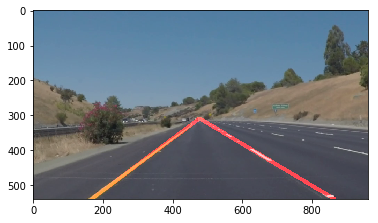

In [18]:
yellow_output = 'yellow4.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))